In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional
from torchvision import datasets, transforms

from foolbox.models import PyTorchModel
from foolbox.criteria import Misclassification
from foolbox.attacks import LocalSearchAttack, BoundaryAttack

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# model definition (example from pytorch/examples/mnist on github)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = functional.relu(functional.max_pool2d(self.conv1(x), 2))
        x = functional.relu(functional.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = functional.relu(self.fc1(x))
        x = functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return functional.log_softmax(x, dim=1)

In [3]:
# initialize/load target network
target = Net()
target.load_state_dict(torch.load('lenet_mnist_model.pth', map_location='cpu'))  # load pre-learned parameters
target.eval()  # put model into evaluation mode

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [4]:
# create foolbox model from target network
fb_model = PyTorchModel(target,
                        bounds=(0,255),  # range of pixel values
                        num_classes=10   # digits 0 to 9
                       )

# set criterion for an adversarial as image with min perturbation causing misclassification
criterion = Misclassification()

# define type of attack (black-box, decision-based)
attack = BoundaryAttack(model=fb_model, criterion=criterion)

In [15]:
# load and format data
# use only last "num" images of test data
num = 500
test_data = datasets.MNIST(root='D:/', train=False, transform=None, 
                           target_transform=None, download=True)

# make sure data has right dimensions for foolbox library, is np.array, and is float
x_test = ([(np.array(x[0]).reshape(1, 28, 28)).astype('float32') for x in test_data])[-num:]
y_test = ([np.int(x[1]) for x in test_data])[-num:]

In [17]:
# generate adversarial images
x_adv = []
for i in range(len(x_test)):
    pred = fb_model.predictions(x_test[i]).argmax()  # model's prediction
    x_adv.append(
        attack(
            input_or_adv=x_test[i],    # original image
            label = pred,              # model's original prediction
            unpack = True,             # return adversarial image
            iterations = 6000,         # max iterations of algo
            log_every_n_steps = 1000,  # print every 100 iters
            threaded_rnd = True,       # multithread random num gen
            threaded_gen = True        # multithread point generation
        )
    )

run with verbose=True to see details
Step 0: 2.36364e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.59830e-02, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (5.5449e-06) (took 0.01562 seconds)
Step 2000: 1.34139e-02, stepsizes = 2.0e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 1.31858e-02, stepsizes = 1.2e-04/3.0e-06:  (took 0.00000 seconds)
Step 4000: 1.31584e-02, stepsizes = 3.4e-05/5.9e-07:  (took 0.01562 seconds)
Step 4700: 1.31547e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 4810: 1.31547e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 4811: 1.31547e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 4812: 1.31547e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 4813: 1.31547e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 4814: 1.31547e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 4815: 1.31547e-02, stepsizes = 4.0e-07/5.2e-08: 
Step 4816: 1.31547e-02, stepsizes = 4.0e-07/5.2e-08: 
Step 4817: 1.31547e-02, stepsizes = 4.0e-07/5.2e-08: 
Step 4818: 1.31547e-02, stepsizes = 4.0e-07/5.2e-08: 
Step 4819: 1.31547e-02, stepsizes = 4.0e-07/3.5e-08: 
Step 4820: 1.31547e-02, stepsizes = 4.0e-07/3.5e-08: 
Step 4821: 1

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.40599e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.3339e-06) (took 0.00997 seconds)
Step 2000: 5.69101e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (2.5994e-07) (took 0.01562 seconds)
Step 3000: 5.58159e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (5.0426e-08) (took 0.01562 seconds)
Step 4000: 5.53840e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (3.3389e-08) (took 0.00000 seconds)
Step 5000: 5.52571e-03, stepsizes = 5.1e-05/1.3e-06:  (took 0.01562 seconds)
Step 6000: 5.52203e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (1.8319e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.54748e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.15558e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.0256e-06) (took 0.01562 seconds)
Step 2000: 4.13742e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.8342e-07) (took 0.01562 seconds)
Step 3000: 4.04438e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (3.6418e-08) (took 0.01562 seconds)
Step 4000: 4.03150e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (3.1943e-09) (took 0.01562 seconds)
Step 4390: 4.03098e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 4494: 4.03097e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4495: 4.03097e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4496: 4.03097e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4497: 4.03097e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4498: 4.03097e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4499: 4.03097e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4500: 4.03097e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4501: 4.03097e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4502: 4.03097e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4503: 4.03097e-03, 

Step 4163: 4.89585e-03, stepsizes = 6.9e-09/2.0e-09: 
Step 4164: 4.89585e-03, stepsizes = 6.9e-09/2.0e-09: 
Step 4165: 4.89585e-03, stepsizes = 4.6e-09/1.4e-09: 
Step 4166: 4.89585e-03, stepsizes = 4.6e-09/1.4e-09: 
Step 4167: 4.89585e-03, stepsizes = 4.6e-09/1.4e-09: 
Step 4168: 4.89585e-03, stepsizes = 4.6e-09/1.4e-09: 
Step 4169: 4.89585e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 4170: 4.89585e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 4171: 4.89585e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 4172: 4.89585e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 4173: 4.89585e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 4174: 4.89585e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 4175: 4.89585e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 4176: 4.89585e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 4177: 4.89585e-03, stepsizes = 3.1e-09/1.4e-09: 
Step 4178: 4.89585e-03, stepsizes = 3.1e-09/1.4e-09: 
Step 4179: 4.89585e-03, stepsizes = 3.1e-09/1.4e-09: 
Step 4180: 4.89585e-03, stepsizes = 3.1e-09/1.4e-09: 
Step 4181: 4.89585e-03, step

Step 4961: 9.70055e-03, stepsizes = 1.5e-08/2.0e-09: 
Step 4962: 9.70055e-03, stepsizes = 1.5e-08/2.0e-09: 
Step 4963: 9.70055e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 4964: 9.70055e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 4965: 9.70055e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 4966: 9.70055e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 4967: 9.70055e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 4968: 9.70055e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 4969: 9.70055e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 4970: 9.70055e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 4971: 9.70055e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 4972: 9.70055e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 4973: 9.70055e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 4974: 9.70055e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 4975: 9.70055e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 4976: 9.70055e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 4977: 9.70055e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 4978: 9.70055e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 4979: 9.70055e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.81844e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.2007e-06) (took 0.01562 seconds)
Step 2000: 2.15447e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (9.8432e-08) (took 0.01562 seconds)
Step 3000: 2.11077e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (5.6508e-09) (took 0.00000 seconds)
Step 3700: 2.10901e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3808: 2.10901e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3809: 2.10901e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3810: 2.10901e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3811: 2.10901e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3812: 2.10901e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3813: 2.10901e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3814: 2.10901e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3815: 2.10901e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3816: 2.10901e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 3817: 2.10901e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 3818: 2.10901e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 3819: 2.10901e-03, s

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.54872e-02, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.2093e-05) (took 0.01562 seconds)
Step 2000: 1.23512e-02, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (8.4624e-07) (took 0.01562 seconds)
Step 3000: 1.21089e-02, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (2.4586e-07) (took 0.00000 seconds)
Step 4000: 1.20473e-02, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (3.2151e-08) (took 0.00000 seconds)
Step 5000: 1.20362e-02, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (4.3351e-09) (took 0.00000 seconds)
Step 5140: 1.20359e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5249: 1.20359e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 5250: 1.20359e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 5251: 1.20359e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 5252: 1.20359e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 5253: 1.20359e-02, stepsizes = 2.0e-06/5.2e-08: 
Step 5254: 1.20359e-02, stepsizes = 2.0e-06/5.2e-08: 
Step 5255: 1.20359e-02, stepsizes = 2.0e-06/3.5e-08: 
Step 5256: 1.20359e-02,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.15830e-03, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.03% (4.0186e-07) (took 0.01562 seconds)
Step 2000: 1.00980e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 9.85354e-04, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (1.3334e-08) (took 0.00000 seconds)
Step 4000: 9.79714e-04, stepsizes = 3.4e-05/8.9e-07:  (took 0.01562 seconds)
Step 4420: 9.79469e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4532: 9.79469e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4533: 9.79469e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4534: 9.79469e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4535: 9.79469e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4536: 9.79469e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4537: 9.79469e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4538: 9.79469e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4539: 9.79469e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 4540: 9.79469e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 4541: 9.79469e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 4542: 9.79469e-04, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.07294e-03, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.12% (9.4580e-06) (took 0.01562 seconds)
Step 2000: 6.58874e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (4.5140e-07) (took 0.01562 seconds)
Step 3000: 6.48804e-03, stepsizes = 1.2e-04/1.3e-06: d. reduced by 0.00% (1.7498e-08) (took 0.00000 seconds)
Step 4000: 6.47670e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (1.1663e-08) (took 0.01562 seconds)
Step 4610: 6.47437e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4722: 6.47437e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4723: 6.47437e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4724: 6.47437e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4725: 6.47437e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4726: 6.47437e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4727: 6.47437e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4728: 6.47437e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4729: 6.47437e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4730: 6.47437e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 4731: 6.47437e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.40085e-03, stepsizes = 1.0e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 2.05383e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.4068e-07) (took 0.00000 seconds)
Step 3000: 2.00647e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.8082e-08) (took 0.00000 seconds)
Step 4000: 1.99795e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (8.0042e-09) (took 0.01562 seconds)
Step 5000: 1.99517e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (7.2994e-10) (took 0.01562 seconds)
Step 5190: 1.99511e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5302: 1.99511e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5303: 1.99511e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5304: 1.99511e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5305: 1.99511e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5306: 1.99511e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5307: 1.99511e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5308: 1.99511e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5309: 1.99511e-03, stepsizes = 7.8e-08/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.74492e-02, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (6.0536e-06) (took 0.00000 seconds)
Step 2000: 1.53950e-02, stepsizes = 2.0e-03/2.3e-05: d. reduced by 0.00% (7.0320e-07) (took 0.00000 seconds)
Step 3000: 1.52332e-02, stepsizes = 1.7e-04/3.0e-06:  (took 0.01562 seconds)
Step 4000: 1.51952e-02, stepsizes = 3.4e-05/4.0e-07:  (took 0.01562 seconds)
Step 5000: 1.51852e-02, stepsizes = 1.5e-05/2.6e-07:  (took 0.01562 seconds)
Step 5440: 1.51839e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5557: 1.51839e-02, stepsizes = 4.5e-06/5.2e-08: 
Step 5558: 1.51839e-02, stepsizes = 4.5e-06/5.2e-08: 
Step 5559: 1.51839e-02, stepsizes = 4.5e-06/5.2e-08: 
Step 5560: 1.51839e-02, stepsizes = 4.5e-06/5.2e-08: 
Step 5561: 1.51839e-02, stepsizes = 4.5e-06/5.2e-08: 
Step 5562: 1.51839e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5563: 1.51839e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5564: 1.51839e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5565: 1.51839e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5566: 

Step 5329: 6.69267e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5330: 6.69267e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5331: 6.69267e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5332: 6.69267e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5333: 6.69267e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5334: 6.69267e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5335: 6.69267e-03, stepsizes = 7.8e-08/2.0e-09: 
Step 5336: 6.69267e-03, stepsizes = 7.8e-08/2.0e-09: 
Step 5337: 6.69267e-03, stepsizes = 7.8e-08/2.0e-09: 
Step 5338: 6.69267e-03, stepsizes = 7.8e-08/2.0e-09: 
Step 5339: 6.69267e-03, stepsizes = 5.2e-08/1.4e-09: 
Step 5340: 6.69267e-03, stepsizes = 5.2e-08/1.4e-09: 
Step 5341: 6.69267e-03, stepsizes = 5.2e-08/1.4e-09: 
Step 5342: 6.69267e-03, stepsizes = 5.2e-08/1.4e-09: 
Step 5343: 6.69267e-03, stepsizes = 3.5e-08/9.0e-10: 
Step 5344: 6.69267e-03, stepsizes = 3.5e-08/9.0e-10: 
Step 5345: 6.69267e-03, stepsizes = 3.5e-08/9.0e-10: 
Step 5346: 6.69267e-03, stepsizes = 3.5e-08/1.4e-09: 
Step 5347: 6.69267e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.77725e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.1685e-06) (took 0.00000 seconds)
Step 2000: 2.34257e-03, stepsizes = 1.3e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 2.29519e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.3809e-08) (took 0.00000 seconds)
Step 4000: 2.28917e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.01562 seconds)
Step 4280: 2.28897e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4386: 2.28897e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4387: 2.28897e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4388: 2.28897e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4389: 2.28897e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4390: 2.28897e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4391: 2.28897e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4392: 2.28897e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4393: 2.28897e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4394: 2.28897e-03, stepsizes = 2.6e-07/2.3e-08: 
Step 4395: 2.28897e-03, stepsizes = 2.6e-07/2.3e-08: 
Step 4396: 2.28897e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.73679e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.9856e-06) (took 0.01562 seconds)
Step 2000: 4.62800e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (3.1712e-07) (took 0.00000 seconds)
Step 3000: 4.51176e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.8078e-08) (took 0.01562 seconds)
Step 4000: 4.50318e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (2.3570e-09) (took 0.00000 seconds)
Step 4620: 4.50226e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4724: 4.50226e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4725: 4.50226e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4726: 4.50226e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4727: 4.50226e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4728: 4.50226e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4729: 4.50226e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4730: 4.50226e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4731: 4.50226e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4732: 4.50226e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4733: 4.50226e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.71354e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.5349e-06) (took 0.01562 seconds)
Step 2000: 7.48336e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 7.35377e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (6.6443e-08) (took 0.01562 seconds)
Step 4000: 7.32651e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.9565e-08) (took 0.00000 seconds)
Step 5000: 7.31885e-03, stepsizes = 2.3e-05/4.0e-07:  (took 0.01562 seconds)
Step 5510: 7.31751e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 5617: 7.31750e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5618: 7.31750e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5619: 7.31750e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5620: 7.31750e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5621: 7.31750e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5622: 7.31750e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5623: 7.31750e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5624: 7.31750e-03, stepsizes = 1.3e-06/2.3e-08: 
Step 5625: 7.31750e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.01660e-02, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (5.2908e-06) (took 0.01562 seconds)
Step 2000: 8.56931e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 8.35689e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (1.6963e-07) (took 0.01562 seconds)
Step 4000: 8.24933e-03, stepsizes = 3.9e-04/1.0e-05:  (took 0.00000 seconds)
Step 5000: 8.20294e-03, stepsizes = 7.7e-05/8.9e-07: d. reduced by 0.00% (1.4612e-08) (took 0.01562 seconds)
Step 6000: 8.19330e-03, stepsizes = 1.5e-05/4.0e-07:  (took 0.00000 seconds)
run with verbose=True to see details
Step 0: 1.68900e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 1000: 1.15942e-02, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (9.0529e-06) (took 0.01562 seconds)
Step 2000: 9.15432e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (9.4078e-07) (took 0.01562 seconds)
Step 3000: 8.82978e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (1.1959e-07) (took 0.00000 seconds)
Step 4000: 8.77875e-03, ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.87298e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (1.4953e-06) (took 0.01562 seconds)
Step 2000: 2.32546e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (7.0790e-08) (took 0.01562 seconds)
Step 3000: 2.29332e-03, stepsizes = 1.2e-04/2.0e-06:  (took 0.00000 seconds)
Step 4000: 2.29024e-03, stepsizes = 6.8e-06/1.8e-07:  (took 0.01562 seconds)
Step 4050: 2.29024e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4162: 2.29024e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4163: 2.29024e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4164: 2.29024e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4165: 2.29024e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4166: 2.29024e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4167: 2.29024e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4168: 2.29024e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4169: 2.29024e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4170: 2.29024e-03, stepsizes = 5.2e-08/2.3e-08: 
Step 4171: 2.29024e-03, stepsizes = 5.2e-08/2.3e-08: 
Step 4172: 2.29024e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.58672e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.8667e-06) (took 0.01562 seconds)
Step 2000: 3.16391e-03, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (9.6364e-08) (took 0.01562 seconds)
Step 3000: 3.13675e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.8911e-08) (took 0.00000 seconds)
Step 4000: 3.12280e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (8.3420e-09) (took 0.00000 seconds)
Step 4910: 3.11943e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5000: 3.11943e-03, stepsizes = 2.0e-06/4.0e-07:  (took 0.01562 seconds)
Step 5012: 3.11943e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5013: 3.11943e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5014: 3.11943e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5015: 3.11943e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5016: 3.11943e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5017: 3.11943e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5018: 3.11943e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5019: 3.11943e-03, stepsizes = 5.9e-07/5.2e-08: 
S

Step 4552: 7.53187e-03, stepsizes = 1.8e-07/2.0e-09: 
Step 4553: 7.53187e-03, stepsizes = 1.2e-07/1.4e-09: 
Step 4554: 7.53187e-03, stepsizes = 1.2e-07/1.4e-09: 
Step 4555: 7.53187e-03, stepsizes = 1.2e-07/1.4e-09: 
Step 4556: 7.53187e-03, stepsizes = 1.2e-07/1.4e-09: 
Step 4557: 7.53187e-03, stepsizes = 7.8e-08/9.0e-10: 
Step 4558: 7.53187e-03, stepsizes = 7.8e-08/9.0e-10: 
Step 4559: 7.53187e-03, stepsizes = 7.8e-08/9.0e-10: 
Step 4560: 7.53187e-03, stepsizes = 7.8e-08/6.0e-10: 
Step 4561: 7.53187e-03, stepsizes = 5.2e-08/4.0e-10: 
Step 4562: 7.53187e-03, stepsizes = 5.2e-08/4.0e-10: 
Step 4563: 7.53187e-03, stepsizes = 5.2e-08/4.0e-10: 
Step 4564: 7.53187e-03, stepsizes = 5.2e-08/4.0e-10: 
Step 4565: 7.53187e-03, stepsizes = 5.2e-08/6.0e-10: 
Step 4566: 7.53187e-03, stepsizes = 3.5e-08/4.0e-10: 
Step 4567: 7.53187e-03, stepsizes = 3.5e-08/4.0e-10: 
Step 4568: 7.53187e-03, stepsizes = 3.5e-08/4.0e-10: 
Step 4569: 7.53187e-03, stepsizes = 3.5e-08/4.0e-10: 
Step 4570: 7.53187e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.95310e-03, stepsizes = 2.3e-02/5.9e-04: d. reduced by 0.08% (4.6483e-06) (took 0.01562 seconds)
Step 2000: 4.94818e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (3.3907e-07) (took 0.01562 seconds)
Step 3000: 4.84780e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (4.3665e-08) (took 0.01562 seconds)
Step 4000: 4.83412e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (5.7766e-09) (took 0.00000 seconds)
Step 4980: 4.83153e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5000: 4.83153e-03, stepsizes = 1.3e-03/1.3e-03:  (took 0.00000 seconds)
Step 5086: 4.83153e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5087: 4.83152e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5088: 4.83152e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5089: 4.83152e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5090: 4.83152e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5091: 4.83152e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5092: 4.83152e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 5093: 4.83152e-03, stepsizes = 2.6e-07/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.58187e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.4255e-06) (took 0.00000 seconds)
Step 2000: 5.55548e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (3.8056e-07) (took 0.00000 seconds)
Step 3000: 5.45545e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (3.2821e-08) (took 0.01562 seconds)
Step 4000: 5.43789e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (9.6187e-09) (took 0.00000 seconds)
Step 5000: 5.42953e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.4551e-08) (took 0.00000 seconds)
Step 6000: 5.42417e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (2.9644e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.41844e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.16620e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 2.41601e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.01% (1.6548e-07) (took 0.01562 seconds)
Step 3000: 2.39281e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (9.6043e-09) (took 0.00000 seconds)
Step 3630: 2.39160e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 3735: 2.39160e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 3736: 2.39160e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 3737: 2.39160e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 3738: 2.39160e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3739: 2.39160e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3740: 2.39160e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3741: 2.39160e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3742: 2.39160e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3743: 2.39160e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 3744: 2.39160e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 3745: 2.39160e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 3746: 2.39160e-03, stepsizes = 4.0e-07/2.3e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.87290e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (5.1386e-06) (took 0.00000 seconds)
Step 2000: 8.24001e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (5.6448e-07) (took 0.00000 seconds)
Step 3000: 8.07272e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (2.4576e-07) (took 0.01562 seconds)
Step 4000: 7.95719e-03, stepsizes = 2.6e-04/3.0e-06: d. reduced by 0.00% (4.7854e-08) (took 0.01562 seconds)
Step 5000: 7.92770e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (9.5503e-09) (took 0.00000 seconds)
Step 6000: 7.92288e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (6.2762e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.69004e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.34032e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.3000e-06) (took 0.00000 seconds)
Step 2000: 5.41700e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.6488e-07) (took 0.00000 seconds)
Step 3000: 5.27138e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (7.1355e-08) (took 0.01562 seconds)
Step 4000: 5.24152e-03, stepsizes = 1.2e-04/3.0e-06:  (took 0.00000 seconds)
Step 5000: 5.23400e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (4.1320e-09) (took 0.00000 seconds)
Step 5500: 5.23278e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5607: 5.23278e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5608: 5.23278e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5609: 5.23278e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5610: 5.23278e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5611: 5.23278e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5612: 5.23278e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5613: 5.23278e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5614: 5.23278e-03, stepsizes = 2.6e-07/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.34431e-02, stepsizes = 1.5e-02/5.9e-04:  (took 0.00000 seconds)
Step 2000: 1.10720e-02, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (7.5862e-07) (took 0.01562 seconds)
Step 3000: 1.07488e-02, stepsizes = 3.9e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 1.07002e-02, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.9035e-08) (took 0.01562 seconds)
Step 5000: 1.06851e-02, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (8.4889e-09) (took 0.00000 seconds)
Step 5440: 1.06836e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5540: 1.06836e-02, stepsizes = 5.9e-07/7.8e-08: 
Step 5541: 1.06836e-02, stepsizes = 5.9e-07/7.8e-08: 
Step 5542: 1.06836e-02, stepsizes = 5.9e-07/7.8e-08: 
Step 5543: 1.06836e-02, stepsizes = 5.9e-07/7.8e-08: 
Step 5544: 1.06836e-02, stepsizes = 4.0e-07/5.2e-08: 
Step 5545: 1.06836e-02, stepsizes = 4.0e-07/5.2e-08: 
Step 5546: 1.06836e-02, stepsizes = 4.0e-07/5.2e-08: 
Step 5547: 1.06836e-02, stepsizes = 4.0e-07/5.2e-08: 
Step 5548: 1.06836e-02, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.05251e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (6.2876e-06) (took 0.00000 seconds)
Step 2000: 6.64149e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (4.5488e-07) (took 0.01562 seconds)
Step 3000: 6.42629e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (5.7941e-08) (took 0.01562 seconds)
Step 4000: 6.40927e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.1442e-08) (took 0.00000 seconds)
Step 5000: 6.40382e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (2.3092e-09) (took 0.00000 seconds)
Step 5080: 6.40371e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5192: 6.40371e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5193: 6.40371e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5194: 6.40371e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5195: 6.40371e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5196: 6.40371e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5197: 6.40371e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5198: 6.40371e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5199: 6.40371e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.02464e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.00000 seconds)
Step 2000: 8.86274e-04, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (1.7995e-08) (took 0.01562 seconds)
Step 3000: 8.77933e-04, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (2.3483e-09) (took 0.01562 seconds)
Step 3660: 8.77339e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 3769: 8.77339e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3770: 8.77339e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3771: 8.77339e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3772: 8.77339e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3773: 8.77339e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3774: 8.77339e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3775: 8.77339e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3776: 8.77339e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3777: 8.77339e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 3778: 8.77339e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 3779: 8.77339e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3780: 8.77339e-04, stepsizes = 7.8e-08/2.3e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.95310e-02, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.5250e-05) (took 0.00000 seconds)
Step 2000: 1.71577e-02, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (7.8351e-07) (took 0.01562 seconds)
Step 3000: 1.67861e-02, stepsizes = 5.9e-04/6.8e-06: d. reduced by 0.00% (3.4080e-07) (took 0.01562 seconds)
Step 4000: 1.66346e-02, stepsizes = 2.6e-04/4.5e-06:  (took 0.01562 seconds)
Step 5000: 1.65901e-02, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (1.9891e-08) (took 0.01562 seconds)
Step 6000: 1.65782e-02, stepsizes = 2.3e-05/2.6e-07: d. reduced by 0.00% (8.5896e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 2.19336e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 1000: 1.41899e-02, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (7.3852e-06) (took 0.01562 seconds)
Step 2000: 1.13771e-02, stepsizes = 4.4e-03/7.7e-05: d. reduced by 0.02% (1.7541e-06) (took 0.00000 seconds)
Step 3000: 1.09042e-02, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00%

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.79998e-05, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.05% (1.9778e-08) (took 0.00000 seconds)
Step 2000: 3.12552e-05, stepsizes = 2.0e-03/3.4e-05:  (took 0.01562 seconds)


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2970: 3.07942e-05, stepsizes = 4.5e-06/7.8e-08: 
Step 3000: 3.07942e-05, stepsizes = 5.9e-04/5.9e-04:  (took 0.01562 seconds)
Step 3079: 3.07942e-05, stepsizes = 1.8e-07/7.8e-08: 
Step 3080: 3.07941e-05, stepsizes = 1.8e-07/7.8e-08: 
Step 3081: 3.07941e-05, stepsizes = 1.8e-07/7.8e-08: 
Step 3082: 3.07941e-05, stepsizes = 1.2e-07/5.2e-08: 
Step 3083: 3.07941e-05, stepsizes = 1.2e-07/5.2e-08: 
Step 3084: 3.07941e-05, stepsizes = 1.2e-07/5.2e-08: 
Step 3085: 3.07941e-05, stepsizes = 1.2e-07/5.2e-08: 
Step 3086: 3.07941e-05, stepsizes = 7.8e-08/3.5e-08: 
Step 3087: 3.07941e-05, stepsizes = 7.8e-08/3.5e-08: 
Step 3088: 3.07941e-05, stepsizes = 7.8e-08/3.5e-08: 
Step 3089: 3.07941e-05, stepsizes = 7.8e-08/3.5e-08: 
Step 3090: 3.07941e-05, stepsizes = 5.2e-08/2.3e-08: 
Step 3091: 3.07941e-05, stepsizes = 5.2e-08/2.3e-08: 
Step 3092: 3.07941e-05, stepsizes = 5.2e-08/2.3e-08: 
Step 3093: 3.07941e-05, stepsizes = 5.2e-08/1.5e-08: 
Step 3094: 3.07941e-05, stepsizes = 3.5e-08/1.0e-08: 
Step 

Step 5324: 2.94395e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5325: 2.94395e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5326: 2.94395e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5327: 2.94395e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5328: 2.94395e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 5329: 2.94395e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 5330: 2.94395e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 5331: 2.94395e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 5332: 2.94395e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 5333: 2.94395e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 5334: 2.94395e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 5335: 2.94395e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 5336: 2.94395e-03, stepsizes = 2.0e-09/4.0e-10: 
Step 5337: 2.94395e-03, stepsizes = 2.0e-09/6.0e-10: 
Step 5338: 2.94395e-03, stepsizes = 2.0e-09/6.0e-10: 
Step 5339: 2.94395e-03, stepsizes = 2.0e-09/6.0e-10: 
Step 5340: 2.94395e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 5341: 2.94395e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 5342: 2.94395e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.37315e-02, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.03% (4.7638e-06) (took 0.01562 seconds)
Step 2000: 1.08961e-02, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (1.1199e-06) (took 0.00000 seconds)
Step 3000: 1.05819e-02, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (2.1498e-07) (took 0.01562 seconds)
Step 4000: 1.05115e-02, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (4.1957e-08) (took 0.01562 seconds)
Step 5000: 1.04955e-02, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (8.2678e-09) (took 0.01562 seconds)
Step 6000: 1.04907e-02, stepsizes = 1.5e-05/1.8e-07: d. reduced by 0.00% (3.6678e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.97638e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 1000: 7.75219e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.0346e-06) (took 0.00000 seconds)
Step 2000: 6.68158e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (2.0338e-07) (took 0.01562 seconds)
Step 3000: 6.57902e-03, stepsizes = 2.6e

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.52828e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (5.8783e-07) (took 0.00000 seconds)
Step 2000: 6.10321e-04, stepsizes = 2.0e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 5.90574e-04, stepsizes = 3.9e-04/4.5e-06: d. reduced by 0.00% (5.3212e-09) (took 0.01562 seconds)
Step 4000: 5.88367e-04, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (4.6648e-10) (took 0.01562 seconds)
Step 4210: 5.88342e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 4316: 5.88342e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 4317: 5.88342e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 4318: 5.88342e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 4319: 5.88342e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 4320: 5.88342e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 4321: 5.88342e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 4322: 5.88342e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 4323: 5.88342e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 4324: 5.88342e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 4325: 5.88342e-04, stepsizes = 2.6e-07/3.5e-08: 
St

Step 5215: 3.57112e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 5216: 3.57112e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5217: 3.57112e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5218: 3.57112e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5219: 3.57112e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5220: 3.57112e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5221: 3.57112e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5222: 3.57112e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5223: 3.57112e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5224: 3.57112e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 5225: 3.57112e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 5226: 3.57112e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 5227: 3.57112e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 5228: 3.57112e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 5229: 3.57112e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 5230: 3.57112e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 5231: 3.57112e-03, stepsizes = 3.1e-09/9.0e-10: 
Step 5232: 3.57112e-03, stepsizes = 3.1e-09/9.0e-10: 
Step 5233: 3.57112e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.29609e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (5.6969e-06) (took 0.00000 seconds)
Step 2000: 6.05603e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (4.1486e-07) (took 0.01562 seconds)
Step 3000: 5.93927e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (8.0346e-08) (took 0.00000 seconds)
Step 4000: 5.90701e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (5.3178e-08) (took 0.01562 seconds)
Step 5000: 5.88846e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (6.9616e-09) (took 0.00000 seconds)
Step 5860: 5.88535e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5964: 5.88535e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5965: 5.88535e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5966: 5.88535e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5967: 5.88535e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5968: 5.88535e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5969: 5.88535e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5970: 5.88535e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5971: 5.88535e-03,

Step 4836: 1.01140e-02, stepsizes = 3.1e-09/9.0e-10: 
Step 4837: 1.01140e-02, stepsizes = 3.1e-09/9.0e-10: 
Step 4838: 1.01140e-02, stepsizes = 3.1e-09/9.0e-10: 
Step 4839: 1.01140e-02, stepsizes = 3.1e-09/1.4e-09: 
Step 4840: 1.01140e-02, stepsizes = 3.1e-09/1.4e-09: 
Step 4841: 1.01140e-02, stepsizes = 3.1e-09/1.4e-09: 
Step 4842: 1.01140e-02, stepsizes = 2.0e-09/9.0e-10: 
Step 4843: 1.01140e-02, stepsizes = 2.0e-09/9.0e-10: 
run with verbose=True to see details
Step 0: 1.68470e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.42311e-04, stepsizes = 6.7e-03/1.7e-04:  (took 0.01562 seconds)
Step 2000: 8.04515e-04, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (8.2647e-08) (took 0.00000 seconds)
Step 3000: 7.72296e-04, stepsizes = 8.8e-04/1.5e-05:  (took 0.01562 seconds)
Step 4000: 7.67449e-04, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (8.8778e-10) (took 0.01562 seconds)
Step 4280: 7.67320e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 4392: 7.67319e-04, stepsizes = 1.3e-06/7.8e-08: 
Step 4393: 7.67319e-04, stepsizes = 1.3e-06/5.2e-08: 
Step 4394: 7.67319e-04, stepsizes = 1.3e-06/5.2e-08: 
Step 4395: 7.67319e-04, stepsizes = 1.3e-06/5.2e-08: 
Step 4396: 7.67319e-04, stepsizes = 8.9e-07/3.5e-08: 
Step 4397: 7.67319e-04, stepsizes = 8.9e-07/3.5e-08: 
Step 4398: 7.67319e-04, stepsizes = 8.9e-07/3.5e-08: 
Step 4399: 7.67319e-04, stepsizes = 8.9e-07/3.5e-08: 
Step 4400: 7.67319e-04, stepsizes = 5.9e-07/2.3e-08: 
Step 4401: 7.67319e-04, stepsizes = 5.9e-07/2.3e-08: 
Step 4402: 7.67319e-04, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.18281e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (6.1560e-07) (took 0.01562 seconds)
Step 2000: 9.76531e-04, stepsizes = 1.3e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 9.34163e-04, stepsizes = 2.6e-04/1.0e-05: d. reduced by 0.00% (2.8436e-08) (took 0.00000 seconds)
Step 4000: 9.25711e-04, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (1.2519e-08) (took 0.01562 seconds)
Step 5000: 9.22620e-04, stepsizes = 7.7e-05/3.0e-06:  (took 0.01562 seconds)
Step 5330: 9.22395e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 5442: 9.22395e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 5443: 9.22395e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 5444: 9.22395e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 5445: 9.22395e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 5446: 9.22395e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 5447: 9.22395e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 5448: 9.22395e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 5449: 9.22395e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 5450: 9.22395e-04, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.83544e-04, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 2.25522e-04, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.0318e-08) (took 0.01562 seconds)
Step 3000: 2.21958e-04, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (1.9859e-09) (took 0.00000 seconds)
Step 3870: 2.21607e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 3978: 2.21607e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3979: 2.21607e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3980: 2.21607e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3981: 2.21607e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3982: 2.21607e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3983: 2.21607e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3984: 2.21607e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3985: 2.21607e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3986: 2.21607e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 3987: 2.21607e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 3988: 2.21607e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 3989: 2.21607e-04, stepsizes = 7.8e-08/3.5e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.67473e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.03% (9.2790e-07) (took 0.01562 seconds)
Step 2000: 2.34591e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (7.1398e-08) (took 0.01562 seconds)
Step 3000: 2.31410e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.3867e-08) (took 0.01562 seconds)
Step 4000: 2.30941e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (7.9858e-10) (took 0.01562 seconds)
Step 4150: 2.30937e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4258: 2.30937e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4259: 2.30937e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4260: 2.30937e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4261: 2.30937e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4262: 2.30937e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4263: 2.30937e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4264: 2.30937e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4265: 2.30937e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4266: 2.30937e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4267: 2.30937e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.09553e-03, stepsizes = 2.3e-02/8.8e-04: d. reduced by 0.08% (4.7595e-06) (took 0.01562 seconds)
Step 2000: 5.17470e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.3643e-07) (took 0.00000 seconds)
Step 3000: 5.00455e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.0158e-07) (took 0.01562 seconds)
Step 4000: 4.96178e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (2.9795e-08) (took 0.01562 seconds)
Step 5000: 4.95221e-03, stepsizes = 3.4e-05/4.0e-07:  (took 0.01562 seconds)
Step 5510: 4.95121e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 5618: 4.95121e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5619: 4.95121e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5620: 4.95121e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5621: 4.95121e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5622: 4.95121e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5623: 4.95121e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5624: 4.95121e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5625: 4.95121e-03, stepsizes = 1.2e-07/3.5e-08: 
S

Step 4810: 1.05722e-02, stepsizes = 5.9e-07/1.5e-08: 
Step 4811: 1.05722e-02, stepsizes = 5.9e-07/1.5e-08: 
Step 4812: 1.05722e-02, stepsizes = 5.9e-07/1.5e-08: 
Step 4813: 1.05722e-02, stepsizes = 4.0e-07/1.0e-08: 
Step 4814: 1.05722e-02, stepsizes = 4.0e-07/1.0e-08: 
Step 4815: 1.05722e-02, stepsizes = 4.0e-07/1.0e-08: 
Step 4816: 1.05722e-02, stepsizes = 4.0e-07/1.0e-08: 
Step 4817: 1.05722e-02, stepsizes = 2.6e-07/6.9e-09: 
Step 4818: 1.05722e-02, stepsizes = 2.6e-07/6.9e-09: 
Step 4819: 1.05722e-02, stepsizes = 2.6e-07/6.9e-09: 
Step 4820: 1.05722e-02, stepsizes = 2.6e-07/6.9e-09: 
Step 4821: 1.05722e-02, stepsizes = 1.8e-07/4.6e-09: 
Step 4822: 1.05722e-02, stepsizes = 1.8e-07/4.6e-09: 
Step 4823: 1.05722e-02, stepsizes = 1.8e-07/4.6e-09: 
Step 4824: 1.05722e-02, stepsizes = 1.8e-07/4.6e-09: 
Step 4825: 1.05722e-02, stepsizes = 1.2e-07/3.1e-09: 
Step 4826: 1.05722e-02, stepsizes = 1.2e-07/3.1e-09: 
Step 4827: 1.05722e-02, stepsizes = 1.2e-07/3.1e-09: 
Step 4828: 1.05722e-02, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.30222e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (6.7769e-07) (took 0.01562 seconds)
Step 2000: 1.17693e-03, stepsizes = 1.3e-03/1.5e-05:  (took 0.00000 seconds)
Step 3000: 1.14345e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (6.8537e-09) (took 0.01562 seconds)
Step 4000: 1.14009e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (1.3544e-09) (took 0.00000 seconds)
Step 4170: 1.14007e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4282: 1.14007e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4283: 1.14007e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4284: 1.14007e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4285: 1.14007e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4286: 1.14007e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4287: 1.14007e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4288: 1.14007e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4289: 1.14007e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4290: 1.14007e-03, stepsizes = 5.2e-08/2.3e-08: 
Step 4291: 1.14007e-03, stepsizes = 5.2e-08/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.19288e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.7435e-06) (took 0.00000 seconds)
Step 2000: 6.22852e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (4.2679e-07) (took 0.00000 seconds)
Step 3000: 6.13573e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 6.11753e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.6369e-08) (took 0.01999 seconds)
Step 5000: 6.11098e-03, stepsizes = 4.5e-06/1.2e-07: d. reduced by 0.00% (1.3979e-09) (took 0.01562 seconds)
Step 5070: 6.11092e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5171: 6.11092e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5172: 6.11092e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5173: 6.11092e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5174: 6.11092e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5175: 6.11092e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5176: 6.11092e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5177: 6.11092e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5178: 6.11092e-03, stepsizes = 2.6e-07/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.97507e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (6.2273e-06) (took 0.01562 seconds)
Step 2000: 6.71296e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.00% (3.0670e-07) (took 0.01562 seconds)
Step 3000: 6.57676e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (8.8983e-08) (took 0.00000 seconds)
Step 4000: 6.55841e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (1.1724e-08) (took 0.00000 seconds)
Step 5000: 6.55585e-03, stepsizes = 6.8e-06/1.8e-07: d. reduced by 0.00% (2.2808e-09) (took 0.00000 seconds)
Step 5100: 6.55576e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5211: 6.55576e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5212: 6.55576e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5213: 6.55576e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5214: 6.55576e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5215: 6.55576e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5216: 6.55576e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5217: 6.55576e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5218: 6.55576e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.75220e-02, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (9.1194e-06) (took 0.01562 seconds)
Step 2000: 1.47408e-02, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.0100e-06) (took 0.00000 seconds)
Step 3000: 1.41989e-02, stepsizes = 8.8e-04/1.5e-05:  (took 0.00000 seconds)
Step 4000: 1.40767e-02, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (5.6399e-08) (took 0.01562 seconds)
Step 5000: 1.40583e-02, stepsizes = 7.7e-05/8.9e-07: d. reduced by 0.00% (2.4992e-08) (took 0.01562 seconds)
Step 6000: 1.40464e-02, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (7.5202e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 2.56929e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.01563e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 4.21338e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.9235e-07) (took 0.01562 seconds)
Step 3000: 4.14785e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (3.7406e-08) (took 0.01562 seconds)
Step 4000: 4.13487e-03, stepsizes = 5.1e-05/5.9e-07: d. reduced by 0.00% (4.9064e-09) (took 0.00000 seconds)
Step 4970: 4.13177e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5000: 4.13177e-03, stepsizes = 5.9e-04/5.9e-04:  (took 0.01562 seconds)
Step 5074: 4.13176e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5075: 4.13176e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5076: 4.13176e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5077: 4.13176e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5078: 4.13176e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5079: 4.13176e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5080: 4.13176e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5081: 4.13176e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5082: 4.13176e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.52467e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 3.40675e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (3.5011e-07) (took 0.01562 seconds)
Step 3000: 3.30374e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (4.4797e-08) (took 0.00000 seconds)
Step 4000: 3.29646e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (8.8038e-09) (took 0.01562 seconds)
Step 4510: 3.29576e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4607: 3.29576e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4608: 3.29576e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4609: 3.29576e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4610: 3.29576e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4611: 3.29576e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4612: 3.29576e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4613: 3.29576e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4614: 3.29576e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4615: 3.29576e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4616: 3.29576e-03, stepsizes = 4.0e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.49474e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 3.96066e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (6.1055e-07) (took 0.00000 seconds)
Step 3000: 3.83995e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (5.2052e-08) (took 0.01562 seconds)
Step 4000: 3.82007e-03, stepsizes = 7.7e-05/1.3e-06:  (took 0.01562 seconds)
Step 5000: 3.81501e-03, stepsizes = 6.8e-06/1.8e-07:  (took 0.01562 seconds)
Step 5050: 3.81499e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5154: 3.81499e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5155: 3.81499e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5156: 3.81499e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5157: 3.81499e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5158: 3.81499e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5159: 3.81499e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5160: 3.81499e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5161: 3.81499e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5162: 3.81499e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5163: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.60898e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (5.1605e-06) (took 0.00000 seconds)
Step 2000: 5.32365e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (5.4711e-07) (took 0.01562 seconds)
Step 3000: 5.21656e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (7.0521e-08) (took 0.00000 seconds)
Step 4000: 5.18390e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.3897e-08) (took 0.01562 seconds)
Step 5000: 5.17854e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (4.1016e-09) (took 0.00000 seconds)
Step 5330: 5.17796e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5438: 5.17796e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5439: 5.17796e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5440: 5.17796e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5441: 5.17796e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5442: 5.17796e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5443: 5.17796e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 5444: 5.17796e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 5445: 5.17796e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.96217e-03, stepsizes = 1.0e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 6.87482e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (7.0654e-07) (took 0.00000 seconds)
Step 3000: 6.61791e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (1.3448e-07) (took 0.01562 seconds)
Step 4000: 6.57238e-03, stepsizes = 1.2e-04/3.0e-06:  (took 0.00000 seconds)
Step 5000: 6.56430e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (3.5938e-09) (took 0.01562 seconds)
Step 5420: 6.56359e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5526: 6.56359e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5527: 6.56359e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5528: 6.56359e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5529: 6.56359e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5530: 6.56359e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5531: 6.56359e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5532: 6.56359e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5533: 6.56359e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 5534: 6.56359e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.54749e-04, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.9691e-07) (took 0.01562 seconds)
Step 2000: 7.77400e-04, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.00% (3.5515e-08) (took 0.01562 seconds)
Step 3000: 7.58511e-04, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (1.0294e-08) (took 0.00000 seconds)
Step 4000: 7.55675e-04, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (1.3563e-09) (took 0.00000 seconds)
Step 4300: 7.55588e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4405: 7.55588e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 4406: 7.55588e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 4407: 7.55588e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 4408: 7.55588e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4409: 7.55588e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4410: 7.55588e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4411: 7.55588e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4412: 7.55588e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 4413: 7.55588e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 4414: 7.55588e-04, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.16724e-03, stepsizes = 1.5e-02/5.9e-04:  (took 0.01562 seconds)
Step 2000: 9.78415e-04, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (2.9770e-08) (took 0.00000 seconds)
Step 3000: 9.65569e-04, stepsizes = 1.7e-04/3.0e-06:  (took 0.01562 seconds)
Step 4000: 9.60374e-04, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (3.8863e-09) (took 0.01562 seconds)
Step 4890: 9.59617e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4995: 9.59617e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 4996: 9.59617e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 4997: 9.59617e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 4998: 9.59617e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 4999: 9.59617e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 5000: 9.59617e-04, stepsizes = 4.0e-07/5.2e-08:  (took 0.01562 seconds)
Step 5000: 9.59617e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 5001: 9.59617e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 5002: 9.59617e-04, stepsizes = 4.0e-07/3.5e-08: 
Step 5003: 9.59617e-04, stepsizes = 2.6e-07/2.3e-08: 
Step 5004: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.59550e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.03% (2.2881e-06) (took 0.01562 seconds)
Step 2000: 5.48525e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (3.7583e-07) (took 0.01562 seconds)
Step 3000: 5.38654e-03, stepsizes = 2.6e-04/4.5e-06:  (took 0.00000 seconds)
Step 4000: 5.36661e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.4447e-08) (took 0.01562 seconds)
Step 5000: 5.35720e-03, stepsizes = 3.4e-05/5.9e-07:  (took 0.01562 seconds)
Step 5270: 5.35649e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5378: 5.35649e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5379: 5.35649e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5380: 5.35649e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5381: 5.35649e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5382: 5.35649e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5383: 5.35649e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5384: 5.35649e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5385: 5.35649e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5386: 5.35649e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.34983e-03, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.03% (4.6828e-07) (took 0.01562 seconds)
Step 2000: 1.20652e-03, stepsizes = 1.3e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 1.18120e-03, stepsizes = 1.2e-04/3.0e-06:  (took 0.00000 seconds)
Step 4000: 1.17704e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (3.1131e-09) (took 0.01562 seconds)
Step 4460: 1.17661e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4566: 1.17661e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4567: 1.17661e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4568: 1.17661e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4569: 1.17661e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4570: 1.17661e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4571: 1.17661e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4572: 1.17661e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4573: 1.17661e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4574: 1.17661e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4575: 1.17661e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4576: 1.17661e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.44552e-03, stepsizes = 6.7e-03/1.7e-04:  (took 0.00000 seconds)
Step 2000: 6.43648e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (6.6136e-07) (took 0.01562 seconds)
Step 3000: 6.17936e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (8.3682e-08) (took 0.00000 seconds)
Step 4000: 6.14758e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.6504e-08) (took 0.00000 seconds)
Step 5000: 6.13773e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (4.9353e-09) (took 0.01562 seconds)
Step 5240: 6.13723e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5348: 6.13721e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5349: 6.13721e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5350: 6.13721e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5351: 6.13721e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5352: 6.13720e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5353: 6.13720e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5354: 6.13720e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5355: 6.13720e-03, stepsizes = 3.0e-06/5.2e-08: 
S

Step 5996: 2.88829e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5997: 2.88829e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5998: 2.88829e-03, stepsizes = 2.6e-07/1.0e-08: 
Step 5999: 2.88829e-03, stepsizes = 1.8e-07/6.9e-09: 
Step 6000: 2.88829e-03, stepsizes = 1.8e-07/6.9e-09: d. reduced by 0.00% (3.9671e-11) (took 0.00000 seconds)
run with verbose=True to see details
Step 0: 1.30093e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.08257e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (3.9685e-06) (took 0.00000 seconds)
Step 2000: 3.98885e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (4.0996e-07) (took 0.01562 seconds)
Step 3000: 3.87252e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (5.2329e-08) (took 0.01562 seconds)
Step 4000: 3.85273e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (6.8225e-09) (took 0.01562 seconds)
Step 5000: 3.84961e-03, stepsizes = 1.5e-05/4.0e-07:  (took 0.00997 seconds)
Step 5100: 3.84955e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5211: 3.84955e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5212: 3.84955e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5213: 3.84955e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5214: 3.84955e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5215: 3.84955e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5216: 3.84955e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5217: 3.84954e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5218: 3.84954e-03, stepsizes = 2.0e-06/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.67941e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (8.7405e-07) (took 0.01562 seconds)
Step 2000: 1.38315e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (9.4765e-08) (took 0.01562 seconds)
Step 3000: 1.34929e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (6.1610e-08) (took 0.01562 seconds)
Step 4000: 1.33877e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.00000 seconds)
Step 4670: 1.33785e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4782: 1.33785e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4783: 1.33785e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4784: 1.33785e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4785: 1.33785e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4786: 1.33785e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4787: 1.33785e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4788: 1.33785e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4789: 1.33785e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4790: 1.33785e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 4791: 1.33785e-03, stepsizes = 5.2e-08/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.67944e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (3.6538e-06) (took 0.01562 seconds)
Step 2000: 3.77710e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 3.67573e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (7.4630e-08) (took 0.01562 seconds)
Step 4000: 3.65460e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.4722e-08) (took 0.01562 seconds)
Step 4940: 3.65059e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5000: 3.65059e-03, stepsizes = 2.3e-05/2.3e-05:  (took 0.00000 seconds)
Step 5048: 3.65059e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5049: 3.65059e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5050: 3.65059e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5051: 3.65059e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5052: 3.65059e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5053: 3.65059e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5054: 3.65059e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5055: 3.65059e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 5056: 3.65059e-03, stepsizes

Step 4586: 1.61092e-03, stepsizes = 2.3e-08/4.6e-09: 
Step 4587: 1.61092e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 4588: 1.61092e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 4589: 1.61092e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 4590: 1.61092e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 4591: 1.61092e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 4592: 1.61092e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 4593: 1.61092e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 4594: 1.61092e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 4595: 1.61092e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 4596: 1.61092e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 4597: 1.61092e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 4598: 1.61092e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 4599: 1.61092e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 4600: 1.61092e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 4601: 1.61092e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 4602: 1.61092e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 4603: 1.61092e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 4604: 1.61092e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.42283e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.3429e-06) (took 0.01562 seconds)
Step 2000: 5.38475e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (8.3021e-07) (took 0.01562 seconds)
Step 3000: 5.25727e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (3.1670e-08) (took 0.01562 seconds)
Step 4000: 5.23079e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (2.0996e-08) (took 0.01562 seconds)
Step 5000: 5.22097e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (2.7045e-09) (took 0.01562 seconds)
Step 5290: 5.22053e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5395: 5.22053e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5396: 5.22053e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5397: 5.22053e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5398: 5.22053e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5399: 5.22053e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5400: 5.22053e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5401: 5.22053e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5402: 5.22053e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.83543e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (3.0652e-06) (took 0.00000 seconds)
Step 2000: 7.73022e-03, stepsizes = 8.8e-04/2.3e-05:  (took 0.00000 seconds)
Step 3000: 7.65709e-03, stepsizes = 5.1e-05/1.3e-06:  (took 0.01562 seconds)
Step 4000: 7.64780e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (6.1738e-09) (took 0.00000 seconds)
Step 4760: 7.64452e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4870: 7.64452e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4871: 7.64452e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4872: 7.64452e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4873: 7.64452e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4874: 7.64452e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4875: 7.64452e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4876: 7.64452e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4877: 7.64451e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4878: 7.64451e-03, stepsizes = 5.2e-08/2.3e-08: 
Step 4879: 7.64451e-03, stepsizes = 5.2e-08/2.3e-08: 
Step 4880: 7.64451e-03, stepsizes 

Step 4787: 9.75605e-03, stepsizes = 8.9e-07/1.5e-08: 
Step 4788: 9.75605e-03, stepsizes = 8.9e-07/1.5e-08: 
Step 4789: 9.75605e-03, stepsizes = 8.9e-07/1.5e-08: 
Step 4790: 9.75605e-03, stepsizes = 8.9e-07/1.5e-08: 
Step 4791: 9.75605e-03, stepsizes = 5.9e-07/1.0e-08: 
Step 4792: 9.75605e-03, stepsizes = 5.9e-07/1.0e-08: 
Step 4793: 9.75605e-03, stepsizes = 5.9e-07/1.0e-08: 
Step 4794: 9.75605e-03, stepsizes = 5.9e-07/1.0e-08: 
Step 4795: 9.75605e-03, stepsizes = 5.9e-07/1.0e-08: 
Step 4796: 9.75605e-03, stepsizes = 4.0e-07/6.9e-09: 
Step 4797: 9.75605e-03, stepsizes = 4.0e-07/6.9e-09: 
Step 4798: 9.75605e-03, stepsizes = 4.0e-07/6.9e-09: 
Step 4799: 9.75605e-03, stepsizes = 4.0e-07/6.9e-09: 
Step 4800: 9.75605e-03, stepsizes = 4.0e-07/6.9e-09: 
Step 4801: 9.75605e-03, stepsizes = 2.6e-07/4.6e-09: 
Step 4802: 9.75605e-03, stepsizes = 2.6e-07/4.6e-09: 
Step 4803: 9.75605e-03, stepsizes = 2.6e-07/4.6e-09: 
Step 4804: 9.75605e-03, stepsizes = 2.6e-07/4.6e-09: 
Step 4805: 9.75605e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.78200e-03, stepsizes = 1.5e-02/5.9e-04:  (took 0.01562 seconds)
Step 2000: 6.43429e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.9388e-07) (took 0.00000 seconds)
Step 3000: 6.33282e-03, stepsizes = 1.7e-04/4.5e-06:  (took 0.01562 seconds)
Step 4000: 6.31799e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (7.4069e-09) (took 0.01562 seconds)
Step 4520: 6.31642e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4626: 6.31642e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4627: 6.31642e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4628: 6.31642e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4629: 6.31642e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4630: 6.31642e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4631: 6.31642e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4632: 6.31642e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4633: 6.31642e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4634: 6.31642e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 4635: 6.31642e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 4636: 6.31642e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4661: 6.31642e-03, stepsizes = 1.0e-08/9.0e-10: 
Step 4662: 6.31642e-03, stepsizes = 1.0e-08/9.0e-10: 
Step 4663: 6.31642e-03, stepsizes = 6.9e-09/6.0e-10: 
Step 4664: 6.31642e-03, stepsizes = 6.9e-09/6.0e-10: 
Step 4665: 6.31642e-03, stepsizes = 6.9e-09/6.0e-10: 
Step 4666: 6.31642e-03, stepsizes = 6.9e-09/6.0e-10: 
Step 4667: 6.31642e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 4668: 6.31642e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 4669: 6.31642e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 4670: 6.31642e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 4671: 6.31642e-03, stepsizes = 3.1e-09/2.7e-10: 
Step 4672: 6.31642e-03, stepsizes = 3.1e-09/1.8e-10: 
Step 4673: 6.31642e-03, stepsizes = 3.1e-09/1.8e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4674: 6.31642e-03, stepsizes = 3.1e-09/1.8e-10: 
Step 4675: 6.31642e-03, stepsizes = 3.1e-09/1.8e-10: 
Step 4676: 6.31642e-03, stepsizes = 2.0e-09/1.2e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4677: 6.31642e-03, stepsizes = 2.0e-09/1.2e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4678: 6.31642e-03, stepsizes = 2.0e-09/1.2e-10: 
Step 4679: 6.31642e-03, stepsizes = 2.0e-09/1.8e-10: 
Step 4680: 6.31642e-03, stepsizes = 2.0e-09/1.8e-10: 
Step 4681: 6.31642e-03, stepsizes = 2.0e-09/1.8e-10: 
Step 4682: 6.31642e-03, stepsizes = 1.4e-09/1.2e-10: 
Step 4683: 6.31642e-03, stepsizes = 1.4e-09/1.2e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4684: 6.31642e-03, stepsizes = 1.4e-09/1.2e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4685: 6.31642e-03, stepsizes = 1.4e-09/1.2e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4686: 6.31642e-03, stepsizes = 1.4e-09/1.8e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4687: 6.31642e-03, stepsizes = 1.4e-09/1.8e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4688: 6.31642e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 4689: 6.31642e-03, stepsizes = 1.4e-09/1.8e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4690: 6.31642e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 4691: 6.31642e-03, stepsizes = 1.4e-09/2.7e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4692: 6.31642e-03, stepsizes = 1.4e-09/2.7e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4693: 6.31642e-03, stepsizes = 1.4e-09/2.7e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4694: 6.31642e-03, stepsizes = 1.4e-09/2.7e-10: 
Step 4695: 6.31642e-03, stepsizes = 1.4e-09/2.7e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4696: 6.31642e-03, stepsizes = 1.4e-09/4.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4697: 6.31642e-03, stepsizes = 1.4e-09/4.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4698: 6.31642e-03, stepsizes = 1.4e-09/4.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4699: 6.31642e-03, stepsizes = 1.4e-09/4.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4700: 6.31642e-03, stepsizes = 1.4e-09/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4701: 6.31642e-03, stepsizes = 1.4e-09/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4702: 6.31642e-03, stepsizes = 1.4e-09/6.0e-10: 
Step 4703: 6.31642e-03, stepsizes = 1.4e-09/6.0e-10: 
Step 4704: 6.31642e-03, stepsizes = 1.4e-09/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4705: 6.31642e-03, stepsizes = 1.4e-09/6.0e-10: 
Step 4706: 6.31642e-03, stepsizes = 1.4e-09/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4707: 6.31642e-03, stepsizes = 1.4e-09/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4708: 6.31642e-03, stepsizes = 1.4e-09/6.0e-10: 
Step 4709: 6.31642e-03, stepsizes = 1.4e-09/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4710: 6.31642e-03, stepsizes = 1.4e-09/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4711: 6.31642e-03, stepsizes = 1.4e-09/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4712: 6.31642e-03, stepsizes = 1.4e-09/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4713: 6.31642e-03, stepsizes = 1.4e-09/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4714: 6.31642e-03, stepsizes = 1.4e-09/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4715: 6.31642e-03, stepsizes = 1.4e-09/1.4e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4716: 6.31642e-03, stepsizes = 1.4e-09/1.4e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4717: 6.31642e-03, stepsizes = 1.4e-09/1.4e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4718: 6.31642e-03, stepsizes = 1.4e-09/1.4e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4719: 6.31642e-03, stepsizes = 1.4e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4720: 6.31642e-03, stepsizes = 1.4e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4721: 6.31642e-03, stepsizes = 1.4e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4722: 6.31642e-03, stepsizes = 1.4e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4723: 6.31642e-03, stepsizes = 1.4e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4724: 6.31642e-03, stepsizes = 1.4e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4725: 6.31642e-03, stepsizes = 1.4e-09/2.0e-09: 
run with verbose=True to see details
Step 0: 2.45880e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.09189e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (7.0991e-06) (took 0.01562 seconds)
Step 2000: 7.24047e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (2.2050e-07) (took 0.01562 seconds)
Step 3000: 7.11767e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.01562 seconds)
Step 4000: 7.10221e-03, stepsizes = 1.5e-05/4.0e-07: d. reduced by 0.00% (5.6553e-09) (took 0.00000 seconds)
Step 4480: 7.10115e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4589: 7.10114e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4590: 7.10114e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4591: 7.10114e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4592: 7.10114e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4593: 7.10114e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4594: 7.10114e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4595: 7.10114e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4596: 7.10114e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4597: 7.10114e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 4598: 7.10114e-03, stepsizes = 4.0e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.28510e-02, stepsizes = 1.5e-02/3.9e-04:  (took 0.00000 seconds)
Step 2000: 1.04168e-02, stepsizes = 3.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 1.01373e-02, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (6.1070e-08) (took 0.00000 seconds)
Step 4000: 1.01056e-02, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.8001e-08) (took 0.00000 seconds)
Step 4790: 1.01016e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 4903: 1.01016e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 4904: 1.01016e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 4905: 1.01016e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 4906: 1.01016e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 4907: 1.01016e-02, stepsizes = 2.0e-06/5.2e-08: 
Step 4908: 1.01016e-02, stepsizes = 2.0e-06/5.2e-08: 
Step 4909: 1.01016e-02, stepsizes = 2.0e-06/5.2e-08: 
Step 4910: 1.01016e-02, stepsizes = 2.0e-06/5.2e-08: 
Step 4911: 1.01016e-02, stepsizes = 1.3e-06/3.5e-08: 
Step 4912: 1.01016e-02, stepsizes = 1.3e-06/3.5e-08: 
Step 4913: 1.01016e-02, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.76488e-02, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (9.1853e-06) (took 0.00000 seconds)
Step 2000: 1.53050e-02, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (4.6613e-07) (took 0.00000 seconds)
Step 3000: 1.51439e-02, stepsizes = 1.7e-04/4.5e-06:  (took 0.01562 seconds)
Step 4000: 1.50773e-02, stepsizes = 1.2e-04/4.5e-06:  (took 0.00000 seconds)
Step 5000: 1.50565e-02, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (2.7058e-08) (took 0.00000 seconds)
Step 5830: 1.50482e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 5938: 1.50482e-02, stepsizes = 5.9e-07/7.8e-08: 
Step 5939: 1.50482e-02, stepsizes = 5.9e-07/5.2e-08: 
Step 5940: 1.50482e-02, stepsizes = 5.9e-07/5.2e-08: 
Step 5941: 1.50482e-02, stepsizes = 5.9e-07/5.2e-08: 
Step 5942: 1.50482e-02, stepsizes = 5.9e-07/5.2e-08: 
Step 5943: 1.50482e-02, stepsizes = 5.9e-07/5.2e-08: 
Step 5944: 1.50482e-02, stepsizes = 4.0e-07/3.5e-08: 
Step 5945: 1.50482e-02, stepsizes = 4.0e-07/3.5e-08: 
Step 5946: 1.50482e-02, stepsizes

Step 5335: 5.05269e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5336: 5.05269e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5337: 5.05269e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5338: 5.05269e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5339: 5.05269e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5340: 5.05269e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 5341: 5.05269e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 5342: 5.05269e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 5343: 5.05269e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 5344: 5.05269e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 5345: 5.05269e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 5346: 5.05269e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 5347: 5.05269e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 5348: 5.05269e-03, stepsizes = 4.6e-09/6.0e-10: 
Step 5349: 5.05269e-03, stepsizes = 4.6e-09/6.0e-10: 
Step 5350: 5.05269e-03, stepsizes = 4.6e-09/6.0e-10: 
Step 5351: 5.05269e-03, stepsizes = 4.6e-09/6.0e-10: 
Step 5352: 5.05269e-03, stepsizes = 3.1e-09/4.0e-10: 
Step 5353: 5.05269e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.57450e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.2294e-06) (took 0.00000 seconds)
Step 2000: 1.26976e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.00% (5.7997e-08) (took 0.01562 seconds)
Step 3000: 1.24149e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (7.4427e-09) (took 0.01562 seconds)
Step 3950: 1.23953e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4000: 1.23953e-03, stepsizes = 7.7e-05/7.7e-05:  (took 0.01562 seconds)
Step 4062: 1.23953e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4063: 1.23953e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4064: 1.23953e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4065: 1.23953e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4066: 1.23953e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4067: 1.23953e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4068: 1.23953e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4069: 1.23953e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4070: 1.23953e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 4071: 1.23953e-03, stepsizes = 5.2e-08/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.36744e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (2.2090e-06) (took 0.00000 seconds)
Step 2000: 5.41939e-03, stepsizes = 2.0e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 5.30278e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.00000 seconds)
Step 4000: 5.29186e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (6.3073e-09) (took 0.01562 seconds)
Step 4440: 5.29107e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4548: 5.29107e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4549: 5.29107e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4550: 5.29107e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4551: 5.29107e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4552: 5.29107e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4553: 5.29107e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4554: 5.29107e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4555: 5.29107e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4556: 5.29107e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4557: 5.29107e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4558: 5.29107e-03, stepsizes 

Step 4154: 7.92809e-03, stepsizes = 1.5e-08/2.0e-09: 
Step 4155: 7.92809e-03, stepsizes = 1.5e-08/2.0e-09: 
Step 4156: 7.92809e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 4157: 7.92809e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 4158: 7.92809e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 4159: 7.92809e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 4160: 7.92809e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 4161: 7.92809e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 4162: 7.92809e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 4163: 7.92809e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 4164: 7.92809e-03, stepsizes = 4.6e-09/6.0e-10: 
Step 4165: 7.92809e-03, stepsizes = 4.6e-09/6.0e-10: 
Step 4166: 7.92809e-03, stepsizes = 4.6e-09/6.0e-10: 
Step 4167: 7.92809e-03, stepsizes = 4.6e-09/6.0e-10: 
Step 4168: 7.92809e-03, stepsizes = 4.6e-09/6.0e-10: 
Step 4169: 7.92809e-03, stepsizes = 3.1e-09/4.0e-10: 
Step 4170: 7.92809e-03, stepsizes = 3.1e-09/4.0e-10: 
Step 4171: 7.92809e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 4172: 7.92809e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.04378e-02, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (3.6211e-06) (took 0.00000 seconds)
Step 2000: 9.43209e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 9.31081e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (5.5982e-08) (took 0.00000 seconds)
Step 4000: 9.29452e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (4.8959e-09) (took 0.00000 seconds)
Step 4080: 9.29438e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 4187: 9.29438e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4188: 9.29438e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4189: 9.29438e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4190: 9.29438e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4191: 9.29438e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4192: 9.29438e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4193: 9.29438e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4194: 9.29438e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4195: 9.29438e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4196: 9.29438e-03, stepsizes = 5.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.88642e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (7.7196e-06) (took 0.00000 seconds)
Step 2000: 8.10725e-03, stepsizes = 1.3e-03/3.4e-05:  (took 0.01565 seconds)
Step 3000: 7.96106e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (7.1861e-08) (took 0.01562 seconds)
Step 4000: 7.93355e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (2.1171e-08) (took 0.00000 seconds)
Step 5000: 7.91782e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (2.1316e-08) (took 0.00000 seconds)
Step 6000: 7.90321e-03, stepsizes = 3.4e-05/5.9e-07:  (took 0.00000 seconds)
run with verbose=True to see details
Step 0: 1.98192e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.09497e-02, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.05% (5.6988e-06) (took 0.01562 seconds)
Step 2000: 8.91510e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (9.1619e-07) (took 0.00000 seconds)
Step 3000: 8.62203e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (7.7755e-08) (took 0.01564 seconds)
Step 4000: 8.57388e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (2.3027e-08) (took 0.01562 seconds)
Step 5000: 8.56488e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (1.5156e-08) (took 0.01562 seconds)
Step 6000: 8.55856e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (3.0877e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 2.15724e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.40881e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.2234e-06) (took 0.00000 seconds)
Step 2000: 4.66200e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.01% (3.1932e-07) (took 0.00000 seconds)
Step 3000: 4.60532e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.8439e-08) (took 0.01562 seconds)
Step 3910: 4.60022e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4000: 4.60022e-03, stepsizes = 1.5e-05/1.3e-06:  (took 0.00000 seconds)
Step 4025: 4.60020e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4026: 4.60020e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4027: 4.60020e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4028: 4.60020e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4029: 4.60020e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4030: 4.60020e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4031: 4.60020e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4032: 4.60020e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4033: 4.60020e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4034: 4.60020e-03, stepsizes = 3.0e-06/5.2e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.16943e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.2518e-06) (took 0.01562 seconds)
Step 2000: 6.90530e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 6.73625e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (9.1116e-08) (took 0.01562 seconds)
Step 4000: 6.71771e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (1.8021e-08) (took 0.01562 seconds)
Step 5000: 6.71155e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.00000 seconds)
Step 5460: 6.71045e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5572: 6.71045e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5573: 6.71045e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5574: 6.71045e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5575: 6.71045e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5576: 6.71045e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5577: 6.71045e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5578: 6.71045e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5579: 6.71045e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5580: 6.71045e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.57309e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.4618e-06) (took 0.00000 seconds)
Step 2000: 7.35374e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 7.20497e-03, stepsizes = 3.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 4000: 7.18112e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.2813e-08) (took 0.00000 seconds)
Step 4730: 7.17811e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4836: 7.17811e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4837: 7.17811e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4838: 7.17811e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4839: 7.17811e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4840: 7.17811e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4841: 7.17811e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4842: 7.17811e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4843: 7.17811e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4844: 7.17811e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4845: 7.17811e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4846: 7.17811e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.85460e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (9.6517e-07) (took 0.00000 seconds)
Step 2000: 1.56300e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.0710e-07) (took 0.01562 seconds)
Step 3000: 1.52968e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.3797e-08) (took 0.01562 seconds)
Step 4000: 1.52703e-03, stepsizes = 2.3e-05/4.0e-07:  (took 0.01562 seconds)
Step 4200: 1.52692e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4308: 1.52692e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4309: 1.52692e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4310: 1.52692e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4311: 1.52692e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4312: 1.52692e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4313: 1.52692e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4314: 1.52692e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4315: 1.52692e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4316: 1.52692e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 4317: 1.52692e-03, stepsizes = 7.8e-08/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.13810e-02, stepsizes = 2.3e-02/3.9e-04: d. reduced by 0.08% (8.8865e-06) (took 0.01562 seconds)
Step 2000: 9.73913e-03, stepsizes = 2.0e-03/2.3e-05: d. reduced by 0.00% (4.4490e-07) (took 0.01562 seconds)
Step 3000: 9.58462e-03, stepsizes = 1.7e-04/2.0e-06: d. reduced by 0.00% (3.8466e-08) (took 0.01562 seconds)
Step 4000: 9.56820e-03, stepsizes = 2.3e-05/2.6e-07: d. reduced by 0.00% (7.5442e-09) (took 0.01562 seconds)
Step 4880: 9.56566e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 4987: 9.56565e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4988: 9.56565e-03, stepsizes = 4.5e-06/5.2e-08: 
Step 4989: 9.56565e-03, stepsizes = 4.5e-06/5.2e-08: 
Step 4990: 9.56565e-03, stepsizes = 4.5e-06/5.2e-08: 
Step 4991: 9.56565e-03, stepsizes = 4.5e-06/5.2e-08: 
Step 4992: 9.56565e-03, stepsizes = 4.5e-06/5.2e-08: 
Step 4993: 9.56565e-03, stepsizes = 4.5e-06/5.2e-08: 
Step 4994: 9.56565e-03, stepsizes = 4.5e-06/5.2e-08: 
Step 4995: 9.56565e-03, stepsizes = 3.0e-06/3.5e-08: 
Step 4996: 9.56565e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.54852e-03, stepsizes = 2.3e-02/8.8e-04:  (took 0.01562 seconds)
Step 2000: 4.37600e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.9987e-07) (took 0.01562 seconds)
Step 3000: 4.20151e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.2790e-07) (took 0.00000 seconds)
Step 4000: 4.15695e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.6669e-08) (took 0.00000 seconds)
Step 5000: 4.15141e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (1.4722e-09) (took 0.01562 seconds)
Step 5470: 4.15063e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5574: 4.15063e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5575: 4.15063e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5576: 4.15063e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5577: 4.15063e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5578: 4.15063e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5579: 4.15063e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5580: 4.15063e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5581: 4.15063e-03, stepsizes = 2.6e-07/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.71195e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.9727e-06) (took 0.00000 seconds)
Step 2000: 4.98760e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (3.4181e-07) (took 0.00000 seconds)
Step 3000: 4.80872e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (9.7774e-08) (took 0.00000 seconds)
Step 4000: 4.77929e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (1.2793e-08) (took 0.01562 seconds)
Step 5000: 4.77395e-03, stepsizes = 6.8e-06/2.6e-07:  (took 0.00000 seconds)
Step 5090: 4.77395e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5202: 4.77395e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5203: 4.77395e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5204: 4.77395e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5205: 4.77395e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5206: 4.77395e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5207: 4.77395e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5208: 4.77395e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5209: 4.77395e-03, stepsizes = 7.8e-08/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.40003e-02, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (7.2866e-06) (took 0.01562 seconds)
Step 2000: 1.19659e-02, stepsizes = 1.3e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 1.16328e-02, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (2.3590e-07) (took 0.00000 seconds)
Step 4000: 1.14682e-02, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (1.5528e-07) (took 0.01562 seconds)
Step 5000: 1.14244e-02, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (2.0509e-08) (took 0.01562 seconds)
Step 6000: 1.14061e-02, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (2.0281e-08) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 2.24136e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.51825e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (5.8704e-06) (took 0.00000 seconds)
Step 2000: 6.35529e-03, stepsizes = 3.0e-03/7.7e-05:  (took 0.00000 seconds)
Step 3000: 6.19821e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (5.6007e-08) (took 0.01562 seconds)
Step 4000: 6.17864e-03, stepsizes = 5.1e-05/1.3e-06:  (took 0.01562 seconds)
Step 4520: 6.17745e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4628: 6.17745e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4629: 6.17745e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4630: 6.17745e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4631: 6.17745e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4632: 6.17745e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4633: 6.17745e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4634: 6.17745e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4635: 6.17745e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4636: 6.17745e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4637: 6.17745e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 4638: 6.17745e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.44443e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (6.5937e-06) (took 0.00000 seconds)
Step 2000: 6.73114e-03, stepsizes = 3.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 6.44960e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (8.7246e-08) (took 0.00000 seconds)
Step 4000: 6.41389e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.1462e-08) (took 0.00000 seconds)
Step 5000: 6.40753e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (5.0170e-09) (took 0.01562 seconds)
Step 5200: 6.40729e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5316: 6.40729e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 5317: 6.40729e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 5318: 6.40729e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 5319: 6.40729e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 5320: 6.40729e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 5321: 6.40729e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 5322: 6.40729e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 5323: 6.40729e-03, stepsizes = 5.2e-08/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.75860e-08, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (3.6979e-11) (took 0.01562 seconds)


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2000: 4.13690e-08, stepsizes = 7.7e-05/2.0e-06:  (took 0.01562 seconds)


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

Step 2280: 4.13658e-08, stepsizes = 4.5e-06/7.8e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2568: 4.13658e-08, stepsizes = 2.6e-07/7.8e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2569: 4.13658e-08, stepsizes = 2.6e-07/7.8e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2570: 4.13658e-08, stepsizes = 2.6e-07/7.8e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2571: 4.13658e-08, stepsizes = 2.6e-07/7.8e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2572: 4.13658e-08, stepsizes = 2.6e-07/1.2e-07: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2573: 4.13658e-08, stepsizes = 2.6e-07/1.2e-07: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2574: 4.13658e-08, stepsizes = 2.6e-07/1.2e-07: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2575: 4.13658e-08, stepsizes = 2.6e-07/1.2e-07: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2576: 4.13658e-08, stepsizes = 2.6e-07/1.2e-07: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2577: 4.13658e-08, stepsizes = 2.6e-07/1.2e-07: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2578: 4.13658e-08, stepsizes = 2.6e-07/1.8e-07: 
Step 2579: 4.13658e-08, stepsizes = 2.6e-07/1.8e-07: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2580: 4.13658e-08, stepsizes = 2.6e-07/1.8e-07: 
Step 2581: 4.13658e-08, stepsizes = 2.6e-07/1.8e-07: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2582: 4.13658e-08, stepsizes = 2.6e-07/1.8e-07: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2583: 4.13658e-08, stepsizes = 2.6e-07/1.8e-07: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2584: 4.13658e-08, stepsizes = 2.6e-07/1.8e-07: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2585: 4.13658e-08, stepsizes = 2.6e-07/2.6e-07: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:357: UserWarning: Attack has not converged!
  warnings.warn('Attack has not converged!')
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2670: 4.13658e-08, stepsizes = 1.2e-07/7.8e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2779: 4.13658e-08, stepsizes = 1.8e-07/7.8e-08: 
Step 2780: 4.13658e-08, stepsizes = 1.8e-07/7.8e-08: 
Step 2781: 4.13658e-08, stepsizes = 1.8e-07/7.8e-08: 
Step 2782: 4.13658e-08, stepsizes = 1.8e-07/7.8e-08: 
Step 2783: 4.13658e-08, stepsizes = 1.2e-07/5.2e-08: 
Step 2784: 4.13658e-08, stepsizes = 1.2e-07/5.2e-08: 
Step 2785: 4.13658e-08, stepsizes = 1.2e-07/3.5e-08: 
Step 2786: 4.13658e-08, stepsizes = 1.2e-07/3.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2787: 4.13658e-08, stepsizes = 1.2e-07/3.5e-08: 
Step 2788: 4.13658e-08, stepsizes = 7.8e-08/2.3e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2789: 4.13658e-08, stepsizes = 7.8e-08/2.3e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2790: 4.13658e-08, stepsizes = 7.8e-08/2.3e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2791: 4.13658e-08, stepsizes = 7.8e-08/2.3e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2792: 4.13658e-08, stepsizes = 7.8e-08/2.3e-08: 
Step 2793: 4.13658e-08, stepsizes = 7.8e-08/2.3e-08: 
Step 2794: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2795: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2796: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2797: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2798: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2799: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 
Step 2800: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2801: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2802: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2803: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2804: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2805: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2806: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2807: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2808: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2809: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2810: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2811: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2812: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2813: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2814: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2815: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2816: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2817: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2818: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2819: 4.13658e-08, stepsizes = 5.2e-08/2.3e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2820: 4.13658e-08, stepsizes = 5.2e-08/2.3e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2821: 4.13658e-08, stepsizes = 5.2e-08/2.3e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2822: 4.13658e-08, stepsizes = 5.2e-08/2.3e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2823: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2824: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2825: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 
Step 2826: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2827: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2828: 4.13658e-08, stepsizes = 5.2e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2829: 4.13658e-08, stepsizes = 5.2e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2830: 4.13658e-08, stepsizes = 5.2e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2831: 4.13658e-08, stepsizes = 5.2e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2832: 4.13658e-08, stepsizes = 5.2e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2833: 4.13658e-08, stepsizes = 5.2e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2834: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2835: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2836: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2837: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2838: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2839: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2840: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2841: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2842: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2843: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2844: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2845: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 
Step 2846: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2847: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2848: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2849: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2850: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2851: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2852: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2853: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 
Step 2854: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2855: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 
Step 2856: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2857: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2858: 4.13658e-08, stepsizes = 5.2e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2859: 4.13658e-08, stepsizes = 5.2e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2860: 4.13658e-08, stepsizes = 5.2e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2861: 4.13658e-08, stepsizes = 5.2e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2862: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2863: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2864: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2865: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2866: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2867: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2868: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2869: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2870: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2871: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2872: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2873: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2874: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2875: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2876: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2877: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 2878: 4.13658e-08, stepsizes = 5.2e-08/1.5e-08: 
run with verbose=True to see details
Step 0: 1.51772e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 1000: 7.44682e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.8757e-06) (took 0.01562 seconds)
Step 2000: 6.13839e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (4.2053e-07) (took 0.01562 seconds)
Step 3000: 6.04613e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.01562 seconds)
Step 4000: 6.03504e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (3.0994e-09) (took 0.00000 seconds)
Step 4290: 6.03457e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4397: 6.03457e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4398: 6.03457e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4399: 6.03457e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4400: 6.03457e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4401: 6.03457e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4402: 6.03457e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4403: 6.03457e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4404: 6.03457e-03

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.14339e-02, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.08% (1.6736e-05) (took 0.00000 seconds)
Step 2000: 1.76146e-02, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.2068e-06) (took 0.00000 seconds)
Step 3000: 1.68443e-02, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (3.4189e-07) (took 0.01562 seconds)
Step 4000: 1.67576e-02, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (4.4832e-08) (took 0.01562 seconds)
Step 5000: 1.67406e-02, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (2.9750e-08) (took 0.01562 seconds)
Step 5850: 1.67342e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 5954: 1.67342e-02, stepsizes = 2.6e-07/7.8e-08: 
Step 5955: 1.67342e-02, stepsizes = 2.6e-07/7.8e-08: 
Step 5956: 1.67342e-02, stepsizes = 2.6e-07/7.8e-08: 
Step 5957: 1.67342e-02, stepsizes = 2.6e-07/7.8e-08: 
Step 5958: 1.67342e-02, stepsizes = 1.8e-07/5.2e-08: 
Step 5959: 1.67342e-02, stepsizes = 1.8e-07/5.2e-08: 
Step 5960: 1.67342e-02, stepsizes = 1.8e-07/5.2e-08: 
Step 5961: 1.67342e-02,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.23066e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.2836e-06) (took 0.00000 seconds)
Step 2000: 6.96981e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (4.7746e-07) (took 0.01562 seconds)
Step 3000: 6.71313e-03, stepsizes = 1.3e-03/1.5e-05: d. reduced by 0.00% (2.0440e-07) (took 0.01562 seconds)
Step 4000: 6.53210e-03, stepsizes = 3.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 5000: 6.49304e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (2.6049e-08) (took 0.01562 seconds)
Step 5820: 6.48811e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 5931: 6.48811e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5932: 6.48811e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5933: 6.48811e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5934: 6.48811e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5935: 6.48811e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5936: 6.48811e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5937: 6.48811e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5938: 6.48811e-03, stepsizes = 7.8e-08/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.13272e-02, stepsizes = 2.3e-02/3.9e-04: d. reduced by 0.08% (8.8445e-06) (took 0.00000 seconds)
Step 2000: 9.27956e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (4.2395e-07) (took 0.01562 seconds)
Step 3000: 9.07506e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (4.1456e-07) (took 0.01562 seconds)
Step 4000: 8.97581e-03, stepsizes = 1.7e-04/4.5e-06:  (took 0.00000 seconds)
Step 5000: 8.96488e-03, stepsizes = 5.1e-05/5.9e-07: d. reduced by 0.00% (1.0738e-08) (took 0.01562 seconds)
Step 6000: 8.95595e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (4.7329e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.37742e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.19702e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (4.0580e-06) (took 0.01562 seconds)
Step 2000: 4.38729e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 4.27479e-03, stepsizes = 5.9e-04/1.5e-05:  (took 0.00000 seconds)
Step 4000: 4.23252e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.6930e-08) (took 0.00000 seconds)
Step 5000: 4.22380e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (7.5313e-09) (took 0.00000 seconds)
Step 6000: 4.21793e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (4.9847e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 2.34619e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.38691e-04, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.3241e-07) (took 0.01562 seconds)
Step 2000: 5.43052e-04, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 5.28143e-04, stepsizes = 2.6e-04/6.8e-06:  (took 0.01562 seconds)
Step 3890: 5.26710e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4000: 5.26710e-04, stepsizes = 5.9e-07/1.2e-07:  (took 0.00000 seconds)
Step 4001: 5.26710e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4002: 5.26710e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4003: 5.26710e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4004: 5.26710e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4005: 5.26710e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4006: 5.26710e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4007: 5.26710e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4008: 5.26710e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4009: 5.26710e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 4010: 5.26710e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 4011: 5.26710e-04, stepsizes = 1.8e-07/2.3e-08: 
Step 4012: 5

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.05727e-02, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (5.5025e-06) (took 0.01562 seconds)
Step 2000: 8.42433e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 8.22734e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (1.1133e-07) (took 0.00000 seconds)
Step 4000: 8.19636e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (9.7559e-09) (took 0.00000 seconds)
Step 4890: 8.19284e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5000: 8.19284e-03, stepsizes = 2.0e-06/1.2e-07:  (took 0.01562 seconds)
Step 5001: 8.19284e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5002: 8.19284e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5003: 8.19284e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5004: 8.19284e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5005: 8.19284e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5006: 8.19284e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5007: 8.19284e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5008: 8.19283e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5009: 8.19283e-03, stepsizes

Step 4481: 5.78305e-04, stepsizes = 1.5e-08/6.9e-09: 
Step 4482: 5.78305e-04, stepsizes = 1.5e-08/1.0e-08: 
Step 4483: 5.78305e-04, stepsizes = 1.5e-08/1.0e-08: 
Step 4484: 5.78305e-04, stepsizes = 1.5e-08/1.0e-08: 
Step 4485: 5.78305e-04, stepsizes = 1.5e-08/1.0e-08: 
Step 4486: 5.78305e-04, stepsizes = 1.5e-08/6.9e-09: 
Step 4487: 5.78305e-04, stepsizes = 1.5e-08/6.9e-09: 
Step 4488: 5.78305e-04, stepsizes = 1.5e-08/6.9e-09: 
Step 4489: 5.78305e-04, stepsizes = 1.5e-08/6.9e-09: 
Step 4490: 5.78305e-04, stepsizes = 1.0e-08/4.6e-09: 
Step 4491: 5.78305e-04, stepsizes = 1.0e-08/4.6e-09: 
Step 4492: 5.78305e-04, stepsizes = 1.0e-08/4.6e-09: 
Step 4493: 5.78305e-04, stepsizes = 1.0e-08/4.6e-09: 
Step 4494: 5.78305e-04, stepsizes = 6.9e-09/3.1e-09: 
Step 4495: 5.78305e-04, stepsizes = 6.9e-09/3.1e-09: 
Step 4496: 5.78305e-04, stepsizes = 6.9e-09/3.1e-09: 
Step 4497: 5.78305e-04, stepsizes = 6.9e-09/4.6e-09: 
Step 4498: 5.78305e-04, stepsizes = 6.9e-09/4.6e-09: 
Step 4499: 5.78305e-04, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.33216e-02, stepsizes = 1.0e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 1.13440e-02, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (5.1820e-07) (took 0.01562 seconds)
Step 3000: 1.09996e-02, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (3.3492e-07) (took 0.01562 seconds)
Step 4000: 1.09261e-02, stepsizes = 1.2e-04/3.0e-06:  (took 0.01562 seconds)
Step 5000: 1.09105e-02, stepsizes = 1.0e-05/2.6e-07: d. reduced by 0.00% (5.9129e-09) (took 0.01562 seconds)
Step 5180: 1.09102e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 5280: 1.09102e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 5281: 1.09102e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 5282: 1.09102e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 5283: 1.09102e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 5284: 1.09102e-02, stepsizes = 2.6e-07/5.2e-08: 
Step 5285: 1.09102e-02, stepsizes = 2.6e-07/5.2e-08: 
Step 5286: 1.09102e-02, stepsizes = 2.6e-07/5.2e-08: 
Step 5287: 1.09102e-02, stepsizes = 2.6e-07/5.2e-08: 
Step 5288: 1.09102e-02, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.00721e-02, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (5.2419e-06) (took 0.01562 seconds)
Step 2000: 8.18766e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (5.6092e-07) (took 0.01562 seconds)
Step 3000: 7.99374e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (1.0803e-07) (took 0.00000 seconds)
Step 4000: 7.91802e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.4090e-08) (took 0.01562 seconds)
Step 4840: 7.91057e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4950: 7.91056e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4951: 7.91056e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4952: 7.91056e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4953: 7.91056e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4954: 7.91056e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4955: 7.91056e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4956: 7.91056e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4957: 7.91056e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4958: 7.91056e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4959: 7.91056e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.77689e-03, stepsizes = 1.5e-02/5.9e-04:  (took 0.00000 seconds)
Step 2000: 2.95786e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (3.0405e-07) (took 0.00000 seconds)
Step 3000: 2.82497e-03, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (8.6033e-08) (took 0.00000 seconds)
Step 4000: 2.79207e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.6770e-08) (took 0.01562 seconds)
Step 5000: 2.78412e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.01562 seconds)
Step 5840: 2.78191e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5942: 2.78191e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5943: 2.78191e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5944: 2.78191e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5945: 2.78191e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5946: 2.78191e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5947: 2.78191e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5948: 2.78191e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5949: 2.78191e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5950: 2.78191e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.02160e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.1339e-06) (took 0.01562 seconds)
Step 2000: 5.20261e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.3768e-07) (took 0.00000 seconds)
Step 3000: 5.06197e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (4.5722e-08) (took 0.00000 seconds)
Step 4000: 5.04050e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.3425e-08) (took 0.01562 seconds)
Step 5000: 5.03600e-03, stepsizes = 4.5e-06/1.2e-07:  (took 0.01562 seconds)
Step 5020: 5.03598e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5124: 5.03598e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5125: 5.03598e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5126: 5.03598e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5127: 5.03598e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5128: 5.03598e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5129: 5.03598e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5130: 5.03598e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5131: 5.03598e-03, stepsizes = 1.8e-07/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.67606e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 6.41537e-03, stepsizes = 5.9e-04/1.5e-05:  (took 0.00000 seconds)
Step 3000: 6.37065e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (1.7026e-08) (took 0.01562 seconds)
Step 4000: 6.35505e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (1.1410e-08) (took 0.01562 seconds)
Step 4540: 6.35271e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4647: 6.35271e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4648: 6.35271e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4649: 6.35271e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4650: 6.35271e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4651: 6.35271e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4652: 6.35271e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4653: 6.35271e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4654: 6.35271e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4655: 6.35271e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 4656: 6.35271e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 4657: 6.35271e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.94938e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.5350e-06) (took 0.01562 seconds)
Step 2000: 2.60982e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (1.7879e-07) (took 0.01562 seconds)
Step 3000: 2.56355e-03, stepsizes = 7.7e-05/1.3e-06:  (took 0.00000 seconds)
Step 3570: 2.56190e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 3678: 2.56190e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 3679: 2.56190e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 3680: 2.56190e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 3681: 2.56190e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 3682: 2.56190e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 3683: 2.56190e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 3684: 2.56190e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 3685: 2.56190e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 3686: 2.56190e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 3687: 2.56190e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 3688: 2.56190e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 3689: 2.56190e-03, stepsizes = 5.9e-07/2.3e-08: 
Ste

Step 5089: 6.71981e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5090: 6.71981e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5091: 6.71981e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5092: 6.71981e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5093: 6.71981e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5094: 6.71981e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5095: 6.71981e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5096: 6.71981e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5097: 6.71981e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5098: 6.71981e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5099: 6.71981e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5100: 6.71981e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5101: 6.71981e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5102: 6.71981e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5103: 6.71981e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5104: 6.71981e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5105: 6.71981e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5106: 6.71981e-03, stepsizes = 7.8e-08/2.0e-09: 
Step 5107: 6.71981e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.06919e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (5.5199e-06) (took 0.00000 seconds)
Step 2000: 5.75473e-03, stepsizes = 2.0e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 5.67540e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.0198e-08) (took 0.01562 seconds)
Step 4000: 5.66838e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (6.6736e-09) (took 0.01562 seconds)
Step 4280: 5.66796e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4385: 5.66796e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4386: 5.66796e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4387: 5.66796e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4388: 5.66796e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4389: 5.66796e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4390: 5.66796e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4391: 5.66796e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4392: 5.66796e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4393: 5.66796e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4394: 5.66796e-03, stepsizes = 2.6e-07/3.5e-08: 
St

Step 4327: 9.57255e-04, stepsizes = 2.3e-08/2.0e-09: 
Step 4328: 9.57255e-04, stepsizes = 2.3e-08/2.0e-09: 
Step 4329: 9.57255e-04, stepsizes = 2.3e-08/2.0e-09: 
Step 4330: 9.57255e-04, stepsizes = 2.3e-08/2.0e-09: 
Step 4331: 9.57255e-04, stepsizes = 2.3e-08/2.0e-09: 
Step 4332: 9.57255e-04, stepsizes = 1.5e-08/1.4e-09: 
Step 4333: 9.57255e-04, stepsizes = 1.5e-08/1.4e-09: 
Step 4334: 9.57255e-04, stepsizes = 1.5e-08/1.4e-09: 
Step 4335: 9.57255e-04, stepsizes = 1.5e-08/1.4e-09: 
Step 4336: 9.57255e-04, stepsizes = 1.0e-08/9.0e-10: 
Step 4337: 9.57255e-04, stepsizes = 1.0e-08/9.0e-10: 
Step 4338: 9.57255e-04, stepsizes = 1.0e-08/9.0e-10: 
Step 4339: 9.57255e-04, stepsizes = 1.0e-08/9.0e-10: 
Step 4340: 9.57255e-04, stepsizes = 1.0e-08/9.0e-10: 
Step 4341: 9.57255e-04, stepsizes = 6.9e-09/6.0e-10: 
Step 4342: 9.57255e-04, stepsizes = 6.9e-09/9.0e-10: 
Step 4343: 9.57255e-04, stepsizes = 6.9e-09/9.0e-10: 
Step 4344: 9.57255e-04, stepsizes = 6.9e-09/9.0e-10: 
Step 4345: 9.57255e-04, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.38422e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.2818e-06) (took 0.01562 seconds)
Step 2000: 3.31553e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (5.1114e-07) (took 0.00000 seconds)
Step 3000: 3.17244e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (4.2902e-08) (took 0.01562 seconds)
Step 4000: 3.15741e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (2.4647e-09) (took 0.01562 seconds)
Step 4460: 3.15674e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4567: 3.15674e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4568: 3.15674e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4569: 3.15674e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4570: 3.15674e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4571: 3.15674e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4572: 3.15674e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4573: 3.15674e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4574: 3.15674e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4575: 3.15674e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4576: 3.15674e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.40960e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (7.3473e-06) (took 0.00000 seconds)
Step 2000: 7.39252e-03, stepsizes = 4.4e-03/1.2e-04: d. reduced by 0.02% (1.7095e-06) (took 0.00000 seconds)
Step 3000: 7.14146e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 7.11154e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.8958e-08) (took 0.01562 seconds)
Step 5000: 7.10118e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (3.8590e-09) (took 0.01562 seconds)
Step 5690: 7.09975e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5796: 7.09975e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5797: 7.09975e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5798: 7.09975e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5799: 7.09975e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5800: 7.09975e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5801: 7.09975e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5802: 7.09975e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5803: 7.09975e-03, stepsizes = 8.9e-07/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.28260e-02, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.05% (6.6753e-06) (took 0.00000 seconds)
Step 2000: 1.09558e-02, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (5.0048e-07) (took 0.01592 seconds)
Step 3000: 1.08345e-02, stepsizes = 7.7e-05/1.3e-06:  (took 0.01562 seconds)
Step 4000: 1.08007e-02, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (6.5120e-08) (took 0.01562 seconds)
Step 5000: 1.07680e-02, stepsizes = 2.3e-05/4.0e-07:  (took 0.00000 seconds)
Step 5420: 1.07656e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5522: 1.07656e-02, stepsizes = 5.9e-07/7.8e-08: 
Step 5523: 1.07656e-02, stepsizes = 5.9e-07/7.8e-08: 
Step 5524: 1.07656e-02, stepsizes = 5.9e-07/7.8e-08: 
Step 5525: 1.07656e-02, stepsizes = 5.9e-07/7.8e-08: 
Step 5526: 1.07656e-02, stepsizes = 4.0e-07/5.2e-08: 
Step 5527: 1.07656e-02, stepsizes = 4.0e-07/5.2e-08: 
Step 5528: 1.07656e-02, stepsizes = 4.0e-07/5.2e-08: 
Step 5529: 1.07656e-02, stepsizes = 4.0e-07/5.2e-08: 
Step 5530: 1.07656e-02, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.98358e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.05% (2.0733e-06) (took 0.01562 seconds)
Step 2000: 3.56463e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.6275e-07) (took 0.01562 seconds)
Step 3000: 3.52282e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.00000 seconds)
Step 4000: 3.51493e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (4.1621e-09) (took 0.01562 seconds)
Step 4290: 3.51436e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 4400: 3.51436e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4401: 3.51436e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4402: 3.51436e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4403: 3.51436e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4404: 3.51436e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4405: 3.51436e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4406: 3.51436e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4407: 3.51436e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4408: 3.51436e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4409: 3.51436e-03, stepsizes = 5.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.75132e-03, stepsizes = 6.7e-03/2.6e-04: d. reduced by 0.05% (5.0751e-06) (took 0.01562 seconds)
Step 2000: 8.99704e-03, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (2.7387e-07) (took 0.00000 seconds)
Step 3000: 8.51194e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (2.5912e-07) (took 0.01562 seconds)
Step 4000: 8.40296e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (2.2527e-08) (took 0.00000 seconds)
Step 4970: 8.39372e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5000: 8.39372e-03, stepsizes = 5.9e-04/5.9e-04:  (took 0.01562 seconds)
Step 5076: 8.39372e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5077: 8.39372e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5078: 8.39372e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5079: 8.39372e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5080: 8.39372e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5081: 8.39372e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5082: 8.39372e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5083: 8.39372e-03, stepsizes = 1.8e-07/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.05137e-04, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.08% (7.0678e-07) (took 0.01562 seconds)
Step 2000: 7.61502e-04, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (5.2206e-08) (took 0.00000 seconds)
Step 3000: 7.41994e-04, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (4.4859e-09) (took 0.01562 seconds)
Step 4000: 7.38163e-04, stepsizes = 5.1e-05/1.3e-06:  (took 0.01562 seconds)
Step 4660: 7.37573e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4771: 7.37573e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4772: 7.37573e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4773: 7.37573e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4774: 7.37573e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4775: 7.37573e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4776: 7.37573e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4777: 7.37573e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4778: 7.37573e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4779: 7.37573e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4780: 7.37573e-04, stepsizes = 7.8e-08/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.63173e-04, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 6.25024e-04, stepsizes = 2.0e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 6.07245e-04, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (5.4785e-09) (took 0.00000 seconds)
Step 3610: 6.06522e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 3722: 6.06522e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3723: 6.06522e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3724: 6.06522e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3725: 6.06522e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3726: 6.06522e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3727: 6.06522e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3728: 6.06522e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3729: 6.06522e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3730: 6.06522e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3731: 6.06522e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3732: 6.06522e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3733: 6.06522e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3734: 6.06522e-04, stepsizes =

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.73788e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.1377e-06) (took 0.00000 seconds)
Step 2000: 2.33356e-03, stepsizes = 5.9e-04/1.5e-05:  (took 0.00000 seconds)
Step 3000: 2.31479e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (6.2055e-09) (took 0.00000 seconds)
Step 4000: 2.31146e-03, stepsizes = 6.8e-06/1.8e-07:  (took 0.01562 seconds)
Step 4050: 2.31146e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4158: 2.31146e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4159: 2.31146e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4160: 2.31146e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4161: 2.31146e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4162: 2.31146e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4163: 2.31146e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4164: 2.31146e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4165: 2.31146e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4166: 2.31146e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4167: 2.31146e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4168: 2.31146e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.67102e-03, stepsizes = 1.0e-02/1.7e-04:  (took 0.01562 seconds)
Step 2000: 5.08763e-03, stepsizes = 8.8e-04/1.0e-05: d. reduced by 0.00% (1.5492e-07) (took 0.00000 seconds)
Step 3000: 5.02031e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (4.5271e-08) (took 0.01562 seconds)
Step 4000: 5.00670e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (5.9022e-09) (took 0.00000 seconds)
Step 5000: 5.00444e-03, stepsizes = 6.8e-06/1.2e-07:  (took 0.00000 seconds)
Step 5150: 5.00437e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5254: 5.00437e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5255: 5.00437e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5256: 5.00437e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5257: 5.00437e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5258: 5.00437e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5259: 5.00437e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5260: 5.00437e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5261: 5.00437e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5262: 5.00437e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.09540e-03, stepsizes = 1.0e-02/3.9e-04:  (took 0.00000 seconds)
Step 2000: 4.09421e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.8045e-07) (took 0.01562 seconds)
Step 3000: 3.91132e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (1.1908e-07) (took 0.01562 seconds)
Step 4000: 3.87800e-03, stepsizes = 1.2e-04/3.0e-06:  (took 0.01562 seconds)
Step 4880: 3.87400e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4988: 3.87400e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4989: 3.87400e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4990: 3.87400e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4991: 3.87400e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4992: 3.87400e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4993: 3.87400e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4994: 3.87400e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4995: 3.87400e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4996: 3.87400e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4997: 3.87400e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4998: 3.87400e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.00606e-03, stepsizes = 1.5e-02/5.9e-04:  (took 0.00000 seconds)
Step 2000: 1.69668e-03, stepsizes = 1.3e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 1.65405e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (3.3575e-08) (took 0.01562 seconds)
Step 4000: 1.64513e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (2.8626e-09) (took 0.01562 seconds)
Step 4370: 1.64482e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4479: 1.64482e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4480: 1.64482e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4481: 1.64482e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4482: 1.64482e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4483: 1.64482e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4484: 1.64482e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4485: 1.64482e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4486: 1.64482e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4487: 1.64482e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4488: 1.64482e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4489: 1.64482e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.50713e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.12% (1.1138e-05) (took 0.01562 seconds)
Step 2000: 7.53682e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (3.4414e-07) (took 0.00000 seconds)
Step 3000: 7.45828e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (2.9804e-08) (took 0.01562 seconds)
Step 4000: 7.44718e-03, stepsizes = 1.0e-05/2.6e-07:  (took 0.00000 seconds)
Step 4050: 7.44710e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4164: 7.44708e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4165: 7.44708e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4166: 7.44708e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4167: 7.44708e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4168: 7.44708e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4169: 7.44708e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4170: 7.44708e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4171: 7.44708e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4172: 7.44708e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 4173: 7.44708e-03, stepsizes = 2.0e-06/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.09683e-03, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.03% (7.2745e-07) (took 0.00000 seconds)
Step 2000: 1.78339e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (1.2218e-07) (took 0.00000 seconds)
Step 3000: 1.73245e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.5683e-08) (took 0.00000 seconds)
Step 4000: 1.72398e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (4.6119e-09) (took 0.01562 seconds)
Step 4630: 1.72313e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4738: 1.72313e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4739: 1.72313e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4740: 1.72313e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4741: 1.72313e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4742: 1.72313e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4743: 1.72313e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4744: 1.72313e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4745: 1.72313e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4746: 1.72313e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4747: 1.72313e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.12373e-02, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (5.8485e-06) (took 0.00000 seconds)
Step 2000: 9.50527e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (4.3414e-07) (took 0.00000 seconds)
Step 3000: 9.30085e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.01562 seconds)
Step 4000: 9.27903e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (1.0933e-08) (took 0.00000 seconds)
Step 4820: 9.27300e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4925: 9.27299e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4926: 9.27299e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4927: 9.27299e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4928: 9.27299e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4929: 9.27299e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4930: 9.27299e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4931: 9.27299e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4932: 9.27299e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4933: 9.27299e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4934: 9.27299e-03, stepsizes = 8.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.56582e-03, stepsizes = 1.5e-02/5.9e-04:  (took 0.01562 seconds)
Step 2000: 2.09458e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.00000 seconds)
Step 3000: 2.02126e-03, stepsizes = 3.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 4000: 2.01119e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (3.5839e-09) (took 0.01562 seconds)
Step 4970: 2.00976e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5000: 2.00976e-03, stepsizes = 5.9e-04/5.9e-04:  (took 0.00000 seconds)
Step 5075: 2.00976e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5076: 2.00976e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5077: 2.00976e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5078: 2.00976e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5079: 2.00976e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5080: 2.00976e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5081: 2.00976e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5082: 2.00976e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5083: 2.00976e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5084: 2.00976e-03, stepsizes = 1.2e-07

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.04489e-02, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (5.4381e-06) (took 0.01562 seconds)
Step 2000: 8.86291e-03, stepsizes = 2.0e-03/2.3e-05: d. reduced by 0.00% (4.0484e-07) (took 0.00000 seconds)
Step 3000: 8.49451e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (1.7250e-07) (took 0.01562 seconds)
Step 4000: 8.45613e-03, stepsizes = 7.7e-05/1.3e-06:  (took 0.01562 seconds)
Step 5000: 8.44567e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (6.6947e-09) (took 0.01562 seconds)
Step 5400: 8.44447e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 5508: 8.44447e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5509: 8.44447e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5510: 8.44447e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5511: 8.44447e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5512: 8.44447e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5513: 8.44446e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5514: 8.44446e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5515: 8.44446e-03, stepsizes = 3.0e-06/5.2e-08: 
S

Step 4640: 7.57470e-04, stepsizes = 1.5e-08/2.0e-09: 
Step 4641: 7.57470e-04, stepsizes = 1.0e-08/1.4e-09: 
Step 4642: 7.57470e-04, stepsizes = 1.0e-08/1.4e-09: 
Step 4643: 7.57470e-04, stepsizes = 1.0e-08/1.4e-09: 
Step 4644: 7.57470e-04, stepsizes = 1.0e-08/1.4e-09: 
Step 4645: 7.57470e-04, stepsizes = 6.9e-09/9.0e-10: 
Step 4646: 7.57470e-04, stepsizes = 6.9e-09/9.0e-10: 
Step 4647: 7.57470e-04, stepsizes = 6.9e-09/9.0e-10: 
Step 4648: 7.57470e-04, stepsizes = 6.9e-09/6.0e-10: 
Step 4649: 7.57470e-04, stepsizes = 6.9e-09/6.0e-10: 
Step 4650: 7.57470e-04, stepsizes = 6.9e-09/6.0e-10: 
Step 4651: 7.57470e-04, stepsizes = 6.9e-09/6.0e-10: 
Step 4652: 7.57470e-04, stepsizes = 6.9e-09/6.0e-10: 
Step 4653: 7.57470e-04, stepsizes = 6.9e-09/9.0e-10: 
Step 4654: 7.57470e-04, stepsizes = 6.9e-09/9.0e-10: 
Step 4655: 7.57470e-04, stepsizes = 6.9e-09/9.0e-10: 
Step 4656: 7.57470e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 4657: 7.57470e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 4658: 7.57470e-04, step

Step 4020: 2.64401e-04, stepsizes = 1.2e-10/5.3e-11: 
Step 4021: 2.64401e-04, stepsizes = 1.2e-10/5.3e-11: 
Step 4022: 2.64401e-04, stepsizes = 1.2e-10/3.5e-11: 
Step 4023: 2.64401e-04, stepsizes = 1.2e-10/3.5e-11: 
Step 4024: 2.64401e-04, stepsizes = 7.9e-11/2.4e-11: 
Step 4025: 2.64401e-04, stepsizes = 7.9e-11/2.4e-11: 
Step 4026: 2.64401e-04, stepsizes = 7.9e-11/2.4e-11: 
Step 4027: 2.64401e-04, stepsizes = 7.9e-11/2.4e-11: 
Step 4028: 2.64401e-04, stepsizes = 5.3e-11/1.6e-11: 
Step 4029: 2.64401e-04, stepsizes = 5.3e-11/1.6e-11: 
Step 4030: 2.64401e-04, stepsizes = 5.3e-11/1.6e-11: 
Step 4031: 2.64401e-04, stepsizes = 5.3e-11/1.6e-11: 
Step 4032: 2.64401e-04, stepsizes = 3.5e-11/1.0e-11: 
Step 4033: 2.64401e-04, stepsizes = 3.5e-11/1.0e-11: 
Step 4034: 2.64401e-04, stepsizes = 3.5e-11/1.0e-11: 
Step 4035: 2.64401e-04, stepsizes = 3.5e-11/1.0e-11: 
Step 4036: 2.64401e-04, stepsizes = 2.4e-11/7.0e-12: 
Step 4037: 2.64401e-04, stepsizes = 2.4e-11/1.0e-11: 
Step 4038: 2.64401e-04, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.85192e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (2.2269e-06) (took 0.00000 seconds)
Step 2000: 2.36565e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.6206e-07) (took 0.01562 seconds)
Step 3000: 2.25087e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.0281e-07) (took 0.01562 seconds)
Step 4000: 2.22112e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (1.3388e-08) (took 0.01562 seconds)
Step 5000: 2.21784e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (1.2154e-09) (took 0.00000 seconds)
Step 5320: 2.21759e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5422: 2.21759e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5423: 2.21759e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5424: 2.21759e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5425: 2.21759e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5426: 2.21759e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5427: 2.21759e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5428: 2.21759e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5429: 2.21759e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.97905e-03, stepsizes = 1.0e-02/2.6e-04:  (took 0.00000 seconds)
Step 2000: 5.25158e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (2.3980e-07) (took 0.01562 seconds)
Step 3000: 5.17780e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (3.1182e-08) (took 0.01562 seconds)
Step 4000: 5.16548e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.01562 seconds)
Step 4910: 5.16229e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5000: 5.16229e-03, stepsizes = 1.3e-06/1.3e-06:  (took 0.01562 seconds)
Step 5022: 5.16229e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5023: 5.16229e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5024: 5.16229e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5025: 5.16229e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5026: 5.16229e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5027: 5.16229e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5028: 5.16229e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5029: 5.16229e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5030: 5.16229e-03, stepsizes = 5.2e-08/2.3e-08: 
Step 5031: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.38925e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.2435e-06) (took 0.01562 seconds)
Step 2000: 2.07654e-03, stepsizes = 2.0e-03/2.3e-05: d. reduced by 0.00% (9.4828e-08) (took 0.00000 seconds)
Step 3000: 2.01247e-03, stepsizes = 5.9e-04/1.0e-05:  (took 0.00000 seconds)
Step 4000: 1.99856e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.01562 seconds)
Step 4700: 1.99619e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4814: 1.99619e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4815: 1.99619e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4816: 1.99619e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4817: 1.99619e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4818: 1.99619e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4819: 1.99619e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4820: 1.99619e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4821: 1.99619e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4822: 1.99619e-03, stepsizes = 8.9e-07/2.3e-08: 
Step 4823: 1.99619e-03, stepsizes = 8.9e-07/2.3e-08: 
Step 4824: 1.99619e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.85046e-03, stepsizes = 1.5e-02/5.9e-04:  (took 0.01562 seconds)
Step 2000: 2.34118e-03, stepsizes = 2.0e-03/7.7e-05: d. reduced by 0.02% (3.6096e-07) (took 0.01562 seconds)
Step 3000: 2.27472e-03, stepsizes = 1.7e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 2.26326e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (4.0526e-09) (took 0.00000 seconds)
Step 4610: 2.26212e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4721: 2.26212e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4722: 2.26212e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4723: 2.26212e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4724: 2.26212e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4725: 2.26212e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4726: 2.26212e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4727: 2.26212e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4728: 2.26212e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4729: 2.26212e-03, stepsizes = 1.8e-07/2.3e-08: 
Step 4730: 2.26212e-03, stepsizes = 1.8e-07/2.3e-08: 
Step 4731: 2.26212e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.62860e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.05% (1.8886e-06) (took 0.01562 seconds)
Step 2000: 3.13047e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.00% (1.4298e-07) (took 0.01562 seconds)
Step 3000: 3.05339e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 3.04029e-03, stepsizes = 3.4e-05/5.9e-07:  (took 0.00000 seconds)
Step 4440: 3.03957e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4541: 3.03957e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4542: 3.03957e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4543: 3.03957e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4544: 3.03957e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4545: 3.03957e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4546: 3.03957e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4547: 3.03957e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4548: 3.03957e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4549: 3.03957e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4550: 3.03957e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4551: 3.03957e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.43004e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.8261e-06) (took 0.00000 seconds)
Step 2000: 4.51617e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (2.0621e-07) (took 0.00000 seconds)
Step 3000: 4.42252e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (2.6555e-08) (took 0.00000 seconds)
Step 4000: 4.38811e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.7619e-08) (took 0.01562 seconds)
Step 5000: 4.37411e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.01562 seconds)
Step 6000: 4.36656e-03, stepsizes = 2.3e-05/5.9e-07:  (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.27397e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.25741e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.08% (2.5435e-06) (took 0.01562 seconds)
Step 2000: 2.75847e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (1.8902e-07) (took 0.01562 seconds)
Step 3000: 2.68703e-03, stepsizes = 3.9e-04/1.5e-05:  (took 0.00000 seconds)
Step 4000: 2.67044e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (7.1831e-09) (took 0.01562 seconds)
Step 4950: 2.66737e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5000: 2.66737e-03, stepsizes = 7.7e-05/7.7e-05:  (took 0.01562 seconds)
Step 5058: 2.66737e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5059: 2.66737e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5060: 2.66737e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5061: 2.66737e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5062: 2.66737e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5063: 2.66737e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5064: 2.66737e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5065: 2.66737e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5066: 2.66737e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.76994e-03, stepsizes = 6.7e-03/2.6e-04:  (took 0.01562 seconds)
Step 2000: 7.72603e-03, stepsizes = 3.0e-03/7.7e-05:  (took 0.01562 seconds)
Step 3000: 7.34790e-03, stepsizes = 5.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 4000: 7.28760e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (4.3870e-08) (took 0.01562 seconds)
Step 4880: 7.28044e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4984: 7.28044e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4985: 7.28044e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4986: 7.28044e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4987: 7.28044e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4988: 7.28044e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4989: 7.28044e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4990: 7.28044e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4991: 7.28044e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4992: 7.28044e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4993: 7.28044e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4994: 7.28044e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4995: 7

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.19607e-09, stepsizes = 6.7e-03/2.6e-04:  (took 0.00000 seconds)


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

Step 2000: 2.13427e-09, stepsizes = 3.0e-06/8.9e-07: d. reduced by 0.00% (2.5356e-15) (took 0.01562 seconds)


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

Step 2500: 2.13423e-09, stepsizes = 5.9e-07/7.8e-08: 
Step 2611: 2.13422e-09, stepsizes = 1.8e-07/7.8e-08: 
Step 2612: 2.13422e-09, stepsizes = 1.8e-07/7.8e-08: 
Step 2613: 2.13422e-09, stepsizes = 1.8e-07/7.8e-08: 
Step 2614: 2.13422e-09, stepsizes = 1.8e-07/7.8e-08: 
Step 2615: 2.13422e-09, stepsizes = 1.2e-07/5.2e-08: 
Step 2616: 2.13422e-09, stepsizes = 1.2e-07/5.2e-08: 
Step 2617: 2.13422e-09, stepsizes = 1.2e-07/5.2e-08: 
Step 2618: 2.13422e-09, stepsizes = 1.2e-07/5.2e-08: 
Step 2619: 2.13422e-09, stepsizes = 7.8e-08/3.5e-08: 
Step 2620: 2.13422e-09, stepsizes = 7.8e-08/3.5e-08: 
Step 2621: 2.13422e-09, stepsizes = 7.8e-08/3.5e-08: 
Step 2622: 2.13422e-09, stepsizes = 7.8e-08/3.5e-08: 
Step 2623: 2.13422e-09, stepsizes = 5.2e-08/2.3e-08: 
Step 2624: 2.13422e-09, stepsizes = 5.2e-08/2.3e-08: 
Step 2625: 2.13422e-09, stepsizes = 5.2e-08/2.3e-08: 
Step 2626: 2.13422e-09, stepsizes = 5.2e-08/2.3e-08: 
Step 2627: 2.13422e-09, stepsizes = 3.5e-08/1.5e-08: 
Step 2628: 2.13422e-09, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.13831e-03, stepsizes = 2.3e-02/5.9e-04: d. reduced by 0.12% (1.0706e-05) (took 0.00000 seconds)
Step 2000: 7.42611e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (3.3919e-07) (took 0.00000 seconds)
Step 3000: 7.27908e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (9.8532e-08) (took 0.00000 seconds)
Step 4000: 7.24767e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.9348e-08) (took 0.01562 seconds)
Step 4920: 7.24151e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5000: 7.24151e-03, stepsizes = 3.0e-06/2.0e-06:  (took 0.00000 seconds)
Step 5029: 7.24151e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5030: 7.24151e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5031: 7.24151e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5032: 7.24151e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5033: 7.24151e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5034: 7.24151e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5035: 7.24151e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5036: 7.24151e-03, stepsizes = 7.8e-08/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.86355e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (7.7014e-07) (took 0.01562 seconds)
Step 2000: 8.35999e-04, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (1.2887e-07) (took 0.01562 seconds)
Step 3000: 8.12111e-04, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.0988e-08) (took 0.00000 seconds)
Step 4000: 8.07102e-04, stepsizes = 1.7e-04/2.0e-06: d. reduced by 0.00% (4.8316e-09) (took 0.01562 seconds)
Step 4780: 8.06195e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 4884: 8.06195e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4885: 8.06195e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4886: 8.06194e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4887: 8.06194e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4888: 8.06194e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4889: 8.06194e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4890: 8.06194e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4891: 8.06194e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4892: 8.06194e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4893: 8.06194e-04, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.41203e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (4.3780e-06) (took 0.01562 seconds)
Step 2000: 6.96472e-03, stepsizes = 1.3e-03/1.5e-05: d. reduced by 0.00% (2.1208e-07) (took 0.01562 seconds)
Step 3000: 6.87135e-03, stepsizes = 7.7e-05/1.3e-06:  (took 0.00000 seconds)
Step 4000: 6.86387e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (3.7002e-09) (took 0.01562 seconds)
Step 4380: 6.86331e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4488: 6.86331e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4489: 6.86331e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4490: 6.86331e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4491: 6.86331e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4492: 6.86331e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4493: 6.86331e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4494: 6.86331e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4495: 6.86331e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4496: 6.86331e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4497: 6.86331e-03, stepsizes = 7.8e-08/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.24942e-05, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.7561e-08) (took 0.01562 seconds)
Step 2000: 1.96579e-05, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (9.0389e-10) (took 0.00000 seconds)
Step 3000: 1.94457e-05, stepsizes = 6.8e-06/1.2e-07:  (took 0.01562 seconds)
Step 3010: 1.94457e-05, stepsizes = 4.5e-06/7.8e-08: 
Step 3120: 1.94456e-05, stepsizes = 1.8e-07/5.2e-08: 
Step 3121: 1.94456e-05, stepsizes = 1.8e-07/5.2e-08: 
Step 3122: 1.94456e-05, stepsizes = 1.8e-07/5.2e-08: 
Step 3123: 1.94456e-05, stepsizes = 1.8e-07/5.2e-08: 
Step 3124: 1.94456e-05, stepsizes = 1.2e-07/3.5e-08: 
Step 3125: 1.94456e-05, stepsizes = 1.2e-07/3.5e-08: 
Step 3126: 1.94456e-05, stepsizes = 1.2e-07/3.5e-08: 
Step 3127: 1.94456e-05, stepsizes = 1.2e-07/3.5e-08: 
Step 3128: 1.94456e-05, stepsizes = 7.8e-08/2.3e-08: 
Step 3129: 1.94456e-05, stepsizes = 7.8e-08/2.3e-08: 
Step 3130: 1.94456e-05, stepsizes = 7.8e-08/2.3e-08: 
Step 3131: 1.94456e-05, stepsizes = 7.8e-08/2.3e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.36821e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.0683e-06) (took 0.00000 seconds)
Step 2000: 1.14785e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (7.8611e-08) (took 0.00000 seconds)
Step 3000: 1.11438e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (1.5045e-08) (took 0.00000 seconds)
Step 4000: 1.11012e-03, stepsizes = 5.1e-05/8.9e-07:  (took 0.01562 seconds)
Step 4780: 1.10951e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4888: 1.10951e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4889: 1.10951e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4890: 1.10951e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4891: 1.10951e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4892: 1.10951e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4893: 1.10951e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4894: 1.10951e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4895: 1.10951e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4896: 1.10951e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4897: 1.10951e-03, stepsizes = 2.6e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.53830e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.3211e-06) (took 0.00000 seconds)
Step 2000: 2.01931e-03, stepsizes = 3.0e-03/3.4e-05: d. reduced by 0.01% (1.3834e-07) (took 0.00000 seconds)
Step 3000: 1.97752e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (5.3003e-09) (took 0.01562 seconds)
Step 4000: 1.97512e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (6.8736e-10) (took 0.01562 seconds)
Step 4160: 1.97509e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4268: 1.97509e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4269: 1.97509e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4270: 1.97509e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4271: 1.97509e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4272: 1.97509e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4273: 1.97509e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4274: 1.97509e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4275: 1.97509e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4276: 1.97509e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4277: 1.97509e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.78534e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.4496e-06) (took 0.00000 seconds)
Step 2000: 2.27880e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.3422e-07) (took 0.00000 seconds)
Step 3000: 2.22328e-03, stepsizes = 3.9e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 2.20906e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.3304e-08) (took 0.01562 seconds)
Step 5000: 2.20348e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.01562 seconds)
Step 5920: 2.20192e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 6000: 2.20192e-03, stepsizes = 6.8e-06/2.0e-06:  (took 0.00000 seconds)
run with verbose=True to see details
Step 0: 1.18015e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.21994e-03, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.05% (6.3497e-07) (took 0.00000 seconds)
Step 2000: 1.04855e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (4.7887e-08) (took 0.01562 seconds)
Step 3000: 1.03213e-03, stepsizes = 1.2e-04/2.0e-06:  (took 0.00000 seconds)
Step 4000: 1.02946e-03, stepsizes = 3.4e-05/1.3e-06:  (took 0.01562 seconds)
Step 4260: 1.02938e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4364: 1.02938e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4365: 1.02938e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4366: 1.02938e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4367: 1.02938e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4368: 1.02938e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4369: 1.02938e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4370: 1.02938e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4371: 1.02938e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4372: 1.02938e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4373: 1.02938e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4374: 1.02938e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.03419e-03, stepsizes = 1.0e-02/3.9e-04:  (took 0.00000 seconds)
Step 2000: 8.99437e-04, stepsizes = 3.9e-04/1.5e-05: d. reduced by 0.00% (1.8279e-08) (took 0.01562 seconds)
Step 3000: 8.96359e-04, stepsizes = 1.0e-05/2.6e-07:  (took 0.01562 seconds)
Step 3120: 8.96334e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 3224: 8.96333e-04, stepsizes = 1.3e-06/7.8e-08: 
Step 3225: 8.96333e-04, stepsizes = 1.3e-06/7.8e-08: 
Step 3226: 8.96333e-04, stepsizes = 1.3e-06/7.8e-08: 
Step 3227: 8.96333e-04, stepsizes = 1.3e-06/7.8e-08: 
Step 3228: 8.96333e-04, stepsizes = 8.9e-07/5.2e-08: 
Step 3229: 8.96333e-04, stepsizes = 8.9e-07/5.2e-08: 
Step 3230: 8.96333e-04, stepsizes = 8.9e-07/5.2e-08: 
Step 3231: 8.96333e-04, stepsizes = 8.9e-07/5.2e-08: 
Step 3232: 8.96333e-04, stepsizes = 5.9e-07/3.5e-08: 
Step 3233: 8.96333e-04, stepsizes = 5.9e-07/3.5e-08: 
Step 3234: 8.96333e-04, stepsizes = 5.9e-07/3.5e-08: 
Step 3235: 8.96333e-04, stepsizes = 5.9e-07/3.5e-08: 
Step 3236: 8.96333e-04, stepsizes =

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.13668e-02, stepsizes = 1.5e-02/3.9e-04:  (took 0.00000 seconds)
Step 2000: 9.64819e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (4.4064e-07) (took 0.01562 seconds)
Step 3000: 9.36487e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (4.2781e-07) (took 0.01562 seconds)
Step 4000: 9.25199e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (3.7153e-08) (took 0.01562 seconds)
Step 5000: 9.23552e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (1.0952e-08) (took 0.00000 seconds)
Step 5470: 9.23377e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 5568: 9.23377e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5569: 9.23377e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5570: 9.23377e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5571: 9.23377e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5572: 9.23377e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5573: 9.23377e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5574: 9.23377e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5575: 9.23377e-03, stepsizes = 2.6e-07/5.2e-08: 
S

Step 5483: 2.22394e-03, stepsizes = 3.5e-08/4.6e-09: 
Step 5484: 2.22394e-03, stepsizes = 2.3e-08/3.1e-09: 
Step 5485: 2.22394e-03, stepsizes = 2.3e-08/2.0e-09: 
Step 5486: 2.22394e-03, stepsizes = 2.3e-08/2.0e-09: 
Step 5487: 2.22394e-03, stepsizes = 2.3e-08/2.0e-09: 
Step 5488: 2.22394e-03, stepsizes = 1.5e-08/1.4e-09: 
Step 5489: 2.22394e-03, stepsizes = 1.5e-08/1.4e-09: 
Step 5490: 2.22394e-03, stepsizes = 1.5e-08/1.4e-09: 
Step 5491: 2.22394e-03, stepsizes = 1.5e-08/1.4e-09: 
Step 5492: 2.22394e-03, stepsizes = 1.0e-08/9.0e-10: 
Step 5493: 2.22394e-03, stepsizes = 1.0e-08/9.0e-10: 
Step 5494: 2.22394e-03, stepsizes = 1.0e-08/9.0e-10: 
Step 5495: 2.22394e-03, stepsizes = 1.0e-08/9.0e-10: 
Step 5496: 2.22394e-03, stepsizes = 6.9e-09/6.0e-10: 
Step 5497: 2.22394e-03, stepsizes = 6.9e-09/6.0e-10: 
Step 5498: 2.22394e-03, stepsizes = 6.9e-09/4.0e-10: 
Step 5499: 2.22394e-03, stepsizes = 6.9e-09/4.0e-10: 
Step 5500: 2.22394e-03, stepsizes = 6.9e-09/4.0e-10: 
Step 5501: 2.22394e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.00286e-03, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.03% (6.9485e-07) (took 0.00000 seconds)
Step 2000: 1.81264e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (5.5191e-08) (took 0.00000 seconds)
Step 3000: 1.78512e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (1.6187e-08) (took 0.01562 seconds)
Step 4000: 1.78058e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (2.1442e-09) (took 0.01562 seconds)
Step 4490: 1.78012e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4594: 1.78012e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4595: 1.78012e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4596: 1.78012e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4597: 1.78012e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4598: 1.78012e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4599: 1.78012e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4600: 1.78012e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4601: 1.78012e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4602: 1.78012e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4603: 1.78012e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.14092e-03, stepsizes = 6.7e-03/2.6e-04:  (took 0.01562 seconds)
Step 2000: 6.22693e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (4.2659e-07) (took 0.01562 seconds)
Step 3000: 6.08163e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (1.2348e-07) (took 0.00000 seconds)
Step 4000: 6.02417e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (2.4304e-08) (took 0.01562 seconds)
Step 5000: 6.00957e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.0648e-08) (took 0.00000 seconds)
Step 6000: 6.00527e-03, stepsizes = 6.8e-06/1.2e-07: d. reduced by 0.00% (1.5066e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.69484e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.48790e-02, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.1618e-05) (took 0.00000 seconds)
Step 2000: 1.12416e-02, stepsizes = 6.7e-03/1.2e-04: d. reduced by 0.02% (2.5998e-06) (took 0.00000 seconds)
Step 3000: 1.04288e-02, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (3.1751e-07) (took 0.00000 seconds)
Step 4000: 1.03205e-02, stepsizes = 1.2e-04/3.0e-06:  (took 0.01562 seconds)
Step 5000: 1.03028e-02, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.8526e-08) (took 0.00000 seconds)
Step 5720: 1.02970e-02, stepsizes = 6.8e-06/7.8e-08: 
Step 5873: 1.02968e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5874: 1.02968e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5875: 1.02968e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5876: 1.02968e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5877: 1.02968e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5878: 1.02968e-02, stepsizes = 3.0e-06/5.2e-08: 
Step 5879: 1.02968e-02, stepsizes = 3.0e-06/5.2e-08: 
Step 5880: 1.02968e-02, stepsizes = 3.0e-06/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.20170e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.4999e-06) (took 0.01562 seconds)
Step 2000: 2.72069e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.8640e-07) (took 0.01562 seconds)
Step 3000: 2.62655e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (5.3420e-08) (took 0.01562 seconds)
Step 4000: 2.60899e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (6.9623e-09) (took 0.00000 seconds)
Step 5000: 2.60494e-03, stepsizes = 1.5e-05/4.0e-07: d. reduced by 0.00% (2.0719e-09) (took 0.01562 seconds)
Step 5200: 2.60483e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5308: 2.60483e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5309: 2.60483e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5310: 2.60483e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5311: 2.60483e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5312: 2.60483e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5313: 2.60483e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5314: 2.60483e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5315: 2.60483e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.39135e-03, stepsizes = 1.0e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 7.64801e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (5.2389e-07) (took 0.01562 seconds)
Step 3000: 7.37214e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (2.2446e-07) (took 0.01562 seconds)
Step 4000: 7.21858e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (4.3338e-08) (took 0.00000 seconds)
Step 5000: 7.18754e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (4.3342e-08) (took 0.00000 seconds)
Step 6000: 7.17791e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (5.6013e-09) (took 0.00000 seconds)
run with verbose=True to see details
Step 0: 1.75528e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.89573e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (2.2611e-06) (took 0.00000 seconds)
Step 2000: 2.36274e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.0789e-07) (took 0.01562 seconds)
Step 3000: 2.29719e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (3.1129e-08) (took 0.01588 seconds)
Step 4000: 2.28543e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (6.0804e-09) (took 0.00000 seconds)
Step 4680: 2.28388e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4784: 2.28388e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4785: 2.28388e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4786: 2.28388e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4787: 2.28388e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4788: 2.28388e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4789: 2.28388e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4790: 2.28388e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4791: 2.28388e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4792: 2.28388e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4793: 2.28388e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.45032e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.1325e-06) (took 0.01562 seconds)
Step 2000: 1.06525e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (1.6418e-07) (took 0.00000 seconds)
Step 3000: 1.01107e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (3.0754e-08) (took 0.00712 seconds)
Step 4000: 1.00187e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (6.0352e-09) (took 0.01562 seconds)
Step 5000: 9.98886e-04, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (7.7882e-10) (took 0.01562 seconds)
Step 5190: 9.98827e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 5300: 9.98826e-04, stepsizes = 8.9e-07/7.8e-08: 
Step 5301: 9.98826e-04, stepsizes = 8.9e-07/7.8e-08: 
Step 5302: 9.98826e-04, stepsizes = 8.9e-07/7.8e-08: 
Step 5303: 9.98826e-04, stepsizes = 8.9e-07/7.8e-08: 
Step 5304: 9.98826e-04, stepsizes = 5.9e-07/5.2e-08: 
Step 5305: 9.98826e-04, stepsizes = 5.9e-07/5.2e-08: 
Step 5306: 9.98826e-04, stepsizes = 5.9e-07/5.2e-08: 
Step 5307: 9.98826e-04,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.87785e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (5.3706e-07) (took 0.00000 seconds)
Step 2000: 5.71675e-04, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (3.9204e-08) (took 0.00000 seconds)
Step 3000: 5.59322e-04, stepsizes = 2.6e-04/3.0e-06:  (took 0.00000 seconds)
Step 3820: 5.58361e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 3928: 5.58361e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3929: 5.58361e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3930: 5.58361e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 3931: 5.58361e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 3932: 5.58361e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 3933: 5.58361e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 3934: 5.58361e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 3935: 5.58361e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 3936: 5.58361e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3937: 5.58361e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3938: 5.58361e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3939: 5.58361e-04, stepsizes = 7.8e-08/2.3e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3941: 5.58361e-04, stepsizes = 5.2e-08/1.5e-08: 
Step 3942: 5.58361e-04, stepsizes = 5.2e-08/1.5e-08: 
Step 3943: 5.58361e-04, stepsizes = 5.2e-08/1.0e-08: 
Step 3944: 5.58361e-04, stepsizes = 3.5e-08/6.9e-09: 
Step 3945: 5.58361e-04, stepsizes = 3.5e-08/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3946: 5.58361e-04, stepsizes = 3.5e-08/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3947: 5.58361e-04, stepsizes = 3.5e-08/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3948: 5.58361e-04, stepsizes = 3.5e-08/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3949: 5.58361e-04, stepsizes = 3.5e-08/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3950: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 
Step 3951: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3952: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3953: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3954: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3955: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3956: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3957: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3958: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3959: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3960: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3961: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 
Step 3962: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3963: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3964: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 
Step 3965: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 
Step 3966: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3967: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 
Step 3968: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 
Step 3969: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3970: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3971: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 
Step 3972: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3973: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3974: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3975: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3976: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3977: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 
Step 3978: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3979: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3980: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3981: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3982: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3983: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3984: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3985: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3986: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3987: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3988: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3989: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3990: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 
Step 3991: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 
Step 3992: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3993: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3994: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3995: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3996: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3997: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3998: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3999: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4000: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08:  (took 0.01562 seconds)
Step 4000: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4001: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4002: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4003: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4004: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4005: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 
Step 4006: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4007: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4008: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4009: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4010: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4011: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4012: 5.58361e-04, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4013: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4014: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4015: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4016: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4017: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 
Step 4018: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4019: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4020: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4021: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4022: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4023: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4024: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4025: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4026: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 
Step 4027: 5.58361e-04, stepsizes = 3.5e-08/1.5e-08: 
run with verbose=True to see details
Step 0: 1.74348e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 1000: 4.51462e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 3.68175e-03, stepsizes = 1.3e-03/1.5e-05: d. reduced by 0.00% (1.1205e-07) (took 0.00000 seconds)
Step 3000: 3.58888e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (7.2783e-08) (took 0.00000 seconds)
Step 4000: 3.57187e-03, stepsizes = 1.2e-04/2.0e-06:  (took 0.01562 seconds)
Step 5000: 3.56698e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (1.3037e-09) (took 0.01562 seconds)
Step 5050: 3.56694e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 5164: 3.56694e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5165: 3.56694e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5166: 3.56694e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5167: 3.56694e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5168: 3.56694e-03, stepsizes = 3.0e-06/5.2e-08: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.55049e-04, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 2.99557e-04, stepsizes = 1.3e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 2.93340e-04, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (3.9851e-09) (took 0.01562 seconds)
Step 4000: 2.89334e-04, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (1.1616e-09) (took 0.01562 seconds)
Step 4810: 2.88969e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4922: 2.88969e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4923: 2.88969e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4924: 2.88969e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4925: 2.88969e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4926: 2.88969e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4927: 2.88969e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4928: 2.88969e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4929: 2.88969e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4930: 2.88969e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 4931: 2.88969e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 4932: 2.88969e-04, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.84073e-03, stepsizes = 2.3e-02/8.8e-04:  (took 0.01562 seconds)
Step 2000: 3.14367e-03, stepsizes = 1.3e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 3.05828e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (2.7567e-08) (took 0.00000 seconds)
Step 4000: 3.04673e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (3.6128e-09) (took 0.01562 seconds)
Step 4620: 3.04577e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4724: 3.04577e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4725: 3.04577e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4726: 3.04577e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4727: 3.04577e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4728: 3.04577e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4729: 3.04577e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4730: 3.04577e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4731: 3.04577e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4732: 3.04577e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4733: 3.04577e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4734: 3.04577e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.17903e-02, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (9.2064e-06) (took 0.01562 seconds)
Step 2000: 9.27912e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (9.5363e-07) (took 0.01562 seconds)
Step 3000: 8.94405e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (1.2101e-07) (took 0.01562 seconds)
Step 4000: 8.87371e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (8.0076e-08) (took 0.01562 seconds)
Step 5000: 8.85380e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (2.3681e-08) (took 0.01562 seconds)
Step 6000: 8.83963e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (1.0513e-08) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 2.88682e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.33739e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.7370e-06) (took 0.01562 seconds)
Step 2000: 2.79689e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (1.9166e-07) (took 0.01562 seconds)
Step 3000: 2.73870e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.6449e-08) (took 0.01562 seconds)
Step 4000: 2.73120e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (1.4539e-09) (took 0.00000 seconds)
Step 4180: 2.73106e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4289: 2.73106e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4290: 2.73106e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4291: 2.73106e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4292: 2.73106e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4293: 2.73105e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4294: 2.73105e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4295: 2.73105e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4296: 2.73105e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4297: 2.73105e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4298: 2.73105e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.68250e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.9984e-06) (took 0.00000 seconds)
Step 2000: 6.63813e-03, stepsizes = 8.8e-04/2.3e-05:  (took 0.01562 seconds)
Step 3000: 6.56213e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.7552e-08) (took 0.01562 seconds)
Step 4000: 6.55064e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (7.7697e-09) (took 0.01562 seconds)
Step 4680: 6.54843e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4786: 6.54843e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4787: 6.54843e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4788: 6.54843e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4789: 6.54843e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4790: 6.54843e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4791: 6.54843e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4792: 6.54843e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4793: 6.54843e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4794: 6.54843e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4795: 6.54843e-03, stepsizes = 4.0e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.42564e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.8237e-06) (took 0.01562 seconds)
Step 2000: 4.34961e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (1.9869e-07) (took 0.00000 seconds)
Step 3000: 4.23137e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (8.5927e-08) (took 0.01562 seconds)
Step 4000: 4.19891e-03, stepsizes = 1.2e-04/2.0e-06:  (took 0.01562 seconds)
Step 5000: 4.19185e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (4.9655e-09) (took 0.01562 seconds)
Step 5680: 4.19021e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5787: 4.19021e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5788: 4.19021e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5789: 4.19021e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5790: 4.19021e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5791: 4.19021e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5792: 4.19021e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5793: 4.19021e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5794: 4.19021e-03, stepsizes = 8.9e-07/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.68311e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.0950e-06) (took 0.01562 seconds)
Step 2000: 2.13534e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.4627e-07) (took 0.01562 seconds)
Step 3000: 2.07667e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.8703e-08) (took 0.00000 seconds)
Step 4000: 2.06859e-03, stepsizes = 3.4e-05/5.9e-07:  (took 0.01562 seconds)
Step 4510: 2.06803e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4615: 2.06803e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4616: 2.06803e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4617: 2.06803e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4618: 2.06803e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4619: 2.06803e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4620: 2.06803e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4621: 2.06803e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4622: 2.06803e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4623: 2.06803e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4624: 2.06803e-03, stepsizes = 1.8e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.33929e-03, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.03% (4.6464e-07) (took 0.01562 seconds)
Step 2000: 1.15455e-03, stepsizes = 8.8e-04/2.3e-05:  (took 0.00997 seconds)
Step 3000: 1.14352e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (3.0677e-09) (took 0.00000 seconds)
Step 3650: 1.14287e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3762: 1.14287e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 3763: 1.14287e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 3764: 1.14287e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 3765: 1.14287e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 3766: 1.14287e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 3767: 1.14287e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 3768: 1.14287e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 3769: 1.14287e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 3770: 1.14287e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 3771: 1.14287e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 3772: 1.14287e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 3773: 1.14287e-03, stepsizes = 5.2e-08/3.5e-08: 
Ste

Step 4816: 4.68087e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 4817: 4.68087e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 4818: 4.68087e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 4819: 4.68087e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 4820: 4.68087e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 4821: 4.68087e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 4822: 4.68087e-03, stepsizes = 2.0e-09/1.4e-09: 
Step 4823: 4.68087e-03, stepsizes = 2.0e-09/1.4e-09: 
Step 4824: 4.68087e-03, stepsizes = 2.0e-09/1.4e-09: 
Step 4825: 4.68087e-03, stepsizes = 2.0e-09/1.4e-09: 
Step 4826: 4.68087e-03, stepsizes = 1.4e-09/9.0e-10: 
Step 4827: 4.68087e-03, stepsizes = 1.4e-09/9.0e-10: 
Step 4828: 4.68087e-03, stepsizes = 1.4e-09/9.0e-10: 
Step 4829: 4.68087e-03, stepsizes = 1.4e-09/9.0e-10: 
Step 4830: 4.68087e-03, stepsizes = 9.0e-10/6.0e-10: 
Step 4831: 4.68087e-03, stepsizes = 9.0e-10/6.0e-10: 
Step 4832: 4.68087e-03, stepsizes = 9.0e-10/6.0e-10: 
Step 4833: 4.68087e-03, stepsizes = 9.0e-10/6.0e-10: 
Step 4834: 4.68087e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.61904e-04, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.4039e-07) (took 0.01562 seconds)
Step 2000: 4.01670e-04, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (4.1274e-08) (took 0.01562 seconds)
Step 3000: 3.91338e-04, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (3.5387e-09) (took 0.01562 seconds)
Step 3750: 3.90579e-04, stepsizes = 2.0e-06/7.8e-08: 
Step 3862: 3.90579e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3863: 3.90579e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3864: 3.90579e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3865: 3.90579e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3866: 3.90579e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3867: 3.90579e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3868: 3.90579e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3869: 3.90579e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3870: 3.90579e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3871: 3.90579e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3872: 3.90579e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3873: 3.90579e-04, s

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.26405e-02, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (9.8700e-06) (took 0.00000 seconds)
Step 2000: 1.04085e-02, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (1.0696e-06) (took 0.00111 seconds)
Step 3000: 9.97561e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (2.0254e-07) (took 0.01562 seconds)
Step 4000: 9.86340e-03, stepsizes = 1.7e-04/4.5e-06:  (took 0.01562 seconds)
Step 5000: 9.83894e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.7497e-08) (took 0.01562 seconds)
Step 5770: 9.83537e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5879: 9.83537e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5880: 9.83537e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5881: 9.83537e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5882: 9.83537e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5883: 9.83537e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 5884: 9.83537e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 5885: 9.83537e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 5886: 9.83537e-03, stepsizes = 8.9e-07/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.65076e-04, stepsizes = 6.7e-03/2.6e-04: d. reduced by 0.05% (4.5024e-07) (took 0.01562 seconds)
Step 2000: 7.55588e-04, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (5.1767e-08) (took 0.00000 seconds)
Step 3000: 7.38303e-04, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (9.9967e-09) (took 0.00000 seconds)
Step 3880: 7.35755e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 3988: 7.35755e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3989: 7.35755e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3990: 7.35755e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3991: 7.35755e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3992: 7.35755e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3993: 7.35755e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3994: 7.35755e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3995: 7.35755e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3996: 7.35755e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3997: 7.35755e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3998: 7.35755e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3999: 7.35755e-04, s

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.90838e-03, stepsizes = 2.3e-02/8.8e-04:  (took 0.01562 seconds)
Step 2000: 5.41695e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (5.5671e-07) (took 0.01562 seconds)
Step 3000: 5.28351e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.4131e-08) (took 0.01562 seconds)
Step 4000: 5.27747e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (6.2112e-09) (took 0.00000 seconds)
Step 4620: 5.27594e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4727: 5.27593e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4728: 5.27593e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4729: 5.27593e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4730: 5.27593e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4731: 5.27593e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4732: 5.27593e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4733: 5.27593e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4734: 5.27593e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4735: 5.27593e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4736: 5.27593e-03, stepsizes = 8.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.03165e-03, stepsizes = 6.7e-03/1.7e-04:  (took 0.01562 seconds)
Step 2000: 2.75077e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (1.8845e-07) (took 0.01562 seconds)
Step 3000: 2.69567e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (3.6518e-08) (took 0.00000 seconds)
Step 4000: 2.68267e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (3.1536e-09) (took 0.01562 seconds)
Step 4520: 2.68212e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4628: 2.68212e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4629: 2.68212e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4630: 2.68212e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4631: 2.68212e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4632: 2.68212e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4633: 2.68212e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4634: 2.68212e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4635: 2.68212e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4636: 2.68212e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4637: 2.68212e-03, stepsizes = 7.8e-08/2.3e-08: 
St

Step 3523: 4.85759e-04, stepsizes = 1.0e-08/3.1e-09: 
Step 3524: 4.85759e-04, stepsizes = 1.0e-08/3.1e-09: 
Step 3525: 4.85759e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 3526: 4.85759e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 3527: 4.85759e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 3528: 4.85759e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 3529: 4.85759e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 3530: 4.85759e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 3531: 4.85759e-04, stepsizes = 4.6e-09/1.4e-09: 
Step 3532: 4.85759e-04, stepsizes = 4.6e-09/1.4e-09: 
Step 3533: 4.85759e-04, stepsizes = 4.6e-09/9.0e-10: 
Step 3534: 4.85759e-04, stepsizes = 4.6e-09/9.0e-10: 
Step 3535: 4.85759e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 3536: 4.85759e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 3537: 4.85759e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 3538: 4.85759e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 3539: 4.85759e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 3540: 4.85759e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 3541: 4.85759e-04, step

Step 4224: 1.15834e-03, stepsizes = 2.0e-09/6.0e-10: 
Step 4225: 1.15834e-03, stepsizes = 2.0e-09/4.0e-10: 
Step 4226: 1.15834e-03, stepsizes = 2.0e-09/4.0e-10: 
Step 4227: 1.15834e-03, stepsizes = 2.0e-09/4.0e-10: 
Step 4228: 1.15834e-03, stepsizes = 2.0e-09/4.0e-10: 
Step 4229: 1.15834e-03, stepsizes = 2.0e-09/4.0e-10: 
Step 4230: 1.15834e-03, stepsizes = 2.0e-09/2.7e-10: 
Step 4231: 1.15834e-03, stepsizes = 2.0e-09/2.7e-10: 
Step 4232: 1.15834e-03, stepsizes = 2.0e-09/2.7e-10: 
Step 4233: 1.15834e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 4234: 1.15834e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 4235: 1.15834e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 4236: 1.15834e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 4237: 1.15834e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 4238: 1.15834e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 4239: 1.15834e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 4240: 1.15834e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 4241: 1.15834e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 4242: 1.15834e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.76520e-03, stepsizes = 1.0e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 5.93852e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (6.1031e-07) (took 0.01562 seconds)
Step 3000: 5.77617e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (7.8127e-08) (took 0.01562 seconds)
Step 4000: 5.74497e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (2.3013e-08) (took 0.01594 seconds)
Step 5000: 5.73665e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (4.4916e-09) (took 0.01562 seconds)
Step 6000: 5.73286e-03, stepsizes = 6.8e-06/1.8e-07:  (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.57063e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.94146e-04, stepsizes = 1.0e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 8.11731e-04, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 7.93582e-04, stepsizes = 3.9e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 7.86819e-04, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (2.1406e-09) (took 0.00000 seconds)
Step 4760: 7.86329e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4868: 7.86329e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4869: 7.86329e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4870: 7.86329e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4871: 7.86329e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4872: 7.86329e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4873: 7.86329e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4874: 7.86329e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4875: 7.86329e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 4876: 7.86329e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 4877: 7.86329e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 4878: 7.86329e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 4879: 7

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.93797e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.0495e-06) (took 0.01562 seconds)
Step 2000: 3.48472e-03, stepsizes = 3.9e-04/1.0e-05:  (took 0.00000 seconds)
Step 3000: 3.46136e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (9.1887e-09) (took 0.01562 seconds)
Step 3770: 3.45911e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3869: 3.45911e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 3870: 3.45911e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 3871: 3.45911e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 3872: 3.45911e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 3873: 3.45911e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 3874: 3.45911e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 3875: 3.45911e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 3876: 3.45911e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 3877: 3.45911e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 3878: 3.45911e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 3879: 3.45911e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 3880: 3.45911e-03, stepsizes = 2.6e-07/3.5e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.85110e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.0043e-06) (took 0.01562 seconds)
Step 2000: 3.46765e-03, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (1.0560e-07) (took 0.01562 seconds)
Step 3000: 3.42346e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (3.0916e-08) (took 0.00000 seconds)
Step 4000: 3.41332e-03, stepsizes = 1.5e-05/4.0e-07:  (took 0.01562 seconds)
Step 4300: 3.41295e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4406: 3.41294e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4407: 3.41294e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4408: 3.41294e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4409: 3.41294e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4410: 3.41294e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4411: 3.41294e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4412: 3.41294e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4413: 3.41294e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4414: 3.41294e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4415: 3.41294e-03, stepsizes = 8.9e-07/3.5e-08: 
St

Step 5658: 1.97206e-03, stepsizes = 1.2e-07/6.9e-09: 
Step 5659: 1.97206e-03, stepsizes = 1.2e-07/6.9e-09: 
Step 5660: 1.97206e-03, stepsizes = 7.8e-08/4.6e-09: 
Step 5661: 1.97206e-03, stepsizes = 7.8e-08/4.6e-09: 
Step 5662: 1.97206e-03, stepsizes = 7.8e-08/4.6e-09: 
Step 5663: 1.97206e-03, stepsizes = 7.8e-08/4.6e-09: 
Step 5664: 1.97206e-03, stepsizes = 7.8e-08/4.6e-09: 
Step 5665: 1.97206e-03, stepsizes = 5.2e-08/3.1e-09: 
Step 5666: 1.97206e-03, stepsizes = 5.2e-08/3.1e-09: 
Step 5667: 1.97206e-03, stepsizes = 5.2e-08/3.1e-09: 
Step 5668: 1.97206e-03, stepsizes = 5.2e-08/3.1e-09: 
Step 5669: 1.97206e-03, stepsizes = 5.2e-08/3.1e-09: 
Step 5670: 1.97206e-03, stepsizes = 5.2e-08/3.1e-09: 
Step 5671: 1.97206e-03, stepsizes = 3.5e-08/2.0e-09: 
Step 5672: 1.97206e-03, stepsizes = 3.5e-08/3.1e-09: 
Step 5673: 1.97206e-03, stepsizes = 3.5e-08/3.1e-09: 
Step 5674: 1.97206e-03, stepsizes = 3.5e-08/3.1e-09: 
Step 5675: 1.97206e-03, stepsizes = 3.5e-08/3.1e-09: 
Step 5676: 1.97206e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.66715e-04, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.5109e-07) (took 0.01562 seconds)
Step 2000: 7.87397e-04, stepsizes = 5.9e-04/1.5e-05:  (took 0.00000 seconds)
Step 3000: 7.82695e-04, stepsizes = 3.4e-05/5.9e-07:  (took 0.00000 seconds)
Step 3420: 7.82520e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 3524: 7.82520e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 3525: 7.82520e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 3526: 7.82520e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 3527: 7.82520e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 3528: 7.82520e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 3529: 7.82520e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3530: 7.82520e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3531: 7.82520e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3532: 7.82520e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3533: 7.82520e-04, stepsizes = 1.2e-07/2.3e-08: 
Step 3534: 7.82520e-04, stepsizes = 1.2e-07/2.3e-08: 
Step 3535: 7.82520e-04, stepsizes = 1.2e-07/2.3e-08: 
Step 3536: 7.82520e-04, stepsizes =

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.08480e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (6.3130e-07) (took 0.00000 seconds)
Step 2000: 6.43508e-04, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (4.4124e-08) (took 0.00000 seconds)
Step 3000: 6.28870e-04, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (3.7857e-09) (took 0.01562 seconds)
Step 3630: 6.28216e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 3739: 6.28216e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3740: 6.28216e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3741: 6.28216e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3742: 6.28216e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3743: 6.28216e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3744: 6.28216e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3745: 6.28216e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 3746: 6.28216e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 3747: 6.28216e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 3748: 6.28216e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3749: 6.28216e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3750: 6.28216e-04, s

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.21720e-03, stepsizes = 1.5e-02/5.9e-04:  (took 0.01562 seconds)
Step 2000: 4.23083e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (4.3482e-07) (took 0.00000 seconds)
Step 3000: 4.13664e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (3.7258e-08) (took 0.01562 seconds)
Step 4000: 4.12733e-03, stepsizes = 1.5e-05/4.0e-07: d. reduced by 0.00% (3.2717e-09) (took 0.01562 seconds)
Step 4420: 4.12667e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4528: 4.12667e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4529: 4.12667e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4530: 4.12667e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4531: 4.12667e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4532: 4.12667e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4533: 4.12667e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4534: 4.12667e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4535: 4.12667e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4536: 4.12667e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4537: 4.12667e-03, stepsizes = 4.0e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.75650e-04, stepsizes = 1.0e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 3.28028e-04, stepsizes = 5.9e-04/2.3e-05:  (took 0.01562 seconds)
Step 3000: 3.25880e-04, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (5.7512e-10) (took 0.01562 seconds)
Step 3410: 3.25806e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 3524: 3.25806e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 3525: 3.25806e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 3526: 3.25806e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 3527: 3.25806e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 3528: 3.25806e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 3529: 3.25806e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 3530: 3.25806e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 3531: 3.25806e-04, stepsizes = 2.6e-07/3.5e-08: 
Step 3532: 3.25806e-04, stepsizes = 2.6e-07/3.5e-08: 
Step 3533: 3.25806e-04, stepsizes = 2.6e-07/3.5e-08: 
Step 3534: 3.25806e-04, stepsizes = 2.6e-07/3.5e-08: 
Step 3535: 3.25806e-04, stepsizes = 1.8e-07/2.3e-08: 
Step 3536: 3.25806e-04, stepsizes =

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.28855e-03, stepsizes = 1.5e-02/2.6e-04:  (took 0.00000 seconds)
Step 2000: 1.94957e-03, stepsizes = 2.0e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 1.91590e-03, stepsizes = 8.8e-04/1.0e-05: d. reduced by 0.00% (3.8891e-08) (took 0.01562 seconds)
Step 4000: 1.90200e-03, stepsizes = 1.2e-04/1.3e-06: d. reduced by 0.00% (5.0504e-09) (took 0.01562 seconds)
Step 4850: 1.90031e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4962: 1.90031e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4963: 1.90031e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4964: 1.90031e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4965: 1.90031e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4966: 1.90031e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4967: 1.90031e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4968: 1.90031e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4969: 1.90031e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4970: 1.90031e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 4971: 1.90031e-03, stepsizes = 5.2e-08/2.3e-08: 
Step 4972: 1.90031e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.60811e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (5.9407e-06) (took 0.01562 seconds)
Step 2000: 6.42085e-03, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (1.9549e-07) (took 0.01562 seconds)
Step 3000: 6.36921e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (2.5550e-08) (took 0.00000 seconds)
Step 4000: 6.36033e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (5.0225e-09) (took 0.01562 seconds)
Step 5000: 6.35776e-03, stepsizes = 6.8e-06/1.8e-07: d. reduced by 0.00% (1.4888e-09) (took 0.01562 seconds)
Step 5090: 6.35771e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5202: 6.35771e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5203: 6.35770e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5204: 6.35770e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5205: 6.35770e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5206: 6.35770e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5207: 6.35770e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5208: 6.35770e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5209: 6.35770e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.69863e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.03% (1.6301e-06) (took 0.00000 seconds)
Step 2000: 3.82429e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (3.9303e-07) (took 0.01562 seconds)
Step 3000: 3.76367e-03, stepsizes = 5.1e-05/1.3e-06:  (took 0.00000 seconds)
Step 4000: 3.75865e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (4.5057e-09) (took 0.01562 seconds)
Step 5000: 3.75553e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (1.3096e-09) (took 0.01562 seconds)
Step 5220: 3.75537e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5329: 3.75537e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5330: 3.75537e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5331: 3.75537e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5332: 3.75537e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5333: 3.75537e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5334: 3.75537e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5335: 3.75537e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5336: 3.75537e-03, stepsizes = 4.0e-07/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.97332e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.0269e-06) (took 0.01562 seconds)
Step 2000: 1.64467e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (7.5132e-08) (took 0.00000 seconds)
Step 3000: 1.61823e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (6.5209e-09) (took 0.01562 seconds)
Step 4000: 1.61301e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (4.2789e-09) (took 0.00000 seconds)
Step 5000: 1.61117e-03, stepsizes = 6.8e-06/1.8e-07:  (took 0.01562 seconds)
Step 5220: 1.61110e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5328: 1.61110e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5329: 1.61110e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5330: 1.61110e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5331: 1.61110e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5332: 1.61110e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5333: 1.61110e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5334: 1.61110e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5335: 1.61110e-03, stepsizes = 1.2e-07/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.32947e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (1.1550e-06) (took 0.01562 seconds)
Step 2000: 2.90554e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.3265e-07) (took 0.01562 seconds)
Step 3000: 2.85257e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (2.5745e-08) (took 0.00000 seconds)
Step 4000: 2.84748e-03, stepsizes = 2.3e-05/4.0e-07:  (took 0.01562 seconds)
Step 4400: 2.84700e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4507: 2.84700e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4508: 2.84700e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4509: 2.84700e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4510: 2.84700e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4511: 2.84700e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4512: 2.84700e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4513: 2.84700e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4514: 2.84700e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4515: 2.84700e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4516: 2.84700e-03, stepsizes = 8.9e-07/3.5e-08: 
St

Step 5153: 5.77565e-03, stepsizes = 7.8e-08/3.1e-09: 
Step 5154: 5.77565e-03, stepsizes = 7.8e-08/3.1e-09: 
Step 5155: 5.77565e-03, stepsizes = 5.2e-08/2.0e-09: 
Step 5156: 5.77565e-03, stepsizes = 5.2e-08/2.0e-09: 
Step 5157: 5.77565e-03, stepsizes = 5.2e-08/2.0e-09: 
Step 5158: 5.77565e-03, stepsizes = 5.2e-08/2.0e-09: 
Step 5159: 5.77565e-03, stepsizes = 5.2e-08/2.0e-09: 
Step 5160: 5.77565e-03, stepsizes = 3.5e-08/1.4e-09: 
Step 5161: 5.77565e-03, stepsizes = 3.5e-08/1.4e-09: 
Step 5162: 5.77565e-03, stepsizes = 3.5e-08/1.4e-09: 
Step 5163: 5.77565e-03, stepsizes = 3.5e-08/1.4e-09: 
Step 5164: 5.77565e-03, stepsizes = 3.5e-08/2.0e-09: 
Step 5165: 5.77565e-03, stepsizes = 3.5e-08/2.0e-09: 
Step 5166: 5.77565e-03, stepsizes = 3.5e-08/2.0e-09: 
Step 5167: 5.77565e-03, stepsizes = 3.5e-08/3.1e-09: 
Step 5168: 5.77565e-03, stepsizes = 5.2e-08/4.6e-09: 
Step 5169: 5.77565e-03, stepsizes = 5.2e-08/4.6e-09: 
Step 5170: 5.77565e-03, stepsizes = 5.2e-08/4.6e-09: 
Step 5171: 5.77565e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.03519e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.1001e-06) (took 0.01562 seconds)
Step 2000: 3.47211e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (2.3787e-07) (took 0.01562 seconds)
Step 3000: 3.42902e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.3723e-08) (took 0.01562 seconds)
Step 4000: 3.42389e-03, stepsizes = 1.5e-05/4.0e-07:  (took 0.01562 seconds)
Step 4140: 3.42373e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4252: 3.42372e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4253: 3.42372e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4254: 3.42371e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4255: 3.42371e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4256: 3.42371e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4257: 3.42371e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4258: 3.42371e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4259: 3.42371e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4260: 3.42371e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4261: 3.42371e-03, stepsizes = 8.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.58443e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.7989e-06) (took 0.00000 seconds)
Step 2000: 2.97396e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.0372e-07) (took 0.01562 seconds)
Step 3000: 2.91600e-03, stepsizes = 3.9e-04/4.5e-06: d. reduced by 0.00% (3.9482e-08) (took 0.00000 seconds)
Step 4000: 2.90341e-03, stepsizes = 5.1e-05/5.9e-07: d. reduced by 0.00% (3.5250e-09) (took 0.01562 seconds)
Step 4960: 2.90199e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5000: 2.90199e-03, stepsizes = 1.7e-04/1.7e-04:  (took 0.00000 seconds)
Step 5066: 2.90199e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5067: 2.90199e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5068: 2.90199e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5069: 2.90199e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5070: 2.90199e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5071: 2.90199e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5072: 2.90199e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5073: 2.90199e-03, stepsizes = 5.9e-07/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.42245e-02, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (1.1107e-05) (took 0.01562 seconds)
Step 2000: 1.16648e-02, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (1.1988e-06) (took 0.01562 seconds)
Step 3000: 1.12058e-02, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.5164e-07) (took 0.00000 seconds)
Step 4000: 1.11472e-02, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (1.3106e-08) (took 0.01562 seconds)
Step 4610: 1.11432e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 4716: 1.11432e-02, stepsizes = 8.9e-07/7.8e-08: 
Step 4717: 1.11432e-02, stepsizes = 8.9e-07/7.8e-08: 
Step 4718: 1.11432e-02, stepsizes = 8.9e-07/5.2e-08: 
Step 4719: 1.11432e-02, stepsizes = 8.9e-07/5.2e-08: 
Step 4720: 1.11432e-02, stepsizes = 8.9e-07/5.2e-08: 
Step 4721: 1.11432e-02, stepsizes = 8.9e-07/5.2e-08: 
Step 4722: 1.11432e-02, stepsizes = 8.9e-07/5.2e-08: 
Step 4723: 1.11432e-02, stepsizes = 8.9e-07/3.5e-08: 
Step 4724: 1.11432e-02, stepsizes = 5.9e-07/2.3e-08: 
Step 4725: 1.11432e-02, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.88209e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.0613e-06) (took 0.00000 seconds)
Step 2000: 5.12462e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (3.5110e-07) (took 0.00000 seconds)
Step 3000: 4.88296e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (9.9026e-08) (took 0.01562 seconds)
Step 4000: 4.82993e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.01562 seconds)
Step 5000: 4.81336e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (8.5624e-09) (took 0.01562 seconds)
Step 5840: 4.81035e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5941: 4.81035e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5942: 4.81035e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5943: 4.81035e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5944: 4.81035e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5945: 4.81035e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5946: 4.81035e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5947: 4.81035e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5948: 4.81035e-03, stepsizes = 5.9e-07/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.45482e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.3594e-06) (took 0.00000 seconds)
Step 2000: 5.66508e-03, stepsizes = 1.3e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 5.59230e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (5.0460e-08) (took 0.01562 seconds)
Step 4000: 5.56123e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (2.2286e-08) (took 0.01562 seconds)
Step 5000: 5.55246e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.01562 seconds)
Step 5780: 5.55015e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5889: 5.55015e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5890: 5.55015e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5891: 5.55015e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5892: 5.55015e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5893: 5.55015e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5894: 5.55015e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5895: 5.55015e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5896: 5.55015e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5897: 5.55015e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.71624e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (1.9341e-06) (took 0.01562 seconds)
Step 2000: 3.10561e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 3.07169e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.2283e-08) (took 0.01562 seconds)
Step 4000: 3.06693e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (5.4616e-09) (took 0.00000 seconds)
Step 5000: 3.06407e-03, stepsizes = 1.5e-05/4.0e-07: d. reduced by 0.00% (2.4249e-09) (took 0.01562 seconds)
Step 5130: 3.06401e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5242: 3.06401e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5243: 3.06401e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5244: 3.06401e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5245: 3.06401e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5246: 3.06401e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5247: 3.06401e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5248: 3.06401e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5249: 3.06401e-03, stepsizes = 7.8e-08/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.82633e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.4259e-07) (took 0.01562 seconds)
Step 2000: 1.47041e-04, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (1.5105e-08) (took 0.00000 seconds)
Step 3000: 1.43067e-04, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (2.8946e-09) (took 0.00000 seconds)
Step 4000: 1.42700e-04, stepsizes = 3.0e-06/7.8e-08:  (took 0.00000 seconds)
Step 4000: 1.42700e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4109: 1.42700e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 4110: 1.42700e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 4111: 1.42700e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 4112: 1.42700e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 4113: 1.42700e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4114: 1.42700e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4115: 1.42700e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4116: 1.42700e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4117: 1.42700e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 4118: 1.42700e-04, stepsizes = 1.2e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.51482e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (2.8702e-06) (took 0.01562 seconds)
Step 2000: 5.00281e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (1.0151e-07) (took 0.01562 seconds)
Step 3000: 4.93578e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (6.6813e-08) (took 0.01562 seconds)
Step 4000: 4.91341e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.01562 seconds)
Step 5000: 4.90543e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.01562 seconds)
Step 5390: 4.90465e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5498: 4.90465e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5499: 4.90465e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5500: 4.90465e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5501: 4.90465e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5502: 4.90465e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5503: 4.90465e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5504: 4.90465e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5505: 4.90465e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5506: 4.90465e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.06207e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (5.5271e-07) (took 0.01562 seconds)
Step 2000: 9.08036e-04, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (1.8429e-08) (took 0.01562 seconds)
Step 3000: 9.01090e-04, stepsizes = 1.2e-04/3.0e-06:  (took 0.00000 seconds)
Step 3920: 9.00454e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 4000: 9.00454e-04, stepsizes = 3.0e-06/2.0e-06:  (took 0.00000 seconds)
Step 4023: 9.00454e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4024: 9.00454e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4025: 9.00454e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4026: 9.00454e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 4027: 9.00454e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4028: 9.00454e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4029: 9.00454e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4030: 9.00454e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4031: 9.00454e-04, stepsizes = 1.8e-07/2.3e-08: 
Step 4032: 9.00453e-04, stepsizes = 1.8e-07/2.3e-08: 
Step 4033: 9.00453e-04, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.52018e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (7.9121e-07) (took 0.00000 seconds)
Step 2000: 1.28257e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (3.9095e-08) (took 0.00000 seconds)
Step 3000: 1.26215e-03, stepsizes = 1.2e-04/3.0e-06:  (took 0.01562 seconds)
Step 3850: 1.26021e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3962: 1.26021e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 3963: 1.26021e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 3964: 1.26021e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 3965: 1.26021e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 3966: 1.26021e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 3967: 1.26021e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 3968: 1.26021e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 3969: 1.26021e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 3970: 1.26021e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 3971: 1.26021e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 3972: 1.26021e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 3973: 1.26021e-03, stepsizes = 5.2e-08/3.5e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.69492e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (7.5700e-06) (took 0.00000 seconds)
Step 2000: 6.71412e-03, stepsizes = 4.4e-03/1.2e-04: d. reduced by 0.02% (1.5527e-06) (took 0.00000 seconds)
Step 3000: 6.35774e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (2.9025e-07) (took 0.01562 seconds)
Step 4000: 6.28996e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.01562 seconds)
Step 5000: 6.27017e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.6743e-08) (took 0.00000 seconds)
Step 5980: 6.26483e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 6000: 6.26483e-03, stepsizes = 1.3e-03/1.3e-03:  (took 0.00000 seconds)
run with verbose=True to see details
Step 0: 1.07210e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 1000: 1.15177e-03, stepsizes = 1.0e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 9.63909e-04, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (9.9108e-08) (took 0.00000 seconds)
Step 3000: 9.38232e-04, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (1.2680e-

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.55919e-03, stepsizes = 6.7e-03/2.6e-04:  (took 0.01562 seconds)
Step 2000: 1.36475e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (9.3465e-08) (took 0.00000 seconds)
Step 3000: 1.33526e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (1.8074e-08) (took 0.01562 seconds)
Step 4000: 1.32837e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (2.3758e-09) (took 0.01562 seconds)
Step 4910: 1.32722e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5000: 1.32722e-03, stepsizes = 1.3e-06/1.3e-06:  (took 0.01562 seconds)
Step 5022: 1.32722e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5023: 1.32722e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5024: 1.32722e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5025: 1.32722e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5026: 1.32722e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5027: 1.32722e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5028: 1.32722e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5029: 1.32722e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5030: 1.32722e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.18259e-03, stepsizes = 1.0e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 1.82897e-03, stepsizes = 2.0e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 1.77771e-03, stepsizes = 2.6e-04/4.5e-06:  (took 0.00000 seconds)
Step 4000: 1.76802e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (7.0507e-09) (took 0.01563 seconds)
Step 4820: 1.76625e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4926: 1.76625e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4927: 1.76625e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4928: 1.76625e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4929: 1.76625e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4930: 1.76625e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4931: 1.76625e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4932: 1.76625e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4933: 1.76625e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4934: 1.76625e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4935: 1.76625e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4936: 1.76625e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4937: 1

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.62920e-04, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.12% (1.1281e-06) (took 0.01562 seconds)
Step 2000: 7.38409e-04, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (5.0568e-08) (took 0.01562 seconds)
Step 3000: 7.17154e-04, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (4.2995e-09) (took 0.01562 seconds)
Step 4000: 7.14595e-04, stepsizes = 1.5e-05/2.6e-07:  (took 0.00000 seconds)
Step 4220: 7.14553e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4332: 7.14553e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4333: 7.14553e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4334: 7.14553e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4335: 7.14553e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4336: 7.14553e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4337: 7.14553e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4338: 7.14553e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4339: 7.14553e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4340: 7.14553e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 4341: 7.14553e-04, stepsizes = 5.2e-08/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4361: 7.14553e-04, stepsizes = 6.9e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4362: 7.14553e-04, stepsizes = 6.9e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4363: 7.14553e-04, stepsizes = 6.9e-09/3.1e-09: 
Step 4364: 7.14553e-04, stepsizes = 6.9e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4365: 7.14553e-04, stepsizes = 6.9e-09/3.1e-09: 
Step 4366: 7.14553e-04, stepsizes = 6.9e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4367: 7.14553e-04, stepsizes = 6.9e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4368: 7.14553e-04, stepsizes = 6.9e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4369: 7.14553e-04, stepsizes = 6.9e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4370: 7.14553e-04, stepsizes = 6.9e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4371: 7.14553e-04, stepsizes = 6.9e-09/4.6e-09: 
Step 4372: 7.14553e-04, stepsizes = 6.9e-09/4.6e-09: 
Step 4373: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4374: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4375: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4376: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4377: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4378: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4379: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4380: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4381: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4382: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4383: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4384: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4385: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4386: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4387: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4388: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4389: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4390: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4391: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4392: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4393: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4394: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4395: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4396: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4397: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4398: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4399: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 
Step 4400: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4401: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4402: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4403: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4404: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4405: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4406: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 
Step 4407: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4408: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4409: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4410: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4411: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4412: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4413: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4414: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 
Step 4415: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 
Step 4416: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4417: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4418: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4419: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4420: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4421: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4422: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 
Step 4423: 7.14553e-04, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4424: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4425: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4426: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4427: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4428: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4429: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4430: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4431: 7.14553e-04, stepsizes = 4.6e-09/3.1e-09: 
run with verbose=True to see details
Step 0: 4.63369e-02, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.97527e-04, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 3.43713e-04, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.3569e-08) (took 0.01562 seconds)
Step 3000: 3.37562e-04, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (3.0399e-09) (took 0.01562 seconds)
Step 3630: 3.37125e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 3742: 3.37125e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3743: 3.37125e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3744: 3.37125e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3745: 3.37125e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3746: 3.37125e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3747: 3.37125e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3748: 3.37125e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3749: 3.37125e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3750: 3.37125e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3751: 3.37125e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3752: 3.37125e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3753: 3.37125e-04, stepsizes = 5.2e-08/3.5e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.38371e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 4.68834e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.1406e-07) (took 0.00000 seconds)
Step 3000: 4.58894e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (6.2121e-08) (took 0.01562 seconds)
Step 4000: 4.56421e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.2095e-08) (took 0.01562 seconds)
Step 4950: 4.56082e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5000: 4.56082e-03, stepsizes = 7.7e-05/7.7e-05:  (took 0.01562 seconds)
Step 5055: 4.56082e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5056: 4.56082e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5057: 4.56082e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5058: 4.56082e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5059: 4.56082e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5060: 4.56082e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5061: 4.56082e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5062: 4.56082e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 5063: 4.56082e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.48224e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.2807e-06) (took 0.00000 seconds)
Step 2000: 4.44628e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (4.5696e-07) (took 0.00000 seconds)
Step 3000: 4.30518e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (2.5872e-08) (took 0.01562 seconds)
Step 3970: 4.29885e-03, stepsizes = 4.5e-06/5.2e-08: 
Step 4000: 4.29885e-03, stepsizes = 5.9e-04/5.9e-04:  (took 0.01562 seconds)
Step 4080: 4.29885e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4081: 4.29884e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4082: 4.29884e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4083: 4.29884e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4084: 4.29884e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4085: 4.29884e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4086: 4.29884e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4087: 4.29884e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4088: 4.29884e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4089: 4.29884e-03, stepsizes = 1.3e-06/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.39637e-02, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.0903e-05) (took 0.01562 seconds)
Step 2000: 1.14815e-02, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (7.8674e-07) (took 0.00000 seconds)
Step 3000: 1.12925e-02, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (1.0182e-07) (took 0.01562 seconds)
Step 4000: 1.12518e-02, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.9954e-08) (took 0.01562 seconds)
Step 4440: 1.12486e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 4552: 1.12486e-02, stepsizes = 8.9e-07/5.2e-08: 
Step 4553: 1.12486e-02, stepsizes = 8.9e-07/5.2e-08: 
Step 4554: 1.12486e-02, stepsizes = 8.9e-07/5.2e-08: 
Step 4555: 1.12486e-02, stepsizes = 8.9e-07/5.2e-08: 
Step 4556: 1.12486e-02, stepsizes = 5.9e-07/3.5e-08: 
Step 4557: 1.12486e-02, stepsizes = 5.9e-07/3.5e-08: 
Step 4558: 1.12486e-02, stepsizes = 5.9e-07/3.5e-08: 
Step 4559: 1.12486e-02, stepsizes = 5.9e-07/3.5e-08: 
Step 4560: 1.12486e-02, stepsizes = 4.0e-07/2.3e-08: 
Step 4561: 1.12486e-02, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.98448e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.6729e-06) (took 0.01562 seconds)
Step 2000: 5.06970e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.3149e-07) (took 0.01562 seconds)
Step 3000: 4.93034e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (1.5014e-07) (took 0.01562 seconds)
Step 4000: 4.89572e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (8.8207e-09) (took 0.01562 seconds)
Step 5000: 4.88977e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (3.9350e-09) (took 0.00000 seconds)
Step 5550: 4.88878e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5661: 4.88878e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5662: 4.88878e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5663: 4.88878e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5664: 4.88878e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5665: 4.88878e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5666: 4.88878e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 5667: 4.88878e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 5668: 4.88878e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.90683e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.5946e-06) (took 0.01562 seconds)
Step 2000: 5.94174e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.00000 seconds)
Step 3000: 5.75984e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (5.1951e-08) (took 0.01562 seconds)
Step 4000: 5.74725e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (1.0232e-08) (took 0.01562 seconds)
Step 4490: 5.74621e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4592: 5.74621e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4593: 5.74621e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4594: 5.74621e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4595: 5.74621e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4596: 5.74621e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4597: 5.74621e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4598: 5.74621e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4599: 5.74621e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4600: 5.74621e-03, stepsizes = 2.6e-07/2.3e-08: 
Step 4601: 5.74621e-03, stepsizes = 2.6e-07/2.3e-08: 
St

Step 5158: 4.68733e-03, stepsizes = 1.2e-07/4.6e-09: 
Step 5159: 4.68733e-03, stepsizes = 7.8e-08/3.1e-09: 
Step 5160: 4.68733e-03, stepsizes = 7.8e-08/3.1e-09: 
Step 5161: 4.68733e-03, stepsizes = 7.8e-08/3.1e-09: 
Step 5162: 4.68733e-03, stepsizes = 7.8e-08/3.1e-09: 
Step 5163: 4.68733e-03, stepsizes = 5.2e-08/2.0e-09: 
Step 5164: 4.68733e-03, stepsizes = 5.2e-08/2.0e-09: 
Step 5165: 4.68733e-03, stepsizes = 5.2e-08/2.0e-09: 
Step 5166: 4.68733e-03, stepsizes = 5.2e-08/2.0e-09: 
Step 5167: 4.68733e-03, stepsizes = 3.5e-08/1.4e-09: 
Step 5168: 4.68733e-03, stepsizes = 3.5e-08/1.4e-09: 
Step 5169: 4.68733e-03, stepsizes = 3.5e-08/1.4e-09: 
Step 5170: 4.68733e-03, stepsizes = 3.5e-08/1.4e-09: 
Step 5171: 4.68733e-03, stepsizes = 2.3e-08/9.0e-10: 
Step 5172: 4.68733e-03, stepsizes = 2.3e-08/9.0e-10: 
Step 5173: 4.68733e-03, stepsizes = 2.3e-08/9.0e-10: 
Step 5174: 4.68733e-03, stepsizes = 2.3e-08/9.0e-10: 
Step 5175: 4.68733e-03, stepsizes = 1.5e-08/6.0e-10: 
Step 5176: 4.68733e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.88367e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.5417e-06) (took 0.01562 seconds)
Step 2000: 3.86657e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01559 seconds)
Step 3000: 3.72856e-03, stepsizes = 5.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 4000: 3.70869e-03, stepsizes = 1.2e-04/2.0e-06:  (took 0.01562 seconds)
Step 5000: 3.70205e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.00000 seconds)
Step 5320: 3.70165e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5428: 3.70165e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5429: 3.70165e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5430: 3.70165e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5431: 3.70165e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5432: 3.70165e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5433: 3.70165e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5434: 3.70165e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5435: 3.70165e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 5436: 3.70165e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 5437: 3.70165e-03, stepsizes = 1.2e-07

Step 5053: 4.56825e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 5054: 4.56825e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 5055: 4.56825e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 5056: 4.56825e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 5057: 4.56825e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 5058: 4.56825e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 5059: 4.56825e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 5060: 4.56825e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 5061: 4.56825e-04, stepsizes = 4.6e-09/9.0e-10: 
Step 5062: 4.56825e-04, stepsizes = 4.6e-09/9.0e-10: 
Step 5063: 4.56825e-04, stepsizes = 4.6e-09/9.0e-10: 
Step 5064: 4.56825e-04, stepsizes = 4.6e-09/9.0e-10: 
Step 5065: 4.56825e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 5066: 4.56825e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 5067: 4.56825e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 5068: 4.56825e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 5069: 4.56825e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 5070: 4.56825e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 5071: 4.56825e-04, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.77323e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (2.4842e-06) (took 0.00000 seconds)
Step 2000: 4.29411e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (8.7211e-08) (took 0.01562 seconds)
Step 3000: 4.27093e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.1493e-08) (took 0.01562 seconds)
Step 4000: 4.26258e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (7.6669e-09) (took 0.01562 seconds)
Step 4290: 4.26229e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4402: 4.26229e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4403: 4.26229e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4404: 4.26229e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4405: 4.26229e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4406: 4.26229e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4407: 4.26229e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4408: 4.26229e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4409: 4.26229e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4410: 4.26229e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4411: 4.26229e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.86533e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.2374e-06) (took 0.00000 seconds)
Step 2000: 2.29310e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (2.3561e-07) (took 0.01562 seconds)
Step 3000: 2.24246e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (3.0391e-08) (took 0.01562 seconds)
Step 4000: 2.23107e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (3.9528e-09) (took 0.00000 seconds)
Step 5000: 2.22745e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (1.8142e-09) (took 0.00000 seconds)
Step 5420: 2.22705e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5536: 2.22704e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5537: 2.22704e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5538: 2.22704e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5539: 2.22704e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5540: 2.22704e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5541: 2.22704e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5542: 2.22704e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5543: 2.22704e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.80701e-04, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (5.1039e-07) (took 0.01562 seconds)
Step 2000: 8.27340e-04, stepsizes = 1.3e-03/3.4e-05:  (took 0.00000 seconds)
Step 3000: 8.11245e-04, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (7.3168e-09) (took 0.00000 seconds)
Step 4000: 8.08962e-04, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (2.1163e-09) (took 0.01562 seconds)
Step 4610: 8.08472e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 4715: 8.08471e-04, stepsizes = 2.0e-06/7.8e-08: 
Step 4716: 8.08471e-04, stepsizes = 2.0e-06/7.8e-08: 
Step 4717: 8.08471e-04, stepsizes = 2.0e-06/7.8e-08: 
Step 4718: 8.08471e-04, stepsizes = 2.0e-06/7.8e-08: 
Step 4719: 8.08471e-04, stepsizes = 2.0e-06/7.8e-08: 
Step 4720: 8.08471e-04, stepsizes = 1.3e-06/5.2e-08: 
Step 4721: 8.08471e-04, stepsizes = 1.3e-06/5.2e-08: 
Step 4722: 8.08471e-04, stepsizes = 1.3e-06/5.2e-08: 
Step 4723: 8.08471e-04, stepsizes = 1.3e-06/5.2e-08: 
Step 4724: 8.08471e-04, stepsizes = 1.3e-06/5.2e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.84134e-03, stepsizes = 1.5e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 1.55933e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.00000 seconds)
Step 3000: 1.52852e-03, stepsizes = 5.9e-04/6.8e-06: d. reduced by 0.00% (2.0659e-08) (took 0.01562 seconds)
Step 4000: 1.52372e-03, stepsizes = 6.8e-06/1.2e-07:  (took 0.00000 seconds)
Step 4030: 1.52372e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4137: 1.52372e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4138: 1.52372e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4139: 1.52372e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4140: 1.52372e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4141: 1.52372e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4142: 1.52372e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4143: 1.52372e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4144: 1.52372e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4145: 1.52372e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4146: 1.52372e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4147: 1.52372e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4148: 1

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.18547e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.6578e-06) (took 0.01562 seconds)
Step 2000: 2.76910e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.2650e-07) (took 0.01562 seconds)
Step 3000: 2.74040e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (4.8716e-09) (took 0.01562 seconds)
Step 3650: 2.73821e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 3755: 2.73821e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 3756: 2.73821e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 3757: 2.73821e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 3758: 2.73821e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 3759: 2.73821e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 3760: 2.73821e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 3761: 2.73821e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 3762: 2.73821e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 3763: 2.73821e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 3764: 2.73821e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 3765: 2.73821e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 3766: 2.73821e-03, s

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.05223e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (3.1498e-06) (took 0.01562 seconds)
Step 2000: 5.29788e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (1.6130e-07) (took 0.01562 seconds)
Step 3000: 5.24063e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (3.1492e-08) (took 0.01562 seconds)
Step 4000: 5.22626e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.3890e-08) (took 0.00000 seconds)
Step 4970: 5.22324e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5000: 5.22324e-03, stepsizes = 5.9e-04/5.9e-04:  (took 0.00000 seconds)
Step 5075: 5.22324e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5076: 5.22324e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5077: 5.22324e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5078: 5.22324e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5079: 5.22324e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5080: 5.22324e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5081: 5.22324e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5082: 5.22324e-03, stepsizes = 1.8e-07/3.5e-08: 
S

Step 3912: 6.31516e-04, stepsizes = 1.0e-08/1.4e-09: 
Step 3913: 6.31516e-04, stepsizes = 1.0e-08/1.4e-09: 
Step 3914: 6.31516e-04, stepsizes = 1.0e-08/1.4e-09: 
Step 3915: 6.31516e-04, stepsizes = 6.9e-09/9.0e-10: 
Step 3916: 6.31516e-04, stepsizes = 6.9e-09/9.0e-10: 
Step 3917: 6.31516e-04, stepsizes = 6.9e-09/9.0e-10: 
Step 3918: 6.31516e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 3919: 6.31516e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 3920: 6.31516e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 3921: 6.31516e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 3922: 6.31516e-04, stepsizes = 4.6e-09/9.0e-10: 
Step 3923: 6.31516e-04, stepsizes = 4.6e-09/9.0e-10: 
Step 3924: 6.31516e-04, stepsizes = 4.6e-09/9.0e-10: 
Step 3925: 6.31516e-04, stepsizes = 4.6e-09/9.0e-10: 
Step 3926: 6.31516e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 3927: 6.31516e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 3928: 6.31516e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 3929: 6.31516e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 3930: 6.31516e-04, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.05869e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.1124e-06) (took 0.01562 seconds)
Step 2000: 3.50128e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 3.37660e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (6.8613e-08) (took 0.01562 seconds)
Step 4000: 3.35831e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (5.9787e-09) (took 0.01562 seconds)
Step 5000: 3.35654e-03, stepsizes = 1.0e-05/1.8e-07:  (took 0.01562 seconds)
Step 5100: 3.35647e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5208: 3.35647e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5209: 3.35647e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5210: 3.35647e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5211: 3.35647e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5212: 3.35647e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5213: 3.35647e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5214: 3.35647e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5215: 3.35647e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5216: 3.35647e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.15145e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.2425e-06) (took 0.01562 seconds)
Step 2000: 6.98072e-03, stepsizes = 3.0e-03/5.1e-05:  (took 0.00000 seconds)
Step 3000: 6.82249e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (4.0940e-08) (took 0.01562 seconds)
Step 4000: 6.80914e-03, stepsizes = 5.1e-05/1.3e-06:  (took 0.00000 seconds)
Step 4390: 6.80842e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4494: 6.80842e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4495: 6.80842e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4496: 6.80842e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4497: 6.80842e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4498: 6.80842e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4499: 6.80842e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4500: 6.80842e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4501: 6.80842e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4502: 6.80841e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4503: 6.80841e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4504: 6.80841e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.72054e-03, stepsizes = 1.0e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 1.48896e-03, stepsizes = 8.8e-04/2.3e-05:  (took 0.01562 seconds)
Step 3000: 1.45853e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (1.9734e-08) (took 0.01562 seconds)
Step 4000: 1.45385e-03, stepsizes = 4.5e-06/1.8e-07:  (took 0.01562 seconds)
Step 4060: 1.45385e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4172: 1.45385e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4173: 1.45385e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4174: 1.45385e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4175: 1.45385e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4176: 1.45385e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4177: 1.45385e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4178: 1.45385e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4179: 1.45385e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4180: 1.45385e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 4181: 1.45385e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 4182: 1.45385e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 4183: 1

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.41272e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.00000 seconds)
Step 2000: 5.28997e-03, stepsizes = 1.3e-03/3.4e-05:  (took 0.01589 seconds)
Step 3000: 5.20881e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (4.6952e-08) (took 0.01562 seconds)
Step 4000: 5.18661e-03, stepsizes = 3.4e-05/4.0e-07: d. reduced by 0.00% (4.1209e-09) (took 0.00000 seconds)
Step 5000: 5.18372e-03, stepsizes = 6.8e-06/1.8e-07:  (took 0.00000 seconds)
Step 5070: 5.18366e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5183: 5.18366e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5184: 5.18366e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5185: 5.18366e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5186: 5.18366e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5187: 5.18366e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5188: 5.18366e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5189: 5.18366e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5190: 5.18366e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5191: 5.18366e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 5192: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.08482e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (5.6460e-07) (took 0.01562 seconds)
Step 2000: 9.26636e-04, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (6.3495e-08) (took 0.01562 seconds)
Step 3000: 9.04330e-04, stepsizes = 3.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 4000: 8.96559e-04, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (5.3869e-09) (took 0.01562 seconds)
Step 5000: 8.93853e-04, stepsizes = 3.4e-05/5.9e-07:  (took 0.00000 seconds)
Step 5320: 8.93763e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 5432: 8.93763e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 5433: 8.93763e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 5434: 8.93763e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 5435: 8.93763e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 5436: 8.93763e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 5437: 8.93763e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 5438: 8.93763e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 5439: 8.93763e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 5440: 8.93763e-04, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.80999e-03, stepsizes = 1.5e-02/5.9e-04:  (took 0.01562 seconds)
Step 2000: 4.85514e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (4.9894e-07) (took 0.01562 seconds)
Step 3000: 4.78106e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (1.9123e-08) (took 0.00000 seconds)
Step 3880: 4.77696e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3990: 4.77696e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 3991: 4.77696e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 3992: 4.77696e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 3993: 4.77696e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 3994: 4.77696e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 3995: 4.77696e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 3996: 4.77696e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 3997: 4.77696e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 3998: 4.77696e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 3999: 4.77696e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4000: 4.77696e-03, stepsizes = 5.9e-07/2.3e-08:  (took 0.01562 seconds)
Step 4000: 4.77696e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.70581e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.4492e-06) (took 0.00000 seconds)
Step 2000: 3.73629e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.01% (3.8396e-07) (took 0.00000 seconds)
Step 3000: 3.59771e-03, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (1.0956e-07) (took 0.00000 seconds)
Step 4000: 3.56071e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (2.1417e-08) (took 0.00000 seconds)
Step 4700: 3.55697e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4812: 3.55696e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4813: 3.55696e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4814: 3.55696e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4815: 3.55696e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4816: 3.55696e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 4817: 3.55696e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 4818: 3.55696e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 4819: 3.55696e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 4820: 3.55696e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 4821: 3.55696e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.97912e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.08% (3.8878e-06) (took 0.01562 seconds)
Step 2000: 4.39655e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.0080e-07) (took 0.01562 seconds)
Step 3000: 4.34618e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (2.6255e-08) (took 0.00000 seconds)
Step 3910: 4.34234e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4000: 4.34234e-03, stepsizes = 1.3e-06/5.9e-07:  (took 0.01562 seconds)
Step 4012: 4.34234e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4013: 4.34234e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4014: 4.34234e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4015: 4.34234e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4016: 4.34234e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4017: 4.34234e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4018: 4.34234e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4019: 4.34234e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4020: 4.34234e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4021: 4.34234e-03, stepsizes = 2.6e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.46139e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.8424e-06) (took 0.01562 seconds)
Step 2000: 4.45416e-03, stepsizes = 3.0e-03/7.7e-05:  (took 0.01562 seconds)
Step 3000: 4.29319e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (5.8096e-08) (took 0.01562 seconds)
Step 4000: 4.26464e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (2.5585e-08) (took 0.01562 seconds)
Step 5000: 4.25700e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.00000 seconds)
Step 5590: 4.25568e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5695: 4.25568e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5696: 4.25568e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5697: 4.25568e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5698: 4.25568e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5699: 4.25568e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5700: 4.25568e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5701: 4.25568e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5702: 4.25568e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5703: 4.25568e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.23764e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (9.6634e-07) (took 0.00000 seconds)
Step 2000: 1.04111e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (7.1343e-08) (took 0.00000 seconds)
Step 3000: 1.01776e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (2.0662e-08) (took 0.01562 seconds)
Step 4000: 1.00571e-03, stepsizes = 1.7e-04/6.8e-06:  (took 0.00000 seconds)
Step 5000: 1.00363e-03, stepsizes = 4.5e-06/1.8e-07:  (took 0.00000 seconds)
Step 5070: 1.00363e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5182: 1.00363e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5183: 1.00363e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5184: 1.00363e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5185: 1.00363e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5186: 1.00363e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5187: 1.00363e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5188: 1.00363e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5189: 1.00363e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5190: 1.00363e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.89404e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (7.7254e-06) (took 0.01562 seconds)
Step 2000: 8.09563e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (3.6974e-07) (took 0.01562 seconds)
Step 3000: 7.98849e-03, stepsizes = 2.6e-04/3.0e-06: d. reduced by 0.00% (4.7921e-08) (took 0.00000 seconds)
Step 4000: 7.96572e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (9.6548e-09) (took 0.00000 seconds)
Step 4450: 7.96438e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4561: 7.96438e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4562: 7.96438e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4563: 7.96438e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4564: 7.96438e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4565: 7.96438e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4566: 7.96438e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4567: 7.96438e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4568: 7.96438e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4569: 7.96438e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4570: 7.96438e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.71356e-03, stepsizes = 6.7e-03/2.6e-04: d. reduced by 0.05% (1.4123e-06) (took 0.00000 seconds)
Step 2000: 2.21228e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.5159e-07) (took 0.01562 seconds)
Step 3000: 2.15508e-03, stepsizes = 3.9e-04/1.5e-05:  (took 0.01562 seconds)
Step 4000: 2.14791e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (3.7880e-09) (took 0.01562 seconds)
Step 4300: 2.14772e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4405: 2.14772e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4406: 2.14772e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4407: 2.14772e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4408: 2.14772e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4409: 2.14772e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4410: 2.14772e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4411: 2.14772e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4412: 2.14772e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4413: 2.14772e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4414: 2.14772e-03, stepsizes = 1.2e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.94877e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.3025e-06) (took 0.01562 seconds)
Step 2000: 2.60655e-03, stepsizes = 3.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 3000: 2.59069e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (1.0415e-08) (took 0.01562 seconds)
Step 4000: 2.58676e-03, stepsizes = 6.8e-06/1.8e-07: d. reduced by 0.00% (9.3639e-10) (took 0.01562 seconds)
Step 4090: 2.58673e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4199: 2.58673e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4200: 2.58673e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4201: 2.58673e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4202: 2.58673e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4203: 2.58673e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4204: 2.58673e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4205: 2.58673e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4206: 2.58673e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4207: 2.58673e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4208: 2.58673e-03, stepsizes = 1.8e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.33177e-03, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.12% (6.2465e-06) (took 0.00000 seconds)
Step 2000: 3.99556e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (6.1600e-07) (took 0.01562 seconds)
Step 3000: 3.85130e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (3.4629e-08) (took 0.01562 seconds)
Step 4000: 3.83676e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.01562 seconds)
Step 4620: 3.83479e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4728: 3.83479e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4729: 3.83479e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4730: 3.83479e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4731: 3.83479e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4732: 3.83479e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4733: 3.83479e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4734: 3.83479e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4735: 3.83479e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4736: 3.83479e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4737: 3.83479e-03, stepsizes = 1.8e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.77138e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (3.7256e-06) (took 0.01562 seconds)
Step 2000: 3.73065e-03, stepsizes = 3.0e-03/3.4e-05: d. reduced by 0.01% (2.5549e-07) (took 0.01562 seconds)
Step 3000: 3.59618e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 3.58089e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (9.5813e-09) (took 0.00000 seconds)
Step 4860: 3.57852e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4964: 3.57852e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4965: 3.57852e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4966: 3.57852e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4967: 3.57852e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4968: 3.57852e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4969: 3.57852e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4970: 3.57852e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4971: 3.57852e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4972: 3.57852e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4973: 3.57852e-03, stepsizes = 2.6e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.47503e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.05% (1.8086e-06) (took 0.00000 seconds)
Step 2000: 2.76813e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (2.8450e-07) (took 0.00000 seconds)
Step 3000: 2.68964e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (3.6408e-08) (took 0.01562 seconds)
Step 4000: 2.67657e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.01562 seconds)
Step 5000: 2.67348e-03, stepsizes = 1.5e-05/4.0e-07: d. reduced by 0.00% (1.4769e-09) (took 0.00000 seconds)
Step 5210: 2.67338e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5326: 2.67338e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 5327: 2.67338e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 5328: 2.67338e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 5329: 2.67338e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 5330: 2.67338e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 5331: 2.67338e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 5332: 2.67338e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 5333: 2.67338e-03, stepsizes = 5.2e-08/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.58311e-03, stepsizes = 1.5e-02/5.9e-04:  (took 0.01562 seconds)
Step 2000: 1.32197e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (6.0379e-08) (took 0.00000 seconds)
Step 3000: 1.28492e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (2.6096e-08) (took 0.01562 seconds)
Step 4000: 1.27491e-03, stepsizes = 1.2e-04/3.0e-06:  (took 0.00000 seconds)
Step 4980: 1.27359e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5000: 1.27359e-03, stepsizes = 1.3e-03/1.3e-03:  (took 0.01562 seconds)
Step 5092: 1.27359e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5093: 1.27359e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5094: 1.27359e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5095: 1.27359e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5096: 1.27359e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5097: 1.27359e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5098: 1.27359e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5099: 1.27359e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5100: 1.27359e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 5101: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.10537e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.4248e-06) (took 0.01562 seconds)
Step 2000: 2.40513e-03, stepsizes = 3.0e-03/3.4e-05: d. reduced by 0.01% (2.4722e-07) (took 0.00000 seconds)
Step 3000: 2.35691e-03, stepsizes = 3.9e-04/1.0e-05:  (took 0.00000 seconds)
Step 4000: 2.35035e-03, stepsizes = 1.5e-05/1.8e-07: d. reduced by 0.00% (8.3614e-10) (took 0.01562 seconds)
Step 4160: 2.35028e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4271: 2.35028e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4272: 2.35028e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4273: 2.35028e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4274: 2.35028e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4275: 2.35028e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4276: 2.35028e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4277: 2.35028e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4278: 2.35028e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4279: 2.35028e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4280: 2.35028e-03, stepsizes = 4.0e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.77278e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 1.49861e-03, stepsizes = 5.9e-04/1.5e-05:  (took 0.01562 seconds)
Step 3000: 1.48987e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (5.9950e-09) (took 0.01562 seconds)
Step 3650: 1.48858e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3753: 1.48858e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 3754: 1.48858e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 3755: 1.48858e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 3756: 1.48858e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 3757: 1.48858e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3758: 1.48858e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3759: 1.48858e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3760: 1.48858e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3761: 1.48858e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3762: 1.48858e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3763: 1.48858e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3764: 1.48858e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3765: 1.48858e-03, stepsizes =

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.57637e-03, stepsizes = 5.1e-02/4.4e-03:  (took 0.01562 seconds)
Step 2000: 1.50939e-03, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.03% (5.2369e-07) (took 0.01562 seconds)
Step 3000: 1.34342e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (9.2028e-08) (took 0.00000 seconds)
Step 4000: 1.31653e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.00000 seconds)
Step 5000: 1.31421e-03, stepsizes = 1.0e-05/2.6e-07:  (took 0.00000 seconds)
Step 5090: 1.31419e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5198: 1.31419e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5199: 1.31419e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5200: 1.31419e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5201: 1.31419e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5202: 1.31419e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5203: 1.31419e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5204: 1.31419e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5205: 1.31419e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5206: 1.31419e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5207: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.32525e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.3329e-06) (took 0.01562 seconds)
Step 2000: 6.75807e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (6.9454e-07) (took 0.01562 seconds)
Step 3000: 6.56189e-03, stepsizes = 3.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 4000: 6.53530e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.1683e-08) (took 0.01562 seconds)
Step 5000: 6.52987e-03, stepsizes = 1.5e-05/4.0e-07: d. reduced by 0.00% (3.4968e-09) (took 0.00000 seconds)
Step 5160: 6.52982e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5268: 6.52981e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5269: 6.52981e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5270: 6.52981e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5271: 6.52981e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5272: 6.52981e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5273: 6.52981e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5274: 6.52981e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5275: 6.52981e-03, stepsizes = 1.3e-06/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.42585e-03, stepsizes = 6.7e-03/2.6e-04: d. reduced by 0.05% (7.4209e-07) (took 0.00000 seconds)
Step 2000: 1.17205e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (1.2044e-07) (took 0.01562 seconds)
Step 3000: 1.13242e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (1.5347e-08) (took 0.01589 seconds)
Step 4000: 1.12231e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.9749e-09) (took 0.00000 seconds)
Step 5000: 1.12002e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (1.3394e-09) (took 0.01562 seconds)
Step 5430: 1.11974e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5538: 1.11974e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5539: 1.11974e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5540: 1.11974e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5541: 1.11974e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5542: 1.11974e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5543: 1.11974e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5544: 1.11974e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5545: 1.11974e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.20848e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (2.1903e-06) (took 0.00000 seconds)
Step 2000: 3.67138e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.1179e-07) (took 0.00000 seconds)
Step 3000: 3.61261e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.4505e-08) (took 0.01562 seconds)
Step 3960: 3.60897e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4000: 3.60897e-03, stepsizes = 1.7e-04/1.7e-04:  (took 0.01562 seconds)
Step 4072: 3.60897e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4073: 3.60897e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4074: 3.60897e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4075: 3.60897e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4076: 3.60897e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4077: 3.60897e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4078: 3.60897e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4079: 3.60897e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4080: 3.60897e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4081: 3.60897e-03, stepsizes = 5.2e-08/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.37939e-04, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.3610e-07) (took 0.01562 seconds)
Step 2000: 7.23731e-04, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (4.9568e-08) (took 0.00000 seconds)
Step 3000: 7.11810e-04, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (4.3030e-09) (took 0.01562 seconds)
Step 3970: 7.10917e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4000: 7.10917e-04, stepsizes = 5.9e-04/5.9e-04:  (took 0.01562 seconds)
Step 4072: 7.10917e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 4073: 7.10917e-04, stepsizes = 5.9e-07/7.8e-08: 
Step 4074: 7.10917e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 4075: 7.10917e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 4076: 7.10917e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 4077: 7.10917e-04, stepsizes = 4.0e-07/5.2e-08: 
Step 4078: 7.10917e-04, stepsizes = 2.6e-07/3.5e-08: 
Step 4079: 7.10917e-04, stepsizes = 2.6e-07/3.5e-08: 
Step 4080: 7.10917e-04, stepsizes = 2.6e-07/3.5e-08: 
Step 4081: 7.10917e-04, stepsizes = 2.6e-07/3.5e-08: 
St

Step 4458: 4.24065e-04, stepsizes = 1.5e-08/3.1e-09: 
Step 4459: 4.24065e-04, stepsizes = 1.0e-08/2.0e-09: 
Step 4460: 4.24065e-04, stepsizes = 1.0e-08/2.0e-09: 
Step 4461: 4.24065e-04, stepsizes = 1.0e-08/2.0e-09: 
Step 4462: 4.24065e-04, stepsizes = 1.0e-08/2.0e-09: 
Step 4463: 4.24065e-04, stepsizes = 1.0e-08/2.0e-09: 
Step 4464: 4.24065e-04, stepsizes = 1.0e-08/3.1e-09: 
Step 4465: 4.24065e-04, stepsizes = 1.0e-08/3.1e-09: 
Step 4466: 4.24065e-04, stepsizes = 1.0e-08/3.1e-09: 
Step 4467: 4.24065e-04, stepsizes = 1.0e-08/3.1e-09: 
Step 4468: 4.24065e-04, stepsizes = 1.0e-08/3.1e-09: 
Step 4469: 4.24065e-04, stepsizes = 1.0e-08/3.1e-09: 
Step 4470: 4.24065e-04, stepsizes = 1.0e-08/3.1e-09: 
Step 4471: 4.24065e-04, stepsizes = 1.0e-08/2.0e-09: 
Step 4472: 4.24065e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 4473: 4.24065e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 4474: 4.24065e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 4475: 4.24065e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 4476: 4.24065e-04, step

Step 4011: 2.57423e-03, stepsizes = 1.8e-10/5.3e-11: 
Step 4012: 2.57423e-03, stepsizes = 1.8e-10/5.3e-11: 
Step 4013: 2.57423e-03, stepsizes = 1.2e-10/3.5e-11: 
Step 4014: 2.57423e-03, stepsizes = 1.2e-10/3.5e-11: 
Step 4015: 2.57423e-03, stepsizes = 1.2e-10/3.5e-11: 
Step 4016: 2.57423e-03, stepsizes = 1.2e-10/3.5e-11: 
Step 4017: 2.57423e-03, stepsizes = 7.9e-11/2.4e-11: 
Step 4018: 2.57423e-03, stepsizes = 7.9e-11/3.5e-11: 
Step 4019: 2.57423e-03, stepsizes = 7.9e-11/3.5e-11: 
Step 4020: 2.57423e-03, stepsizes = 7.9e-11/3.5e-11: 
Step 4021: 2.57423e-03, stepsizes = 5.3e-11/2.4e-11: 
Step 4022: 2.57423e-03, stepsizes = 5.3e-11/2.4e-11: 
Step 4023: 2.57423e-03, stepsizes = 5.3e-11/2.4e-11: 
Step 4024: 2.57423e-03, stepsizes = 5.3e-11/2.4e-11: 
Step 4025: 2.57423e-03, stepsizes = 3.5e-11/1.6e-11: 
Step 4026: 2.57423e-03, stepsizes = 3.5e-11/1.6e-11: 
Step 4027: 2.57423e-03, stepsizes = 3.5e-11/1.6e-11: 
Step 4028: 2.57423e-03, stepsizes = 3.5e-11/1.6e-11: 
Step 4029: 2.57423e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.37691e-03, stepsizes = 1.0e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 2.08218e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (6.3359e-08) (took 0.01562 seconds)
Step 3000: 2.04756e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.00000 seconds)
Step 4000: 2.03940e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (5.3852e-09) (took 0.00000 seconds)
Step 4740: 2.03792e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4840: 2.03792e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4841: 2.03792e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4842: 2.03792e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4843: 2.03792e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4844: 2.03791e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4845: 2.03791e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4846: 2.03791e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4847: 2.03791e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4848: 2.03791e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4849: 2.03791e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4850: 2.03791e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.16536e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (6.0652e-07) (took 0.00000 seconds)
Step 2000: 1.02059e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (2.0756e-08) (took 0.01562 seconds)
Step 3000: 1.00680e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (6.0286e-09) (took 0.00000 seconds)
Step 4000: 1.00459e-03, stepsizes = 1.5e-05/4.0e-07: d. reduced by 0.00% (8.1120e-10) (took 0.01562 seconds)
Step 4190: 1.00454e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4299: 1.00454e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4300: 1.00454e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4301: 1.00454e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4302: 1.00454e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4303: 1.00454e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4304: 1.00454e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4305: 1.00454e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4306: 1.00454e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4307: 1.00454e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4308: 1.00454e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.80294e-05, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (6.8731e-08) (took 0.01562 seconds)
Step 2000: 7.25825e-05, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (4.9724e-09) (took 0.01562 seconds)
Step 3000: 7.06228e-05, stepsizes = 2.6e-04/1.0e-05:  (took 0.01562 seconds)
Step 4000: 7.02084e-05, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (2.7887e-10) (took 0.01562 seconds)
Step 4420: 7.01819e-05, stepsizes = 2.0e-06/7.8e-08: 
Step 4533: 7.01819e-05, stepsizes = 1.2e-07/7.8e-08: 
Step 4534: 7.01818e-05, stepsizes = 1.2e-07/7.8e-08: 
Step 4535: 7.01818e-05, stepsizes = 1.2e-07/7.8e-08: 
Step 4536: 7.01818e-05, stepsizes = 1.2e-07/7.8e-08: 
Step 4537: 7.01818e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 4538: 7.01818e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 4539: 7.01818e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 4540: 7.01818e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 4541: 7.01818e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 4542: 7.01818e-05, stepsizes = 5.2e-08/3.5e-08: 
St

Step 5104: 1.59831e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 5105: 1.59831e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 5106: 1.59831e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 5107: 1.59831e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 5108: 1.59831e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 5109: 1.59831e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 5110: 1.59831e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 5111: 1.59831e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 5112: 1.59831e-03, stepsizes = 2.0e-09/1.4e-09: 
Step 5113: 1.59831e-03, stepsizes = 2.0e-09/1.4e-09: 
Step 5114: 1.59831e-03, stepsizes = 2.0e-09/1.4e-09: 
Step 5115: 1.59831e-03, stepsizes = 2.0e-09/1.4e-09: 
Step 5116: 1.59831e-03, stepsizes = 1.4e-09/9.0e-10: 
Step 5117: 1.59831e-03, stepsizes = 1.4e-09/9.0e-10: 
Step 5118: 1.59831e-03, stepsizes = 1.4e-09/9.0e-10: 
Step 5119: 1.59831e-03, stepsizes = 1.4e-09/9.0e-10: 
Step 5120: 1.59831e-03, stepsizes = 9.0e-10/6.0e-10: 
Step 5121: 1.59831e-03, stepsizes = 9.0e-10/6.0e-10: 
Step 5122: 1.59831e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.12609e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (1.6601e-06) (took 0.00000 seconds)
Step 2000: 1.85118e-03, stepsizes = 5.9e-04/2.3e-05:  (took 0.00000 seconds)
Step 3000: 1.82154e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (1.6465e-08) (took 0.01562 seconds)
Step 4000: 1.81677e-03, stepsizes = 1.0e-05/4.0e-07: d. reduced by 0.00% (1.4162e-09) (took 0.00000 seconds)
Step 4110: 1.81672e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4220: 1.81672e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4221: 1.81672e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4222: 1.81672e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4223: 1.81672e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4224: 1.81672e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4225: 1.81672e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4226: 1.81672e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4227: 1.81672e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4228: 1.81672e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4229: 1.81672e-03, stepsizes = 2.6e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.70814e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (8.8898e-07) (took 0.00000 seconds)
Step 2000: 1.49711e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (4.5608e-08) (took 0.01562 seconds)
Step 3000: 1.47715e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (5.9620e-09) (took 0.00000 seconds)
Step 3470: 1.47658e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3586: 1.47658e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 3587: 1.47658e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 3588: 1.47658e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 3589: 1.47658e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 3590: 1.47658e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 3591: 1.47658e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 3592: 1.47658e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 3593: 1.47658e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 3594: 1.47658e-03, stepsizes = 3.5e-08/3.5e-08: 
Step 3595: 1.47658e-03, stepsizes = 3.5e-08/3.5e-08: 
Step 3596: 1.47658e-03, stepsizes = 3.5e-08/3.5e-08: 
Step 3597: 1.47658e-03, s

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.14075e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (8.9066e-08) (took 0.01562 seconds)
Step 2000: 9.62618e-05, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (9.8847e-09) (took 0.01562 seconds)
Step 3000: 9.43812e-05, stepsizes = 5.9e-04/1.5e-05:  (took 0.01562 seconds)
Step 3980: 9.38998e-05, stepsizes = 4.5e-06/7.8e-08: 
Step 4000: 9.38998e-05, stepsizes = 1.3e-03/1.3e-03:  (took 0.00000 seconds)
Step 4092: 9.38998e-05, stepsizes = 1.2e-07/7.8e-08: 
Step 4093: 9.38998e-05, stepsizes = 1.2e-07/7.8e-08: 
Step 4094: 9.38998e-05, stepsizes = 1.2e-07/7.8e-08: 
Step 4095: 9.38998e-05, stepsizes = 1.2e-07/7.8e-08: 
Step 4096: 9.38998e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 4097: 9.38998e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 4098: 9.38998e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 4099: 9.38998e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 4100: 9.38998e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 4101: 9.38998e-05, stepsizes = 5.2e-08/2.3e-08: 
Step 4102: 9.38998e-05, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.41197e-03, stepsizes = 2.3e-02/5.9e-04:  (took 0.01562 seconds)
Step 2000: 1.89171e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 1.83767e-03, stepsizes = 2.6e-04/4.5e-06:  (took 0.00000 seconds)
Step 4000: 1.83314e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (2.0885e-09) (took 0.01562 seconds)
Step 4470: 1.83279e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4578: 1.83279e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4579: 1.83279e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4580: 1.83279e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4581: 1.83279e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4582: 1.83279e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4583: 1.83279e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4584: 1.83279e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4585: 1.83279e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4586: 1.83279e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 4587: 1.83279e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 4588: 1.83279e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 4589: 1

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4591: 1.83279e-03, stepsizes = 5.2e-08/1.0e-08: 
Step 4592: 1.83279e-03, stepsizes = 5.2e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4593: 1.83279e-03, stepsizes = 5.2e-08/1.0e-08: 
Step 4594: 1.83279e-03, stepsizes = 5.2e-08/1.0e-08: 
Step 4595: 1.83279e-03, stepsizes = 3.5e-08/6.9e-09: 
Step 4596: 1.83279e-03, stepsizes = 3.5e-08/6.9e-09: 
Step 4597: 1.83279e-03, stepsizes = 3.5e-08/6.9e-09: 
Step 4598: 1.83279e-03, stepsizes = 3.5e-08/6.9e-09: 
Step 4599: 1.83279e-03, stepsizes = 2.3e-08/4.6e-09: 
Step 4600: 1.83279e-03, stepsizes = 2.3e-08/4.6e-09: 
Step 4601: 1.83279e-03, stepsizes = 2.3e-08/3.1e-09: 
Step 4602: 1.83279e-03, stepsizes = 2.3e-08/3.1e-09: 
Step 4603: 1.83279e-03, stepsizes = 1.5e-08/2.0e-09: 
Step 4604: 1.83279e-03, stepsizes = 1.5e-08/2.0e-09: 
Step 4605: 1.83279e-03, stepsizes = 1.5e-08/2.0e-09: 
Step 4606: 1.83279e-03, stepsizes = 1.5e-08/2.0e-09: 
Step 4607: 1.83279e-03, stepsizes = 1.0e-08/1.4e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4608: 1.83279e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 4609: 1.83279e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 4610: 1.83279e-03, stepsizes = 1.0e-08/1.4e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4611: 1.83279e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 4612: 1.83279e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 4613: 1.83279e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 4614: 1.83279e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 4615: 1.83279e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 4616: 1.83279e-03, stepsizes = 4.6e-09/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4617: 1.83279e-03, stepsizes = 4.6e-09/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4618: 1.83279e-03, stepsizes = 4.6e-09/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4619: 1.83279e-03, stepsizes = 4.6e-09/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4620: 1.83279e-03, stepsizes = 4.6e-09/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4621: 1.83279e-03, stepsizes = 4.6e-09/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4622: 1.83279e-03, stepsizes = 4.6e-09/1.4e-09: 
Step 4623: 1.83279e-03, stepsizes = 4.6e-09/1.4e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4624: 1.83279e-03, stepsizes = 4.6e-09/1.4e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4625: 1.83279e-03, stepsizes = 4.6e-09/1.4e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4626: 1.83279e-03, stepsizes = 4.6e-09/1.4e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4627: 1.83279e-03, stepsizes = 4.6e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4628: 1.83279e-03, stepsizes = 4.6e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4629: 1.83279e-03, stepsizes = 4.6e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4630: 1.83279e-03, stepsizes = 4.6e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4631: 1.83279e-03, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4632: 1.83279e-03, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4633: 1.83279e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 4634: 1.83279e-03, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4635: 1.83279e-03, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4636: 1.83279e-03, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4637: 1.83279e-03, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4638: 1.83279e-03, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4639: 1.83279e-03, stepsizes = 4.6e-09/4.6e-09: 
Step 4640: 1.83279e-03, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4641: 1.83279e-03, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4642: 1.83279e-03, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4643: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4644: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4645: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4646: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4647: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4648: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 
Step 4649: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4650: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4651: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4652: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4653: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4654: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4655: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4656: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4657: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4658: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4659: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4660: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4661: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4662: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4663: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4664: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4665: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 
Step 4666: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4667: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4668: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4669: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4670: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4671: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4672: 1.83279e-03, stepsizes = 4.6e-09/6.9e-09: 
Step 4673: 1.83279e-03, stepsizes = 4.6e-09/4.6e-09: 
Step 4674: 1.83279e-03, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4675: 1.83279e-03, stepsizes = 4.6e-09/4.6e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4676: 1.83279e-03, stepsizes = 3.1e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4677: 1.83279e-03, stepsizes = 3.1e-09/3.1e-09: 
run with verbose=True to see details
Step 0: 2.20004e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.89130e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (1.4768e-06) (took 0.01562 seconds)
Step 2000: 1.59795e-03, stepsizes = 3.9e-04/1.5e-05: d. reduced by 0.00% (4.8688e-08) (took 0.00000 seconds)
Step 3000: 1.57742e-03, stepsizes = 1.2e-04/4.5e-06: d. reduced by 0.00% (1.4247e-08) (took 0.01562 seconds)
Step 3960: 1.57399e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4000: 1.57399e-03, stepsizes = 1.7e-04/1.7e-04:  (took 0.01562 seconds)
Step 4072: 1.57399e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4073: 1.57399e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4074: 1.57399e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4075: 1.57399e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4076: 1.57399e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4077: 1.57399e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4078: 1.57399e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4079: 1.57399e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4080: 1.57399e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 4081: 1.57399e-03, stepsizes = 5.2e-08/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4102: 1.57399e-03, stepsizes = 6.9e-09/4.6e-09: 
Step 4103: 1.57399e-03, stepsizes = 6.9e-09/4.6e-09: 
Step 4104: 1.57399e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 4105: 1.57399e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 4106: 1.57399e-03, stepsizes = 4.6e-09/3.1e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4107: 1.57399e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 4108: 1.57399e-03, stepsizes = 3.1e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4109: 1.57399e-03, stepsizes = 3.1e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4110: 1.57399e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 4111: 1.57399e-03, stepsizes = 3.1e-09/2.0e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4112: 1.57399e-03, stepsizes = 2.0e-09/1.4e-09: 
Step 4113: 1.57399e-03, stepsizes = 2.0e-09/1.4e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4114: 1.57399e-03, stepsizes = 2.0e-09/1.4e-09: 
Step 4115: 1.57399e-03, stepsizes = 2.0e-09/1.4e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4116: 1.57399e-03, stepsizes = 1.4e-09/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4117: 1.57399e-03, stepsizes = 1.4e-09/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4118: 1.57399e-03, stepsizes = 1.4e-09/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4119: 1.57399e-03, stepsizes = 1.4e-09/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4120: 1.57399e-03, stepsizes = 9.0e-10/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4121: 1.57399e-03, stepsizes = 9.0e-10/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4122: 1.57399e-03, stepsizes = 9.0e-10/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4123: 1.57399e-03, stepsizes = 9.0e-10/9.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4124: 1.57399e-03, stepsizes = 6.0e-10/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4125: 1.57399e-03, stepsizes = 6.0e-10/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4126: 1.57399e-03, stepsizes = 6.0e-10/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4127: 1.57399e-03, stepsizes = 6.0e-10/6.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4128: 1.57399e-03, stepsizes = 4.0e-10/4.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4129: 1.57399e-03, stepsizes = 4.0e-10/4.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4130: 1.57399e-03, stepsizes = 4.0e-10/4.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4131: 1.57399e-03, stepsizes = 4.0e-10/4.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4132: 1.57399e-03, stepsizes = 2.7e-10/2.7e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4133: 1.57399e-03, stepsizes = 2.7e-10/2.7e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4134: 1.57399e-03, stepsizes = 2.7e-10/2.7e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4135: 1.57399e-03, stepsizes = 2.7e-10/4.0e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4136: 1.57399e-03, stepsizes = 1.8e-10/2.7e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4137: 1.57399e-03, stepsizes = 1.8e-10/2.7e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4138: 1.57399e-03, stepsizes = 1.8e-10/2.7e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4139: 1.57399e-03, stepsizes = 1.8e-10/2.7e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4140: 1.57399e-03, stepsizes = 1.2e-10/1.8e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4141: 1.57399e-03, stepsizes = 1.2e-10/1.8e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4142: 1.57399e-03, stepsizes = 1.2e-10/1.8e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4143: 1.57399e-03, stepsizes = 1.2e-10/1.8e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4144: 1.57399e-03, stepsizes = 7.9e-11/1.2e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4145: 1.57399e-03, stepsizes = 7.9e-11/1.2e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4146: 1.57399e-03, stepsizes = 7.9e-11/1.2e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4147: 1.57399e-03, stepsizes = 7.9e-11/1.2e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4148: 1.57399e-03, stepsizes = 5.3e-11/7.9e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4149: 1.57399e-03, stepsizes = 5.3e-11/7.9e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4150: 1.57399e-03, stepsizes = 5.3e-11/1.2e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4151: 1.57399e-03, stepsizes = 5.3e-11/1.2e-10: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4152: 1.57399e-03, stepsizes = 3.5e-11/7.9e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4153: 1.57399e-03, stepsizes = 3.5e-11/7.9e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4154: 1.57399e-03, stepsizes = 3.5e-11/7.9e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4155: 1.57399e-03, stepsizes = 3.5e-11/7.9e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4156: 1.57399e-03, stepsizes = 2.4e-11/5.3e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4157: 1.57399e-03, stepsizes = 2.4e-11/5.3e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4158: 1.57399e-03, stepsizes = 2.4e-11/5.3e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4159: 1.57399e-03, stepsizes = 2.4e-11/5.3e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4160: 1.57399e-03, stepsizes = 1.6e-11/3.5e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4161: 1.57399e-03, stepsizes = 1.6e-11/3.5e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4162: 1.57399e-03, stepsizes = 1.6e-11/3.5e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4163: 1.57399e-03, stepsizes = 1.6e-11/3.5e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4164: 1.57399e-03, stepsizes = 1.0e-11/2.4e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4165: 1.57399e-03, stepsizes = 1.0e-11/3.5e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4166: 1.57399e-03, stepsizes = 1.0e-11/3.5e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4167: 1.57399e-03, stepsizes = 1.0e-11/3.5e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4168: 1.57399e-03, stepsizes = 7.0e-12/2.4e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4169: 1.57399e-03, stepsizes = 7.0e-12/2.4e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4170: 1.57399e-03, stepsizes = 7.0e-12/2.4e-11: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 4171: 1.57399e-03, stepsizes = 7.0e-12/2.4e-11: 
run with verbose=True to see details
Step 0: 1.75092e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.17757e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.4811e-06) (took 0.01562 seconds)
Step 2000: 2.44205e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.1155e-07) (took 0.01562 seconds)
Step 3000: 2.39349e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (3.2418e-08) (took 0.00000 seconds)
Step 4000: 2.38021e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (2.8215e-09) (took 0.00000 seconds)
Step 4410: 2.37974e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4523: 2.37974e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4524: 2.37974e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4525: 2.37974e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4526: 2.37974e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4527: 2.37974e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4528: 2.37974e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4529: 2.37974e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4530: 2.37974e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4531: 2.37974e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4532: 2.37974e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.82398e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.5924e-06) (took 0.01562 seconds)
Step 2000: 7.57305e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (2.3048e-07) (took 0.01562 seconds)
Step 3000: 7.48844e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (6.7448e-08) (took 0.01562 seconds)
Step 4000: 7.46229e-03, stepsizes = 3.4e-05/5.9e-07:  (took 0.01562 seconds)
Step 4810: 7.45885e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4918: 7.45885e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4919: 7.45885e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4920: 7.45885e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4921: 7.45885e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4922: 7.45885e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4923: 7.45885e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4924: 7.45885e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4925: 7.45885e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4926: 7.45885e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4927: 7.45885e-03, stepsizes = 1.2e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.04168e-04, stepsizes = 1.5e-02/5.9e-04:  (took 0.01562 seconds)
Step 2000: 8.05548e-05, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (3.6785e-09) (took 0.00000 seconds)
Step 3000: 7.76139e-05, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (1.5700e-09) (took 0.00000 seconds)
Step 4000: 7.64767e-05, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (4.6114e-10) (took 0.01562 seconds)
Step 4810: 7.63630e-05, stepsizes = 4.5e-06/7.8e-08: 
Step 4926: 7.63630e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 4927: 7.63630e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 4928: 7.63630e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 4929: 7.63630e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 4930: 7.63630e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 4931: 7.63630e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 4932: 7.63630e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 4933: 7.63630e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 4934: 7.63630e-05, stepsizes = 3.5e-08/2.3e-08: 
Step 4935: 7.63630e-05, stepsizes = 3.5e-08/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.30828e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (6.4873e-06) (took 0.01562 seconds)
Step 2000: 6.62681e-03, stepsizes = 3.0e-03/5.1e-05:  (took 0.00000 seconds)
Step 3000: 6.44386e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.00000 seconds)
Step 4000: 6.42247e-03, stepsizes = 2.3e-05/5.9e-07:  (took 0.01562 seconds)
Step 4480: 6.42114e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4583: 6.42114e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4584: 6.42114e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4585: 6.42114e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4586: 6.42114e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4587: 6.42114e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4588: 6.42114e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4589: 6.42114e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4590: 6.42114e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4591: 6.42114e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4592: 6.42114e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 4593: 6.42114e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 4594: 6

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.10357e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.2175e-06) (took 0.01562 seconds)
Step 2000: 6.89948e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (3.1514e-07) (took 0.01562 seconds)
Step 3000: 6.75206e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (9.1420e-08) (took 0.01562 seconds)
Step 4000: 6.71932e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (7.9049e-09) (took 0.00000 seconds)
Step 4510: 6.71783e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4621: 6.71782e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4622: 6.71782e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4623: 6.71782e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4624: 6.71782e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4625: 6.71782e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4626: 6.71782e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4627: 6.71782e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4628: 6.71782e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4629: 6.71782e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4630: 6.71782e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.57516e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (5.1341e-06) (took 0.00000 seconds)
Step 2000: 5.42534e-03, stepsizes = 2.0e-03/7.7e-05: d. reduced by 0.01% (5.5765e-07) (took 0.01562 seconds)
Step 3000: 5.25589e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (1.0678e-07) (took 0.00000 seconds)
Step 4000: 5.16967e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.00000 seconds)
Step 5000: 5.14795e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.3752e-08) (took 0.01562 seconds)
Step 6000: 5.13494e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (9.1926e-09) (took 0.00000 seconds)
run with verbose=True to see details
Step 0: 1.54810e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.96039e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.3115e-06) (took 0.01562 seconds)
Step 2000: 2.41290e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.6527e-07) (took 0.00000 seconds)
Step 3000: 2.37023e-03, stepsizes = 1.2e-04/2.0e-06:  (took 0.01562 seconds)
Step 4000: 2.36480e-03, stepsizes = 5.1e-05/8.9e-07:  (took 0.01562 seconds)
Step 4750: 2.36360e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4861: 2.36360e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4862: 2.36360e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4863: 2.36360e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4864: 2.36360e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4865: 2.36360e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4866: 2.36360e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4867: 2.36360e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4868: 2.36360e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4869: 2.36360e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4870: 2.36360e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4871: 2.36360e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.28680e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.7924e-06) (took 0.01562 seconds)
Step 2000: 6.01260e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 5.89317e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.00000 seconds)
Step 4000: 5.87122e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (1.5713e-08) (took 0.00000 seconds)
Step 5000: 5.85516e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (7.0185e-09) (took 0.01562 seconds)
Step 5900: 5.85140e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 6000: 5.85140e-03, stepsizes = 4.5e-06/4.0e-07:  (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 2.21119e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 1000: 4.62813e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (3.6137e-06) (took 0.00000 seconds)
Step 2000: 3.65466e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (5.6342e-07) (took 0.01562 seconds)
Step 3000: 3.51883e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (4.7700e-

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.54390e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (3.5481e-06) (took 0.01562 seconds)
Step 2000: 3.80991e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.7410e-07) (took 0.01562 seconds)
Step 3000: 3.72218e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (7.5525e-08) (took 0.01562 seconds)
Step 4000: 3.69247e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (2.2291e-08) (took 0.01562 seconds)
Step 5000: 3.68314e-03, stepsizes = 5.1e-05/8.9e-07:  (took 0.01562 seconds)
Step 5810: 3.68163e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5921: 3.68162e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5922: 3.68162e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5923: 3.68162e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5924: 3.68162e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5925: 3.68162e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5926: 3.68162e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 5927: 3.68162e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 5928: 3.68162e-03, stepsizes = 1.3e-06/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.24788e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (5.6594e-07) (took 0.01562 seconds)
Step 2000: 5.88409e-04, stepsizes = 2.0e-03/5.1e-05:  (took 0.00000 seconds)
Step 3000: 5.78013e-04, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (5.1893e-09) (took 0.01562 seconds)
Step 4000: 5.74962e-04, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (1.5485e-09) (took 0.00000 seconds)
Step 5000: 5.74046e-04, stepsizes = 6.8e-06/1.2e-07: d. reduced by 0.00% (1.2321e-10) (took 0.01562 seconds)
Step 5030: 5.74045e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 5138: 5.74045e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 5139: 5.74045e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 5140: 5.74045e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 5141: 5.74045e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 5142: 5.74045e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 5143: 5.74045e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 5144: 5.74045e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 5145: 5.74045e-04, stepsizes = 1.2e-07/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.57729e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (3.5742e-06) (took 0.00000 seconds)
Step 2000: 3.98006e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.7265e-07) (took 0.01562 seconds)
Step 3000: 3.86287e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (3.4843e-08) (took 0.01562 seconds)
Step 4000: 3.84937e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.00000 seconds)
Step 4480: 3.84840e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4592: 3.84840e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4593: 3.84840e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4594: 3.84840e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4595: 3.84840e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4596: 3.84840e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4597: 3.84840e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4598: 3.84840e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4599: 3.84840e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4600: 3.84840e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4601: 3.84840e-03, stepsizes = 5.2e-08/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.24745e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (9.7402e-07) (took 0.01562 seconds)
Step 2000: 1.01820e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (6.9758e-08) (took 0.01562 seconds)
Step 3000: 9.80203e-04, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (1.3262e-08) (took 0.00000 seconds)
Step 4000: 9.76144e-04, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (1.1434e-09) (took 0.01562 seconds)
Step 4370: 9.76037e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4480: 9.76037e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 4481: 9.76037e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4482: 9.76037e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4483: 9.76037e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4484: 9.76037e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 4485: 9.76037e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 4486: 9.76037e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 4487: 9.76037e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 4488: 9.76037e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 4489: 9.76037e-04, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.59150e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.3487e-06) (took 0.00000 seconds)
Step 2000: 2.04613e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (9.3440e-08) (took 0.01562 seconds)
Step 3000: 2.01814e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (1.8189e-08) (took 0.00000 seconds)
Step 4000: 2.01073e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (1.6280e-09) (took 0.01562 seconds)
Step 4500: 2.01022e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4608: 2.01022e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4609: 2.01022e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4610: 2.01022e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4611: 2.01022e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4612: 2.01022e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4613: 2.01022e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4614: 2.01022e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4615: 2.01022e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4616: 2.01022e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 4617: 2.01022e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.34552e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (3.3930e-06) (took 0.01562 seconds)
Step 2000: 3.76612e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.7193e-07) (took 0.00000 seconds)
Step 3000: 3.65667e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (7.4261e-08) (took 0.01562 seconds)
Step 4000: 3.64013e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (6.5062e-09) (took 0.01562 seconds)
Step 4690: 3.63802e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4797: 3.63801e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4798: 3.63801e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4799: 3.63801e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4800: 3.63801e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4801: 3.63801e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4802: 3.63801e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4803: 3.63801e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4804: 3.63801e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4805: 3.63801e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4806: 3.63801e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.79397e-03, stepsizes = 2.3e-02/5.9e-04:  (took 0.00000 seconds)
Step 2000: 1.51327e-03, stepsizes = 2.0e-03/3.4e-05:  (took 0.00000 seconds)
Step 3000: 1.48741e-03, stepsizes = 2.6e-04/4.5e-06:  (took 0.00000 seconds)
Step 4000: 1.48147e-03, stepsizes = 7.7e-05/8.9e-07: d. reduced by 0.00% (2.6801e-09) (took 0.01562 seconds)
Step 4580: 1.48094e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4688: 1.48094e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4689: 1.48094e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4690: 1.48094e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4691: 1.48094e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4692: 1.48094e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4693: 1.48094e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4694: 1.48094e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4695: 1.48094e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4696: 1.48094e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4697: 1.48094e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4698: 1.48094e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 4699: 1

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.62713e-05, stepsizes = 1.5e-02/5.9e-04:  (took 0.00000 seconds)
Step 2000: 7.73200e-05, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 7.62780e-05, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (3.0732e-10) (took 0.01562 seconds)


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3530: 7.62034e-05, stepsizes = 4.5e-06/7.8e-08: 
Step 3640: 7.62033e-05, stepsizes = 1.8e-07/7.8e-08: 
Step 3641: 7.62033e-05, stepsizes = 1.8e-07/7.8e-08: 
Step 3642: 7.62033e-05, stepsizes = 1.8e-07/7.8e-08: 
Step 3643: 7.62033e-05, stepsizes = 1.8e-07/7.8e-08: 
Step 3644: 7.62033e-05, stepsizes = 1.2e-07/5.2e-08: 
Step 3645: 7.62033e-05, stepsizes = 1.2e-07/3.5e-08: 
Step 3646: 7.62033e-05, stepsizes = 1.2e-07/3.5e-08: 
Step 3647: 7.62033e-05, stepsizes = 1.2e-07/3.5e-08: 
Step 3648: 7.62033e-05, stepsizes = 1.2e-07/3.5e-08: 
Step 3649: 7.62033e-05, stepsizes = 7.8e-08/2.3e-08: 
Step 3650: 7.62033e-05, stepsizes = 7.8e-08/2.3e-08: 
Step 3651: 7.62033e-05, stepsizes = 7.8e-08/2.3e-08: 
Step 3652: 7.62033e-05, stepsizes = 7.8e-08/2.3e-08: 
Step 3653: 7.62033e-05, stepsizes = 7.8e-08/2.3e-08: 
Step 3654: 7.62033e-05, stepsizes = 5.2e-08/1.5e-08: 
Step 3655: 7.62033e-05, stepsizes = 5.2e-08/1.5e-08: 
Step 3656: 7.62033e-05, stepsizes = 5.2e-08/1.5e-08: 
Step 3657: 7.62033e-05, step

Step 5175: 1.79502e-03, stepsizes = 2.3e-08/1.4e-09: 
Step 5176: 1.79502e-03, stepsizes = 2.3e-08/1.4e-09: 
Step 5177: 1.79502e-03, stepsizes = 2.3e-08/1.4e-09: 
Step 5178: 1.79502e-03, stepsizes = 1.5e-08/6.0e-10: 
Step 5179: 1.79502e-03, stepsizes = 1.5e-08/6.0e-10: 
Step 5180: 1.79502e-03, stepsizes = 1.5e-08/6.0e-10: 
Step 5181: 1.79502e-03, stepsizes = 1.5e-08/6.0e-10: 
Step 5182: 1.79502e-03, stepsizes = 1.0e-08/4.0e-10: 
Step 5183: 1.79502e-03, stepsizes = 1.0e-08/4.0e-10: 
Step 5184: 1.79502e-03, stepsizes = 1.0e-08/4.0e-10: 
Step 5185: 1.79502e-03, stepsizes = 1.0e-08/4.0e-10: 
Step 5186: 1.79502e-03, stepsizes = 1.0e-08/4.0e-10: 
Step 5187: 1.79502e-03, stepsizes = 6.9e-09/2.7e-10: 
Step 5188: 1.79502e-03, stepsizes = 6.9e-09/2.7e-10: 
Step 5189: 1.79502e-03, stepsizes = 6.9e-09/2.7e-10: 
Step 5190: 1.79502e-03, stepsizes = 6.9e-09/2.7e-10: 
Step 5191: 1.79502e-03, stepsizes = 4.6e-09/1.8e-10: 
Step 5192: 1.79502e-03, stepsizes = 4.6e-09/1.8e-10: 
Step 5193: 1.79502e-03, step

Step 4448: 2.71832e-04, stepsizes = 6.0e-10/1.2e-10: 
Step 4449: 2.71832e-04, stepsizes = 6.0e-10/1.8e-10: 
Step 4450: 2.71832e-04, stepsizes = 6.0e-10/1.8e-10: 
Step 4451: 2.71832e-04, stepsizes = 9.0e-10/2.7e-10: 
Step 4452: 2.71832e-04, stepsizes = 9.0e-10/2.7e-10: 
Step 4453: 2.71832e-04, stepsizes = 9.0e-10/2.7e-10: 
Step 4454: 2.71832e-04, stepsizes = 9.0e-10/2.7e-10: 
Step 4455: 2.71832e-04, stepsizes = 9.0e-10/2.7e-10: 
Step 4456: 2.71832e-04, stepsizes = 9.0e-10/1.8e-10: 
Step 4457: 2.71832e-04, stepsizes = 9.0e-10/1.8e-10: 
Step 4458: 2.71832e-04, stepsizes = 9.0e-10/1.8e-10: 
Step 4459: 2.71832e-04, stepsizes = 9.0e-10/1.8e-10: 
Step 4460: 2.71832e-04, stepsizes = 9.0e-10/1.8e-10: 
Step 4461: 2.71832e-04, stepsizes = 9.0e-10/1.8e-10: 
Step 4462: 2.71832e-04, stepsizes = 9.0e-10/1.8e-10: 
Step 4463: 2.71832e-04, stepsizes = 9.0e-10/1.8e-10: 
Step 4464: 2.71832e-04, stepsizes = 9.0e-10/1.8e-10: 
Step 4465: 2.71832e-04, stepsizes = 9.0e-10/1.8e-10: 
Step 4466: 2.71832e-04, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.99207e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 2.14014e-03, stepsizes = 3.0e-03/7.7e-05:  (took 0.01562 seconds)
Step 3000: 2.05589e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (4.1701e-08) (took 0.01562 seconds)
Step 4000: 2.03795e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.01562 seconds)
Step 4870: 2.03623e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4977: 2.03623e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4978: 2.03623e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4979: 2.03623e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4980: 2.03623e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4981: 2.03623e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4982: 2.03623e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4983: 2.03623e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4984: 2.03623e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4985: 2.03623e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 4986: 2.03623e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 4987: 2.03623e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 4988: 2

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.86878e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (2.3829e-06) (took 0.00000 seconds)
Step 2000: 5.63188e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (5.7889e-07) (took 0.01562 seconds)
Step 3000: 5.50368e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (3.2998e-08) (took 0.01562 seconds)
Step 4000: 5.48997e-03, stepsizes = 2.3e-05/4.0e-07:  (took 0.01562 seconds)
Step 4710: 5.48883e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4819: 5.48883e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4820: 5.48883e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4821: 5.48883e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4822: 5.48883e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4823: 5.48883e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4824: 5.48883e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4825: 5.48883e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4826: 5.48883e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4827: 5.48883e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4828: 5.48883e-03, stepsizes = 1.8e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.57591e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.2305e-06) (took 0.01562 seconds)
Step 2000: 1.22928e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (5.6152e-08) (took 0.01562 seconds)
Step 3000: 1.21683e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (4.8623e-09) (took 0.00000 seconds)
Step 3630: 1.21593e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 3736: 1.21593e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 3737: 1.21593e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 3738: 1.21593e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 3739: 1.21593e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 3740: 1.21593e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 3741: 1.21593e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 3742: 1.21593e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 3743: 1.21593e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 3744: 1.21593e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 3745: 1.21593e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 3746: 1.21593e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 3747: 1.21593e-03, s

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.31718e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.05% (3.8081e-06) (took 0.01562 seconds)
Step 2000: 6.02448e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (4.1279e-07) (took 0.01562 seconds)
Step 3000: 5.83505e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (7.8882e-08) (took 0.01562 seconds)
Step 4000: 5.81093e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (4.5760e-09) (took 0.01562 seconds)
Step 4970: 5.80832e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5000: 5.80832e-03, stepsizes = 5.9e-04/5.9e-04:  (took 0.01562 seconds)
Step 5071: 5.80832e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5072: 5.80832e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5073: 5.80832e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5074: 5.80832e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5075: 5.80832e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5076: 5.80832e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5077: 5.80832e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5078: 5.80832e-03, stepsizes = 5.9e-07/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.94619e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.6151e-06) (took 0.00000 seconds)
Step 2000: 6.07858e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.7764e-07) (took 0.01562 seconds)
Step 3000: 5.94444e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (5.3637e-08) (took 0.00000 seconds)
Step 4000: 5.93047e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (3.1008e-09) (took 0.00000 seconds)
Step 4280: 5.93005e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4392: 5.93005e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4393: 5.93005e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4394: 5.93005e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4395: 5.93005e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4396: 5.93005e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4397: 5.93005e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4398: 5.93005e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4399: 5.93005e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4400: 5.93005e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4401: 5.93005e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.07972e-02, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (5.6194e-06) (took 0.00000 seconds)
Step 2000: 8.71969e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 8.56330e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (5.1467e-08) (took 0.01562 seconds)
Step 4000: 8.52703e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (7.6877e-08) (took 0.00000 seconds)
Step 5000: 8.50880e-03, stepsizes = 1.5e-05/4.0e-07: d. reduced by 0.00% (6.7547e-09) (took 0.01562 seconds)
Step 5430: 8.50760e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5534: 8.50760e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5535: 8.50760e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5536: 8.50760e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5537: 8.50760e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5538: 8.50760e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5539: 8.50760e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5540: 8.50760e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5541: 8.50760e-03, stepsizes = 1.8e-07/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.92823e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.2864e-07) (took 0.00000 seconds)
Step 2000: 2.44061e-04, stepsizes = 1.3e-03/2.3e-05:  (took 0.01097 seconds)
Step 3000: 2.38733e-04, stepsizes = 2.6e-04/6.8e-06:  (took 0.00000 seconds)
Step 4000: 2.37801e-04, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (2.7552e-10) (took 0.01562 seconds)
Step 4280: 2.37773e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 4389: 2.37772e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4390: 2.37772e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4391: 2.37772e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4392: 2.37772e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4393: 2.37772e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4394: 2.37772e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4395: 2.37772e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4396: 2.37772e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4397: 2.37772e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4398: 2.37772e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4399: 2.37772e-04, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.34800e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (6.5182e-06) (took 0.01562 seconds)
Step 2000: 6.20275e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.8337e-07) (took 0.01562 seconds)
Step 3000: 6.10101e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (3.6597e-08) (took 0.00000 seconds)
Step 4000: 6.08834e-03, stepsizes = 2.3e-05/5.9e-07:  (took 0.00000 seconds)
Step 4310: 6.08772e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4423: 6.08772e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4424: 6.08772e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4425: 6.08772e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4426: 6.08772e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4427: 6.08772e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4428: 6.08772e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4429: 6.08772e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4430: 6.08772e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4431: 6.08772e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4432: 6.08772e-03, stepsizes = 5.9e-07/3.5e-08: 
St

Step 3734: 1.13226e-04, stepsizes = 6.9e-09/3.1e-09: 
Step 3735: 1.13226e-04, stepsizes = 6.9e-09/3.1e-09: 
Step 3736: 1.13226e-04, stepsizes = 4.6e-09/2.0e-09: 
Step 3737: 1.13226e-04, stepsizes = 4.6e-09/2.0e-09: 
Step 3738: 1.13226e-04, stepsizes = 4.6e-09/2.0e-09: 
Step 3739: 1.13226e-04, stepsizes = 4.6e-09/2.0e-09: 
Step 3740: 1.13226e-04, stepsizes = 3.1e-09/1.4e-09: 
Step 3741: 1.13226e-04, stepsizes = 3.1e-09/1.4e-09: 
Step 3742: 1.13226e-04, stepsizes = 3.1e-09/1.4e-09: 
Step 3743: 1.13226e-04, stepsizes = 3.1e-09/1.4e-09: 
Step 3744: 1.13226e-04, stepsizes = 2.0e-09/9.0e-10: 
Step 3745: 1.13226e-04, stepsizes = 2.0e-09/9.0e-10: 
Step 3746: 1.13226e-04, stepsizes = 2.0e-09/9.0e-10: 
Step 3747: 1.13226e-04, stepsizes = 2.0e-09/9.0e-10: 
Step 3748: 1.13226e-04, stepsizes = 1.4e-09/6.0e-10: 
Step 3749: 1.13226e-04, stepsizes = 1.4e-09/6.0e-10: 
Step 3750: 1.13226e-04, stepsizes = 1.4e-09/6.0e-10: 
Step 3751: 1.13226e-04, stepsizes = 1.4e-09/6.0e-10: 
Step 3752: 1.13226e-04, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.02596e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.5748e-06) (took 0.00000 seconds)
Step 2000: 2.46140e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.00000 seconds)
Step 3000: 2.41334e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (1.4558e-08) (took 0.00000 seconds)
Step 4000: 2.40663e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (9.5958e-09) (took 0.01562 seconds)
Step 4670: 2.40506e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4781: 2.40506e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4782: 2.40506e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4783: 2.40506e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4784: 2.40506e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4785: 2.40506e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4786: 2.40506e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4787: 2.40506e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4788: 2.40506e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4789: 2.40506e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 4790: 2.40506e-03, stepsizes = 5.9e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.29100e-03, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.12% (1.5125e-06) (took 0.00000 seconds)
Step 2000: 1.03761e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (4.7393e-08) (took 0.01562 seconds)
Step 3000: 1.01986e-03, stepsizes = 3.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 4000: 1.01473e-03, stepsizes = 3.4e-05/5.9e-07:  (took 0.01562 seconds)
Step 4360: 1.01457e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4466: 1.01457e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4467: 1.01457e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4468: 1.01457e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4469: 1.01457e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4470: 1.01457e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4471: 1.01457e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4472: 1.01457e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4473: 1.01457e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4474: 1.01457e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4475: 1.01457e-03, stepsizes = 1.8e-07/2.3e-08: 
Step 4476: 1.01457e-03, stepsizes 

Step 4871: 2.37976e-03, stepsizes = 6.9e-09/3.1e-09: 
Step 4872: 2.37976e-03, stepsizes = 6.9e-09/3.1e-09: 
Step 4873: 2.37976e-03, stepsizes = 6.9e-09/3.1e-09: 
Step 4874: 2.37976e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 4875: 2.37976e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 4876: 2.37976e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 4877: 2.37976e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 4878: 2.37976e-03, stepsizes = 3.1e-09/1.4e-09: 
Step 4879: 2.37976e-03, stepsizes = 3.1e-09/1.4e-09: 
Step 4880: 2.37976e-03, stepsizes = 3.1e-09/1.4e-09: 
Step 4881: 2.37976e-03, stepsizes = 3.1e-09/1.4e-09: 
Step 4882: 2.37976e-03, stepsizes = 2.0e-09/9.0e-10: 
Step 4883: 2.37976e-03, stepsizes = 2.0e-09/9.0e-10: 
Step 4884: 2.37976e-03, stepsizes = 2.0e-09/9.0e-10: 
Step 4885: 2.37976e-03, stepsizes = 2.0e-09/9.0e-10: 
Step 4886: 2.37976e-03, stepsizes = 1.4e-09/6.0e-10: 
Step 4887: 2.37976e-03, stepsizes = 1.4e-09/6.0e-10: 
Step 4888: 2.37976e-03, stepsizes = 1.4e-09/6.0e-10: 
Step 4889: 2.37976e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.61455e-03, stepsizes = 6.7e-03/2.6e-04: d. reduced by 0.03% (1.2539e-06) (took 0.01562 seconds)
Step 2000: 3.06054e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.0964e-07) (took 0.01562 seconds)
Step 3000: 2.97940e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.7903e-08) (took 0.00000 seconds)
Step 4000: 2.97022e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.01562 seconds)
Step 4710: 2.96856e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4811: 2.96856e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4812: 2.96856e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4813: 2.96856e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4814: 2.96856e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4815: 2.96856e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4816: 2.96856e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4817: 2.96856e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4818: 2.96856e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4819: 2.96856e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4820: 2.96856e-03, stepsizes = 1.8e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.77229e-03, stepsizes = 1.5e-02/5.9e-04:  (took 0.01562 seconds)
Step 2000: 5.80555e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.7690e-07) (took 0.00000 seconds)
Step 3000: 5.70342e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (3.4369e-08) (took 0.01562 seconds)
Step 4000: 5.68751e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (6.8181e-09) (took 0.01562 seconds)
Step 4640: 5.68574e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4749: 5.68573e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4750: 5.68573e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4751: 5.68573e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4752: 5.68573e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4753: 5.68573e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4754: 5.68573e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4755: 5.68573e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4756: 5.68573e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4757: 5.68573e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4758: 5.68573e-03, stepsizes = 4.0e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.12592e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (1.1065e-06) (took 0.01562 seconds)
Step 2000: 1.84567e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (5.6236e-08) (took 0.00000 seconds)
Step 3000: 1.81282e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.0933e-08) (took 0.00000 seconds)
Step 4000: 1.80854e-03, stepsizes = 1.5e-05/4.0e-07:  (took 0.00000 seconds)
Step 4170: 1.80844e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4278: 1.80844e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4279: 1.80844e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4280: 1.80844e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4281: 1.80844e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4282: 1.80844e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4283: 1.80844e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4284: 1.80844e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4285: 1.80844e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4286: 1.80844e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 4287: 1.80844e-03, stepsizes = 7.8e-08/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.18981e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.4908e-06) (took 0.01562 seconds)
Step 2000: 2.57142e-03, stepsizes = 3.0e-03/3.4e-05: d. reduced by 0.01% (2.6425e-07) (took 0.00000 seconds)
Step 3000: 2.47944e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (3.3537e-08) (took 0.01562 seconds)
Step 4000: 2.46491e-03, stepsizes = 1.7e-04/2.0e-06: d. reduced by 0.00% (9.9032e-09) (took 0.01562 seconds)
Step 5000: 2.45791e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (2.8863e-09) (took 0.00000 seconds)
Step 5560: 2.45703e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5664: 2.45703e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5665: 2.45703e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5666: 2.45703e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5667: 2.45703e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5668: 2.45703e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5669: 2.45703e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5670: 2.45703e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5671: 2.45703e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.27884e-03, stepsizes = 2.3e-02/5.9e-04: d. reduced by 0.12% (3.8414e-06) (took 0.00000 seconds)
Step 2000: 2.64061e-03, stepsizes = 2.0e-03/2.3e-05: d. reduced by 0.00% (1.2059e-07) (took 0.01562 seconds)
Step 3000: 2.59264e-03, stepsizes = 2.6e-04/4.5e-06:  (took 0.01562 seconds)
Step 4000: 2.58662e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.01562 seconds)
Step 4240: 2.58647e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4344: 2.58647e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4345: 2.58647e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4346: 2.58647e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4347: 2.58647e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4348: 2.58647e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4349: 2.58647e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4350: 2.58647e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4351: 2.58647e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4352: 2.58647e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4353: 2.58647e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4354: 2.58647e-03, stepsizes 

Step 4191: 3.37680e-03, stepsizes = 5.2e-08/4.6e-09: 
Step 4192: 3.37680e-03, stepsizes = 5.2e-08/4.6e-09: 
Step 4193: 3.37680e-03, stepsizes = 5.2e-08/4.6e-09: 
Step 4194: 3.37680e-03, stepsizes = 3.5e-08/3.1e-09: 
Step 4195: 3.37680e-03, stepsizes = 3.5e-08/3.1e-09: 
Step 4196: 3.37680e-03, stepsizes = 3.5e-08/3.1e-09: 
Step 4197: 3.37680e-03, stepsizes = 3.5e-08/3.1e-09: 
Step 4198: 3.37680e-03, stepsizes = 3.5e-08/3.1e-09: 
Step 4199: 3.37680e-03, stepsizes = 2.3e-08/2.0e-09: 
Step 4200: 3.37680e-03, stepsizes = 2.3e-08/2.0e-09: 
Step 4201: 3.37680e-03, stepsizes = 2.3e-08/2.0e-09: 
Step 4202: 3.37680e-03, stepsizes = 2.3e-08/2.0e-09: 
Step 4203: 3.37680e-03, stepsizes = 1.5e-08/1.4e-09: 
Step 4204: 3.37680e-03, stepsizes = 1.5e-08/1.4e-09: 
Step 4205: 3.37680e-03, stepsizes = 1.5e-08/1.4e-09: 
Step 4206: 3.37680e-03, stepsizes = 1.5e-08/1.4e-09: 
Step 4207: 3.37680e-03, stepsizes = 1.5e-08/9.0e-10: 
Step 4208: 3.37680e-03, stepsizes = 1.0e-08/6.0e-10: 
Step 4209: 3.37680e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.03104e-03, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.12% (2.3795e-06) (took 0.01562 seconds)
Step 2000: 1.64388e-03, stepsizes = 8.8e-04/2.3e-05:  (took 0.01562 seconds)
Step 3000: 1.60990e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 1.60033e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (6.3557e-09) (took 0.00000 seconds)
Step 5000: 1.59859e-03, stepsizes = 1.0e-05/2.6e-07:  (took 0.00000 seconds)
Step 5100: 1.59855e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5210: 1.59855e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5211: 1.59855e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5212: 1.59855e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5213: 1.59855e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5214: 1.59855e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 5215: 1.59855e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 5216: 1.59855e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 5217: 1.59855e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 5218: 1.59855e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 5219: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.54342e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.08% (4.3285e-06) (took 0.01562 seconds)
Step 2000: 4.52741e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (3.1012e-07) (took 0.01562 seconds)
Step 3000: 4.44509e-03, stepsizes = 3.9e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 4.41074e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.7704e-08) (took 0.01562 seconds)
Step 4820: 4.40700e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4928: 4.40700e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4929: 4.40700e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4930: 4.40700e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4931: 4.40700e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4932: 4.40700e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4933: 4.40700e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4934: 4.40700e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4935: 4.40700e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4936: 4.40700e-03, stepsizes = 8.9e-07/2.3e-08: 
Step 4937: 4.40700e-03, stepsizes = 8.9e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.97185e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.6286e-06) (took 0.01562 seconds)
Step 2000: 5.99995e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (6.1660e-07) (took 0.01562 seconds)
Step 3000: 5.90443e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (3.5574e-08) (took 0.01562 seconds)
Step 4000: 5.89483e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (6.9819e-09) (took 0.01562 seconds)
Step 4390: 5.89390e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4500: 5.89390e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4501: 5.89390e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4502: 5.89390e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4503: 5.89390e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4504: 5.89390e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4505: 5.89390e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4506: 5.89390e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4507: 5.89390e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4508: 5.89390e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4509: 5.89390e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.01679e-03, stepsizes = 1.0e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 8.91277e-04, stepsizes = 1.3e-03/3.4e-05:  (took 0.00000 seconds)
Step 3000: 8.72244e-04, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.1790e-08) (took 0.01589 seconds)
Step 4000: 8.68286e-04, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.5090e-09) (took 0.00000 seconds)
Step 4610: 8.67893e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4722: 8.67893e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4723: 8.67893e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4724: 8.67893e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4725: 8.67893e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4726: 8.67893e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4727: 8.67893e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4728: 8.67893e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4729: 8.67893e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4730: 8.67893e-04, stepsizes = 5.2e-08/2.3e-08: 
Step 4731: 8.67893e-04, stepsizes = 5.2e-08/2.3e-08: 
Step 4732: 8.67893e-04, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.88738e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.2545e-06) (took 0.00000 seconds)
Step 2000: 2.24654e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (2.3092e-07) (took 0.00000 seconds)
Step 3000: 2.18872e-03, stepsizes = 2.6e-04/1.0e-05: d. reduced by 0.00% (4.4433e-08) (took 0.01562 seconds)
Step 4000: 2.18314e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (7.9468e-10) (took 0.01562 seconds)
Step 4250: 2.18303e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4358: 2.18303e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4359: 2.18303e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4360: 2.18303e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4361: 2.18303e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4362: 2.18303e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4363: 2.18303e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4364: 2.18303e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4365: 2.18303e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4366: 2.18303e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4367: 2.18303e-03, 

Step 5092: 5.90146e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5093: 5.90146e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5094: 5.90146e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5095: 5.90146e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5096: 5.90146e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5097: 5.90146e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5098: 5.90146e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5099: 5.90146e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5100: 5.90146e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5101: 5.90146e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5102: 5.90146e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5103: 5.90146e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5104: 5.90146e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5105: 5.90146e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5106: 5.90146e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5107: 5.90146e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5108: 5.90146e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5109: 5.90146e-03, stepsizes = 1.2e-07/2.0e-09: 
Step 5110: 5.90146e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.84436e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.5635e-06) (took 0.01562 seconds)
Step 2000: 4.63132e-03, stepsizes = 4.4e-03/1.2e-04:  (took 0.01562 seconds)
Step 3000: 4.46143e-03, stepsizes = 8.8e-04/2.3e-05:  (took 0.00000 seconds)
Step 4000: 4.40706e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.7707e-08) (took 0.00000 seconds)
Step 5000: 4.39060e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.7629e-08) (took 0.01562 seconds)
Step 6000: 4.38390e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (3.4748e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.44571e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.99321e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (3.8989e-06) (took 0.01562 seconds)
Step 2000: 4.13766e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.8903e-07) (took 0.01562 seconds)
Step 3000: 4.07723e-03, stepsizes = 1.2e-04/4.5e-06:  (took 0.01562 seconds)
Step 4000: 4.06832e-03, stepsizes = 2.3e-05/5.9e-07:  (took 0.01562 seconds)
Step 5000: 4.06546e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (1.4885e-09) (took 0.01562 seconds)
Step 5180: 4.06533e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5291: 4.06532e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5292: 4.06532e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5293: 4.06532e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5294: 4.06532e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5295: 4.06532e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5296: 4.06532e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5297: 4.06532e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5298: 4.06532e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5299: 4.06532e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.74283e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (1.4276e-06) (took 0.01562 seconds)
Step 2000: 2.33628e-03, stepsizes = 1.3e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 2.31254e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (9.3027e-09) (took 0.01562 seconds)
Step 3690: 2.31007e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 3802: 2.31006e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3803: 2.31006e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3804: 2.31006e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3805: 2.31006e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3806: 2.31006e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 3807: 2.31006e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 3808: 2.31006e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 3809: 2.31006e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 3810: 2.31006e-03, stepsizes = 1.3e-06/2.3e-08: 
Step 3811: 2.31006e-03, stepsizes = 1.3e-06/2.3e-08: 
Step 3812: 2.31006e-03, stepsizes = 1.3e-06/2.3e-08: 
Step 3813: 2.31006e-03, stepsizes = 1.3e-06/2.3e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.19535e-03, stepsizes = 4.4e-03/1.7e-04: d. reduced by 0.03% (2.1494e-06) (took 0.01562 seconds)
Step 2000: 5.65669e-03, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (1.7218e-07) (took 0.01562 seconds)
Step 3000: 5.59904e-03, stepsizes = 1.2e-04/4.5e-06: d. reduced by 0.00% (2.2528e-08) (took 0.00000 seconds)
Step 3950: 5.59248e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4000: 5.59248e-03, stepsizes = 7.7e-05/7.7e-05:  (took 0.01562 seconds)
Step 4054: 5.59247e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4055: 5.59247e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4056: 5.59247e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4057: 5.59247e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4058: 5.59247e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4059: 5.59247e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4060: 5.59247e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4061: 5.59247e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4062: 5.59247e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4063: 5.59247e-03, stepsizes = 5.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.76253e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.05% (5.0809e-06) (took 0.00000 seconds)
Step 2000: 8.45788e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (3.8634e-07) (took 0.00000 seconds)
Step 3000: 8.27869e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.1211e-07) (took 0.00000 seconds)
Step 4000: 8.24393e-03, stepsizes = 5.1e-05/8.9e-07:  (took 0.01562 seconds)
Step 5000: 8.23543e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (9.7409e-09) (took 0.00000 seconds)
Step 5860: 8.23310e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5973: 8.23310e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5974: 8.23310e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5975: 8.23310e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5976: 8.23310e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5977: 8.23310e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5978: 8.23310e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5979: 8.23310e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5980: 8.23310e-03, stepsizes = 2.0e-06/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.51231e-03, stepsizes = 6.7e-03/1.2e-04: d. reduced by 0.02% (1.0436e-06) (took 0.00000 seconds)
Step 2000: 3.93381e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 3.87047e-03, stepsizes = 1.2e-04/3.0e-06:  (took 0.01562 seconds)
Step 3800: 3.86788e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3904: 3.86788e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 3905: 3.86788e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 3906: 3.86788e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 3907: 3.86788e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 3908: 3.86788e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 3909: 3.86788e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 3910: 3.86788e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 3911: 3.86788e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 3912: 3.86788e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 3913: 3.86788e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 3914: 3.86788e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 3915: 3.86788e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 3916: 3.86788e-03, stepsizes =

Step 5881: 1.26216e-02, stepsizes = 8.9e-07/1.5e-08: 
Step 5882: 1.26216e-02, stepsizes = 8.9e-07/1.5e-08: 
Step 5883: 1.26216e-02, stepsizes = 8.9e-07/1.5e-08: 
Step 5884: 1.26216e-02, stepsizes = 5.9e-07/1.0e-08: 
Step 5885: 1.26216e-02, stepsizes = 5.9e-07/1.0e-08: 
Step 5886: 1.26216e-02, stepsizes = 5.9e-07/1.0e-08: 
Step 5887: 1.26216e-02, stepsizes = 5.9e-07/1.0e-08: 
Step 5888: 1.26216e-02, stepsizes = 4.0e-07/1.0e-08: 
Step 5889: 1.26216e-02, stepsizes = 4.0e-07/1.0e-08: 
Step 5890: 1.26216e-02, stepsizes = 4.0e-07/1.0e-08: 
Step 5891: 1.26216e-02, stepsizes = 4.0e-07/1.0e-08: 
Step 5892: 1.26216e-02, stepsizes = 4.0e-07/1.0e-08: 
Step 5893: 1.26216e-02, stepsizes = 2.6e-07/6.9e-09: 
Step 5894: 1.26216e-02, stepsizes = 2.6e-07/6.9e-09: 
Step 5895: 1.26216e-02, stepsizes = 2.6e-07/6.9e-09: 
Step 5896: 1.26216e-02, stepsizes = 2.6e-07/6.9e-09: 
Step 5897: 1.26216e-02, stepsizes = 1.8e-07/4.6e-09: 
Step 5898: 1.26216e-02, stepsizes = 1.8e-07/4.6e-09: 
Step 5899: 1.26216e-02, step

Step 4800: 6.11317e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4801: 6.11317e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4802: 6.11317e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4803: 6.11317e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4804: 6.11317e-03, stepsizes = 1.4e-09/2.7e-10: 
Step 4805: 6.11317e-03, stepsizes = 1.4e-09/2.7e-10: 
Step 4806: 6.11317e-03, stepsizes = 1.4e-09/2.7e-10: 
Step 4807: 6.11317e-03, stepsizes = 1.4e-09/2.7e-10: 
Step 4808: 6.11317e-03, stepsizes = 1.4e-09/2.7e-10: 
Step 4809: 6.11317e-03, stepsizes = 1.4e-09/2.7e-10: 
Step 4810: 6.11317e-03, stepsizes = 1.4e-09/2.7e-10: 
Step 4811: 6.11317e-03, stepsizes = 1.4e-09/2.7e-10: 
Step 4812: 6.11317e-03, stepsizes = 1.4e-09/2.7e-10: 
Step 4813: 6.11317e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4814: 6.11317e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4815: 6.11317e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4816: 6.11317e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4817: 6.11317e-03, stepsizes = 1.4e-09/2.7e-10: 
Step 4818: 6.11317e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.02094e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.6132e-06) (took 0.01562 seconds)
Step 2000: 4.27639e-03, stepsizes = 1.3e-03/1.5e-05: d. reduced by 0.00% (1.3016e-07) (took 0.01562 seconds)
Step 3000: 4.19041e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (2.5162e-08) (took 0.01562 seconds)
Step 4000: 4.18089e-03, stepsizes = 1.5e-05/1.8e-07:  (took 0.01562 seconds)
Step 4730: 4.17964e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4834: 4.17964e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4835: 4.17964e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4836: 4.17964e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4837: 4.17964e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4838: 4.17964e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4839: 4.17964e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4840: 4.17964e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4841: 4.17964e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4842: 4.17964e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 4843: 4.17964e-03, stepsizes = 1.2e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.68427e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (7.5618e-06) (took 0.01562 seconds)
Step 2000: 8.50514e-03, stepsizes = 2.0e-03/2.3e-05: d. reduced by 0.00% (3.8841e-07) (took 0.00000 seconds)
Step 3000: 8.38491e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (3.3558e-08) (took 0.01562 seconds)
Step 4000: 8.37628e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (6.5700e-09) (took 0.01562 seconds)
Step 4740: 8.37393e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4848: 8.37393e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4849: 8.37393e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4850: 8.37393e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4851: 8.37393e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4852: 8.37393e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4853: 8.37393e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4854: 8.37393e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4855: 8.37393e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4856: 8.37393e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 4857: 8.37393e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.10594e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.6983e-06) (took 0.01562 seconds)
Step 2000: 5.86693e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (9.0453e-07) (took 0.00000 seconds)
Step 3000: 5.67436e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (5.1172e-08) (took 0.01562 seconds)
Step 4000: 5.65737e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.0134e-08) (took 0.01562 seconds)
Step 5000: 5.65407e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (1.9722e-09) (took 0.01562 seconds)
Step 5220: 5.65381e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5325: 5.65381e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5326: 5.65381e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5327: 5.65381e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5328: 5.65381e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5329: 5.65381e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5330: 5.65381e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5331: 5.65381e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5332: 5.65381e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.15564e-02, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (9.0235e-06) (took 0.00000 seconds)
Step 2000: 9.71956e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (6.6600e-07) (took 0.01562 seconds)
Step 3000: 9.55048e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (8.6150e-08) (took 0.00000 seconds)
Step 4000: 9.48615e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (1.2830e-07) (took 0.00000 seconds)
Step 5000: 9.46901e-03, stepsizes = 1.0e-05/2.6e-07: d. reduced by 0.00% (5.0965e-09) (took 0.00000 seconds)
Step 5220: 9.46861e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5331: 9.46861e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5332: 9.46861e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5333: 9.46861e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5334: 9.46861e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5335: 9.46861e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5336: 9.46861e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5337: 9.46861e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 5338: 9.46861e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.29522e-04, stepsizes = 2.3e-02/8.8e-04:  (took 0.00000 seconds)
Step 2000: 6.44426e-04, stepsizes = 2.0e-03/5.1e-05:  (took 0.00000 seconds)
Step 3000: 6.29035e-04, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (8.5171e-09) (took 0.01562 seconds)
Step 4000: 6.24781e-04, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.6816e-09) (took 0.01562 seconds)
Step 4730: 6.24198e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4842: 6.24198e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4843: 6.24198e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4844: 6.24198e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4845: 6.24198e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4846: 6.24198e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4847: 6.24198e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4848: 6.24198e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4849: 6.24198e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4850: 6.24198e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 4851: 6.24198e-04, stepsizes = 5.2e-08/2.3e-08: 
Step 4852: 6.24198e-04, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.02198e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (4.6954e-06) (took 0.00000 seconds)
Step 2000: 7.63554e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (5.2301e-07) (took 0.01562 seconds)
Step 3000: 7.37036e-03, stepsizes = 8.8e-04/1.5e-05:  (took 0.01562 seconds)
Step 4000: 7.32590e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.9517e-08) (took 0.01562 seconds)
Step 5000: 7.31802e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (2.5966e-09) (took 0.01562 seconds)
Step 5110: 7.31781e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 5234: 7.31778e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5235: 7.31778e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5236: 7.31777e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5237: 7.31777e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5238: 7.31777e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5239: 7.31777e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5240: 7.31777e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5241: 7.31777e-03, stepsizes = 3.0e-06/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.78831e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 4.99662e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.5221e-07) (took 0.01562 seconds)
Step 3000: 4.84001e-03, stepsizes = 5.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 4000: 4.80867e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.01565 seconds)
Step 5000: 4.79897e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (3.8391e-09) (took 0.01562 seconds)
Step 5840: 4.79765e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5948: 4.79765e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5949: 4.79765e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5950: 4.79765e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5951: 4.79765e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5952: 4.79765e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5953: 4.79765e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5954: 4.79765e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5955: 4.79765e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 5956: 4.79765e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 5957: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.59584e-04, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (5.1501e-07) (took 0.00000 seconds)
Step 2000: 5.10002e-04, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (7.8635e-08) (took 0.01562 seconds)
Step 3000: 4.85137e-04, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (1.4757e-08) (took 0.00000 seconds)
Step 4000: 4.78962e-04, stepsizes = 1.2e-04/3.0e-06:  (took 0.00000 seconds)
Step 4650: 4.78555e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 4758: 4.78555e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4759: 4.78555e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4760: 4.78555e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4761: 4.78555e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4762: 4.78555e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4763: 4.78555e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4764: 4.78555e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4765: 4.78555e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4766: 4.78555e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4767: 4.78555e-04, stepsizes = 7.8e-08/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.65766e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.00000 seconds)
Step 2000: 3.98461e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 3.93071e-03, stepsizes = 1.7e-04/2.0e-06: d. reduced by 0.00% (1.5766e-08) (took 0.01562 seconds)
Step 4000: 3.92587e-03, stepsizes = 6.8e-06/1.2e-07:  (took 0.01562 seconds)
Step 4010: 3.92587e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4116: 3.92587e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4117: 3.92587e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4118: 3.92587e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4119: 3.92587e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4120: 3.92587e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4121: 3.92587e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4122: 3.92587e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4123: 3.92587e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4124: 3.92587e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4125: 3.92587e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4126: 3.92587e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4127: 3

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.77459e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.00000 seconds)
Step 2000: 6.08279e-03, stepsizes = 5.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 3000: 5.99498e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (8.1182e-08) (took 0.01589 seconds)
Step 4000: 5.96954e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (1.0662e-08) (took 0.01562 seconds)
Step 5000: 5.96549e-03, stepsizes = 4.5e-06/1.2e-07:  (took 0.01562 seconds)
Step 5020: 5.96548e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5128: 5.96548e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5129: 5.96548e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5130: 5.96548e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5131: 5.96548e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5132: 5.96548e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5133: 5.96548e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5134: 5.96548e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5135: 5.96548e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 5136: 5.96548e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 5137: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.90455e-03, stepsizes = 1.0e-02/3.9e-04:  (took 0.00000 seconds)
Step 2000: 3.91855e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (6.0404e-07) (took 0.01562 seconds)
Step 3000: 3.79280e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (5.1347e-08) (took 0.01562 seconds)
Step 3830: 3.78799e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3932: 3.78799e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 3933: 3.78799e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 3934: 3.78799e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 3935: 3.78799e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 3936: 3.78799e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 3937: 3.78799e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 3938: 3.78799e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 3939: 3.78799e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 3940: 3.78799e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 3941: 3.78799e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 3942: 3.78799e-03, stepsizes = 2.6e-07/2.3e-08: 
Step 3943: 3.78799e-03, stepsizes = 2.6e-07/2.3e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.57302e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (1.5866e-06) (took 0.00000 seconds)
Step 2000: 4.00598e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.8295e-07) (took 0.00000 seconds)
Step 3000: 3.96108e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (2.3800e-08) (took 0.01562 seconds)
Step 4000: 3.95451e-03, stepsizes = 1.5e-05/2.6e-07:  (took 0.01562 seconds)
Step 4280: 3.95419e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4389: 3.95419e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4390: 3.95419e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4391: 3.95419e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4392: 3.95419e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4393: 3.95419e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4394: 3.95419e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4395: 3.95419e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4396: 3.95419e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4397: 3.95419e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4398: 3.95419e-03, stepsizes = 1.8e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.03025e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (2.6180e-06) (took 0.00000 seconds)
Step 2000: 4.28080e-03, stepsizes = 8.8e-04/1.5e-05:  (took 0.00000 seconds)
Step 3000: 4.23586e-03, stepsizes = 5.1e-05/1.3e-06:  (took 0.01562 seconds)
Step 4000: 4.23308e-03, stepsizes = 1.0e-05/1.8e-07:  (took 0.01562 seconds)
Step 4150: 4.23295e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4259: 4.23295e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4260: 4.23295e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4261: 4.23295e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4262: 4.23295e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4263: 4.23295e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4264: 4.23295e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4265: 4.23295e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4266: 4.23295e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 4267: 4.23295e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 4268: 4.23295e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 4269: 4.23295e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 4270: 4

Step 5574: 1.67441e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 5575: 1.67441e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 5576: 1.67441e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 5577: 1.67441e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 5578: 1.67441e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 5579: 1.67441e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 5580: 1.67441e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 5581: 1.67441e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 5582: 1.67441e-03, stepsizes = 4.6e-09/2.0e-09: 
Step 5583: 1.67441e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 5584: 1.67441e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 5585: 1.67441e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 5586: 1.67441e-03, stepsizes = 4.6e-09/3.1e-09: 
Step 5587: 1.67441e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 5588: 1.67441e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 5589: 1.67441e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 5590: 1.67441e-03, stepsizes = 3.1e-09/2.0e-09: 
Step 5591: 1.67441e-03, stepsizes = 2.0e-09/1.4e-09: 
Step 5592: 1.67441e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.33830e-03, stepsizes = 1.5e-02/2.6e-04:  (took 0.00000 seconds)
Step 2000: 4.58641e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.0957e-07) (took 0.01562 seconds)
Step 3000: 4.52411e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.2141e-08) (took 0.00000 seconds)
Step 4000: 4.51829e-03, stepsizes = 4.5e-06/7.8e-08:  (took 0.01562 seconds)
Step 4000: 4.51829e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4105: 4.51829e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4106: 4.51829e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4107: 4.51829e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4108: 4.51829e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4109: 4.51829e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4110: 4.51829e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4111: 4.51829e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4112: 4.51829e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4113: 4.51829e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4114: 4.51829e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4115: 4.51829e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.18553e-03, stepsizes = 2.3e-02/5.9e-04: d. reduced by 0.12% (7.2469e-06) (took 0.01562 seconds)
Step 2000: 4.67129e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (4.8011e-07) (took 0.00000 seconds)
Step 3000: 4.52213e-03, stepsizes = 3.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 4000: 4.49444e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.1861e-08) (took 0.01562 seconds)
Step 5000: 4.48959e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (3.6106e-09) (took 0.01562 seconds)
Step 5550: 4.48873e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5654: 4.48873e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5655: 4.48873e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5656: 4.48873e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5657: 4.48873e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5658: 4.48873e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5659: 4.48873e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5660: 4.48873e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5661: 4.48873e-03, stepsizes = 2.6e-07/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.54281e-03, stepsizes = 2.3e-02/8.8e-04:  (took 0.01562 seconds)
Step 2000: 2.71516e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.00000 seconds)
Step 3000: 2.67381e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (7.1650e-09) (took 0.01562 seconds)
Step 3980: 2.67095e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4000: 2.67095e-03, stepsizes = 1.3e-03/1.3e-03:  (took 0.00000 seconds)
Step 4088: 2.67095e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4089: 2.67095e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4090: 2.67095e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4091: 2.67095e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4092: 2.67095e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4093: 2.67095e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4094: 2.67095e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4095: 2.67095e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4096: 2.67095e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4097: 2.67095e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4098: 2.67095e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4099: 2

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.63600e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (5.1816e-06) (took 0.00000 seconds)
Step 2000: 5.54968e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 5.38228e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (7.2891e-08) (took 0.01562 seconds)
Step 4000: 5.36066e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (6.3147e-09) (took 0.01562 seconds)
Step 4500: 5.35938e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 4611: 5.35938e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4612: 5.35938e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4613: 5.35938e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4614: 5.35938e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4615: 5.35938e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4616: 5.35938e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4617: 5.35938e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4618: 5.35938e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4619: 5.35938e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4620: 5.35938e-03, stepsizes = 8.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.89756e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (6.1667e-06) (took 0.00000 seconds)
Step 2000: 6.43815e-03, stepsizes = 4.4e-03/1.2e-04:  (took 0.00000 seconds)
Step 3000: 6.19809e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (1.8880e-07) (took 0.01562 seconds)
Step 4000: 6.13211e-03, stepsizes = 1.7e-04/4.5e-06:  (took 0.00000 seconds)
Step 5000: 6.11528e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.6285e-08) (took 0.00000 seconds)
Step 6000: 6.10876e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (3.1736e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 2.29133e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.42579e-03, stepsizes = 2.3e-02/8.8e-04: d. reduced by 0.18% (9.5394e-06) (took 0.01562 seconds)
Step 2000: 4.19411e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (1.2769e-07) (took 0.01562 seconds)
Step 3000: 4.12643e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.01565 seconds)
Step 4000: 4.11474e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (4.9292e-09) (took 0.01562 seconds)
Step 4430: 4.11369e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4533: 4.11369e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4534: 4.11369e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4535: 4.11369e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4536: 4.11369e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4537: 4.11369e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4538: 4.11369e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4539: 4.11369e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4540: 4.11369e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4541: 4.11369e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4542: 4.11369e-03, stepsizes = 4.0e-07/3.5e-08: 
St

Step 4581: 2.18641e-03, stepsizes = 1.8e-07/1.0e-08: 
Step 4582: 2.18641e-03, stepsizes = 1.2e-07/6.9e-09: 
Step 4583: 2.18641e-03, stepsizes = 1.2e-07/6.9e-09: 
Step 4584: 2.18641e-03, stepsizes = 1.2e-07/6.9e-09: 
Step 4585: 2.18641e-03, stepsizes = 1.2e-07/6.9e-09: 
Step 4586: 2.18641e-03, stepsizes = 7.8e-08/4.6e-09: 
Step 4587: 2.18641e-03, stepsizes = 7.8e-08/4.6e-09: 
Step 4588: 2.18641e-03, stepsizes = 7.8e-08/4.6e-09: 
Step 4589: 2.18641e-03, stepsizes = 7.8e-08/4.6e-09: 
Step 4590: 2.18641e-03, stepsizes = 5.2e-08/3.1e-09: 
Step 4591: 2.18641e-03, stepsizes = 5.2e-08/3.1e-09: 
Step 4592: 2.18641e-03, stepsizes = 5.2e-08/3.1e-09: 
Step 4593: 2.18641e-03, stepsizes = 5.2e-08/3.1e-09: 
Step 4594: 2.18641e-03, stepsizes = 3.5e-08/2.0e-09: 
Step 4595: 2.18641e-03, stepsizes = 3.5e-08/2.0e-09: 
Step 4596: 2.18641e-03, stepsizes = 3.5e-08/2.0e-09: 
Step 4597: 2.18641e-03, stepsizes = 3.5e-08/2.0e-09: 
Step 4598: 2.18641e-03, stepsizes = 2.3e-08/1.4e-09: 
Step 4599: 2.18641e-03, step

Step 5118: 4.47607e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 5119: 4.47607e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 5120: 4.47607e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 5121: 4.47607e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 5122: 4.47607e-03, stepsizes = 3.1e-09/2.7e-10: 
Step 5123: 4.47607e-03, stepsizes = 3.1e-09/2.7e-10: 
Step 5124: 4.47607e-03, stepsizes = 3.1e-09/2.7e-10: 
Step 5125: 4.47607e-03, stepsizes = 3.1e-09/2.7e-10: 
Step 5126: 4.47607e-03, stepsizes = 2.0e-09/1.8e-10: 
Step 5127: 4.47607e-03, stepsizes = 2.0e-09/1.8e-10: 
Step 5128: 4.47607e-03, stepsizes = 2.0e-09/1.8e-10: 
Step 5129: 4.47607e-03, stepsizes = 2.0e-09/1.8e-10: 
Step 5130: 4.47607e-03, stepsizes = 1.4e-09/1.2e-10: 
Step 5131: 4.47607e-03, stepsizes = 1.4e-09/1.2e-10: 
Step 5132: 4.47607e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 5133: 4.47607e-03, stepsizes = 1.4e-09/1.8e-10: 
Step 5134: 4.47607e-03, stepsizes = 9.0e-10/1.2e-10: 
Step 5135: 4.47607e-03, stepsizes = 9.0e-10/1.2e-10: 
Step 5136: 4.47607e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.13438e-03, stepsizes = 2.2e-02/8.8e-04:  (took 0.01562 seconds)
Step 2000: 8.88798e-04, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (9.1308e-08) (took 0.01562 seconds)
Step 3000: 8.77623e-04, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (3.5418e-09) (took 0.01562 seconds)
Step 3470: 8.77299e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 3582: 8.77299e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3583: 8.77299e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3584: 8.77299e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3585: 8.77299e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3586: 8.77299e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3587: 8.77299e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3588: 8.77299e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3589: 8.77299e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3590: 8.77299e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3591: 8.77299e-04, stepsizes = 5.2e-08/2.3e-08: 
Step 3592: 8.77299e-04, stepsizes = 5.2e-08/2.3e-08: 
Step 3593: 8.77299e-04, stepsizes = 5.2e-08/2.3e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.75944e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.4969e-07) (took 0.01562 seconds)
Step 2000: 4.65143e-04, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (3.1900e-08) (took 0.00000 seconds)
Step 3000: 4.57782e-04, stepsizes = 7.7e-05/2.0e-06:  (took 0.01562 seconds)
Step 3420: 4.57578e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 3523: 4.57578e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 3524: 4.57578e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 3525: 4.57578e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 3526: 4.57578e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 3527: 4.57578e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3528: 4.57578e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3529: 4.57578e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3530: 4.57578e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3531: 4.57578e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3532: 4.57578e-04, stepsizes = 1.8e-07/2.3e-08: 
Step 3533: 4.57578e-04, stepsizes = 1.8e-07/2.3e-08: 
Step 3534: 4.57578e-04, stepsizes = 1.8e-07/2.3e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.26124e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.8889e-06) (took 0.01562 seconds)
Step 2000: 5.20264e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (2.3761e-07) (took 0.00000 seconds)
Step 3000: 5.08236e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 5.05432e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.01562 seconds)
Step 5000: 5.04701e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (5.9988e-09) (took 0.01562 seconds)
Step 5560: 5.04605e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5672: 5.04605e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5673: 5.04604e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5674: 5.04604e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5675: 5.04604e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5676: 5.04604e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5677: 5.04604e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 5678: 5.04604e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 5679: 5.04604e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 5680: 5.04604e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.48740e-04, stepsizes = 2.3e-02/5.9e-04: d. reduced by 0.12% (1.7427e-07) (took 0.01562 seconds)
Step 2000: 1.23894e-04, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (5.6609e-09) (took 0.01562 seconds)
Step 3000: 1.22944e-04, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (1.4892e-10) (took 0.01562 seconds)
Step 3240: 1.22934e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 3346: 1.22934e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 3347: 1.22934e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 3348: 1.22934e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 3349: 1.22934e-04, stepsizes = 4.0e-07/7.8e-08: 
Step 3350: 1.22934e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3351: 1.22934e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3352: 1.22934e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3353: 1.22934e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3354: 1.22934e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3355: 1.22934e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3356: 1.22934e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3357: 1.22934e-04, s

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.79075e-04, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.4525e-07) (took 0.01562 seconds)
Step 2000: 2.44201e-04, stepsizes = 1.3e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 2.41567e-04, stepsizes = 5.1e-05/1.3e-06:  (took 0.01562 seconds)
Step 3330: 2.41509e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 3438: 2.41509e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 3439: 2.41509e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 3440: 2.41509e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 3441: 2.41509e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 3442: 2.41509e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 3443: 2.41509e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 3444: 2.41509e-04, stepsizes = 1.2e-07/2.3e-08: 
Step 3445: 2.41509e-04, stepsizes = 1.2e-07/2.3e-08: 
Step 3446: 2.41509e-04, stepsizes = 1.2e-07/2.3e-08: 
Step 3447: 2.41509e-04, stepsizes = 1.2e-07/2.3e-08: 
Step 3448: 2.41509e-04, stepsizes = 1.2e-07/2.3e-08: 
Step 3449: 2.41509e-04, stepsizes = 7.8e-08/1.5e-08: 
Step 3450: 2.41509e-04, stepsizes =

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.51679e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.08% (2.7461e-06) (took 0.01562 seconds)
Step 2000: 2.92207e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.00000 seconds)
Step 3000: 2.88046e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (2.5953e-08) (took 0.01562 seconds)
Step 4000: 2.86903e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (7.6555e-09) (took 0.01562 seconds)
Step 4660: 2.86729e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4770: 2.86729e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4771: 2.86729e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4772: 2.86729e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4773: 2.86729e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4774: 2.86729e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4775: 2.86729e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4776: 2.86729e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4777: 2.86729e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4778: 2.86729e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4779: 2.86729e-03, stepsizes = 5.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.90714e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (9.9262e-07) (took 0.01562 seconds)
Step 2000: 1.64975e-03, stepsizes = 1.3e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 1.62577e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (6.5234e-09) (took 0.00000 seconds)
Step 3790: 1.62394e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 3905: 1.62394e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 3906: 1.62394e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 3907: 1.62394e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 3908: 1.62394e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 3909: 1.62394e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 3910: 1.62394e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 3911: 1.62394e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 3912: 1.62394e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 3913: 1.62394e-03, stepsizes = 3.5e-08/3.5e-08: 
Step 3914: 1.62394e-03, stepsizes = 3.5e-08/3.5e-08: 
Step 3915: 1.62394e-03, stepsizes = 3.5e-08/3.5e-08: 
Step 3916: 1.62394e-03, stepsizes = 3.5e-08/3.5e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.85633e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (2.0070e-06) (took 0.00000 seconds)
Step 2000: 3.21145e-03, stepsizes = 8.8e-04/1.5e-05:  (took 0.00000 seconds)
Step 3000: 3.17543e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 3.15988e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (8.4772e-09) (took 0.01562 seconds)
Step 5000: 3.15788e-03, stepsizes = 6.8e-06/1.2e-07:  (took 0.01562 seconds)
Step 5010: 3.15788e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5118: 3.15787e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5119: 3.15787e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5120: 3.15787e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5121: 3.15787e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5122: 3.15787e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5123: 3.15787e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5124: 3.15787e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5125: 3.15787e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 5126: 3.15787e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 5127: 

Step 4580: 5.59791e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 4581: 5.59791e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 4582: 5.59791e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 4583: 5.59791e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 4584: 5.59791e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 4585: 5.59791e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 4586: 5.59791e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 4587: 5.59791e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 4588: 5.59791e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 4589: 5.59791e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 4590: 5.59791e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 4591: 5.59791e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 4592: 5.59791e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 4593: 5.59791e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 4594: 5.59791e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 4595: 5.59791e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 4596: 5.59791e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 4597: 5.59791e-03, stepsizes = 6.9e-09/2.0e-09: 
Step 4598: 5.59791e-03, step

Step 5338: 5.90767e-03, stepsizes = 6.9e-09/4.0e-10: 
Step 5339: 5.90767e-03, stepsizes = 6.9e-09/4.0e-10: 
Step 5340: 5.90767e-03, stepsizes = 6.9e-09/4.0e-10: 
Step 5341: 5.90767e-03, stepsizes = 6.9e-09/4.0e-10: 
Step 5342: 5.90767e-03, stepsizes = 6.9e-09/4.0e-10: 
Step 5343: 5.90767e-03, stepsizes = 6.9e-09/6.0e-10: 
Step 5344: 5.90767e-03, stepsizes = 6.9e-09/6.0e-10: 
Step 5345: 5.90767e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 5346: 5.90767e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 5347: 5.90767e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 5348: 5.90767e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 5349: 5.90767e-03, stepsizes = 4.6e-09/4.0e-10: 
Step 5350: 5.90767e-03, stepsizes = 3.1e-09/2.7e-10: 
Step 5351: 5.90767e-03, stepsizes = 3.1e-09/2.7e-10: 
Step 5352: 5.90767e-03, stepsizes = 3.1e-09/2.7e-10: 
Step 5353: 5.90767e-03, stepsizes = 3.1e-09/2.7e-10: 
Step 5354: 5.90767e-03, stepsizes = 3.1e-09/2.7e-10: 
Step 5355: 5.90767e-03, stepsizes = 2.0e-09/1.8e-10: 
Step 5356: 5.90767e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.16999e-02, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (6.0892e-06) (took 0.00000 seconds)
Step 2000: 9.71343e-03, stepsizes = 2.0e-03/3.4e-05:  (took 0.00000 seconds)
Step 3000: 9.48363e-03, stepsizes = 2.6e-04/4.5e-06:  (took 0.01562 seconds)
Step 4000: 9.45660e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (1.6821e-08) (took 0.01562 seconds)
Step 4790: 9.45226e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 4897: 9.45226e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4898: 9.45226e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4899: 9.45226e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4900: 9.45226e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4901: 9.45226e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4902: 9.45226e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4903: 9.45226e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 4904: 9.45226e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 4905: 9.45226e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 4906: 9.45226e-03, stepsizes = 1.3e-06/2.3e-08: 
Step 4907: 9.45226e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.40844e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (3.4423e-07) (took 0.01562 seconds)
Step 2000: 3.53107e-04, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.01% (2.4194e-08) (took 0.00000 seconds)
Step 3000: 3.44946e-04, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (3.1073e-09) (took 0.01562 seconds)
Step 4000: 3.43271e-04, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (1.3886e-09) (took 0.00000 seconds)
Step 4670: 3.43079e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4782: 3.43079e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4783: 3.43079e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4784: 3.43079e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4785: 3.43079e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4786: 3.43079e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4787: 3.43079e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4788: 3.43079e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4789: 3.43079e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4790: 3.43079e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4791: 3.43079e-04, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.04553e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.08% (1.5972e-06) (took 0.01562 seconds)
Step 2000: 1.73902e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.1914e-07) (took 0.00000 seconds)
Step 3000: 1.68809e-03, stepsizes = 5.9e-04/1.5e-05:  (took 0.01562 seconds)
Step 4000: 1.67915e-03, stepsizes = 5.1e-05/1.3e-06:  (took 0.00000 seconds)
Step 5000: 1.67672e-03, stepsizes = 1.5e-05/4.0e-07: d. reduced by 0.00% (1.3693e-09) (took 0.00000 seconds)
Step 5200: 1.67664e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5306: 1.67664e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5307: 1.67664e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5308: 1.67664e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5309: 1.67664e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5310: 1.67664e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5311: 1.67664e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5312: 1.67664e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5313: 1.67664e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5314: 1.67664e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.62423e-04, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.12% (7.7609e-07) (took 0.00000 seconds)
Step 2000: 5.46016e-04, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (3.7434e-08) (took 0.01562 seconds)
Step 3000: 5.34281e-04, stepsizes = 1.2e-04/4.5e-06:  (took 0.00000 seconds)
Step 3750: 5.33754e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 3862: 5.33754e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3863: 5.33754e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3864: 5.33754e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3865: 5.33754e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3866: 5.33754e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3867: 5.33754e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3868: 5.33754e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3869: 5.33754e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3870: 5.33754e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3871: 5.33754e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3872: 5.33754e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3873: 5.33754e-04, stepsizes = 5.2e-08/3.5e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.41682e-03, stepsizes = 2.3e-02/5.9e-04: d. reduced by 0.12% (8.6894e-06) (took 0.00000 seconds)
Step 2000: 5.93439e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (6.0985e-07) (took 0.00000 seconds)
Step 3000: 5.78292e-03, stepsizes = 2.6e-04/3.0e-06: d. reduced by 0.00% (3.4758e-08) (took 0.00000 seconds)
Step 4000: 5.75550e-03, stepsizes = 5.1e-05/5.9e-07: d. reduced by 0.00% (6.6915e-09) (took 0.01562 seconds)
Step 5000: 5.75017e-03, stepsizes = 1.5e-05/1.8e-07: d. reduced by 0.00% (3.0790e-09) (took 0.01562 seconds)
Step 5370: 5.74963e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5478: 5.74963e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5479: 5.74963e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5480: 5.74963e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5481: 5.74963e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5482: 5.74963e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5483: 5.74963e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5484: 5.74963e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5485: 5.74963e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.38073e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.2391e-06) (took 0.01562 seconds)
Step 2000: 2.03606e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (2.0926e-07) (took 0.01562 seconds)
Step 3000: 1.97540e-03, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (4.0084e-08) (took 0.00000 seconds)
Step 4000: 1.95696e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (7.8451e-09) (took 0.00000 seconds)
Step 4880: 1.95432e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4990: 1.95432e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4991: 1.95432e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4992: 1.95432e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4993: 1.95432e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4994: 1.95432e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4995: 1.95432e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4996: 1.95432e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4997: 1.95432e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4998: 1.95432e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4999: 1.95432e-03, 

Step 5898: 4.47367e-03, stepsizes = 1.3e-06/2.3e-08: 
Step 5899: 4.47367e-03, stepsizes = 1.3e-06/2.3e-08: 
Step 5900: 4.47367e-03, stepsizes = 1.3e-06/2.3e-08: 
Step 5901: 4.47367e-03, stepsizes = 1.3e-06/2.3e-08: 
Step 5902: 4.47367e-03, stepsizes = 8.9e-07/1.5e-08: 
Step 5903: 4.47367e-03, stepsizes = 8.9e-07/1.5e-08: 
Step 5904: 4.47367e-03, stepsizes = 8.9e-07/1.5e-08: 
Step 5905: 4.47367e-03, stepsizes = 8.9e-07/1.5e-08: 
Step 5906: 4.47367e-03, stepsizes = 8.9e-07/1.5e-08: 
Step 5907: 4.47367e-03, stepsizes = 5.9e-07/1.0e-08: 
Step 5908: 4.47367e-03, stepsizes = 5.9e-07/1.5e-08: 
Step 5909: 4.47367e-03, stepsizes = 5.9e-07/1.5e-08: 
Step 5910: 4.47367e-03, stepsizes = 5.9e-07/1.5e-08: 
Step 5911: 4.47367e-03, stepsizes = 5.9e-07/1.5e-08: 
Step 5912: 4.47367e-03, stepsizes = 5.9e-07/1.5e-08: 
Step 5913: 4.47367e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5914: 4.47367e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5915: 4.47367e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5916: 4.47367e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.59886e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (3.5909e-06) (took 0.01562 seconds)
Step 2000: 3.93068e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01588 seconds)
Step 3000: 3.83279e-03, stepsizes = 5.9e-04/1.5e-05:  (took 0.01562 seconds)
Step 4000: 3.79989e-03, stepsizes = 1.2e-04/4.5e-06: d. reduced by 0.00% (3.4311e-08) (took 0.01562 seconds)
Step 5000: 3.79092e-03, stepsizes = 5.1e-05/1.3e-06:  (took 0.01562 seconds)
Step 5930: 3.78784e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 6000: 3.78784e-03, stepsizes = 1.0e-05/6.8e-06:  (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.85995e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.92579e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.5637e-06) (took 0.01562 seconds)
Step 2000: 4.10896e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (4.2231e-07) (took 0.01562 seconds)
Step 3000: 4.00979e-03, stepsizes = 2.6e-04/4.5e-06:  (took 0.00000 seconds)
Step 4000: 3.98891e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.0679e-08) (took 0.00000 seconds)
Step 4940: 3.98625e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5000: 3.98625e-03, stepsizes = 2.3e-05/2.3e-05:  (took 0.01562 seconds)
Step 5043: 3.98625e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5044: 3.98625e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5045: 3.98625e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5046: 3.98625e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5047: 3.98625e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5048: 3.98625e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5049: 3.98625e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 5050: 3.98625e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 5051: 3.98625e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.34204e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.05% (2.2599e-06) (took 0.01562 seconds)
Step 2000: 3.83493e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.1672e-07) (took 0.01562 seconds)
Step 3000: 3.76387e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (2.2633e-08) (took 0.01562 seconds)
Step 4000: 3.75352e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (6.6760e-09) (took 0.00000 seconds)
Step 5000: 3.75133e-03, stepsizes = 1.0e-05/2.6e-07: d. reduced by 0.00% (1.9329e-09) (took 0.01562 seconds)
Step 5210: 3.75118e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5318: 3.75118e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5319: 3.75118e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5320: 3.75118e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5321: 3.75118e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5322: 3.75118e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5323: 3.75118e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5324: 3.75118e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5325: 3.75118e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.82138e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.5455e-06) (took 0.00000 seconds)
Step 2000: 4.98289e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (2.2763e-07) (took 0.01562 seconds)
Step 3000: 4.90179e-03, stepsizes = 1.7e-04/4.5e-06:  (took 0.00000 seconds)
Step 4000: 4.89517e-03, stepsizes = 1.0e-05/2.6e-07: d. reduced by 0.00% (2.5262e-09) (took 0.00000 seconds)
Step 4280: 4.89488e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4391: 4.89488e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4392: 4.89488e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4393: 4.89488e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4394: 4.89488e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4395: 4.89488e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4396: 4.89488e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4397: 4.89488e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4398: 4.89488e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4399: 4.89488e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 4400: 4.89488e-03, stepsizes = 1.2e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.50386e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.9551e-06) (took 0.01562 seconds)
Step 2000: 2.04788e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (9.3572e-08) (took 0.01562 seconds)
Step 3000: 1.99141e-03, stepsizes = 3.9e-04/6.8e-06:  (took 0.00000 seconds)
Step 4000: 1.98113e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (3.5207e-09) (took 0.00000 seconds)
Step 4610: 1.98047e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4718: 1.98047e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4719: 1.98047e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4720: 1.98047e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4721: 1.98047e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4722: 1.98047e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4723: 1.98047e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4724: 1.98047e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4725: 1.98047e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4726: 1.98047e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4727: 1.98047e-03, stepsizes = 7.8e-08/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.19684e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.1434e-06) (took 0.00000 seconds)
Step 2000: 1.98068e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (2.6802e-08) (took 0.01562 seconds)
Step 2980: 1.97083e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3000: 1.97083e-03, stepsizes = 1.3e-03/1.3e-03:  (took 0.01562 seconds)
Step 3088: 1.97083e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3089: 1.97083e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3090: 1.97083e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3091: 1.97083e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3092: 1.97083e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3093: 1.97083e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3094: 1.97083e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3095: 1.97083e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3096: 1.97083e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 3097: 1.97083e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 3098: 1.97083e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 3099: 1.97083e-03, stepsizes = 7.8e-08/3.5e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.54607e-03, stepsizes = 1.5e-02/5.9e-04:  (took 0.01562 seconds)
Step 2000: 5.41187e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (3.7087e-07) (took 0.01562 seconds)
Step 3000: 5.25209e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.6006e-07) (took 0.01562 seconds)
Step 4000: 5.17430e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (4.6704e-08) (took 0.01562 seconds)
Step 5000: 5.15692e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (2.0639e-08) (took 0.01562 seconds)
Step 6000: 5.14811e-03, stepsizes = 2.3e-05/4.0e-07:  (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.29032e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.15618e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (2.4644e-06) (took 0.01562 seconds)
Step 2000: 2.61793e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (1.7939e-07) (took 0.01562 seconds)
Step 3000: 2.55643e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (3.4620e-08) (took 0.01562 seconds)
Step 4000: 2.54823e-03, stepsizes = 3.4e-05/8.9e-07:  (took 0.00000 seconds)
Step 4320: 2.54778e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4424: 2.54778e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4425: 2.54778e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4426: 2.54778e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4427: 2.54778e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4428: 2.54778e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4429: 2.54778e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4430: 2.54778e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4431: 2.54778e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4432: 2.54778e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4433: 2.54778e-03, stepsizes = 1.2e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.94208e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.0108e-06) (took 0.00000 seconds)
Step 2000: 1.58917e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (1.0889e-07) (took 0.01562 seconds)
Step 3000: 1.54778e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (3.1455e-08) (took 0.01562 seconds)
Step 4000: 1.53893e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.00000 seconds)
Step 5000: 1.53764e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (1.2349e-09) (took 0.01562 seconds)
Step 5300: 1.53750e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5410: 1.53750e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5411: 1.53750e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5412: 1.53750e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5413: 1.53750e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5414: 1.53750e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5415: 1.53750e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 5416: 1.53750e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 5417: 1.53750e-03, stepsizes = 5.9e-07/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.76142e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (9.1674e-07) (took 0.01562 seconds)
Step 2000: 1.50893e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (6.8910e-08) (took 0.01562 seconds)
Step 3000: 1.48433e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (3.9979e-09) (took 0.01562 seconds)
Step 4000: 1.48254e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (5.3114e-10) (took 0.00000 seconds)
Step 4080: 1.48252e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4185: 1.48252e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4186: 1.48252e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4187: 1.48252e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4188: 1.48252e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4189: 1.48252e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4190: 1.48252e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4191: 1.48252e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4192: 1.48252e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4193: 1.48252e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4194: 1.48252e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.29430e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.1941e-06) (took 0.00000 seconds)
Step 2000: 1.92537e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 1.89547e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.7111e-08) (took 0.00000 seconds)
Step 4000: 1.89010e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (2.1836e-09) (took 0.01562 seconds)
Step 4390: 1.88964e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4501: 1.88964e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4502: 1.88964e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4503: 1.88964e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4504: 1.88964e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4505: 1.88964e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4506: 1.88964e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4507: 1.88964e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4508: 1.88964e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4509: 1.88964e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4510: 1.88964e-03, stepsizes = 5.2e-08/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

Step 3130: 9.94702e-06, stepsizes = 3.0e-06/7.8e-08: 
Step 3235: 9.94702e-06, stepsizes = 2.6e-07/7.8e-08: 
Step 3236: 9.94702e-06, stepsizes = 2.6e-07/7.8e-08: 
Step 3237: 9.94702e-06, stepsizes = 2.6e-07/7.8e-08: 
Step 3238: 9.94702e-06, stepsizes = 2.6e-07/7.8e-08: 
Step 3239: 9.94702e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 3240: 9.94702e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 3241: 9.94702e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 3242: 9.94701e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 3243: 9.94701e-06, stepsizes = 1.2e-07/3.5e-08: 
Step 3244: 9.94701e-06, stepsizes = 1.2e-07/3.5e-08: 
Step 3245: 9.94701e-06, stepsizes = 1.2e-07/2.3e-08: 
Step 3246: 9.94701e-06, stepsizes = 1.2e-07/2.3e-08: 
Step 3247: 9.94701e-06, stepsizes = 7.8e-08/1.5e-08: 
Step 3248: 9.94701e-06, stepsizes = 7.8e-08/1.5e-08: 
Step 3249: 9.94701e-06, stepsizes = 7.8e-08/1.5e-08: 
Step 3250: 9.94701e-06, stepsizes = 7.8e-08/1.5e-08: 
Step 3251: 9.94701e-06, stepsizes = 5.2e-08/1.0e-08: 
Step 3252: 9.94701e-06, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.05035e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.6010e-06) (took 0.00000 seconds)
Step 2000: 1.67343e-03, stepsizes = 8.8e-04/3.4e-05:  (took 0.01562 seconds)
Step 3000: 1.66240e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (4.4735e-09) (took 0.01562 seconds)
Step 3750: 1.66102e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3855: 1.66102e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 3856: 1.66102e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 3857: 1.66102e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 3858: 1.66102e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 3859: 1.66102e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 3860: 1.66102e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 3861: 1.66102e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 3862: 1.66102e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 3863: 1.66102e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 3864: 1.66102e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 3865: 1.66102e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 3866: 1.66102e-03, stepsizes = 2.6e-07/3.5e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.82795e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.5127e-06) (took 0.01589 seconds)
Step 2000: 4.06905e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.02% (6.2728e-07) (took 0.00000 seconds)
Step 3000: 3.92664e-03, stepsizes = 5.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 4000: 3.89274e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (3.5157e-08) (took 0.00000 seconds)
Step 5000: 3.88721e-03, stepsizes = 4.5e-06/1.2e-07:  (took 0.01562 seconds)
Step 5010: 3.88721e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5118: 3.88721e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5119: 3.88721e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5120: 3.88721e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5121: 3.88721e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5122: 3.88721e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5123: 3.88721e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5124: 3.88721e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5125: 3.88721e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5126: 3.88721e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.38045e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.9820e-06) (took 0.00000 seconds)
Step 2000: 5.19131e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.5814e-07) (took 0.01562 seconds)
Step 3000: 5.11599e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (3.0759e-08) (took 0.01562 seconds)
Step 4000: 5.10915e-03, stepsizes = 1.5e-05/2.6e-07:  (took 0.00000 seconds)
Step 4160: 5.10895e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4273: 5.10893e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4274: 5.10893e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4275: 5.10893e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4276: 5.10893e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4277: 5.10893e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4278: 5.10893e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4279: 5.10893e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4280: 5.10893e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4281: 5.10893e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 4282: 5.10893e-03, stepsizes = 3.0e-06/5.2e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.43914e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.3921e-06) (took 0.01562 seconds)
Step 2000: 7.03468e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (7.2296e-07) (took 0.00000 seconds)
Step 3000: 6.76772e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (9.1524e-08) (took 0.00000 seconds)
Step 4000: 6.75422e-03, stepsizes = 5.1e-05/5.9e-07: d. reduced by 0.00% (8.1174e-09) (took 0.00000 seconds)
Step 4580: 6.75161e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 4695: 6.75161e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4696: 6.75161e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4697: 6.75161e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4698: 6.75161e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4699: 6.75161e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4700: 6.75161e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4701: 6.75161e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4702: 6.75161e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4703: 6.75161e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4704: 6.75161e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.37292e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.3168e-06) (took 0.00000 seconds)
Step 2000: 5.70664e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (2.6063e-07) (took 0.01562 seconds)
Step 3000: 5.62395e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (5.0636e-08) (took 0.00000 seconds)
Step 4000: 5.61160e-03, stepsizes = 3.4e-05/5.9e-07:  (took 0.00000 seconds)
Step 4730: 5.60915e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4838: 5.60915e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4839: 5.60915e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4840: 5.60915e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4841: 5.60915e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4842: 5.60915e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4843: 5.60915e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4844: 5.60915e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4845: 5.60915e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4846: 5.60915e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 4847: 5.60915e-03, stepsizes = 7.8e-08/2.3e-08: 
St

Step 4373: 9.60187e-04, stepsizes = 2.3e-08/2.0e-09: 
Step 4374: 9.60187e-04, stepsizes = 2.3e-08/2.0e-09: 
Step 4375: 9.60187e-04, stepsizes = 2.3e-08/2.0e-09: 
Step 4376: 9.60187e-04, stepsizes = 2.3e-08/2.0e-09: 
Step 4377: 9.60187e-04, stepsizes = 2.3e-08/2.0e-09: 
Step 4378: 9.60187e-04, stepsizes = 1.5e-08/1.4e-09: 
Step 4379: 9.60187e-04, stepsizes = 1.5e-08/1.4e-09: 
Step 4380: 9.60187e-04, stepsizes = 1.5e-08/1.4e-09: 
Step 4381: 9.60187e-04, stepsizes = 1.5e-08/1.4e-09: 
Step 4382: 9.60187e-04, stepsizes = 1.5e-08/1.4e-09: 
Step 4383: 9.60187e-04, stepsizes = 1.0e-08/9.0e-10: 
Step 4384: 9.60187e-04, stepsizes = 1.0e-08/9.0e-10: 
Step 4385: 9.60187e-04, stepsizes = 1.0e-08/1.4e-09: 
Step 4386: 9.60187e-04, stepsizes = 1.0e-08/1.4e-09: 
Step 4387: 9.60187e-04, stepsizes = 1.0e-08/1.4e-09: 
Step 4388: 9.60187e-04, stepsizes = 1.0e-08/2.0e-09: 
Step 4389: 9.60187e-04, stepsizes = 1.0e-08/2.0e-09: 
Step 4390: 9.60187e-04, stepsizes = 1.0e-08/2.0e-09: 
Step 4391: 9.60187e-04, step

Step 4639: 6.10506e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4640: 6.10506e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4641: 6.10506e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4642: 6.10506e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4643: 6.10506e-03, stepsizes = 1.4e-09/4.0e-10: 
Step 4644: 6.10506e-03, stepsizes = 9.0e-10/1.8e-10: 
Step 4645: 6.10506e-03, stepsizes = 9.0e-10/1.8e-10: 
Step 4646: 6.10506e-03, stepsizes = 9.0e-10/1.8e-10: 
Step 4647: 6.10506e-03, stepsizes = 9.0e-10/1.8e-10: 
Step 4648: 6.10506e-03, stepsizes = 9.0e-10/1.8e-10: 
Step 4649: 6.10506e-03, stepsizes = 9.0e-10/1.8e-10: 
Step 4650: 6.10506e-03, stepsizes = 6.0e-10/1.2e-10: 
Step 4651: 6.10506e-03, stepsizes = 6.0e-10/1.2e-10: 
Step 4652: 6.10506e-03, stepsizes = 6.0e-10/1.2e-10: 
Step 4653: 6.10506e-03, stepsizes = 6.0e-10/1.8e-10: 
Step 4654: 6.10506e-03, stepsizes = 6.0e-10/1.8e-10: 
Step 4655: 6.10506e-03, stepsizes = 6.0e-10/1.8e-10: 
Step 4656: 6.10506e-03, stepsizes = 6.0e-10/1.8e-10: 
Step 4657: 6.10506e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.30417e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.2810e-06) (took 0.00000 seconds)
Step 2000: 5.44663e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (3.7321e-07) (took 0.01562 seconds)
Step 3000: 5.32564e-03, stepsizes = 2.6e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 5.29496e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (2.1129e-08) (took 0.01562 seconds)
Step 5000: 5.29086e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (4.1900e-09) (took 0.01562 seconds)
Step 5450: 5.29009e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5554: 5.29009e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5555: 5.29009e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5556: 5.29009e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5557: 5.29009e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5558: 5.29009e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5559: 5.29009e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5560: 5.29009e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5561: 5.29009e-03, stepsizes = 1.8e-07/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.18153e-04, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.05% (4.2582e-07) (took 0.00000 seconds)
Step 2000: 7.20757e-04, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (4.9411e-08) (took 0.01562 seconds)
Step 3000: 7.01400e-04, stepsizes = 5.9e-04/1.5e-05:  (took 0.00000 seconds)
Step 3890: 6.99219e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 4000: 6.99219e-04, stepsizes = 1.8e-07/1.2e-07:  (took 0.01562 seconds)
Step 4002: 6.99219e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4003: 6.99219e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4004: 6.99219e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4005: 6.99219e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4006: 6.99219e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4007: 6.99219e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4008: 6.99219e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4009: 6.99219e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4010: 6.99219e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 4011: 6.99219e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 4012: 6.99219e-04, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.76837e-03, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.12% (1.0273e-05) (took 0.01562 seconds)
Step 2000: 7.22993e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (4.9533e-07) (took 0.00000 seconds)
Step 3000: 6.97407e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (9.4332e-08) (took 0.01562 seconds)
Step 4000: 6.93827e-03, stepsizes = 1.2e-04/2.0e-06:  (took 0.00000 seconds)
Step 5000: 6.93027e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (3.5504e-09) (took 0.01589 seconds)
Step 5760: 6.92800e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5863: 6.92800e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5864: 6.92800e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5865: 6.92800e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5866: 6.92800e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 5867: 6.92800e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5868: 6.92800e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5869: 6.92800e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5870: 6.92800e-03, stepsizes = 5.9e-07/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.76890e-03, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.12% (3.2441e-06) (took 0.01562 seconds)
Step 2000: 2.30935e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (1.5819e-07) (took 0.01562 seconds)
Step 3000: 2.24353e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (4.5494e-08) (took 0.01562 seconds)
Step 4000: 2.22782e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.01562 seconds)
Step 5000: 2.21950e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.00000 seconds)
Step 5990: 2.21775e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 6000: 2.21775e-03, stepsizes = 4.4e-03/4.4e-03:  (took 0.00000 seconds)
run with verbose=True to see details
Step 0: 1.49919e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.51689e-03, stepsizes = 6.7e-03/1.7e-04:  (took 0.01562 seconds)
Step 2000: 5.57010e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (3.8161e-07) (took 0.00000 seconds)
Step 3000: 5.48096e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (7.4209e-08) (took 0.01562 seconds)
Step 4000: 5.46798e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (9.8167e-09) (took 0.00000 seconds)
Step 4550: 5.46577e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4708: 5.46569e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4709: 5.46569e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4710: 5.46569e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4711: 5.46569e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4712: 5.46569e-03, stepsizes = 4.5e-06/1.2e-07: 
Step 4713: 5.46568e-03, stepsizes = 4.5e-06/1.2e-07: 
Step 4714: 5.46568e-03, stepsizes = 4.5e-06/1.2e-07: 
Step 4715: 5.46568e-03, stepsizes = 4.5e-06/1.2e-07: 
Step 4716: 5.46568e-03, stepsizes = 4.5e-06/1.2e-07: 
Step 4717: 5.46568e-03, stepsizes = 4.5e-06/1.2e-07: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.64030e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.9355e-06) (took 0.01562 seconds)
Step 2000: 4.94360e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (2.2581e-07) (took 0.01562 seconds)
Step 3000: 4.85399e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (6.5746e-08) (took 0.01562 seconds)
Step 4000: 4.82944e-03, stepsizes = 7.7e-05/8.9e-07: d. reduced by 0.00% (8.6181e-09) (took 0.00000 seconds)
Step 4810: 4.82705e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4920: 4.82705e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4921: 4.82705e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4922: 4.82705e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4923: 4.82705e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4924: 4.82705e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4925: 4.82705e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4926: 4.82705e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4927: 4.82705e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4928: 4.82705e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4929: 4.82705e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.66814e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.9091e-06) (took 0.00000 seconds)
Step 2000: 3.22546e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.4727e-07) (took 0.01562 seconds)
Step 3000: 3.18779e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (8.5745e-09) (took 0.00000 seconds)
Step 3780: 3.18633e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3895: 3.18633e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 3896: 3.18633e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 3897: 3.18633e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 3898: 3.18633e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 3899: 3.18633e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 3900: 3.18633e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 3901: 3.18633e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 3902: 3.18633e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 3903: 3.18633e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 3904: 3.18633e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 3905: 3.18633e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 3906: 3.18633e-03, s

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.36419e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (8.2028e-07) (took 0.00000 seconds)
Step 2000: 1.97966e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.3563e-07) (took 0.00000 seconds)
Step 3000: 1.90753e-03, stepsizes = 3.9e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 1.89746e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (7.5837e-09) (took 0.01562 seconds)
Step 4850: 1.89577e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4954: 1.89577e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4955: 1.89577e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4956: 1.89577e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4957: 1.89577e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4958: 1.89577e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4959: 1.89577e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4960: 1.89577e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4961: 1.89577e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4962: 1.89577e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4963: 1.89577e-03, stepsizes = 5.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.69875e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (8.8414e-07) (took 0.01562 seconds)
Step 2000: 1.50236e-03, stepsizes = 1.3e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 1.46542e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (1.9834e-08) (took 0.01562 seconds)
Step 4000: 1.45809e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (1.7314e-09) (took 0.01562 seconds)
Step 4560: 1.45742e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4668: 1.45742e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4669: 1.45742e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4670: 1.45742e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4671: 1.45742e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4672: 1.45742e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4673: 1.45742e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4674: 1.45742e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4675: 1.45742e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4676: 1.45742e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4677: 1.45742e-03, stepsizes = 1.3e-06/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.28078e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.7483e-06) (took 0.01562 seconds)
Step 2000: 4.47902e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (3.0677e-07) (took 0.01562 seconds)
Step 3000: 4.35536e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (5.8997e-08) (took 0.00000 seconds)
Step 4000: 4.30631e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (5.8294e-08) (took 0.01562 seconds)
Step 5000: 4.28184e-03, stepsizes = 7.7e-05/1.3e-06:  (took 0.01562 seconds)
Step 6000: 4.27642e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (5.1280e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 2.92504e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.33232e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (4.9444e-06) (took 0.01562 seconds)
Step 2000: 5.34117e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (3.6590e-07) (took 0.01562 seconds)
Step 3000: 5.19417e-03, stepsizes = 2.6e-04/4.5e-06:  (took 0.01559 seconds)
Step 4000: 5.16460e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (4.6626e-08) (took 0.00000 seconds)
Step 5000: 5.13968e-03, stepsizes = 5.1e-05/1.3e-06:  (took 0.01562 seconds)
Step 6000: 5.13385e-03, stepsizes = 1.5e-05/4.0e-07:  (took 0.00000 seconds)
run with verbose=True to see details
Step 0: 1.53082e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 1000: 7.33634e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.8182e-06) (took 0.01562 seconds)
Step 2000: 6.14418e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (6.3135e-07) (took 0.01562 seconds)
Step 3000: 5.99346e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (3.6067e-08) (took 0.01562 seconds)
Step 4000: 5.97586e-03, ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.90949e-05, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.0757e-08) (took 0.00000 seconds)
Step 2000: 5.00856e-05, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 4.84187e-05, stepsizes = 1.2e-04/2.0e-06:  (took 0.00000 seconds)


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3470: 4.83837e-05, stepsizes = 3.0e-06/7.8e-08: 
Step 3578: 4.83837e-05, stepsizes = 1.8e-07/7.8e-08: 
Step 3579: 4.83837e-05, stepsizes = 1.8e-07/7.8e-08: 
Step 3580: 4.83837e-05, stepsizes = 1.8e-07/7.8e-08: 
Step 3581: 4.83837e-05, stepsizes = 1.8e-07/7.8e-08: 
Step 3582: 4.83837e-05, stepsizes = 1.2e-07/5.2e-08: 
Step 3583: 4.83837e-05, stepsizes = 1.2e-07/5.2e-08: 
Step 3584: 4.83837e-05, stepsizes = 1.2e-07/5.2e-08: 
Step 3585: 4.83837e-05, stepsizes = 1.2e-07/5.2e-08: 
Step 3586: 4.83837e-05, stepsizes = 7.8e-08/3.5e-08: 
Step 3587: 4.83837e-05, stepsizes = 7.8e-08/3.5e-08: 
Step 3588: 4.83837e-05, stepsizes = 7.8e-08/3.5e-08: 
Step 3589: 4.83837e-05, stepsizes = 7.8e-08/3.5e-08: 
Step 3590: 4.83837e-05, stepsizes = 5.2e-08/2.3e-08: 
Step 3591: 4.83837e-05, stepsizes = 5.2e-08/2.3e-08: 
Step 3592: 4.83837e-05, stepsizes = 5.2e-08/2.3e-08: 
Step 3593: 4.83837e-05, stepsizes = 5.2e-08/2.3e-08: 
Step 3594: 4.83837e-05, stepsizes = 3.5e-08/1.5e-08: 
Step 3595: 4.83837e-05, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.16935e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 1.73838e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (1.7868e-07) (took 0.00000 seconds)
Step 3000: 1.67474e-03, stepsizes = 3.9e-04/6.8e-06:  (took 0.00000 seconds)
Step 4000: 1.66048e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (6.6475e-09) (took 0.01562 seconds)
Step 5000: 1.65766e-03, stepsizes = 4.5e-06/1.2e-07:  (took 0.00000 seconds)
Step 5010: 1.65766e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5117: 1.65766e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5118: 1.65766e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5119: 1.65766e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5120: 1.65766e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5121: 1.65766e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5122: 1.65766e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5123: 1.65766e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5124: 1.65766e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 5125: 1.65766e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 5126: 

Step 5415: 1.48788e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 5416: 1.48788e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 5417: 1.48788e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5418: 1.48788e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 5419: 1.48788e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 5420: 1.48788e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 5421: 1.48788e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 5422: 1.48788e-03, stepsizes = 1.0e-08/1.4e-09: 
Step 5423: 1.48788e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5424: 1.48788e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5425: 1.48788e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5426: 1.48788e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5427: 1.48788e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5428: 1.48788e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5429: 1.48788e-03, stepsizes = 6.9e-09/2.0e-09: 
Step 5430: 1.48788e-03, stepsizes = 6.9e-09/2.0e-09: 
Step 5431: 1.48788e-03, stepsizes = 6.9e-09/2.0e-09: 
Step 5432: 1.48788e-03, stepsizes = 6.9e-09/2.0e-09: 
Step 5433: 1.48788e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.04326e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.3762e-06) (took 0.01562 seconds)
Step 2000: 2.58313e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (2.6551e-07) (took 0.01562 seconds)
Step 3000: 2.49529e-03, stepsizes = 3.9e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 2.47720e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (9.9358e-09) (took 0.01562 seconds)
Step 4900: 2.47478e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5000: 2.47478e-03, stepsizes = 4.0e-07/1.2e-07:  (took 0.01562 seconds)
Step 5004: 2.47478e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5005: 2.47478e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5006: 2.47478e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5007: 2.47478e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5008: 2.47478e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5009: 2.47478e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5010: 2.47478e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5011: 2.47478e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5012: 2.47478e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.10345e-05, stepsizes = 1.5e-02/5.9e-04:  (took 0.00000 seconds)
Step 2000: 7.56818e-06, stepsizes = 8.8e-04/3.4e-05:  (took 0.00000 seconds)
Step 3000: 7.40102e-06, stepsizes = 1.0e-05/4.0e-07:  (took 0.01562 seconds)
Step 3160: 7.40102e-06, stepsizes = 2.0e-06/7.8e-08: 
Step 3272: 7.40102e-06, stepsizes = 1.2e-07/7.8e-08: 
Step 3273: 7.40102e-06, stepsizes = 1.2e-07/7.8e-08: 
Step 3274: 7.40102e-06, stepsizes = 1.2e-07/7.8e-08: 
Step 3275: 7.40102e-06, stepsizes = 1.2e-07/7.8e-08: 
Step 3276: 7.40102e-06, stepsizes = 7.8e-08/5.2e-08: 
Step 3277: 7.40102e-06, stepsizes = 7.8e-08/5.2e-08: 
Step 3278: 7.40102e-06, stepsizes = 7.8e-08/5.2e-08: 
Step 3279: 7.40102e-06, stepsizes = 7.8e-08/5.2e-08: 
Step 3280: 7.40102e-06, stepsizes = 5.2e-08/3.5e-08: 
Step 3281: 7.40102e-06, stepsizes = 5.2e-08/3.5e-08: 
Step 3282: 7.40102e-06, stepsizes = 5.2e-08/3.5e-08: 
Step 3283: 7.40102e-06, stepsizes = 5.2e-08/3.5e-08: 
Step 3284: 7.40102e-06, stepsizes = 3.5e-08/2.3e-08: 
Step 3285: 7.

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.91510e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (2.2762e-06) (took 0.01562 seconds)
Step 2000: 2.38543e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (1.6350e-07) (took 0.00000 seconds)
Step 3000: 2.30442e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (3.1137e-08) (took 0.01562 seconds)
Step 4000: 2.28851e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (4.0632e-09) (took 0.01562 seconds)
Step 4520: 2.28759e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4635: 2.28759e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4636: 2.28759e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4637: 2.28759e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4638: 2.28759e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4639: 2.28759e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4640: 2.28759e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4641: 2.28759e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4642: 2.28759e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4643: 2.28759e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4644: 2.28759e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.40808e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (2.2231e-06) (took 0.01562 seconds)
Step 2000: 5.48788e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (8.4604e-07) (took 0.01562 seconds)
Step 3000: 5.35441e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (3.2137e-08) (took 0.01562 seconds)
Step 4000: 5.34462e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (4.2498e-09) (took 0.01562 seconds)
Step 4350: 5.34404e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4454: 5.34404e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4455: 5.34404e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4456: 5.34404e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4457: 5.34404e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4458: 5.34404e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4459: 5.34404e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4460: 5.34404e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4461: 5.34404e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4462: 5.34404e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4463: 5.34404e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.16764e-03, stepsizes = 1.0e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 4.24989e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (1.9412e-07) (took 0.01562 seconds)
Step 3000: 4.17522e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (3.7700e-08) (took 0.01562 seconds)
Step 4000: 4.15869e-03, stepsizes = 2.3e-05/5.9e-07:  (took 0.01562 seconds)
Step 5000: 4.15551e-03, stepsizes = 1.5e-05/4.0e-07:  (took 0.01562 seconds)
Step 5180: 4.15532e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5290: 4.15532e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5291: 4.15532e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5292: 4.15532e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5293: 4.15532e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5294: 4.15532e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5295: 4.15532e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5296: 4.15532e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5297: 4.15532e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5298: 4.15532e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 5299: 

Step 4174: 6.92761e-04, stepsizes = 1.0e-08/2.0e-09: 
Step 4175: 6.92761e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 4176: 6.92761e-04, stepsizes = 6.9e-09/1.4e-09: 
Step 4177: 6.92761e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 4178: 6.92761e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 4179: 6.92761e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 4180: 6.92761e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 4181: 6.92761e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 4182: 6.92761e-04, stepsizes = 6.9e-09/2.0e-09: 
Step 4183: 6.92761e-04, stepsizes = 4.6e-09/1.4e-09: 
Step 4184: 6.92761e-04, stepsizes = 4.6e-09/1.4e-09: 
Step 4185: 6.92761e-04, stepsizes = 4.6e-09/1.4e-09: 
Step 4186: 6.92761e-04, stepsizes = 4.6e-09/1.4e-09: 
Step 4187: 6.92761e-04, stepsizes = 3.1e-09/9.0e-10: 
Step 4188: 6.92761e-04, stepsizes = 3.1e-09/9.0e-10: 
Step 4189: 6.92761e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 4190: 6.92761e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 4191: 6.92761e-04, stepsizes = 3.1e-09/6.0e-10: 
Step 4192: 6.92761e-04, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.92775e-05, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.12% (8.1156e-08) (took 0.01562 seconds)
Step 2000: 5.43977e-05, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (3.7239e-09) (took 0.01562 seconds)
Step 3000: 5.35873e-05, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (2.1680e-10) (took 0.01562 seconds)
Step 3590: 5.35369e-05, stepsizes = 3.0e-06/7.8e-08: 
Step 3702: 5.35369e-05, stepsizes = 1.2e-07/7.8e-08: 
Step 3703: 5.35369e-05, stepsizes = 1.2e-07/7.8e-08: 
Step 3704: 5.35369e-05, stepsizes = 1.2e-07/7.8e-08: 
Step 3705: 5.35369e-05, stepsizes = 1.2e-07/7.8e-08: 
Step 3706: 5.35369e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 3707: 5.35369e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 3708: 5.35369e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 3709: 5.35369e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 3710: 5.35369e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 3711: 5.35369e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 3712: 5.35369e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 3713: 5.35369e-05, s

Step 4855: 3.26565e-03, stepsizes = 4.0e-07/1.5e-08: 
Step 4856: 3.26565e-03, stepsizes = 4.0e-07/1.5e-08: 
Step 4857: 3.26565e-03, stepsizes = 4.0e-07/1.5e-08: 
Step 4858: 3.26565e-03, stepsizes = 4.0e-07/1.5e-08: 
Step 4859: 3.26565e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 4860: 3.26565e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 4861: 3.26565e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 4862: 3.26565e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 4863: 3.26565e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 4864: 3.26565e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 4865: 3.26565e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 4866: 3.26565e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 4867: 3.26565e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 4868: 3.26565e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 4869: 3.26565e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 4870: 3.26565e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 4871: 3.26565e-03, stepsizes = 1.8e-07/6.9e-09: 
Step 4872: 3.26565e-03, stepsizes = 1.2e-07/4.6e-09: 
Step 4873: 3.26565e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.67519e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.4313e-07) (took 0.01562 seconds)
Step 2000: 4.47209e-04, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (4.5933e-08) (took 0.01562 seconds)
Step 3000: 4.38408e-04, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (3.9507e-09) (took 0.01562 seconds)
Step 3770: 4.37594e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 3879: 4.37594e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3880: 4.37594e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3881: 4.37594e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3882: 4.37594e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3883: 4.37594e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3884: 4.37594e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3885: 4.37594e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3886: 4.37594e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3887: 4.37594e-04, stepsizes = 5.2e-08/2.3e-08: 
Step 3888: 4.37594e-04, stepsizes = 5.2e-08/2.3e-08: 
Step 3889: 4.37594e-04, stepsizes = 5.2e-08/2.3e-08: 
Step 3890: 4.37594e-04, s

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.24903e-03, stepsizes = 3.4e-02/1.3e-03:  (took 0.01562 seconds)
Step 2000: 2.13308e-03, stepsizes = 3.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 1.98271e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (6.0376e-08) (took 0.00000 seconds)
Step 4000: 1.96390e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.1794e-08) (took 0.00000 seconds)
Step 5000: 1.95145e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (5.1974e-09) (took 0.01562 seconds)
Step 6000: 1.94936e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (1.0143e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 8.61521e-02, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.13853e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.12% (2.5055e-07) (took 0.01565 seconds)
Step 2000: 1.75409e-04, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.2016e-08) (took 0.00000 seconds)
Step 3000: 1.71543e-04, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (6.8592e-10) (took 0.01562 seconds)
Step 3570: 1.71448e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 3686: 1.71448e-04, stepsizes = 7.8e-08/7.8e-08: 
Step 3687: 1.71448e-04, stepsizes = 7.8e-08/7.8e-08: 
Step 3688: 1.71448e-04, stepsizes = 7.8e-08/7.8e-08: 
Step 3689: 1.71448e-04, stepsizes = 7.8e-08/7.8e-08: 
Step 3690: 1.71448e-04, stepsizes = 5.2e-08/5.2e-08: 
Step 3691: 1.71448e-04, stepsizes = 5.2e-08/5.2e-08: 
Step 3692: 1.71448e-04, stepsizes = 5.2e-08/5.2e-08: 
Step 3693: 1.71448e-04, stepsizes = 5.2e-08/5.2e-08: 
Step 3694: 1.71448e-04, stepsizes = 3.5e-08/3.5e-08: 
Step 3695: 1.71448e-04, stepsizes = 3.5e-08/3.5e-08: 
Step 3696: 1.71448e-04, stepsizes = 3.5e-08/3.5e-08: 
Step 3697: 1.71448e-04, s

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.98029e-05, stepsizes = 1.5e-02/3.9e-04:  (took 0.01561 seconds)
Step 2000: 4.28649e-05, stepsizes = 2.0e-03/3.4e-05:  (took 0.00000 seconds)
Step 3000: 4.22073e-05, stepsizes = 7.7e-05/2.0e-06:  (took 0.00000 seconds)
Step 3340: 4.22011e-05, stepsizes = 3.0e-06/7.8e-08: 
Step 3456: 4.22011e-05, stepsizes = 7.8e-08/7.8e-08: 
Step 3457: 4.22011e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 3458: 4.22011e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 3459: 4.22011e-05, stepsizes = 7.8e-08/5.2e-08: 
Step 3460: 4.22011e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 3461: 4.22011e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 3462: 4.22011e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 3463: 4.22011e-05, stepsizes = 5.2e-08/3.5e-08: 
Step 3464: 4.22011e-05, stepsizes = 3.5e-08/2.3e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3465: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3466: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3467: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 
Step 3468: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3469: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3470: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 
Step 3471: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3472: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 
Step 3473: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3474: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 
Step 3475: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3476: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3477: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 
Step 3478: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3479: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3480: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 
Step 3481: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3482: 4.22011e-05, stepsizes = 3.5e-08/1.5e-08: 
Step 3483: 4.22011e-05, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3484: 4.22011e-05, stepsizes = 3.5e-08/1.0e-08: 
Step 3485: 4.22011e-05, stepsizes = 3.5e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3486: 4.22011e-05, stepsizes = 2.3e-08/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3487: 4.22011e-05, stepsizes = 2.3e-08/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3488: 4.22011e-05, stepsizes = 2.3e-08/6.9e-09: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3489: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3490: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3491: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3492: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3493: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 
Step 3494: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3495: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3496: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3497: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3498: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3499: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3500: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3501: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3502: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3503: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3504: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3505: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3506: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3507: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3508: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3509: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3510: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3511: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3512: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3513: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3514: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3515: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3516: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 
Step 3517: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3518: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3519: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3520: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 
Step 3521: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3522: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3523: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3524: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3525: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3526: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3527: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3528: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3529: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3530: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3531: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3532: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3533: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3534: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3535: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3536: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3537: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 
Step 3538: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3539: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3540: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3541: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3542: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3543: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3544: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3545: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3546: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 
Step 3547: 4.22011e-05, stepsizes = 2.3e-08/1.5e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3548: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3549: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3550: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3551: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3552: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3553: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3554: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '


Step 3555: 4.22011e-05, stepsizes = 2.3e-08/1.0e-08: 
run with verbose=True to see details
Step 0: 1.78338e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.83071e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.9911e-06) (took 0.01562 seconds)
Step 2000: 3.11415e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 3.05744e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.8423e-08) (took 0.01562 seconds)
Step 4000: 3.05052e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (8.1802e-09) (took 0.01562 seconds)
Step 4620: 3.04950e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4722: 3.04950e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4723: 3.04950e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4724: 3.04950e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4725: 3.04950e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4726: 3.04950e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4727: 3.04950e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4728: 3.04950e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4729: 3.04950e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4730: 3.04950e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4731: 3.04950e-03, stepsizes = 1.8e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.56140e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.12% (1.1202e-05) (took 0.01562 seconds)
Step 2000: 7.59899e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (7.8102e-07) (took 0.01562 seconds)
Step 3000: 7.41886e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (1.0046e-07) (took 0.00000 seconds)
Step 4000: 7.38594e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (1.9694e-08) (took 0.01562 seconds)
Step 5000: 7.37673e-03, stepsizes = 6.8e-06/1.8e-07: d. reduced by 0.00% (2.5328e-09) (took 0.00000 seconds)
Step 5090: 7.37659e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5197: 7.37659e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5198: 7.37659e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5199: 7.37659e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5200: 7.37659e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5201: 7.37659e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5202: 7.37659e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5203: 7.37659e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5204: 7.37659e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.97652e-03, stepsizes = 2.3e-02/3.9e-04: d. reduced by 0.08% (4.6666e-06) (took 0.01562 seconds)
Step 2000: 4.86139e-03, stepsizes = 3.0e-03/7.7e-05:  (took 0.00000 seconds)
Step 3000: 4.76789e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.9098e-08) (took 0.00000 seconds)
Step 4000: 4.75892e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (3.7645e-09) (took 0.01562 seconds)
Step 4310: 4.75841e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4413: 4.75841e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4414: 4.75841e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4415: 4.75841e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4416: 4.75841e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4417: 4.75841e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4418: 4.75841e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4419: 4.75841e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4420: 4.75841e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4421: 4.75841e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4422: 4.75841e-03, stepsizes = 4.0e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.09788e-02, stepsizes = 1.5e-02/3.9e-04:  (took 0.00000 seconds)
Step 2000: 9.33887e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (2.8431e-07) (took 0.00000 seconds)
Step 3000: 9.20185e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (1.2452e-07) (took 0.00000 seconds)
Step 4000: 9.15377e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (5.4887e-08) (took 0.00000 seconds)
Step 4960: 9.14363e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5000: 9.14363e-03, stepsizes = 1.7e-04/1.7e-04:  (took 0.01562 seconds)
Step 5072: 9.14363e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5073: 9.14363e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5074: 9.14363e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5075: 9.14363e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5076: 9.14363e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5077: 9.14363e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5078: 9.14363e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5079: 9.14363e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5080: 9.14363e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.83711e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.5584e-06) (took 0.01562 seconds)
Step 2000: 5.68719e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (8.7674e-07) (took 0.00000 seconds)
Step 3000: 5.49972e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (7.4433e-08) (took 0.00000 seconds)
Step 4000: 5.44968e-03, stepsizes = 1.7e-04/4.5e-06:  (took 0.00000 seconds)
Step 5000: 5.43509e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (6.4794e-09) (took 0.01562 seconds)
Step 5890: 5.43199e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5998: 5.43198e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5999: 5.43198e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 6000: 5.43198e-03, stepsizes = 4.5e-06/7.8e-08: d. reduced by 0.00% (8.4985e-10) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.56724e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.26286e-02, stepsizes = 1.0e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 1.08481e-02, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (1.1148e-06) (took 0.01562 seconds)
Step 3000: 1.05016e-02, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (1.4220e-07) (took 0.00000 seconds)
Step 4000: 1.04427e-02, stepsizes = 1.2e-04/3.0e-06:  (took 0.01562 seconds)
Step 5000: 1.04231e-02, stepsizes = 3.4e-05/8.9e-07:  (took 0.01562 seconds)
Step 5640: 1.04202e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5740: 1.04202e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 5741: 1.04202e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 5742: 1.04202e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 5743: 1.04202e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 5744: 1.04202e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 5745: 1.04202e-02, stepsizes = 4.0e-07/7.8e-08: 
Step 5746: 1.04202e-02, stepsizes = 2.6e-07/5.2e-08: 
Step 5747: 1.04202e-02, stepsizes = 2.6e-07/3.5e-08: 
Step 5748: 1.04202e-02, stepsizes = 2.6e-07/3.5e-08: 
Step 5749: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.54521e-03, stepsizes = 1.0e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 2.15517e-03, stepsizes = 3.0e-03/3.4e-05: d. reduced by 0.01% (1.4763e-07) (took 0.00000 seconds)
Step 3000: 2.06964e-03, stepsizes = 3.9e-04/4.5e-06: d. reduced by 0.00% (1.8713e-08) (took 0.01562 seconds)
Step 4000: 2.05173e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.2368e-08) (took 0.00000 seconds)
Step 4990: 2.04792e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5000: 2.04792e-03, stepsizes = 3.0e-03/3.0e-03:  (took 0.00000 seconds)
Step 5097: 2.04792e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5098: 2.04792e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5099: 2.04792e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5100: 2.04792e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5101: 2.04792e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 5102: 2.04792e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 5103: 2.04792e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 5104: 2.04792e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 5105: 2.04792e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.08106e-03, stepsizes = 1.0e-02/1.7e-04:  (took 0.01562 seconds)
Step 2000: 1.84962e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (5.6332e-08) (took 0.01562 seconds)
Step 3000: 1.83199e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (3.2871e-09) (took 0.01562 seconds)
Step 3700: 1.83098e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3808: 1.83098e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3809: 1.83098e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3810: 1.83098e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3811: 1.83098e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3812: 1.83098e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3813: 1.83098e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3814: 1.83098e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3815: 1.83098e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3816: 1.83098e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 3817: 1.83098e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 3818: 1.83098e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 3819: 1.83098e-03, stepsizes = 7.8e-08/2.3e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.33480e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.08% (2.6039e-06) (took 0.01562 seconds)
Step 2000: 2.78454e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (1.2718e-07) (took 0.00000 seconds)
Step 3000: 2.73787e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (1.6510e-08) (took 0.01562 seconds)
Step 4000: 2.73195e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (4.8600e-09) (took 0.01562 seconds)
Step 4870: 2.73018e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4986: 2.73018e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 4987: 2.73018e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 4988: 2.73018e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 4989: 2.73018e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 4990: 2.73018e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 4991: 2.73018e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 4992: 2.73018e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 4993: 2.73018e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 4994: 2.73018e-03, stepsizes = 3.5e-08/3.5e-08: 
Step 4995: 2.73018e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.32749e-03, stepsizes = 1.0e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 4.23465e-03, stepsizes = 2.0e-03/2.3e-05: d. reduced by 0.00% (1.9349e-07) (took 0.01562 seconds)
Step 3000: 4.06765e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.8580e-07) (took 0.01562 seconds)
Step 4000: 3.99787e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (2.4074e-08) (took 0.00000 seconds)
Step 5000: 3.98920e-03, stepsizes = 1.0e-05/2.6e-07:  (took 0.01562 seconds)
Step 5160: 3.98906e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5268: 3.98906e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5269: 3.98906e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5270: 3.98906e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5271: 3.98906e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5272: 3.98906e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5273: 3.98906e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5274: 3.98906e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 5275: 3.98906e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 5276: 3.98906e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

Step 2850: 4.49906e-06, stepsizes = 3.0e-06/7.8e-08: 
Step 2959: 4.49906e-06, stepsizes = 2.6e-07/7.8e-08: 
Step 2960: 4.49906e-06, stepsizes = 2.6e-07/7.8e-08: 
Step 2961: 4.49906e-06, stepsizes = 2.6e-07/7.8e-08: 
Step 2962: 4.49906e-06, stepsizes = 2.6e-07/7.8e-08: 
Step 2963: 4.49906e-06, stepsizes = 2.6e-07/7.8e-08: 
Step 2964: 4.49906e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 2965: 4.49906e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 2966: 4.49906e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 2967: 4.49906e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 2968: 4.49906e-06, stepsizes = 1.2e-07/2.3e-08: 
Step 2969: 4.49906e-06, stepsizes = 1.2e-07/2.3e-08: 
Step 2970: 4.49906e-06, stepsizes = 1.2e-07/2.3e-08: 
Step 2971: 4.49906e-06, stepsizes = 1.2e-07/2.3e-08: 
Step 2972: 4.49906e-06, stepsizes = 1.2e-07/2.3e-08: 
Step 2973: 4.49906e-06, stepsizes = 1.2e-07/2.3e-08: 
Step 2974: 4.49906e-06, stepsizes = 7.8e-08/1.5e-08: 
Step 2975: 4.49906e-06, stepsizes = 7.8e-08/1.5e-08: 
Step 2976: 4.49906e-06, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.36015e-04, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.05% (3.8305e-07) (took 0.00000 seconds)
Step 2000: 6.37058e-04, stepsizes = 8.8e-04/2.3e-05:  (took 0.00000 seconds)
Step 3000: 6.23169e-04, stepsizes = 2.6e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 6.16849e-04, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (3.7039e-09) (took 0.01562 seconds)
Step 4700: 6.16114e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 4812: 6.16114e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4813: 6.16114e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4814: 6.16114e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4815: 6.16114e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 4816: 6.16114e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4817: 6.16114e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4818: 6.16114e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4819: 6.16114e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 4820: 6.16114e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 4821: 6.16114e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 4822: 6.16114e-04, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.71304e-04, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (4.4608e-07) (took 0.00000 seconds)
Step 2000: 4.59387e-04, stepsizes = 2.0e-03/7.7e-05:  (took 0.01562 seconds)
Step 3000: 4.48042e-04, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (2.6922e-09) (took 0.00000 seconds)
Step 4000: 4.46634e-04, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (8.1197e-10) (took 0.00000 seconds)
Step 4360: 4.46545e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4471: 4.46544e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4472: 4.46544e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4473: 4.46544e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4474: 4.46544e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4475: 4.46544e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4476: 4.46544e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 4477: 4.46544e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 4478: 4.46544e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 4479: 4.46544e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 4480: 4.46544e-04, stepsizes = 7.8e-08/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.66184e-03, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.12% (3.1186e-06) (took 0.01562 seconds)
Step 2000: 2.21404e-03, stepsizes = 8.8e-04/2.3e-05:  (took 0.01562 seconds)
Step 3000: 2.17344e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.9617e-08) (took 0.00000 seconds)
Step 4000: 2.16511e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (3.8779e-09) (took 0.01562 seconds)
Step 4620: 2.16399e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4724: 2.16399e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4725: 2.16399e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4726: 2.16399e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4727: 2.16399e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4728: 2.16399e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4729: 2.16399e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4730: 2.16399e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4731: 2.16399e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4732: 2.16399e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4733: 2.16399e-03, stepsizes = 1.2e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.01830e-03, stepsizes = 1.5e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 7.32559e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (3.3453e-07) (took 0.01562 seconds)
Step 3000: 7.22830e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (4.3530e-08) (took 0.01562 seconds)
Step 4000: 7.19959e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.2791e-08) (took 0.00000 seconds)
Step 4320: 7.19840e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4424: 7.19840e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4425: 7.19840e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4426: 7.19840e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4427: 7.19840e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4428: 7.19840e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4429: 7.19840e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4430: 7.19840e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4431: 7.19840e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4432: 7.19840e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4433: 7.19840e-03, stepsizes = 4.0e-07/5.2e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.10510e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (3.9863e-06) (took 0.00000 seconds)
Step 2000: 4.35339e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.00000 seconds)
Step 3000: 4.23911e-03, stepsizes = 5.9e-04/1.5e-05:  (took 0.00000 seconds)
Step 4000: 4.19837e-03, stepsizes = 1.2e-04/1.3e-06: d. reduced by 0.00% (1.1175e-08) (took 0.00000 seconds)
Step 5000: 4.18392e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (7.4640e-09) (took 0.00000 seconds)
Step 6000: 4.18067e-03, stepsizes = 1.0e-05/2.6e-07: d. reduced by 0.00% (2.2090e-09) (took 0.00000 seconds)
run with verbose=True to see details
Step 0: 1.44277e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.35024e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.0543e-06) (took 0.01562 seconds)
Step 2000: 1.07930e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (7.3910e-08) (took 0.00000 seconds)
Step 3000: 1.03762e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (2.1048e-08) (took 0.01562 seconds)
Step 4000: 1.02975e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (4.0986e-09) (took 0.00000 seconds)
Step 5000: 1.02815e-03, stepsizes = 6.8e-06/1.2e-07:  (took 0.01562 seconds)
Step 5010: 1.02815e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5116: 1.02815e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5117: 1.02815e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 5118: 1.02815e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5119: 1.02815e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5120: 1.02815e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5121: 1.02815e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 5122: 1.02815e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 5123: 1.02815e-03, stepsizes = 1.8e-07/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.16367e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (2.8321e-06) (took 0.01562 seconds)
Step 2000: 7.14234e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (4.8939e-07) (took 0.00000 seconds)
Step 3000: 6.93110e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (1.4065e-07) (took 0.00000 seconds)
Step 4000: 6.88806e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (2.7621e-08) (took 0.00000 seconds)
Step 5000: 6.86809e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.2143e-08) (took 0.00000 seconds)
Step 6000: 6.85978e-03, stepsizes = 5.1e-05/5.9e-07: d. reduced by 0.00% (8.2618e-09) (took 0.00000 seconds)
run with verbose=True to see details
Step 0: 2.20958e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.20235e-03, stepsizes = 2.3e-02/5.9e-04:  (took 0.01562 seconds)
Step 2000: 4.83243e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (4.9667e-07) (took 0.01562 seconds)
Step 3000: 4.70464e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (6.3585e-08) (took 0.01562 seconds)
Step 4000: 4.66564e-03, stepsizes = 1.7e-04/4.5e-06:  (took 0.00000 seconds)
Step 5000: 4.64995e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (1.8760e-08) (took 0.01562 seconds)
Step 5640: 4.64728e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5738: 4.64728e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5739: 4.64728e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5740: 4.64728e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5741: 4.64728e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5742: 4.64728e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5743: 4.64728e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5744: 4.64728e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5745: 4.64728e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5746: 4.64728e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.28451e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (7.9257e-07) (took 0.01562 seconds)
Step 2000: 1.85080e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (1.2681e-07) (took 0.01562 seconds)
Step 3000: 1.80707e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.6341e-08) (took 0.01562 seconds)
Step 4000: 1.80063e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (2.1318e-09) (took 0.00000 seconds)
Step 4740: 1.79998e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4846: 1.79998e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4847: 1.79998e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4848: 1.79998e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4849: 1.79998e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4850: 1.79998e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4851: 1.79998e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4852: 1.79998e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4853: 1.79998e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4854: 1.79998e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4855: 1.79998e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.53467e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (8.7938e-07) (took 0.01562 seconds)
Step 2000: 2.27147e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 2.23849e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.3445e-08) (took 0.01562 seconds)
Step 4000: 2.23572e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (1.2343e-09) (took 0.01562 seconds)
Step 4190: 2.23562e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4298: 2.23562e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4299: 2.23562e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4300: 2.23562e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4301: 2.23562e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4302: 2.23562e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4303: 2.23562e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4304: 2.23562e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4305: 2.23562e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4306: 2.23562e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4307: 2.23562e-03, stepsizes = 7.8e-08/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.57202e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.3795e-06) (took 0.01562 seconds)
Step 2000: 4.14107e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (5.6032e-08) (took 0.00000 seconds)
Step 3000: 4.10222e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.01562 seconds)
Step 3780: 4.09777e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3894: 4.09776e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 3895: 4.09776e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 3896: 4.09776e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 3897: 4.09776e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 3898: 4.09776e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 3899: 4.09776e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 3900: 4.09776e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 3901: 4.09776e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 3902: 4.09776e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 3903: 4.09776e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 3904: 4.09776e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 3905: 4.09776e-03, stepsizes = 5.9e-07/2.3e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.05639e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.1520e-06) (took 0.01562 seconds)
Step 2000: 5.06551e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.3138e-07) (took 0.01562 seconds)
Step 3000: 4.97369e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.0098e-07) (took 0.01562 seconds)
Step 4000: 4.94241e-03, stepsizes = 7.7e-05/8.9e-07: d. reduced by 0.00% (8.7540e-09) (took 0.01562 seconds)
Step 5000: 4.93155e-03, stepsizes = 5.1e-05/8.9e-07:  (took 0.01562 seconds)
Step 5950: 4.92862e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 6000: 4.92862e-03, stepsizes = 7.7e-05/7.7e-05:  (took 0.00000 seconds)
run with verbose=True to see details
Step 0: 1.38028e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.05154e-03, stepsizes = 1.0e-02/2.6e-04:  (took 0.00000 seconds)
Step 2000: 6.06450e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.7693e-07) (took 0.00000 seconds)
Step 3000: 5.91766e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (8.0113e-08) (took 0.01562 seconds)
Step 4000: 5.87303e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.01562 seconds)
Step 5000: 5.86278e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (3.1756e-09) (took 0.00000 seconds)
Step 5270: 5.86228e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5379: 5.86228e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5380: 5.86228e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5381: 5.86228e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5382: 5.86228e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 5383: 5.86228e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5384: 5.86228e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5385: 5.86228e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5386: 5.86228e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 5387: 5.86228e-03, stepsizes

Step 4199: 2.61574e-03, stepsizes = 5.2e-08/3.1e-09: 
Step 4200: 2.61574e-03, stepsizes = 3.5e-08/2.0e-09: 
Step 4201: 2.61574e-03, stepsizes = 3.5e-08/2.0e-09: 
Step 4202: 2.61574e-03, stepsizes = 3.5e-08/2.0e-09: 
Step 4203: 2.61574e-03, stepsizes = 3.5e-08/2.0e-09: 
Step 4204: 2.61574e-03, stepsizes = 2.3e-08/1.4e-09: 
Step 4205: 2.61574e-03, stepsizes = 2.3e-08/1.4e-09: 
Step 4206: 2.61574e-03, stepsizes = 2.3e-08/1.4e-09: 
Step 4207: 2.61574e-03, stepsizes = 2.3e-08/1.4e-09: 
Step 4208: 2.61574e-03, stepsizes = 1.5e-08/9.0e-10: 
Step 4209: 2.61574e-03, stepsizes = 1.5e-08/9.0e-10: 
Step 4210: 2.61574e-03, stepsizes = 1.5e-08/9.0e-10: 
Step 4211: 2.61574e-03, stepsizes = 1.5e-08/9.0e-10: 
Step 4212: 2.61574e-03, stepsizes = 1.0e-08/6.0e-10: 
Step 4213: 2.61574e-03, stepsizes = 1.0e-08/6.0e-10: 
Step 4214: 2.61574e-03, stepsizes = 1.0e-08/6.0e-10: 
Step 4215: 2.61574e-03, stepsizes = 1.0e-08/6.0e-10: 
Step 4216: 2.61574e-03, stepsizes = 6.9e-09/4.0e-10: 
Step 4217: 2.61574e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.45485e-02, stepsizes = 2.3e-02/5.9e-04: d. reduced by 0.12% (1.7045e-05) (took 0.01562 seconds)
Step 2000: 1.16670e-02, stepsizes = 3.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 1.12537e-02, stepsizes = 3.9e-04/4.5e-06:  (took 0.01772 seconds)
Step 4000: 1.12048e-02, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.9870e-08) (took 0.01562 seconds)
Step 4480: 1.12013e-02, stepsizes = 6.8e-06/7.8e-08: 
Step 4593: 1.12013e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 4594: 1.12013e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 4595: 1.12013e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 4596: 1.12013e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 4597: 1.12013e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 4598: 1.12013e-02, stepsizes = 6.8e-06/1.2e-07: 
Step 4599: 1.12013e-02, stepsizes = 6.8e-06/1.2e-07: 
Step 4600: 1.12013e-02, stepsizes = 6.8e-06/1.2e-07: 
Step 4601: 1.12013e-02, stepsizes = 6.8e-06/1.2e-07: 
Step 4602: 1.12013e-02, stepsizes = 6.8e-06/1.2e-07: 
Step 4603: 1.12013e-02, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.70661e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (5.0518e-06) (took 0.00000 seconds)
Step 2000: 7.91380e-03, stepsizes = 2.0e-03/2.3e-05: d. reduced by 0.00% (3.6141e-07) (took 0.01562 seconds)
Step 3000: 7.75308e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (3.1167e-08) (took 0.01562 seconds)
Step 4000: 7.74103e-03, stepsizes = 2.3e-05/5.9e-07:  (took 0.01562 seconds)
Step 4230: 7.74046e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4342: 7.74046e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4343: 7.74046e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4344: 7.74046e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4345: 7.74046e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4346: 7.74046e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4347: 7.74046e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4348: 7.74046e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4349: 7.74046e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4350: 7.74046e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 4351: 7.74046e-03, stepsizes = 5.2e-08/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.34917e-02, stepsizes = 6.7e-03/2.6e-04: d. reduced by 0.05% (7.0217e-06) (took 0.01563 seconds)
Step 2000: 1.14656e-02, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 1.12072e-02, stepsizes = 5.9e-04/1.5e-05:  (took 0.00000 seconds)
Step 4000: 1.11479e-02, stepsizes = 3.4e-05/8.9e-07:  (took 0.00000 seconds)
Step 5000: 1.11412e-02, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (6.0468e-09) (took 0.01562 seconds)
Step 5380: 1.11400e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5492: 1.11399e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 5493: 1.11399e-02, stepsizes = 2.0e-06/5.2e-08: 
Step 5494: 1.11399e-02, stepsizes = 2.0e-06/5.2e-08: 
Step 5495: 1.11399e-02, stepsizes = 2.0e-06/5.2e-08: 
Step 5496: 1.11399e-02, stepsizes = 2.0e-06/5.2e-08: 
Step 5497: 1.11399e-02, stepsizes = 2.0e-06/5.2e-08: 
Step 5498: 1.11399e-02, stepsizes = 1.3e-06/3.5e-08: 
Step 5499: 1.11399e-02, stepsizes = 1.3e-06/3.5e-08: 
Step 5500: 1.11399e-02, stepsizes = 1.3e-06/3.5e-08: 
Step 5501: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.06412e-04, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.03% (1.0629e-07) (took 0.01562 seconds)
Step 2000: 2.65176e-04, stepsizes = 2.0e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 2.55783e-04, stepsizes = 3.9e-04/1.0e-05:  (took 0.00000 seconds)
Step 3950: 2.54831e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4000: 2.54831e-04, stepsizes = 7.7e-05/7.7e-05:  (took 0.01562 seconds)
Step 4067: 2.54831e-04, stepsizes = 7.8e-08/7.8e-08: 
Step 4068: 2.54831e-04, stepsizes = 7.8e-08/7.8e-08: 
Step 4069: 2.54831e-04, stepsizes = 7.8e-08/7.8e-08: 
Step 4070: 2.54831e-04, stepsizes = 7.8e-08/7.8e-08: 
Step 4071: 2.54831e-04, stepsizes = 5.2e-08/5.2e-08: 
Step 4072: 2.54831e-04, stepsizes = 5.2e-08/5.2e-08: 
Step 4073: 2.54831e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 4074: 2.54831e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 4075: 2.54831e-04, stepsizes = 3.5e-08/2.3e-08: 
Step 4076: 2.54831e-04, stepsizes = 3.5e-08/2.3e-08: 
Step 4077: 2.54831e-04, stepsizes = 3.5e-08/2.3e-08: 
Step 4078: 2

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.92205e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (3.6026e-06) (took 0.01562 seconds)
Step 2000: 5.59504e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.5550e-07) (took 0.01562 seconds)
Step 3000: 5.47655e-03, stepsizes = 3.9e-04/4.5e-06:  (took 0.01562 seconds)
Step 4000: 5.45024e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.4549e-08) (took 0.01562 seconds)
Step 5000: 5.44626e-03, stepsizes = 1.0e-05/1.8e-07: d. reduced by 0.00% (1.9575e-09) (took 0.01562 seconds)
Step 5200: 5.44608e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5312: 5.44608e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5313: 5.44608e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5314: 5.44608e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5315: 5.44608e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5316: 5.44608e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5317: 5.44608e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 5318: 5.44608e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 5319: 5.44608e-03, stepsizes = 2.0e-06/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.95406e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.3066e-07) (took 0.01562 seconds)
Step 2000: 2.59009e-04, stepsizes = 8.8e-04/1.5e-05:  (took 0.00000 seconds)
Step 3000: 2.55545e-04, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (6.9026e-10) (took 0.01562 seconds)
Step 3390: 2.55391e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 3494: 2.55391e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3495: 2.55391e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3496: 2.55391e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3497: 2.55391e-04, stepsizes = 2.6e-07/5.2e-08: 
Step 3498: 2.55391e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3499: 2.55391e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3500: 2.55391e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3501: 2.55391e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3502: 2.55391e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3503: 2.55391e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3504: 2.55391e-04, stepsizes = 1.8e-07/3.5e-08: 
Step 3505: 2.55391e-04, stepsizes = 1.8e-07/3.5e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.56849e-04, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (5.1288e-07) (took 0.01562 seconds)
Step 2000: 5.35570e-04, stepsizes = 2.0e-03/5.1e-05:  (took 0.00000 seconds)
Step 3000: 5.28694e-04, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (3.1658e-09) (took 0.00000 seconds)
Step 4000: 5.27512e-04, stepsizes = 2.3e-05/4.0e-07:  (took 0.01562 seconds)
Step 4220: 5.27491e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4328: 5.27491e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4329: 5.27491e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4330: 5.27491e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4331: 5.27491e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 4332: 5.27491e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4333: 5.27491e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4334: 5.27491e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4335: 5.27491e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 4336: 5.27491e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4337: 5.27491e-04, stepsizes = 7.8e-08/3.5e-08: 
Step 4338: 5.27491e-04, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.22887e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (1.6805e-06) (took 0.01565 seconds)
Step 2000: 2.82406e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (8.5997e-08) (took 0.00000 seconds)
Step 3000: 2.79345e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.1218e-08) (took 0.01562 seconds)
Step 4000: 2.78796e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (3.2348e-09) (took 0.01589 seconds)
Step 4370: 2.78768e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4475: 2.78768e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4476: 2.78768e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4477: 2.78768e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4478: 2.78768e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4479: 2.78768e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4480: 2.78768e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4481: 2.78768e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4482: 2.78768e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4483: 2.78768e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4484: 2.78768e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.37104e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.8771e-06) (took 0.01562 seconds)
Step 2000: 7.83873e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.00% (3.5803e-07) (took 0.00000 seconds)
Step 3000: 7.63560e-03, stepsizes = 8.8e-04/1.5e-05:  (took 0.00000 seconds)
Step 4000: 7.60412e-03, stepsizes = 3.4e-05/4.0e-07: d. reduced by 0.00% (6.1241e-09) (took 0.00000 seconds)
Step 4510: 7.60271e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4618: 7.60271e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4619: 7.60271e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4620: 7.60271e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4621: 7.60271e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4622: 7.60271e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4623: 7.60271e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4624: 7.60271e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4625: 7.60271e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4626: 7.60271e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 4627: 7.60271e-03, stepsizes = 7.8e-08/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.68238e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.4778e-06) (took 0.00000 seconds)
Step 2000: 5.65163e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (5.8076e-07) (took 0.01562 seconds)
Step 3000: 5.47296e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (7.4124e-08) (took 0.01562 seconds)
Step 4000: 5.44431e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.4548e-08) (took 0.00000 seconds)
Step 4840: 5.43805e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4942: 5.43805e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4943: 5.43805e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4944: 5.43805e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4945: 5.43805e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4946: 5.43805e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4947: 5.43805e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4948: 5.43805e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4949: 5.43805e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4950: 5.43805e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4951: 5.43805e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.24080e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (3.3113e-06) (took 0.01562 seconds)
Step 2000: 3.56577e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.0855e-07) (took 0.00022 seconds)
Step 3000: 3.49120e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.01562 seconds)
Step 4000: 3.48716e-03, stepsizes = 6.8e-06/1.2e-07: d. reduced by 0.00% (8.9331e-10) (took 0.01562 seconds)
Step 4050: 3.48713e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4162: 3.48713e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4163: 3.48713e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4164: 3.48713e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4165: 3.48713e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4166: 3.48713e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4167: 3.48713e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4168: 3.48713e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4169: 3.48713e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4170: 3.48713e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4171: 3.48713e-03, stepsizes = 8.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.42764e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 7.39758e-03, stepsizes = 2.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 7.17905e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (9.7184e-08) (took 0.01562 seconds)
Step 4000: 7.15195e-03, stepsizes = 7.7e-05/1.3e-06:  (took 0.01562 seconds)
Step 4650: 7.14794e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 4750: 7.14794e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4751: 7.14794e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4752: 7.14794e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4753: 7.14794e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4754: 7.14794e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4755: 7.14794e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4756: 7.14794e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4757: 7.14794e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4758: 7.14794e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4759: 7.14794e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4760: 7.14794e-03, stepsizes = 1.8e-07/2.3e-08: 
Step 4761: 7

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.47965e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.03% (2.2480e-06) (took 0.01562 seconds)
Step 2000: 5.43649e-03, stepsizes = 1.3e-03/2.3e-05:  (took 0.01562 seconds)
Step 3000: 5.30494e-03, stepsizes = 8.8e-04/1.5e-05:  (took 0.01562 seconds)
Step 4000: 5.25833e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.00000 seconds)
Step 5000: 5.24892e-03, stepsizes = 5.1e-05/5.9e-07: d. reduced by 0.00% (6.2088e-09) (took 0.01562 seconds)
Step 6000: 5.24056e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (6.2690e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.28110e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.03325e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (3.1493e-06) (took 0.01562 seconds)
Step 2000: 3.38593e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.3193e-07) (took 0.01562 seconds)
Step 3000: 3.34232e-03, stepsizes = 1.2e-04/1.3e-06: d. reduced by 0.00% (9.0576e-09) (took 0.00000 seconds)
Step 3820: 3.33918e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 3927: 3.33918e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 3928: 3.33918e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 3929: 3.33918e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 3930: 3.33918e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 3931: 3.33918e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 3932: 3.33918e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 3933: 3.33918e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 3934: 3.33918e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 3935: 3.33918e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 3936: 3.33918e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 3937: 3.33918e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 3938: 3.33918e-03, s

Step 5675: 5.08174e-03, stepsizes = 1.5e-08/4.6e-09: 
Step 5676: 5.08174e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 5677: 5.08174e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 5678: 5.08174e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 5679: 5.08174e-03, stepsizes = 1.0e-08/3.1e-09: 
Step 5680: 5.08174e-03, stepsizes = 6.9e-09/2.0e-09: 
Step 5681: 5.08174e-03, stepsizes = 6.9e-09/2.0e-09: 
Step 5682: 5.08174e-03, stepsizes = 6.9e-09/2.0e-09: 
Step 5683: 5.08174e-03, stepsizes = 6.9e-09/2.0e-09: 
Step 5684: 5.08174e-03, stepsizes = 4.6e-09/1.4e-09: 
Step 5685: 5.08174e-03, stepsizes = 4.6e-09/1.4e-09: 
Step 5686: 5.08174e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 5687: 5.08174e-03, stepsizes = 4.6e-09/9.0e-10: 
Step 5688: 5.08174e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 5689: 5.08174e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 5690: 5.08174e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 5691: 5.08174e-03, stepsizes = 3.1e-09/6.0e-10: 
Step 5692: 5.08174e-03, stepsizes = 2.0e-09/4.0e-10: 
Step 5693: 5.08174e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.62143e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (7.5126e-06) (took 0.01562 seconds)
Step 2000: 7.70272e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.01% (7.9158e-07) (took 0.01562 seconds)
Step 3000: 7.43046e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (1.0063e-07) (took 0.00000 seconds)
Step 4000: 7.39741e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.00000 seconds)
Step 5000: 7.38817e-03, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (3.9611e-09) (took 0.01562 seconds)
Step 5450: 7.38720e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5558: 7.38720e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5559: 7.38719e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5560: 7.38719e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5561: 7.38719e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5562: 7.38719e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5563: 7.38719e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5564: 7.38719e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 5565: 7.38719e-03, stepsizes = 2.0e-06/5.2e-08: 
S

Step 5815: 6.24227e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5816: 6.24227e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5817: 6.24227e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5818: 6.24227e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5819: 6.24227e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5820: 6.24227e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5821: 6.24227e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5822: 6.24227e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5823: 6.24227e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5824: 6.24227e-03, stepsizes = 1.2e-07/3.1e-09: 
Step 5825: 6.24227e-03, stepsizes = 7.8e-08/2.0e-09: 
Step 5826: 6.24227e-03, stepsizes = 7.8e-08/2.0e-09: 
Step 5827: 6.24227e-03, stepsizes = 7.8e-08/2.0e-09: 
Step 5828: 6.24227e-03, stepsizes = 7.8e-08/2.0e-09: 
Step 5829: 6.24227e-03, stepsizes = 5.2e-08/1.4e-09: 
Step 5830: 6.24227e-03, stepsizes = 5.2e-08/1.4e-09: 
Step 5831: 6.24227e-03, stepsizes = 5.2e-08/1.4e-09: 
Step 5832: 6.24227e-03, stepsizes = 5.2e-08/1.4e-09: 
Step 5833: 6.24227e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.79615e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (1.4553e-06) (took 0.00000 seconds)
Step 2000: 2.49782e-03, stepsizes = 2.0e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 2.47681e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (4.3862e-09) (took 0.01562 seconds)
Step 3330: 2.47655e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3437: 2.47655e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 3438: 2.47655e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 3439: 2.47655e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 3440: 2.47655e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 3441: 2.47655e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3442: 2.47655e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3443: 2.47655e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3444: 2.47655e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3445: 2.47655e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3446: 2.47655e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3447: 2.47655e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3448: 2.47655e-03, stepsizes = 5.9e-07/3.5e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.75547e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.9323e-06) (took 0.01562 seconds)
Step 2000: 3.13039e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.1439e-07) (took 0.00000 seconds)
Step 3000: 3.07086e-03, stepsizes = 3.9e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 3.06121e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (3.5916e-09) (took 0.00000 seconds)
Step 4550: 3.06054e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4661: 3.06054e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4662: 3.06054e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4663: 3.06054e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4664: 3.06054e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4665: 3.06054e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4666: 3.06054e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4667: 3.06054e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4668: 3.06054e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4669: 3.06054e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4670: 3.06054e-03, stepsizes = 4.0e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.08292e-02, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.12% (1.2687e-05) (took 0.01562 seconds)
Step 2000: 8.32516e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (1.2835e-06) (took 0.00000 seconds)
Step 3000: 7.77675e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (3.5524e-07) (took 0.00000 seconds)
Step 4000: 7.62411e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (1.5483e-07) (took 0.00000 seconds)
Step 5000: 7.58739e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (1.3594e-08) (took 0.00000 seconds)
Step 6000: 7.57906e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (6.0147e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.53015e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.76385e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.0408e-06) (took 0.01562 seconds)
Step 2000: 6.79840e-03, stepsizes = 1.3e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 6.68600e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (6.0266e-08) (took 0.01562 seconds)
Step 4000: 6.65498e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (2.6735e-08) (took 0.00000 seconds)
Step 5000: 6.64563e-03, stepsizes = 2.3e-05/5.9e-07:  (took 0.01562 seconds)
Step 5400: 6.64473e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5508: 6.64473e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5509: 6.64473e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5510: 6.64473e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5511: 6.64473e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5512: 6.64473e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5513: 6.64473e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5514: 6.64473e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5515: 6.64473e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 5516: 6.64473e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.47702e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.7149e-06) (took 0.00000 seconds)
Step 2000: 2.76314e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (1.8924e-07) (took 0.01562 seconds)
Step 3000: 2.69144e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (3.6425e-08) (took 0.01562 seconds)
Step 4000: 2.68360e-03, stepsizes = 1.5e-05/4.0e-07: d. reduced by 0.00% (1.4049e-09) (took 0.01562 seconds)
Step 4190: 2.68351e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4299: 2.68350e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4300: 2.68350e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4301: 2.68350e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4302: 2.68350e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4303: 2.68350e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4304: 2.68350e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4305: 2.68350e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4306: 2.68350e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4307: 2.68350e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4308: 2.68350e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.91779e-04, stepsizes = 1.5e-02/8.8e-04:  (took 0.01562 seconds)
Step 2000: 3.15933e-04, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (3.2473e-08) (took 0.00000 seconds)
Step 3000: 3.08396e-04, stepsizes = 1.7e-04/4.5e-06:  (took 0.01562 seconds)
Step 3670: 3.08112e-04, stepsizes = 2.0e-06/7.8e-08: 
Step 3778: 3.08112e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3779: 3.08112e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3780: 3.08112e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3781: 3.08112e-04, stepsizes = 1.8e-07/7.8e-08: 
Step 3782: 3.08112e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3783: 3.08112e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3784: 3.08112e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3785: 3.08112e-04, stepsizes = 1.2e-07/5.2e-08: 
Step 3786: 3.08112e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3787: 3.08112e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3788: 3.08112e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3789: 3.08112e-04, stepsizes = 7.8e-08/2.3e-08: 
Step 3790: 3.08112e-04, stepsizes =

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.61449e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.8812e-06) (took 0.00000 seconds)
Step 2000: 3.24082e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.4801e-07) (took 0.01562 seconds)
Step 3000: 3.20425e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.01562 seconds)
Step 4000: 3.18987e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.9202e-08) (took 0.00000 seconds)
Step 5000: 3.18349e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (3.7729e-09) (took 0.01562 seconds)
Step 5630: 3.18261e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5746: 3.18261e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 5747: 3.18261e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 5748: 3.18261e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 5749: 3.18261e-03, stepsizes = 7.8e-08/7.8e-08: 
Step 5750: 3.18261e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 5751: 3.18261e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 5752: 3.18261e-03, stepsizes = 5.2e-08/5.2e-08: 
Step 5753: 3.18261e-03, stepsizes = 5.2e-08/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.44301e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (7.5103e-07) (took 0.00000 seconds)
Step 2000: 1.25896e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (2.5523e-08) (took 0.01562 seconds)
Step 3000: 1.25480e-03, stepsizes = 1.5e-05/2.6e-07:  (took 0.01562 seconds)
Step 3060: 1.25478e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 3168: 1.25478e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3169: 1.25478e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3170: 1.25478e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3171: 1.25478e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 3172: 1.25478e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 3173: 1.25478e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 3174: 1.25478e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 3175: 1.25478e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 3176: 1.25478e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 3177: 1.25478e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 3178: 1.25478e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 3179: 1.25478e-03, stepsizes = 7.8e-08/2.3e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.05359e-04, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (1.6037e-07) (took 0.01562 seconds)
Step 2000: 1.71161e-04, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (1.7602e-08) (took 0.01562 seconds)
Step 3000: 1.65320e-04, stepsizes = 1.7e-04/4.5e-06:  (took 0.01562 seconds)
Step 4000: 1.64784e-04, stepsizes = 3.0e-06/1.2e-07:  (took 0.01562 seconds)
Step 4030: 1.64784e-04, stepsizes = 2.0e-06/7.8e-08: 
Step 4146: 1.64784e-04, stepsizes = 7.8e-08/7.8e-08: 
Step 4147: 1.64784e-04, stepsizes = 7.8e-08/7.8e-08: 
Step 4148: 1.64784e-04, stepsizes = 7.8e-08/7.8e-08: 
Step 4149: 1.64784e-04, stepsizes = 7.8e-08/7.8e-08: 
Step 4150: 1.64784e-04, stepsizes = 5.2e-08/5.2e-08: 
Step 4151: 1.64784e-04, stepsizes = 5.2e-08/5.2e-08: 
Step 4152: 1.64784e-04, stepsizes = 5.2e-08/5.2e-08: 
Step 4153: 1.64784e-04, stepsizes = 5.2e-08/5.2e-08: 
Step 4154: 1.64784e-04, stepsizes = 3.5e-08/3.5e-08: 
Step 4155: 1.64784e-04, stepsizes = 3.5e-08/3.5e-08: 
Step 4156: 1.64784e-04, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.88086e-04, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.5403e-07) (took 0.00000 seconds)
Step 2000: 4.15860e-04, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (2.8508e-08) (took 0.01562 seconds)
Step 3000: 4.09460e-04, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (2.4769e-09) (took 0.00000 seconds)
Step 4000: 4.07152e-04, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.6608e-09) (took 0.01588 seconds)
Step 4560: 4.06803e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 4661: 4.06802e-04, stepsizes = 8.9e-07/7.8e-08: 
Step 4662: 4.06802e-04, stepsizes = 8.9e-07/7.8e-08: 
Step 4663: 4.06802e-04, stepsizes = 8.9e-07/7.8e-08: 
Step 4664: 4.06802e-04, stepsizes = 8.9e-07/7.8e-08: 
Step 4665: 4.06802e-04, stepsizes = 5.9e-07/5.2e-08: 
Step 4666: 4.06802e-04, stepsizes = 5.9e-07/5.2e-08: 
Step 4667: 4.06802e-04, stepsizes = 5.9e-07/5.2e-08: 
Step 4668: 4.06802e-04, stepsizes = 5.9e-07/5.2e-08: 
Step 4669: 4.06802e-04, stepsizes = 4.0e-07/3.5e-08: 
Step 4670: 4.06802e-04, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.46973e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.3261e-06) (took 0.01562 seconds)
Step 2000: 3.70535e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (3.8072e-07) (took 0.01562 seconds)
Step 3000: 3.59471e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (3.2387e-08) (took 0.00000 seconds)
Step 4000: 3.57790e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (3.2279e-08) (took 0.00000 seconds)
Step 5000: 3.56478e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (4.3010e-09) (took 0.00000 seconds)
Step 5370: 3.56420e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5480: 3.56420e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5481: 3.56420e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5482: 3.56420e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5483: 3.56420e-03, stepsizes = 3.0e-06/5.2e-08: 
Step 5484: 3.56420e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 5485: 3.56419e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 5486: 3.56419e-03, stepsizes = 2.0e-06/3.5e-08: 
Step 5487: 3.56419e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.57494e-03, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (4.3531e-06) (took 0.01562 seconds)
Step 2000: 4.70138e-03, stepsizes = 1.3e-03/5.1e-05: d. reduced by 0.01% (4.8323e-07) (took 0.01562 seconds)
Step 3000: 4.61437e-03, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (4.1644e-08) (took 0.00000 seconds)
Step 4000: 4.60602e-03, stepsizes = 2.0e-06/1.2e-07:  (took 0.01562 seconds)
Step 4010: 4.60602e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4122: 4.60602e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4123: 4.60602e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4124: 4.60602e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4125: 4.60602e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4126: 4.60602e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4127: 4.60602e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4128: 4.60602e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4129: 4.60602e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4130: 4.60602e-03, stepsizes = 5.2e-08/2.3e-08: 
Step 4131: 4.60602e-03, stepsizes = 5.2e-08/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.04398e-03, stepsizes = 6.7e-03/1.7e-04:  (took 0.00000 seconds)
Step 2000: 3.51741e-03, stepsizes = 8.8e-04/2.3e-05:  (took 0.00000 seconds)
Step 3000: 3.47354e-03, stepsizes = 1.2e-04/3.0e-06:  (took 0.01562 seconds)
Step 4000: 3.46774e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (2.6750e-09) (took 0.01562 seconds)
Step 4340: 3.46739e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4456: 3.46739e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4457: 3.46739e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4458: 3.46739e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4459: 3.46739e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4460: 3.46739e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4461: 3.46739e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4462: 3.46739e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4463: 3.46739e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4464: 3.46739e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4465: 3.46739e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 4466: 3.46739e-03, stepsizes = 5.9e-07/2.3e-08: 
Step 4467: 3

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.70637e-02, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (1.3324e-05) (took 0.01562 seconds)
Step 2000: 7.05866e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.6737e-06) (took 0.00000 seconds)
Step 3000: 5.70445e-03, stepsizes = 4.4e-03/7.7e-05: d. reduced by 0.02% (8.7939e-07) (took 0.01562 seconds)
Step 4000: 5.42964e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.6520e-07) (took 0.00000 seconds)
Step 5000: 5.40185e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.4466e-08) (took 0.01562 seconds)
Step 5520: 5.40015e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 5634: 5.40015e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5635: 5.40015e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5636: 5.40015e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5637: 5.40015e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5638: 5.40015e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5639: 5.40015e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 5640: 5.40015e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 5641: 5.40015e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.74687e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.4873e-06) (took 0.01562 seconds)
Step 2000: 4.81666e-03, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (3.3008e-07) (took 0.01562 seconds)
Step 3000: 4.69495e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (2.8213e-08) (took 0.00000 seconds)
Step 4000: 4.68019e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (3.6150e-09) (took 0.01562 seconds)
Step 4540: 4.67924e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4650: 4.67924e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4651: 4.67924e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4652: 4.67924e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4653: 4.67924e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4654: 4.67924e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4655: 4.67924e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4656: 4.67924e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4657: 4.67924e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4658: 4.67924e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4659: 4.67924e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.95839e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (3.1009e-06) (took 0.00000 seconds)
Step 2000: 5.05489e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (3.4645e-07) (took 0.00000 seconds)
Step 3000: 4.94934e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (4.4640e-08) (took 0.00000 seconds)
Step 4000: 4.94118e-03, stepsizes = 6.8e-06/1.2e-07:  (took 0.01562 seconds)
Step 4060: 4.94115e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4168: 4.94115e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4169: 4.94115e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4170: 4.94115e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4171: 4.94115e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4172: 4.94115e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4173: 4.94115e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4174: 4.94115e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4175: 4.94115e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4176: 4.94115e-03, stepsizes = 7.8e-08/2.3e-08: 
Step 4177: 4.94115e-03, stepsizes = 7.8e-08/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.12293e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.05% (4.7479e-06) (took 0.01562 seconds)
Step 2000: 7.99974e-03, stepsizes = 8.8e-04/1.0e-05:  (took 0.00000 seconds)
Step 3000: 7.92861e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (3.1729e-08) (took 0.01562 seconds)
Step 4000: 7.91401e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (6.1976e-09) (took 0.01562 seconds)
Step 4620: 7.91192e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 4722: 7.91192e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4723: 7.91192e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4724: 7.91192e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4725: 7.91192e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4726: 7.91192e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4727: 7.91192e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4728: 7.91192e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4729: 7.91192e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4730: 7.91192e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4731: 7.91192e-03, stepsizes = 5.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.02849e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (1.5762e-06) (took 0.01562 seconds)
Step 2000: 2.71728e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (8.2708e-08) (took 0.01562 seconds)
Step 3000: 2.68760e-03, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (1.6142e-08) (took 0.01562 seconds)
Step 4000: 2.68412e-03, stepsizes = 4.5e-06/7.8e-08:  (took 0.00000 seconds)
Step 4000: 2.68412e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4109: 2.68412e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4110: 2.68412e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4111: 2.68412e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4112: 2.68412e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4113: 2.68412e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4114: 2.68412e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4115: 2.68412e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4116: 2.68412e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4117: 2.68412e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 4118: 2.68412e-03, stepsizes = 4.0e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.86231e-03, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.03% (2.0338e-06) (took 0.00000 seconds)
Step 2000: 5.04698e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.3055e-07) (took 0.00000 seconds)
Step 3000: 4.94482e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (6.6916e-08) (took 0.01562 seconds)
Step 4000: 4.92749e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (4.0511e-09) (took 0.00000 seconds)
Step 4290: 4.92699e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4394: 4.92699e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4395: 4.92699e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4396: 4.92699e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4397: 4.92699e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4398: 4.92699e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4399: 4.92699e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4400: 4.92699e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4401: 4.92699e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4402: 4.92699e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 4403: 4.92699e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.77478e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 2.36766e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (1.6218e-07) (took 0.01562 seconds)
Step 3000: 2.30405e-03, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (3.1222e-08) (took 0.01562 seconds)
Step 4000: 2.29731e-03, stepsizes = 2.3e-05/5.9e-07:  (took 0.01562 seconds)
Step 4560: 2.29671e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4671: 2.29671e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4672: 2.29670e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4673: 2.29670e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4674: 2.29670e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4675: 2.29670e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4676: 2.29670e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4677: 2.29670e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4678: 2.29670e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4679: 2.29670e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4680: 2.29670e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4681: 2.29670e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.89725e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.0283e-06) (took 0.01562 seconds)
Step 2000: 3.15752e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.1640e-07) (took 0.01562 seconds)
Step 3000: 3.08932e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.2436e-08) (took 0.01562 seconds)
Step 4000: 3.08435e-03, stepsizes = 1.5e-05/4.0e-07: d. reduced by 0.00% (2.3879e-09) (took 0.01562 seconds)
Step 4120: 3.08425e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4227: 3.08425e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4228: 3.08425e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4229: 3.08425e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4230: 3.08425e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4231: 3.08425e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4232: 3.08425e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4233: 3.08425e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4234: 3.08425e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4235: 3.08425e-03, stepsizes = 4.0e-07/2.3e-08: 
Step 4236: 3.08425e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.98590e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.5541e-06) (took 0.01562 seconds)
Step 2000: 2.58280e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (7.8645e-08) (took 0.01562 seconds)
Step 3000: 2.54223e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (3.4404e-08) (took 0.00000 seconds)
Step 4000: 2.52295e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (2.2728e-08) (took 0.01562 seconds)
Step 5000: 2.51451e-03, stepsizes = 6.8e-06/1.2e-07: d. reduced by 0.00% (9.2260e-10) (took 0.01562 seconds)
Step 5150: 2.51445e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5259: 2.51445e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5260: 2.51445e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5261: 2.51445e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5262: 2.51445e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5263: 2.51445e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 5264: 2.51445e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5265: 2.51445e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5266: 2.51445e-03,

Step 5800: 3.46887e-03, stepsizes = 2.3e-08/4.6e-09: 
Step 5801: 3.46887e-03, stepsizes = 2.3e-08/4.6e-09: 
Step 5802: 3.46887e-03, stepsizes = 2.3e-08/4.6e-09: 
Step 5803: 3.46887e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 5804: 3.46887e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 5805: 3.46887e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 5806: 3.46887e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 5807: 3.46887e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5808: 3.46887e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5809: 3.46887e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5810: 3.46887e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5811: 3.46887e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5812: 3.46887e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5813: 3.46887e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 5814: 3.46887e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 5815: 3.46887e-03, stepsizes = 4.6e-09/6.0e-10: 
Step 5816: 3.46887e-03, stepsizes = 4.6e-09/6.0e-10: 
Step 5817: 3.46887e-03, stepsizes = 4.6e-09/6.0e-10: 
Step 5818: 3.46887e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.95003e-03, stepsizes = 1.0e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 2.60137e-03, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (7.9202e-08) (took 0.01562 seconds)
Step 3000: 2.56145e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (2.3085e-08) (took 0.00000 seconds)
Step 4000: 2.55364e-03, stepsizes = 1.5e-05/4.0e-07: d. reduced by 0.00% (1.3432e-09) (took 0.01562 seconds)
Step 4180: 2.55356e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4289: 2.55356e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4290: 2.55356e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4291: 2.55356e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4292: 2.55356e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4293: 2.55356e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4294: 2.55356e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4295: 2.55356e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4296: 2.55356e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4297: 2.55356e-03, stepsizes = 8.9e-07/2.3e-08: 
Step 4298: 2.55356e-03, stepsizes = 8.9e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.34451e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (3.3923e-06) (took 0.01562 seconds)
Step 2000: 3.61834e-03, stepsizes = 2.0e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 3.55528e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (1.4302e-08) (took 0.01562 seconds)
Step 4000: 3.55251e-03, stepsizes = 1.5e-05/2.6e-07:  (took 0.01562 seconds)
Step 4160: 3.55245e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 4261: 3.55245e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4262: 3.55245e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4263: 3.55245e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4264: 3.55245e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4265: 3.55245e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4266: 3.55245e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4267: 3.55245e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4268: 3.55245e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4269: 3.55245e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4270: 3.55245e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4271: 3.55245e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.33676e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.9479e-06) (took 0.01562 seconds)
Step 2000: 5.03859e-03, stepsizes = 1.3e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 4.97248e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (6.7347e-08) (took 0.00000 seconds)
Step 4000: 4.95028e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.3196e-08) (took 0.00000 seconds)
Step 4830: 4.94783e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 4939: 4.94783e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4940: 4.94783e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4941: 4.94783e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4942: 4.94783e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4943: 4.94783e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4944: 4.94783e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4945: 4.94783e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4946: 4.94783e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4947: 4.94783e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4948: 4.94783e-03, stepsizes = 8.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.60393e-03, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.03% (2.9849e-06) (took 0.01562 seconds)
Step 2000: 7.44267e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (3.4003e-07) (took 0.01562 seconds)
Step 3000: 7.20800e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (1.4649e-07) (took 0.00000 seconds)
Step 4000: 7.14962e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.2710e-08) (took 0.01562 seconds)
Step 5000: 7.14159e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (5.6428e-09) (took 0.01562 seconds)
Step 5280: 7.14064e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5387: 7.14064e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5388: 7.14064e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5389: 7.14063e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5390: 7.14063e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5391: 7.14063e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5392: 7.14063e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5393: 7.14063e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5394: 7.14063e-03,

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.99441e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (3.6403e-06) (took 0.00000 seconds)
Step 2000: 5.84926e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.6706e-07) (took 0.01562 seconds)
Step 3000: 5.76658e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (3.4713e-08) (took 0.00000 seconds)
Step 4000: 5.75463e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (6.8146e-09) (took 0.00000 seconds)
Step 4840: 5.75189e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4951: 5.75189e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4952: 5.75189e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4953: 5.75189e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4954: 5.75189e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4955: 5.75189e-03, stepsizes = 2.0e-06/5.2e-08: 
Step 4956: 5.75189e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4957: 5.75189e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4958: 5.75189e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4959: 5.75189e-03, stepsizes = 1.3e-06/3.5e-08: 
Step 4960: 5.75189e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.57835e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.3556e-06) (took 0.01562 seconds)
Step 2000: 4.79202e-03, stepsizes = 3.9e-04/1.5e-05:  (took 0.00000 seconds)
Step 3000: 4.73031e-03, stepsizes = 1.7e-04/6.8e-06:  (took 0.01562 seconds)
Step 4000: 4.71577e-03, stepsizes = 2.3e-05/5.9e-07: d. reduced by 0.00% (5.6753e-09) (took 0.01562 seconds)
Step 4330: 4.71488e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4437: 4.71488e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4438: 4.71488e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4439: 4.71488e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4440: 4.71488e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4441: 4.71488e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4442: 4.71488e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4443: 4.71488e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4444: 4.71488e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4445: 4.71488e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4446: 4.71488e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4447: 4.71488e-03, stepsizes 

Step 5950: 2.19846e-03, stepsizes = 2.3e-08/4.6e-09: 
Step 5951: 2.19846e-03, stepsizes = 1.5e-08/2.0e-09: 
Step 5952: 2.19846e-03, stepsizes = 1.5e-08/2.0e-09: 
Step 5953: 2.19846e-03, stepsizes = 1.5e-08/2.0e-09: 
Step 5954: 2.19846e-03, stepsizes = 1.5e-08/2.0e-09: 
Step 5955: 2.19846e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 5956: 2.19846e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 5957: 2.19846e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 5958: 2.19846e-03, stepsizes = 1.5e-08/3.1e-09: 
Step 5959: 2.19846e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5960: 2.19846e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5961: 2.19846e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5962: 2.19846e-03, stepsizes = 1.0e-08/2.0e-09: 
Step 5963: 2.19846e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5964: 2.19846e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5965: 2.19846e-03, stepsizes = 6.9e-09/1.4e-09: 
Step 5966: 2.19846e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 5967: 2.19846e-03, stepsizes = 6.9e-09/9.0e-10: 
Step 5968: 2.19846e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.40909e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (4.3765e-06) (took 0.01562 seconds)
Step 2000: 7.14380e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (4.8941e-07) (took 0.00000 seconds)
Step 3000: 7.01473e-03, stepsizes = 2.6e-04/4.5e-06:  (took 0.01562 seconds)
Step 4000: 6.99692e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (5.5479e-09) (took 0.00000 seconds)
Step 4400: 6.99605e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4503: 6.99605e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4504: 6.99605e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4505: 6.99605e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4506: 6.99605e-03, stepsizes = 5.9e-07/7.8e-08: 
Step 4507: 6.99605e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4508: 6.99605e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4509: 6.99605e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4510: 6.99605e-03, stepsizes = 4.0e-07/5.2e-08: 
Step 4511: 6.99605e-03, stepsizes = 2.6e-07/3.5e-08: 
Step 4512: 6.99605e-03, stepsizes = 2.6e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.39933e-02, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (7.2828e-06) (took 0.01562 seconds)
Step 2000: 1.14213e-02, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (7.8249e-07) (took 0.01562 seconds)
Step 3000: 1.11842e-02, stepsizes = 7.7e-05/2.0e-06: d. reduced by 0.00% (6.7349e-08) (took 0.00000 seconds)
Step 4000: 1.11648e-02, stepsizes = 6.8e-06/1.8e-07: d. reduced by 0.00% (3.9736e-09) (took 0.01562 seconds)
Step 4340: 1.11637e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 4447: 1.11637e-02, stepsizes = 8.9e-07/7.8e-08: 
Step 4448: 1.11637e-02, stepsizes = 8.9e-07/7.8e-08: 
Step 4449: 1.11637e-02, stepsizes = 8.9e-07/7.8e-08: 
Step 4450: 1.11637e-02, stepsizes = 8.9e-07/7.8e-08: 
Step 4451: 1.11637e-02, stepsizes = 5.9e-07/5.2e-08: 
Step 4452: 1.11637e-02, stepsizes = 5.9e-07/5.2e-08: 
Step 4453: 1.11637e-02, stepsizes = 5.9e-07/5.2e-08: 
Step 4454: 1.11637e-02, stepsizes = 5.9e-07/5.2e-08: 
Step 4455: 1.11637e-02, stepsizes = 4.0e-07/3.5e-08: 
Step 4456: 1.11637e-02, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.14289e-03, stepsizes = 1.5e-02/2.6e-04: d. reduced by 0.05% (4.7584e-06) (took 0.00000 seconds)
Step 2000: 8.10089e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (3.7007e-07) (took 0.01562 seconds)
Step 3000: 7.96510e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (1.0775e-07) (took 0.01562 seconds)
Step 4000: 7.89623e-03, stepsizes = 1.2e-04/3.0e-06:  (took 0.01562 seconds)
Step 5000: 7.88194e-03, stepsizes = 3.4e-05/5.9e-07: d. reduced by 0.00% (9.3609e-09) (took 0.01562 seconds)
Step 5740: 7.87941e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5847: 7.87940e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5848: 7.87940e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5849: 7.87940e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5850: 7.87940e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 5851: 7.87940e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 5852: 7.87940e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 5853: 7.87940e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 5854: 7.87940e-03, stepsizes = 8.9e-07/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.97621e-03, stepsizes = 1.0e-02/1.7e-04: d. reduced by 0.03% (2.0732e-06) (took 0.01562 seconds)
Step 2000: 5.08933e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (1.0327e-07) (took 0.01562 seconds)
Step 3000: 5.03250e-03, stepsizes = 1.2e-04/2.0e-06:  (took 0.01562 seconds)
Step 4000: 5.02300e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (8.9835e-09) (took 0.01562 seconds)
Step 4850: 5.01853e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4955: 5.01853e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4956: 5.01853e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4957: 5.01853e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4958: 5.01853e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4959: 5.01853e-03, stepsizes = 1.3e-06/7.8e-08: 
Step 4960: 5.01852e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4961: 5.01852e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4962: 5.01852e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4963: 5.01852e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4964: 5.01852e-03, stepsizes = 8.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.47220e-04, stepsizes = 1.5e-02/8.8e-04:  (took 0.00000 seconds)
Step 2000: 7.26636e-04, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (1.1202e-07) (took 0.01562 seconds)
Step 3000: 7.02385e-04, stepsizes = 3.9e-04/1.0e-05: d. reduced by 0.00% (1.4256e-08) (took 0.01562 seconds)
Step 4000: 6.94700e-04, stepsizes = 1.2e-04/3.0e-06:  (took 0.00000 seconds)
Step 4830: 6.93902e-04, stepsizes = 3.0e-06/7.8e-08: 
Step 4937: 6.93902e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 4938: 6.93902e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 4939: 6.93902e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 4940: 6.93902e-04, stepsizes = 2.6e-07/7.8e-08: 
Step 4941: 6.93902e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4942: 6.93902e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4943: 6.93902e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4944: 6.93902e-04, stepsizes = 1.8e-07/5.2e-08: 
Step 4945: 6.93902e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 4946: 6.93902e-04, stepsizes = 1.2e-07/3.5e-08: 
Step 4947: 6.93902e-04, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.31385e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (7.2726e-06) (took 0.01562 seconds)
Step 2000: 7.52522e-03, stepsizes = 3.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 7.30247e-03, stepsizes = 3.9e-04/1.0e-05:  (took 0.01562 seconds)
Step 4000: 7.27585e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (5.7475e-09) (took 0.01562 seconds)
Step 4590: 7.27439e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4692: 7.27439e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4693: 7.27439e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4694: 7.27439e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4695: 7.27439e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4696: 7.27439e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4697: 7.27439e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4698: 7.27439e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4699: 7.27439e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4700: 7.27439e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4701: 7.27439e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4702: 7.27439e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 9.09434e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 8.03360e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (3.6700e-07) (took 0.01562 seconds)
Step 3000: 7.92287e-03, stepsizes = 2.6e-04/3.0e-06: d. reduced by 0.00% (4.7563e-08) (took 0.01562 seconds)
Step 4000: 7.89703e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (1.4083e-08) (took 0.01562 seconds)
Step 4780: 7.89303e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4883: 7.89303e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4884: 7.89303e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4885: 7.89303e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4886: 7.89303e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 4887: 7.89303e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 4888: 7.89303e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4889: 7.89303e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4890: 7.89303e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4891: 7.89303e-03, stepsizes = 1.2e-07/2.3e-08: 
Step 4892: 7.89303e-03, stepsizes = 1.2e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 2.45156e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.2759e-06) (took 0.01562 seconds)
Step 2000: 1.97252e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (2.0274e-07) (took 0.01562 seconds)
Step 3000: 1.84805e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (3.7471e-08) (took 0.01562 seconds)
Step 4000: 1.83080e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (4.9596e-09) (took 0.00000 seconds)
Step 4980: 1.82895e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 5000: 1.82895e-03, stepsizes = 1.3e-03/1.3e-03:  (took 0.01562 seconds)
Step 5092: 1.82895e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5093: 1.82895e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5094: 1.82895e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5095: 1.82895e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 5096: 1.82895e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 5097: 1.82895e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5098: 1.82895e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 5099: 1.82895e-03, stepsizes = 7.8e-08/3.5e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.68065e-06, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (2.8750e-09) (took 0.01562 seconds)
Step 2000: 2.90546e-06, stepsizes = 2.0e-03/5.1e-05: d. reduced by 0.01% (2.9903e-10) (took 0.00000 seconds)
Step 3000: 2.78881e-06, stepsizes = 2.6e-04/1.0e-05:  (took 0.00000 seconds)


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caused by numerical errors
  warnings.warn('Internal inconsistency, probably caused by '
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:566: UserWarning: Internal inconsistency, probably caus

Step 3440: 2.78739e-06, stepsizes = 3.0e-06/7.8e-08: 
Step 3548: 2.78739e-06, stepsizes = 1.8e-07/7.8e-08: 
Step 3549: 2.78739e-06, stepsizes = 1.8e-07/7.8e-08: 
Step 3550: 2.78739e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 3551: 2.78739e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 3552: 2.78739e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 3553: 2.78739e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 3554: 2.78739e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 3555: 2.78739e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 3556: 2.78739e-06, stepsizes = 1.8e-07/5.2e-08: 
Step 3557: 2.78739e-06, stepsizes = 1.2e-07/3.5e-08: 
Step 3558: 2.78739e-06, stepsizes = 1.2e-07/3.5e-08: 
Step 3559: 2.78739e-06, stepsizes = 1.2e-07/2.3e-08: 
Step 3560: 2.78739e-06, stepsizes = 1.2e-07/2.3e-08: 
Step 3561: 2.78739e-06, stepsizes = 7.8e-08/1.5e-08: 
Step 3562: 2.78739e-06, stepsizes = 7.8e-08/1.5e-08: 
Step 3563: 2.78738e-06, stepsizes = 7.8e-08/1.5e-08: 
Step 3564: 2.78738e-06, stepsizes = 7.8e-08/1.5e-08: 
Step 3565: 2.78738e-06, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.96744e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (4.6595e-06) (took 0.00000 seconds)
Step 2000: 4.87772e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.00% (2.2285e-07) (took 0.01562 seconds)
Step 3000: 4.82211e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.2982e-08) (took 0.01562 seconds)
Step 4000: 4.81600e-03, stepsizes = 1.5e-05/4.0e-07:  (took 0.01562 seconds)
Step 4180: 4.81585e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4292: 4.81585e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4293: 4.81585e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4294: 4.81585e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4295: 4.81585e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4296: 4.81585e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4297: 4.81585e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4298: 4.81584e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4299: 4.81584e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4300: 4.81584e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4301: 4.81584e-03, stepsizes = 5.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.76430e-03, stepsizes = 1.5e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 2.92511e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.0033e-07) (took 0.00000 seconds)
Step 3000: 2.87689e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (1.1544e-08) (took 0.01562 seconds)
Step 4000: 2.87201e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (2.2379e-09) (took 0.00000 seconds)
Step 4270: 2.87174e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4374: 2.87174e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4375: 2.87174e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4376: 2.87174e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4377: 2.87174e-03, stepsizes = 4.0e-07/7.8e-08: 
Step 4378: 2.87174e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4379: 2.87174e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4380: 2.87174e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4381: 2.87174e-03, stepsizes = 2.6e-07/5.2e-08: 
Step 4382: 2.87174e-03, stepsizes = 1.8e-07/3.5e-08: 
Step 4383: 2.87174e-03, stepsizes = 1.8e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.92716e-03, stepsizes = 1.5e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 4.98057e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.5157e-07) (took 0.01562 seconds)
Step 3000: 4.93701e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (2.9706e-08) (took 0.01562 seconds)
Step 3810: 4.93064e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 3911: 4.93064e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 3912: 4.93064e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 3913: 4.93064e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 3914: 4.93064e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 3915: 4.93064e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3916: 4.93064e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3917: 4.93064e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3918: 4.93064e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 3919: 4.93064e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3920: 4.93064e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3921: 4.93064e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 3922: 4.93064e-03, stepsizes = 5.9e-07/3.5e-08: 
Ste

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.03819e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 3.43897e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.5701e-07) (took 0.00000 seconds)
Step 3000: 3.34780e-03, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (6.7909e-08) (took 0.00000 seconds)
Step 4000: 3.32368e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (8.9303e-09) (took 0.00000 seconds)
Step 4620: 3.32151e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4731: 3.32151e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4732: 3.32151e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4733: 3.32151e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4734: 3.32151e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4735: 3.32151e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4736: 3.32151e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 4737: 3.32151e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4738: 3.32151e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4739: 3.32151e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 4740: 3.32151e-03, stepsizes = 8.9e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.82987e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (1.9932e-06) (took 0.01562 seconds)
Step 2000: 3.19972e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (2.1922e-07) (took 0.01562 seconds)
Step 3000: 3.06436e-03, stepsizes = 5.9e-04/1.5e-05: d. reduced by 0.00% (9.3248e-08) (took 0.00000 seconds)
Step 4000: 3.02066e-03, stepsizes = 2.6e-04/6.8e-06: d. reduced by 0.00% (4.0961e-08) (took 0.01562 seconds)
Step 5000: 3.00524e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (8.0824e-09) (took 0.00000 seconds)
Step 6000: 3.00180e-03, stepsizes = 1.5e-05/4.0e-07:  (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.46408e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.09427e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.1308e-06) (took 0.00000 seconds)
Step 2000: 3.27190e-03, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (2.2416e-07) (took 0.00000 seconds)
Step 3000: 3.17979e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (2.8667e-08) (took 0.00000 seconds)
Step 4000: 3.15799e-03, stepsizes = 5.1e-05/8.9e-07: d. reduced by 0.00% (5.6616e-09) (took 0.00000 seconds)
Step 4650: 3.15601e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 4758: 3.15601e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4759: 3.15601e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4760: 3.15601e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4761: 3.15601e-03, stepsizes = 1.8e-07/7.8e-08: 
Step 4762: 3.15601e-03, stepsizes = 1.2e-07/5.2e-08: 
Step 4763: 3.15601e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4764: 3.15601e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4765: 3.15601e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4766: 3.15601e-03, stepsizes = 1.2e-07/3.5e-08: 
Step 4767: 3.15601e-03, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.75394e-04, stepsizes = 1.5e-02/5.9e-04:  (took 0.03124 seconds)
Step 2000: 4.56901e-04, stepsizes = 2.0e-03/7.7e-05:  (took 0.00000 seconds)
Step 3000: 4.44958e-04, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (3.9913e-09) (took 0.01562 seconds)
Step 3860: 4.43968e-04, stepsizes = 2.0e-06/7.8e-08: 
Step 3972: 4.43968e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3973: 4.43968e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3974: 4.43968e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3975: 4.43968e-04, stepsizes = 1.2e-07/7.8e-08: 
Step 3976: 4.43968e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3977: 4.43968e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3978: 4.43968e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3979: 4.43968e-04, stepsizes = 7.8e-08/5.2e-08: 
Step 3980: 4.43968e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3981: 4.43968e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3982: 4.43968e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3983: 4.43968e-04, stepsizes = 5.2e-08/3.5e-08: 
Step 3984: 4.43968e-04, stepsizes =

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.10527e-02, stepsizes = 1.0e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 9.81381e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (4.4841e-07) (took 0.00000 seconds)
Step 3000: 9.69416e-03, stepsizes = 1.2e-04/2.0e-06: d. reduced by 0.00% (3.8823e-08) (took 0.01562 seconds)
Step 4000: 9.67782e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (7.8141e-09) (took 0.01562 seconds)
Step 4570: 9.67578e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4678: 9.67578e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4679: 9.67578e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4680: 9.67578e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4681: 9.67578e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4682: 9.67578e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4683: 9.67578e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4684: 9.67578e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4685: 9.67578e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4686: 9.67578e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4687: 9.67578e-03, stepsizes = 4.0e-07/3.5e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 7.48526e-03, stepsizes = 1.0e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 6.44032e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (2.9413e-07) (took 0.01562 seconds)
Step 3000: 6.34842e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (5.7275e-08) (took 0.00000 seconds)
Step 4000: 6.33665e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (5.0253e-09) (took 0.00000 seconds)
Step 4410: 6.33550e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4519: 6.33549e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4520: 6.33549e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4521: 6.33549e-03, stepsizes = 4.5e-06/1.2e-07: 
Step 4522: 6.33549e-03, stepsizes = 4.5e-06/1.2e-07: 
Step 4523: 6.33549e-03, stepsizes = 4.5e-06/1.2e-07: 
Step 4524: 6.33549e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4525: 6.33549e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4526: 6.33549e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4527: 6.33549e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4528: 6.33549e-03, stepsizes = 2.0e-06/5.2e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.50541e-03, stepsizes = 1.5e-02/3.9e-04:  (took 0.01562 seconds)
Step 2000: 7.11779e-03, stepsizes = 3.0e-03/7.7e-05: d. reduced by 0.02% (1.0974e-06) (took 0.00000 seconds)
Step 3000: 6.92478e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (6.2414e-08) (took 0.00000 seconds)
Step 4000: 6.90233e-03, stepsizes = 5.1e-05/1.3e-06: d. reduced by 0.00% (1.2280e-08) (took 0.01562 seconds)
Step 4710: 6.89930e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 4817: 6.89930e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4818: 6.89930e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4819: 6.89930e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4820: 6.89930e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4821: 6.89930e-03, stepsizes = 8.9e-07/5.2e-08: 
Step 4822: 6.89930e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4823: 6.89930e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4824: 6.89930e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4825: 6.89930e-03, stepsizes = 5.9e-07/3.5e-08: 
Step 4826: 6.89930e-03, stepsizes = 4.0e-07/2.3e-08: 
St

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.26883e-03, stepsizes = 1.0e-02/2.6e-04:  (took 0.01562 seconds)
Step 2000: 5.40348e-03, stepsizes = 2.0e-03/3.4e-05:  (took 0.01562 seconds)
Step 3000: 5.28173e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (4.7726e-08) (took 0.00000 seconds)
Step 4000: 5.25295e-03, stepsizes = 7.7e-05/8.9e-07: d. reduced by 0.00% (9.3106e-09) (took 0.00000 seconds)
Step 4980: 5.24770e-03, stepsizes = 6.8e-06/7.8e-08: 
Step 5000: 5.24770e-03, stepsizes = 1.3e-03/1.3e-03:  (took 0.00000 seconds)
Step 5088: 5.24770e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5089: 5.24770e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5090: 5.24770e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5091: 5.24770e-03, stepsizes = 2.0e-06/7.8e-08: 
Step 5092: 5.24770e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5093: 5.24770e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5094: 5.24770e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5095: 5.24770e-03, stepsizes = 1.3e-06/5.2e-08: 
Step 5096: 5.24770e-03, stepsizes = 8.9e-07/3.5e-08: 
Step 5097: 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.79064e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.03% (1.6619e-06) (took 0.01562 seconds)
Step 2000: 4.25584e-03, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (1.2970e-07) (took 0.01562 seconds)
Step 3000: 4.19047e-03, stepsizes = 1.7e-04/3.0e-06:  (took 0.01562 seconds)
Step 4000: 4.17345e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (1.1220e-08) (took 0.01562 seconds)
Step 5000: 4.16445e-03, stepsizes = 7.7e-05/8.9e-07:  (took 0.01565 seconds)
Step 6000: 4.16072e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (3.3651e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 1.65013e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.43549e-02, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (7.4709e-06) (took 0.01562 seconds)
Step 2000: 1.16074e-02, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (1.1928e-06) (took 0.00000 seconds)
Step 3000: 1.11812e-02, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (1.0073e-07) (took 0.01562 seconds)
Step 4000: 1.11402e-02, stepsizes = 5.1e-05/8.9e-07:  (took 0.00000 seconds)
Step 5000: 1.11320e-02, stepsizes = 1.5e-05/2.6e-07: d. reduced by 0.00% (5.8903e-09) (took 0.00000 seconds)
Step 5350: 1.11306e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5463: 1.11306e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5464: 1.11306e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5465: 1.11306e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5466: 1.11306e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5467: 1.11306e-02, stepsizes = 4.5e-06/7.8e-08: 
Step 5468: 1.11306e-02, stepsizes = 3.0e-06/5.2e-08: 
Step 5469: 1.11306e-02, stepsizes = 3.0e-06/5.2e-08: 
Step 5470: 1.11306e-02, stepsizes = 3.0e-06/5.2e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.32779e-02, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (6.9104e-06) (took 0.01562 seconds)
Step 2000: 1.15264e-02, stepsizes = 2.0e-03/3.4e-05: d. reduced by 0.01% (7.8970e-07) (took 0.00000 seconds)
Step 3000: 1.12090e-02, stepsizes = 5.9e-04/1.0e-05: d. reduced by 0.00% (3.4120e-07) (took 0.00000 seconds)
Step 4000: 1.11462e-02, stepsizes = 5.1e-05/5.9e-07:  (took 0.01562 seconds)
Step 5000: 1.11318e-02, stepsizes = 3.4e-05/5.9e-07:  (took 0.00000 seconds)
Step 5940: 1.11238e-02, stepsizes = 3.0e-06/7.8e-08: 
Step 6000: 1.11238e-02, stepsizes = 2.3e-05/2.3e-05:  (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 2.05033e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 5.07165e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.08% (3.9602e-06) (took 0.00000 seconds)
Step 2000: 4.27405e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.9519e-07) (took 0.01562 seconds)
Step 3000: 4.17859e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (3.7540e-08) (took 0.01562 seconds)
Step 4000: 4.16290e-03, stepsizes = 7.7e-05/2.0e-06:  (took 0.01562 seconds)
Step 4900: 4.16045e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5000: 4.16045e-03, stepsizes = 4.0e-07/1.2e-07:  (took 0.01562 seconds)
Step 5004: 4.16045e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5005: 4.16045e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5006: 4.16045e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5007: 4.16045e-03, stepsizes = 2.6e-07/7.8e-08: 
Step 5008: 4.16045e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5009: 4.16045e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5010: 4.16045e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5011: 4.16045e-03, stepsizes = 1.8e-07/5.2e-08: 
Step 5012: 4.16045e-03, stepsizes

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 6.29451e-03, stepsizes = 1.5e-02/5.9e-04: d. reduced by 0.12% (7.3745e-06) (took 0.00000 seconds)
Step 2000: 3.98991e-03, stepsizes = 4.4e-03/7.7e-05:  (took 0.01562 seconds)
Step 3000: 3.63794e-03, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (2.4917e-07) (took 0.01562 seconds)
Step 4000: 3.60808e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (6.3933e-09) (took 0.01562 seconds)
Step 5000: 3.60178e-03, stepsizes = 2.3e-05/4.0e-07: d. reduced by 0.00% (4.2066e-09) (took 0.01562 seconds)
Step 5630: 3.60076e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5740: 3.60075e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5741: 3.60075e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5742: 3.60075e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5743: 3.60075e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5744: 3.60075e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5745: 3.60075e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5746: 3.60075e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 5747: 3.60074e-03, stepsizes = 4.5e-06/7.8e-08: 
S

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 8.58653e-04, stepsizes = 1.0e-02/3.9e-04: d. reduced by 0.08% (6.7047e-07) (took 0.01562 seconds)
Step 2000: 7.12287e-04, stepsizes = 1.3e-03/3.4e-05: d. reduced by 0.01% (4.8765e-08) (took 0.01562 seconds)
Step 3000: 6.96001e-04, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (9.4343e-09) (took 0.01562 seconds)
Step 4000: 6.91293e-04, stepsizes = 1.7e-04/4.5e-06: d. reduced by 0.00% (6.2498e-09) (took 0.01562 seconds)
Step 4730: 6.90511e-04, stepsizes = 4.5e-06/7.8e-08: 
Step 4838: 6.90510e-04, stepsizes = 1.3e-06/7.8e-08: 
Step 4839: 6.90510e-04, stepsizes = 1.3e-06/7.8e-08: 
Step 4840: 6.90510e-04, stepsizes = 8.9e-07/5.2e-08: 
Step 4841: 6.90510e-04, stepsizes = 8.9e-07/5.2e-08: 
Step 4842: 6.90510e-04, stepsizes = 8.9e-07/5.2e-08: 
Step 4843: 6.90510e-04, stepsizes = 8.9e-07/5.2e-08: 
Step 4844: 6.90510e-04, stepsizes = 8.9e-07/5.2e-08: 
Step 4845: 6.90510e-04, stepsizes = 5.9e-07/3.5e-08: 
Step 4846: 6.90510e-04, stepsizes = 5.9e-07/3.5e-08: 
Step 4847: 6.90510e-04, 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 3.77001e-03, stepsizes = 1.5e-02/3.9e-04: d. reduced by 0.08% (2.9438e-06) (took 0.01562 seconds)
Step 2000: 3.00324e-03, stepsizes = 1.3e-03/2.3e-05: d. reduced by 0.00% (1.3719e-07) (took 0.01562 seconds)
Step 3000: 2.95937e-03, stepsizes = 1.2e-04/3.0e-06: d. reduced by 0.00% (1.7797e-08) (took 0.01562 seconds)
Step 3760: 2.95669e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 3872: 2.95669e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 3873: 2.95669e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 3874: 2.95669e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 3875: 2.95669e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 3876: 2.95669e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 3877: 2.95669e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 3878: 2.95669e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 3879: 2.95669e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 3880: 2.95669e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 3881: 2.95669e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 3882: 2.95669e-03, stepsizes = 5.2e-08/3.5e-08: 
Step 3883: 2.95669e-03, s

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 4.57646e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.05% (2.3819e-06) (took 0.00000 seconds)
Step 2000: 3.78705e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (3.8922e-07) (took 0.01562 seconds)
Step 3000: 3.56168e-03, stepsizes = 8.8e-04/1.5e-05: d. reduced by 0.00% (1.0849e-07) (took 0.00000 seconds)
Step 4000: 3.50696e-03, stepsizes = 3.9e-04/6.8e-06: d. reduced by 0.00% (4.7516e-08) (took 0.01562 seconds)
Step 5000: 3.49373e-03, stepsizes = 7.7e-05/1.3e-06: d. reduced by 0.00% (9.3307e-09) (took 0.00000 seconds)
Step 5930: 3.49185e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 6000: 3.49185e-03, stepsizes = 1.0e-05/6.8e-06:  (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 2.54660e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 1000: 1.44990e-02, stepsizes = 1.5e-02/3.9e-04:  (took 0.00000 seconds)
Step 2000: 1.23715e-02, stepsizes = 1.3e-03/1.5e-05: d. reduced by 0.00% (3.7656e-07) (took 0.01562 seconds)
Step 3000: 1.22598e-02, stepsizes = 7.7e-05/1.3e-0

Step 5001: 3.87586e-03, stepsizes = 8.9e-07/2.3e-08: 
Step 5002: 3.87586e-03, stepsizes = 5.9e-07/1.5e-08: 
Step 5003: 3.87586e-03, stepsizes = 5.9e-07/1.5e-08: 
Step 5004: 3.87586e-03, stepsizes = 5.9e-07/1.5e-08: 
Step 5005: 3.87586e-03, stepsizes = 5.9e-07/1.5e-08: 
Step 5006: 3.87586e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5007: 3.87586e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5008: 3.87586e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5009: 3.87586e-03, stepsizes = 4.0e-07/1.0e-08: 
Step 5010: 3.87586e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5011: 3.87586e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5012: 3.87586e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5013: 3.87586e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5014: 3.87586e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5015: 3.87586e-03, stepsizes = 2.6e-07/6.9e-09: 
Step 5016: 3.87586e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5017: 3.87586e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5018: 3.87586e-03, stepsizes = 1.8e-07/4.6e-09: 
Step 5019: 3.87586e-03, step

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration
C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: invalid value encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.28772e-02, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.03% (4.4674e-06) (took 0.00000 seconds)
Step 2000: 1.15589e-02, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.00% (5.2793e-07) (took 0.01562 seconds)
Step 3000: 1.12129e-02, stepsizes = 8.8e-04/2.3e-05: d. reduced by 0.01% (7.6824e-07) (took 0.01562 seconds)
Step 4000: 1.10605e-02, stepsizes = 1.2e-04/2.0e-06:  (took 0.01562 seconds)
Step 5000: 1.10164e-02, stepsizes = 7.7e-05/2.0e-06:  (took 0.00000 seconds)
Step 6000: 1.10060e-02, stepsizes = 1.0e-05/2.6e-07: d. reduced by 0.00% (5.8044e-09) (took 0.01562 seconds)
run with verbose=True to see details
Step 0: 2.86568e-01, stepsizes = 1.0e-02/1.0e-02: 


C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.44945e-03, stepsizes = 1.0e-02/2.6e-04: d. reduced by 0.08% (1.1317e-06) (took 0.00000 seconds)
Step 2000: 1.10896e-03, stepsizes = 3.0e-03/5.1e-05:  (took 0.01562 seconds)
Step 3000: 1.07316e-03, stepsizes = 1.7e-04/3.0e-06: d. reduced by 0.00% (6.4466e-09) (took 0.01562 seconds)
Step 4000: 1.07057e-03, stepsizes = 2.3e-05/4.0e-07:  (took 0.00000 seconds)
Step 4250: 1.07051e-03, stepsizes = 4.5e-06/7.8e-08: 
Step 4360: 1.07050e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4361: 1.07050e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4362: 1.07050e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4363: 1.07050e-03, stepsizes = 8.9e-07/7.8e-08: 
Step 4364: 1.07050e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4365: 1.07050e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4366: 1.07050e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4367: 1.07050e-03, stepsizes = 5.9e-07/5.2e-08: 
Step 4368: 1.07050e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4369: 1.07050e-03, stepsizes = 4.0e-07/3.5e-08: 
Step 4370: 1.07050e-03, stepsizes 

C:\Users\Yugo\Anaconda3\lib\site-packages\foolbox\attacks\boundary_attack.py:1076: RuntimeWarning: divide by zero encountered in double_scalars
  improvement = step_duration[value - 1] / best_step_duration


Step 1000: 1.04901e-02, stepsizes = 6.7e-03/1.7e-04: d. reduced by 0.03% (3.6393e-06) (took 0.01562 seconds)
Step 2000: 8.86703e-03, stepsizes = 3.0e-03/5.1e-05: d. reduced by 0.01% (9.1125e-07) (took 0.01562 seconds)
Step 3000: 8.62957e-03, stepsizes = 2.6e-04/4.5e-06: d. reduced by 0.00% (7.7894e-08) (took 0.00000 seconds)
Step 4000: 8.59112e-03, stepsizes = 3.4e-05/8.9e-07: d. reduced by 0.00% (1.5260e-08) (took 0.00000 seconds)
Step 4770: 8.58776e-03, stepsizes = 3.0e-06/7.8e-08: 
Step 4882: 8.58776e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4883: 8.58776e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4884: 8.58776e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4885: 8.58776e-03, stepsizes = 1.2e-07/7.8e-08: 
Step 4886: 8.58776e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4887: 8.58776e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4888: 8.58776e-03, stepsizes = 7.8e-08/5.2e-08: 
Step 4889: 8.58776e-03, stepsizes = 7.8e-08/3.5e-08: 
Step 4890: 8.58776e-03, stepsizes = 5.2e-08/2.3e-08: 
Step 4891: 8.58776e-03, 

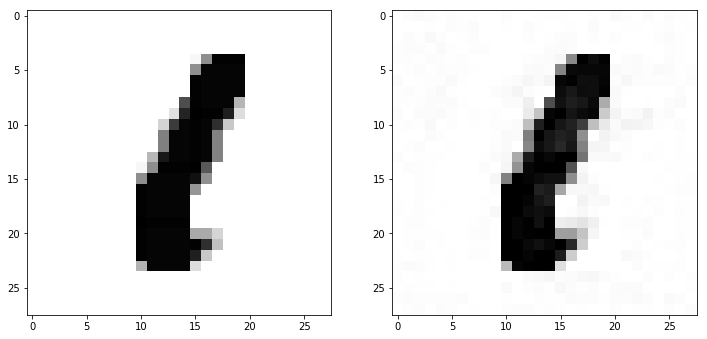

Original prediction:  1
Adversary prediction:  8


In [78]:
# display results
i = 94
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(x_test[i].reshape(28,28), cmap=cm.binary)
ax2.imshow(np.array(x_adv[i]).reshape(28,28), cmap=cm.binary)
plt.show()

print("Original prediction:  %d" % fb_model.predictions(x_test[i]).argmax())
print("Adversary prediction:  %d" % fb_model.predictions(x_adv[i]).argmax())

In [19]:
# save blackbox adversarial images
import pickle
f = open('test_last_500_blackbox_adv.pkl', 'wb')
pickle.dump(x_adv, f)
f.close()

In [81]:
# test accuracy on original TEST images
correct = 0
for i in range(len(x_test)):
    if fb_model.predictions(x_test[i]).argmax() == y_test[i]:
        correct += 1

print("Accuracy on original unseen test data:   %0.2f" % (correct/len(x_test)))

# test accuracy on adversarial test images
correct = 0
for i in range(len(x_adv)):
    if fb_model.predictions(x_adv[i]).argmax() == y_test[i]:
        correct += 1

print("Accuracy on perturbed unseen test data:  %0.2f" % (correct/len(x_adv)))

Accuracy on original unseen test data:   0.97
Accuracy on perturbed unseen test data:  0.33


C:\Users\Yugo\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
C:\Users\Yugo\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


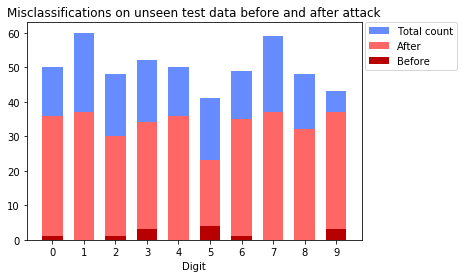

In [82]:
# create histogram of which classes most misclassified on TEST data BEFORE attack
count = [0]*10  # counts how many of each class appears
misclassified = [0]*10  # counts how many misclassified cases for each class
for i in range(len(x_test)):
    count[y_test[i]] += 1
    if fb_model.predictions(x_test[i]).argmax() != y_test[i]:
        misclassified[y_test[i]] += 1    

# create histogram of which classes most misclassified AFTER attack
misclassified2 = [0]*10
for i in range(len(x_adv)):
    if fb_model.predictions(x_adv[i]).argmax() != y_test[i]:
        misclassified2[y_test[i]] += 1
        
# plot histogram of misclassifications
ind = np.arange(len(count))
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
ax3 = fig.add_subplot(111)

ax.bar(ind, count, 0.65, color='#668cff', align='center', label='Total count')
ax2.bar(ind, misclassified2, 0.65, color='#ff6666', align='center', label='After')
ax3.bar(ind, misclassified, 0.65, color='#b80000', align='center', label='Before')

plt.xticks(ind)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.025))
plt.xlabel("Digit")
plt.title("Misclassifications on unseen test data before and after attack")
plt.show()